Choose the characters you want to work with from the finetuning output

In [1]:
import os
import shutil

# Define the directories containing the output of the finetuning
source_directories = [
    '/home/vlachoum/learnable-scriber/finetune_runs/iwcp_south_north_scripts/',
    '/home/vlachoum/learnable-scriber/finetune_runs/iwcp_south_north_individual/'
]

# Define the destination directory where the new folders will be created
destination_directory = 'prototypes/finetuned/'

# Define files and folders to be ignored
ignore_files = {'grid-1l.png', 'grid.png'}
ignore_folders = {'sprites', 'models'}

# Define the character index range aka the characters you want to analyze
character_index = list(range(28, 37)) + list(range(39, 49))

def copy_images(source_path, destination_path):
    # Iterate over each file in the source path
    for file in os.listdir(source_path):
        # Check if the file is a .png image, not to be ignored, and within the specified index interval
        if file.endswith('.png') and file not in ignore_files:
            try:
                file_index = int(file.split('.')[0])
            except ValueError:
                continue
            if file_index in character_index:
                # Copy the file to the destination directory
                shutil.copy2(os.path.join(source_path, file), destination_path)

# Function to handle the copying process for a given source directory
def process_directory(source_directory):
    # Iterate over each folder in the source directory
    for folder in os.listdir(source_directory):
        folder_path = os.path.join(source_directory, folder)
        
        # Check if the current item is a directory and not an ignored folder
        if os.path.isdir(folder_path) and folder not in ignore_folders:
            # Create a new directory in the destination directory with the same name as the current folder
            new_folder_path = os.path.join(destination_directory, folder)
            os.makedirs(new_folder_path, exist_ok=True)

            # Define the path to the sprites/final folder
            sprites_final_path = os.path.join(folder_path, 'sprites', 'final')
            
            # If the sprites/final folder exists, copy images from it
            if os.path.exists(sprites_final_path):
                copy_images(sprites_final_path, new_folder_path)

            # Handle the baseline folder case
            baseline_path = os.path.join(folder_path, 'baseline')
            if os.path.exists(baseline_path):
                copy_images(baseline_path, new_folder_path)

            # Handle the case where images are directly in the folder_path (but not in 'sprites' folder)
            if not os.path.exists(sprites_final_path):
                copy_images(folder_path, new_folder_path)

# Iterate over each source directory and process it
for source_directory in source_directories:
    process_directory(source_directory)

Filter the sprites

In [2]:
from PIL import Image
import numpy as np
from scipy.ndimage import binary_dilation, label, gaussian_filter

# Define input and output parent folders
input_parent_folder = "prototypes/finetuned/"
output_parent_folder = "prototypes/filtered/"
baseline_folder = "prototypes/finetuned/baseline/"

# Iterate over subdirectories in the input parent folder
for folder in os.listdir(input_parent_folder):
    if folder == '.DS_Store':
        continue  # Skip processing .DS_Store file
    
    input_folder = os.path.join(input_parent_folder, folder)
    output_folder = os.path.join(output_parent_folder, folder)
    
    # Skip processing if the output folder already exists
    if os.path.exists(output_folder):
        print(f"Skipping processing for folder '{folder}' as it already exists in the output directory.")
        continue
    
    # Create output folder
    os.makedirs(output_folder)
    
    # Load images for the current folder
    images = []
    masks_ref = []
    
    # Iterate over all .png files in the current folder
    for file in os.listdir(input_folder):
        if file.endswith('.png'):
            image_path = os.path.join(input_folder, file)
            image = Image.open(image_path).convert("L")  # Convert to grayscale
            images.append(image)
            
            # Load reference mask from the baseline folder
            mask_path = os.path.join(baseline_folder, file)
            mask = Image.open(mask_path).convert("L")
            
            # Process the mask
            mask_array = np.array(mask)
            threshold_value = 0.65 * 255
            binary_mask = np.where(mask_array < threshold_value, 255, 0).astype(np.uint8)
            dilated_mask = binary_dilation(binary_mask)
            dilated_mask = binary_dilation(dilated_mask)
            labeled_mask, num_features = label(dilated_mask)
            component_sizes = [np.sum(labeled_mask == label_idx) for label_idx in range(1, num_features + 1)]
            largest_component_label = np.argmax(component_sizes) + 1
            largest_component_mask = np.where(labeled_mask == largest_component_label, 255, 0).astype(np.uint8)
            convolved_mask = gaussian_filter(largest_component_mask, sigma=1)
            masks_ref.append(convolved_mask)
    
    # Apply masks to images and save filtered images
    for image, mask, file in zip(images, masks_ref, os.listdir(input_folder)):
        img_array = np.array(image)
        filtered_image = 255 - mask + img_array * (mask / 255)
        filtered_image = Image.fromarray(filtered_image.astype(np.uint8))
        
        # Construct the filename based on the original image name
        filename = file
        filtered_image_path = os.path.join(output_folder, filename)
        filtered_image.save(filtered_image_path)
        
print("Processing complete.")

Skipping processing for folder 'SBB-PK-Hdschr25' as it already exists in the output directory.
Skipping processing for folder 'Southern_Textualis' as it already exists in the output directory.
Skipping processing for folder 'btv1b8455783p' as it already exists in the output directory.
Skipping processing for folder 'Northern_Textualis' as it already exists in the output directory.
Skipping processing for folder 'btv1b84473026' as it already exists in the output directory.
Skipping processing for folder 'Arras-861' as it already exists in the output directory.
Skipping processing for folder 'btv1b525068331' as it already exists in the output directory.
Skipping processing for folder 'btv1b8447298r' as it already exists in the output directory.
Skipping processing for folder 'btv1b55006072j' as it already exists in the output directory.
Skipping processing for folder 'btv1b8433319z' as it already exists in the output directory.
Skipping processing for folder 'btv1b90590259' as it already

Automatic failure identification

KeyboardInterrupt: 

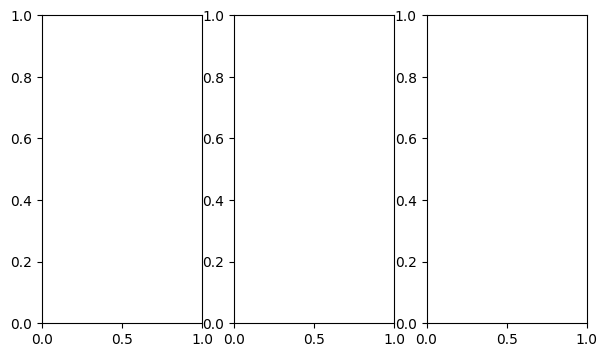

In [8]:
from PIL import ImageOps
import pandas as pd
import matplotlib.pyplot as plt

# Define input and output parent folders
input_parent_folder = "prototypes/finetuned/"
output_parent_folder = "prototypes/filtered_failure_cases/"
baseline_folder = "prototypes/finetuned/baseline/"

# Threshold values
default_threshold = 0.8 * 255  # Default threshold for reference mask
sup_threshold = 0.65 * 255  # threshold for doc mask

# Iterate over subdirectories in the input parent folder
for folder in os.listdir(input_parent_folder):
    if folder == '.DS_Store':
        continue  # Skip processing .DS_Store file
    
    input_folder = os.path.join(input_parent_folder, folder)
    output_folder = os.path.join(output_parent_folder, folder)
    
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Load images for the current folder
    images = []
    masks_ref = []
    masks_sup = []
    deviations_per_image = []
    
    # Iterate over all .png files in the current folder
    for file in sorted(os.listdir(input_folder)):
        if file.endswith('.png'):
            image_path = os.path.join(input_folder, file)
            image = Image.open(image_path).convert("L")  # Convert to grayscale
            images.append(image)
            
            # Load reference mask from the baseline folder
            mask_path = os.path.join(baseline_folder, file)
            mask = Image.open(mask_path).convert("L")
            
            # Process the reference mask
            mask_array = np.array(mask)
            binary_mask_ref = np.where(mask_array < default_threshold, 255, 0).astype(np.uint8)
            dilated_mask_ref = binary_mask_ref
            for _ in range(2):  # Dilate x times
                dilated_mask_ref = binary_dilation(dilated_mask_ref)
            labeled_mask_ref, num_features_ref = label(dilated_mask_ref)
            component_sizes_ref = [np.sum(labeled_mask_ref == label_idx) for label_idx in range(1, num_features_ref + 1)]
            largest_component_label_ref = np.argmax(component_sizes_ref) + 1
            largest_component_mask_ref = np.where(labeled_mask_ref == largest_component_label_ref, 255, 0).astype(np.uint8)
            convolved_mask_ref = gaussian_filter(largest_component_mask_ref, sigma=1)
            masks_ref.append(convolved_mask_ref)
            
            # Process the doc mask
            img_array = np.array(image)
            binary_mask_sup = np.where(img_array < sup_threshold, 255, 0).astype(np.uint8)
            labeled_mask_sup, num_features_sup = label(binary_mask_sup)
            component_sizes_sup = [np.sum(labeled_mask_sup == label_idx) for label_idx in range(1, num_features_sup + 1)]
            largest_component_label_sup = np.argmax(component_sizes_sup) + 1
            largest_component_mask_sup = np.where(labeled_mask_sup == largest_component_label_sup, 255, 0).astype(np.uint8)
            masks_sup.append(largest_component_mask_sup)
            
            # Apply masks to the reference image
            filtered_image_ref = 255 - masks_ref[-1] + img_array * (masks_ref[-1] / 255)
            filtered_image_ref = np.clip(filtered_image_ref, 0, 255).astype(np.uint8)
            filtered_image_ref = Image.fromarray(filtered_image_ref).convert('RGB')
            
            # Save the filtered doc image 
            filtered_image_path = os.path.join(output_folder, file)
            filtered_image_ref.save(filtered_image_path)
            
            difference = (np.sum(masks_sup[-1] * (255. - masks_ref[-1])) / 255.) / 255
            
            # Set border colors based on difference score thresholds
            if 15.5 <= difference <= 30:
                border_color = 'orange'  
            elif difference > 30:
                border_color = 'red'  
            else:
                border_color = 'white'  
            
            # Add border to the image with the specified color and width
            filtered_image_ref_with_border = ImageOps.expand(filtered_image_ref, border=2, fill=border_color)
            
            # Save the filtered image with border
            filtered_image_path_with_border = os.path.join(output_folder, file)
            filtered_image_ref_with_border.save(filtered_image_path_with_border)
            
            # Create an array where difference pixels are set to white
            difference_array = (masks_sup[-1] * (255. - masks_ref[-1])) / 255.
            difference_image = Image.fromarray(difference_array.astype(np.uint8))
            deviations_per_image.append(difference)

            
            # Create figure and subplots
            fig, axes = plt.subplots(1, 5, figsize=(12, 4))
            
            # Plot images and set titles
            axes[0].imshow(img_array, cmap='gray', clim=(0, 255))
            axes[0].set_title(f'Doc prototype ({folder})')
            axes[1].imshow(convolved_mask_ref, cmap='gray', clim=(0, 255))
            axes[1].set_title('Ref Mask')
            axes[2].imshow(largest_component_mask_sup, cmap='gray', clim=(0, 255))
            axes[2].set_title('Doc Mask')
            axes[3].imshow(filtered_image_ref, cmap='gray', clim=(0, 255))
            axes[3].set_title('Filtered Doc')
            axes[4].imshow(difference_image, cmap='gray', clim=(0, 255))  # Show difference pixels
            axes[4].set_title('Diff Map: '+ str(difference)) 
            
            #plt.savefig(os.path.join(output_folder, f"diff_{os.path.splitext(file)[0]}.png"), bbox_inches='tight')
            
            plt.show()

Function to create grids from document folders

In [13]:
import os
import PIL
from PIL import Image

def horzpil(images, width, height, margin=2):
    """Concatenate images horizontally with a small margin between them."""
    images = [PIL.Image.open(image_path) for image_path in images]
    
    total_width = width * len(images) + margin * (len(images) - 1)  # Add margin space
    max_height = height
    new_im = PIL.Image.new('RGB', (total_width, max_height), color=(255, 255, 255))  # White background
    
    x_offset = 0
    for img in images:
        new_im.paste(img, (x_offset, 0))
        x_offset += width + margin  # Add margin space
    return new_im

def folder_to_grid(folder_paths, folder_order, character_index, image_width, image_height, margin=2):
    """Convert images in multiple folders to a horizontal grid based on the specified order."""
    # Initialize list to store grid images
    grid_images = []
    
    # Iterate through folders in specified order
    for folder_name in folder_order:
        folder_path = os.path.join(folder_paths, folder_name)
        print(f"Processing folder: {folder_path}")  
        folder_images = []
        
        # Iterate through image names in specified order for each folder
        for i in character_index:
            image_path = os.path.join(folder_path, f"{i}.png")
            if os.path.exists(image_path):
                folder_images.append(image_path)
                #print(f"Taking image from {folder_name}: {i}.png")
                
        # Check if folder_images is not empty
        if folder_images:
            # Concatenate images horizontally for the current folder with a margin
            folder_grid = horzpil(folder_images, image_width, image_height, margin=margin)
            grid_images.append(folder_grid)
    
    # Concatenate grid images vertically to form the final grid if there are images
    if grid_images:
        final_grid = PIL.Image.new('RGB', (grid_images[0].width, sum(grid_img.height for grid_img in grid_images)), color=(255, 255, 255))
        y_offset = 0
        for grid_img in grid_images:
            final_grid.paste(grid_img, (0, y_offset))
            y_offset += grid_img.height
    else:
        final_grid = PIL.Image.new('RGB', (1, 1), color=(255, 255, 255))  # Create a blank white image
    
    return final_grid

Visualise the denoised prototypes with failure identification borders

In [35]:
# Personalize the order of folder names in the order you like to visualise them

#vertical axis 
folder_order = ['baseline', "Northern_Textualis", "btv1b8447298r", "btv1b525068331", "Arras-861", "btv1b84473026",
                "btv1b8455783p", "btv1b55006072j", "SBB-PK-Hdschr25", 'Southern_Textualis', "btv1b90615126", "btv1b100361755", "btv1b8433319z",
               "IB15304245v", "btv1b90590259", "btv1b8446940n", "IB15304274v"]

# Specify the input folder:
denoised_prototype_folders = "prototypes/filtered_failure_cases/"
output_folder = "grids/"
output_path = os.path.join(output_folder, "prototypes_failure_cases.jpeg")

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)
print(f"Created directory: {output_folder}")

# Open one of the images to calculate its dimensions to define the grid size
sample_image_path = os.path.join(denoised_prototype_folders, folder_order[0], f"{character_index[0]}.png")
sample_image = PIL.Image.open(sample_image_path)

# Calculate image width and height
image_width, image_height = sample_image.size

#Set the margin between images
margin = 2

# Generate the grid image
denoised_prototypes_borders = folder_to_grid(denoised_prototype_folders, folder_order, character_index, image_width, image_height, margin=margin)

# Save the grid image
denoised_prototypes_borders.save(output_path)
print("Image saved at:", output_path)

Created directory: grids/
Pasted image: prototypes/filtered_failure_cases/baseline/28.png at row: 0, col: 0
Pasted image: prototypes/filtered_failure_cases/baseline/29.png at row: 0, col: 1
Pasted image: prototypes/filtered_failure_cases/baseline/30.png at row: 0, col: 2
Pasted image: prototypes/filtered_failure_cases/baseline/31.png at row: 0, col: 3
Pasted image: prototypes/filtered_failure_cases/baseline/32.png at row: 0, col: 4
Pasted image: prototypes/filtered_failure_cases/baseline/33.png at row: 0, col: 5
Pasted image: prototypes/filtered_failure_cases/baseline/34.png at row: 0, col: 6
Pasted image: prototypes/filtered_failure_cases/baseline/35.png at row: 0, col: 7
Pasted image: prototypes/filtered_failure_cases/baseline/36.png at row: 0, col: 8
Pasted image: prototypes/filtered_failure_cases/baseline/39.png at row: 0, col: 9
Pasted image: prototypes/filtered_failure_cases/baseline/40.png at row: 0, col: 10
Pasted image: prototypes/filtered_failure_cases/baseline/41.png at row:

Function to visually compare the prototypes

In [18]:
from matplotlib.colors import LinearSegmentedColormap

# Define custom colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'white', 'red'], N=256)

def subtract_images(image1, image2, axes, opacity=0.5):
    # Perform the subtraction
    result = image1.astype(float) - image2.astype(float)

    # Display the result on the third subplot
    axes[2].imshow(result, cmap=cmap, vmin=-255, vmax=255, alpha=opacity)
    axes[2].axis('off')  # Hide the axes
    
    return result

def visualize_comparison(folder1, folder2, character_order, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    for character in character_order:
        # Construct the file paths for the images
        image1_path = os.path.join(folder1, f"{character}.png")
        image2_path = os.path.join(folder2, f"{character}.png")

        # Debugging statements
        #print(f"Processing character: {character}")
        #print(f"Image 1 path: {image1_path}")
        #print(f"Image 2 path: {image2_path}")

        if not os.path.exists(image1_path):
            print(f"Image 1 not found: {image1_path}")
            continue
        if not os.path.exists(image2_path):
            print(f"Image 2 not found: {image2_path}")
            continue

        # Load the images
        image1 = np.array(Image.open(image1_path).convert('L'))
        image2 = np.array(Image.open(image2_path).convert('L'))

        # Create a subplot with 1 row and 3 columns
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        
        # Plot folder1 image
        axes[0].imshow(image1, cmap='gray', vmin=0, vmax=255)
        axes[0].axis('off')

        # Plot folder2 image
        axes[1].imshow(image2, cmap='gray', vmin=0, vmax=255)
        axes[1].axis('off')

        # Overlay image2 on top of image1 and plot the result
        result = subtract_images(image1, image2, axes, opacity=0.5)
        result_path = os.path.join(output_folder, f"{character}.png")
        plt.imsave(result_path, result, cmap=cmap, vmin=-255, vmax=255)

        # Save the visual comparison image
        visual_comparison_path = os.path.join(output_folder, f"visual_comparison_character_{character}.png")
        plt.savefig(visual_comparison_path)
        
        # Display the images
        plt.tight_layout()
        plt.show()

Apply the function to compare each document to the baseline

Processing folder: prototypes/filtered/Northern_Textualis


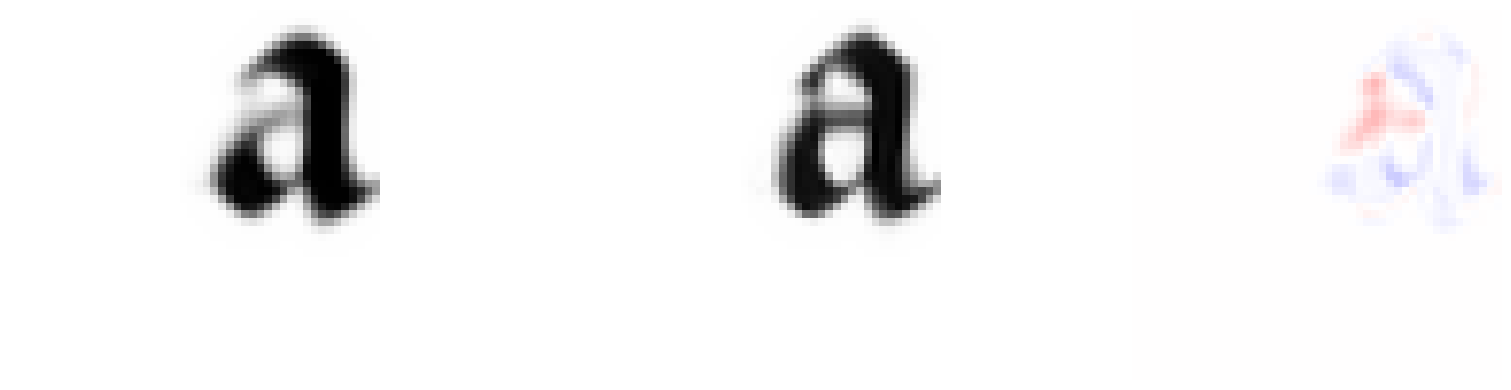

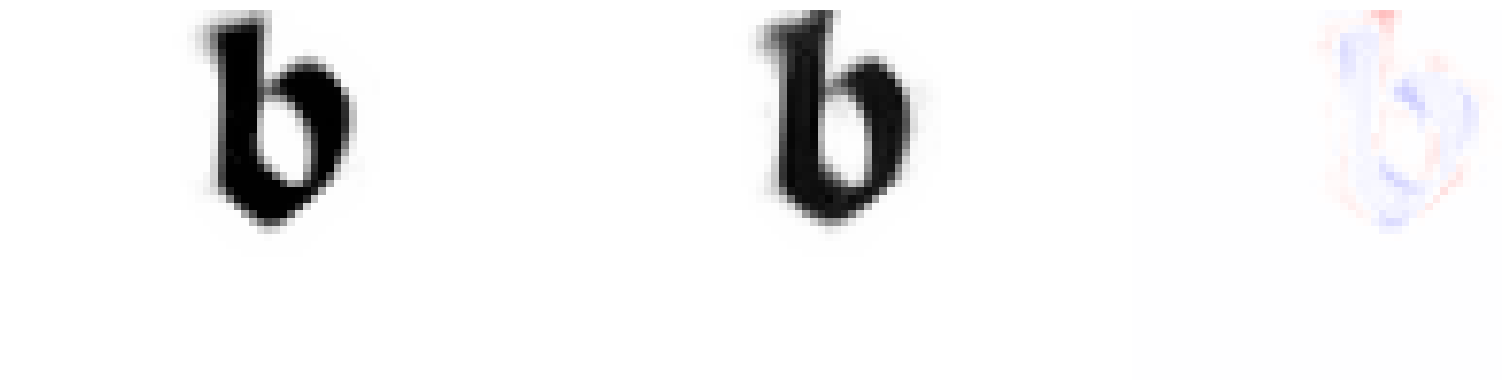

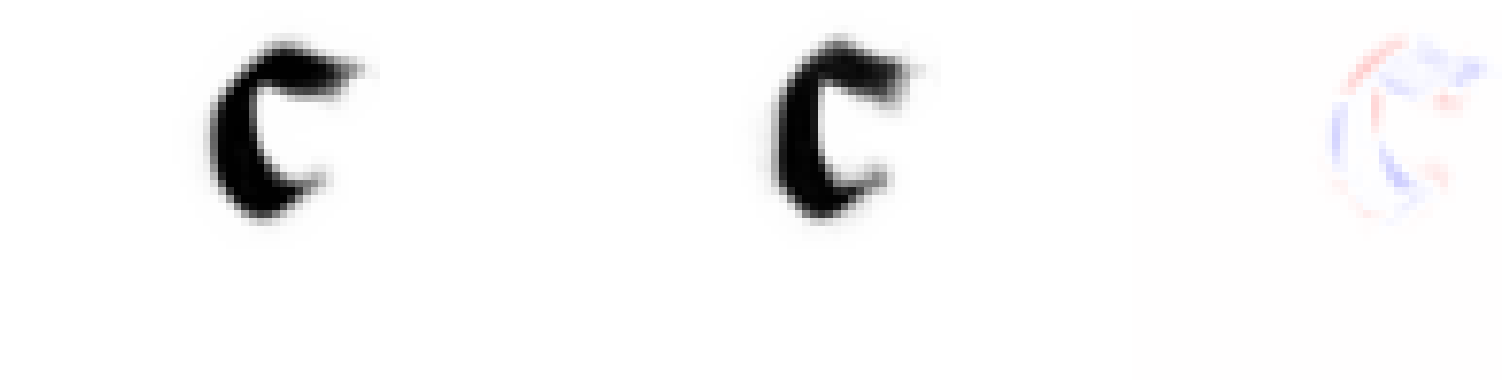

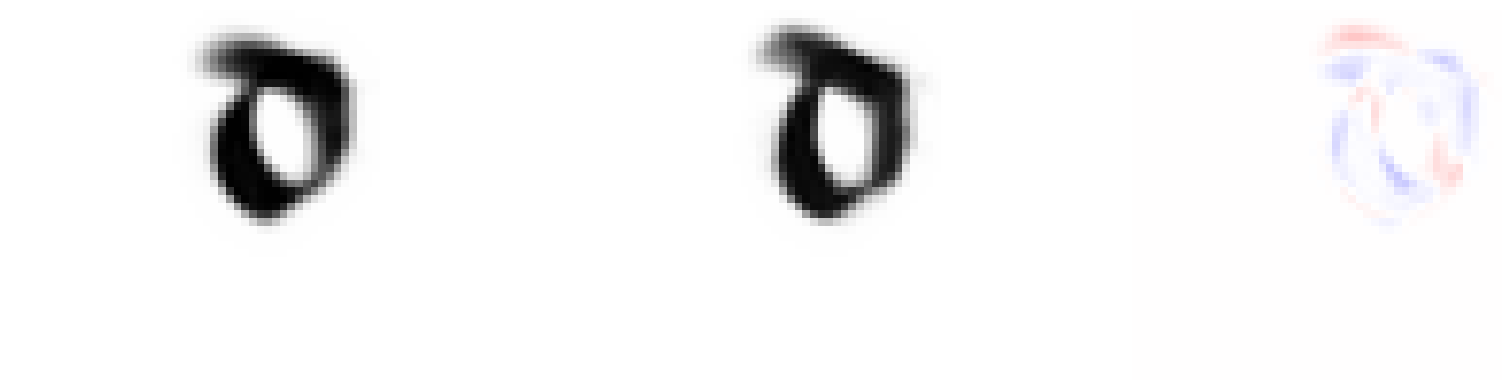

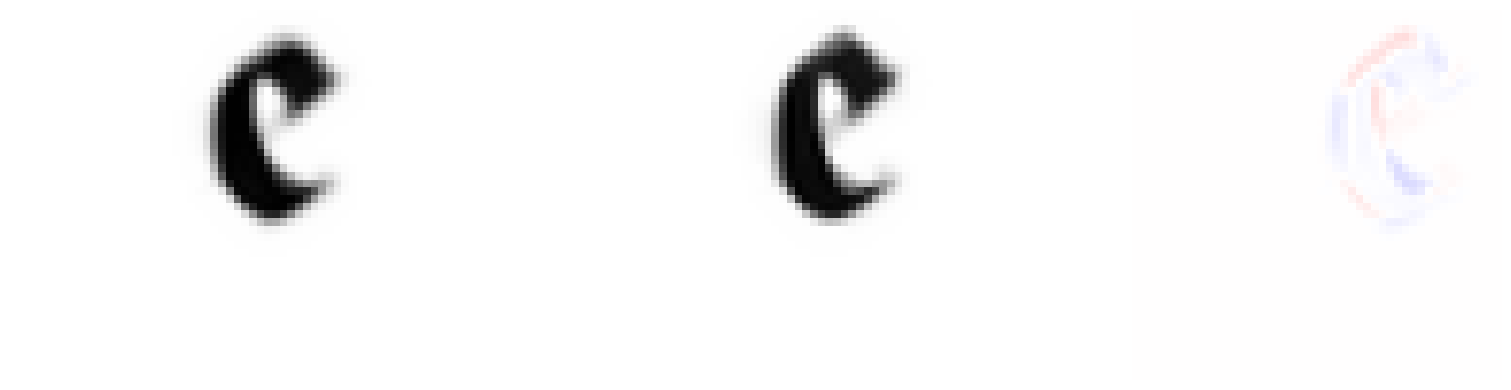

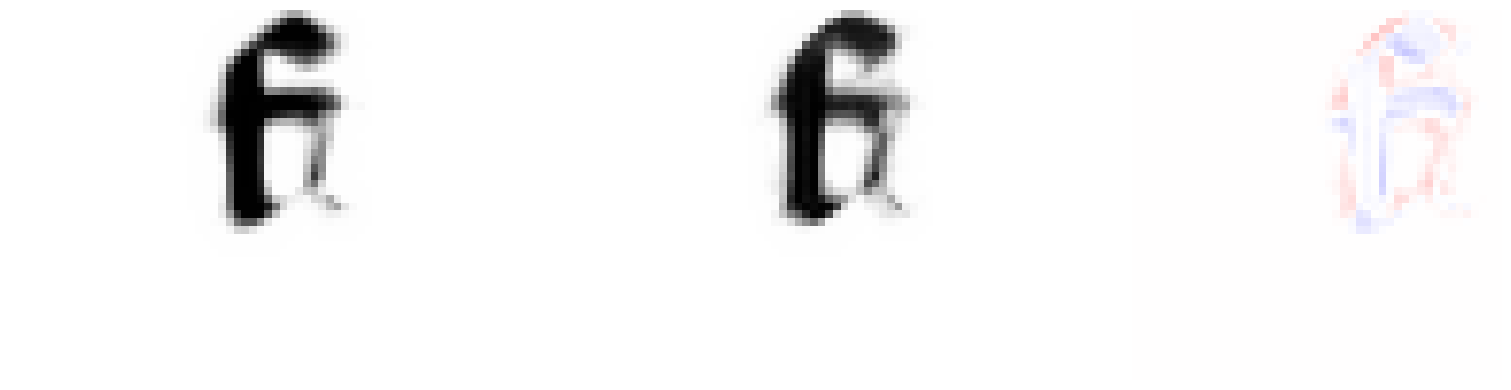

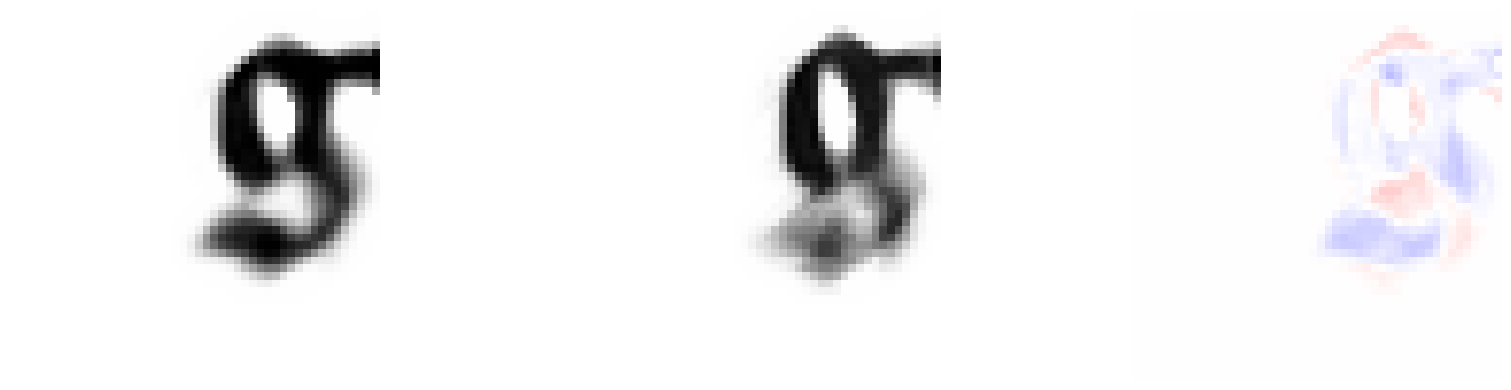

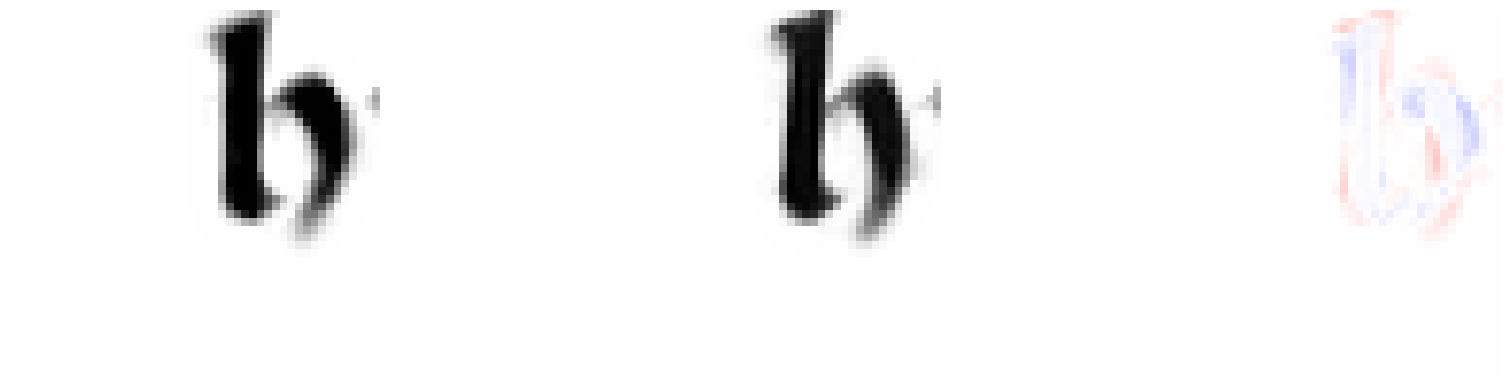

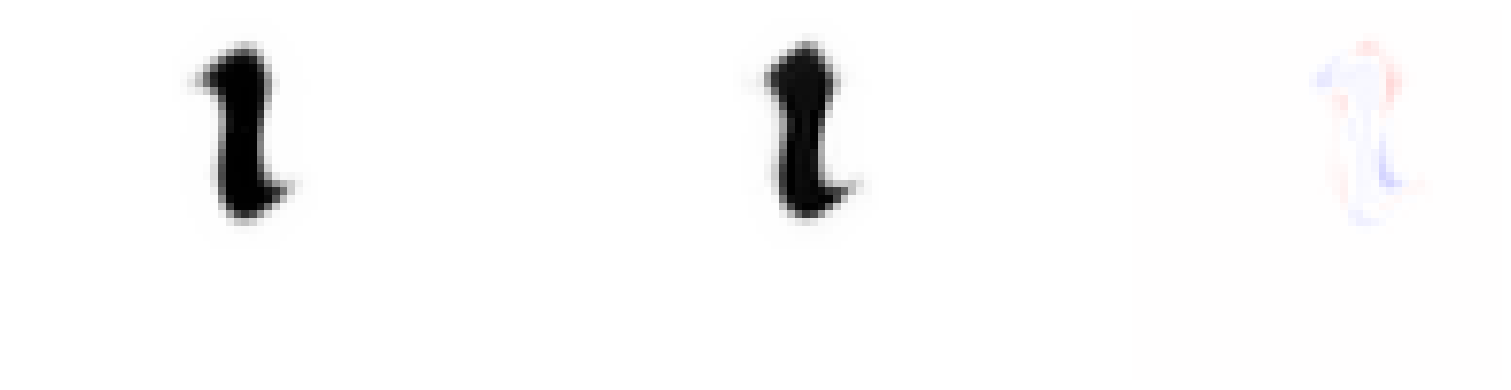

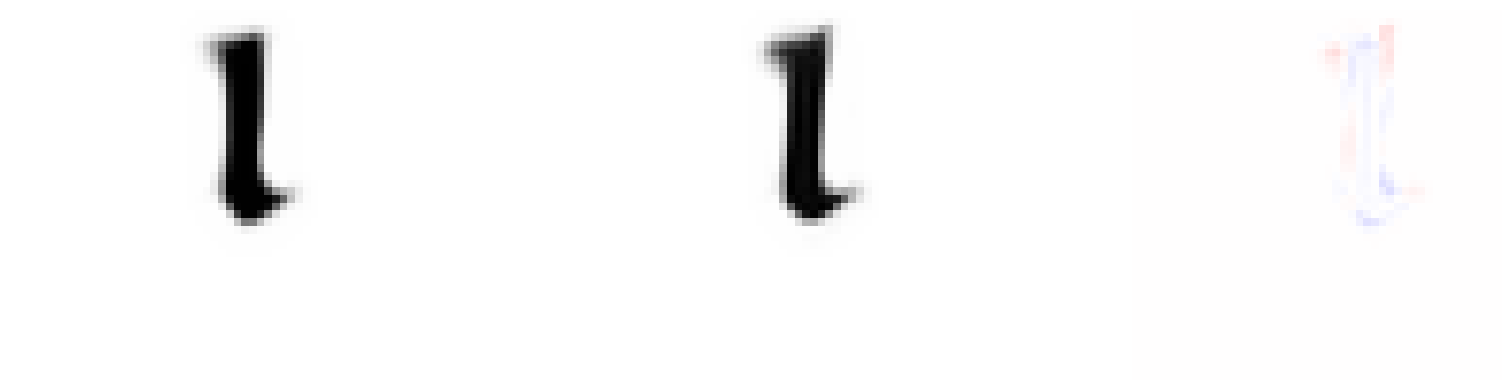

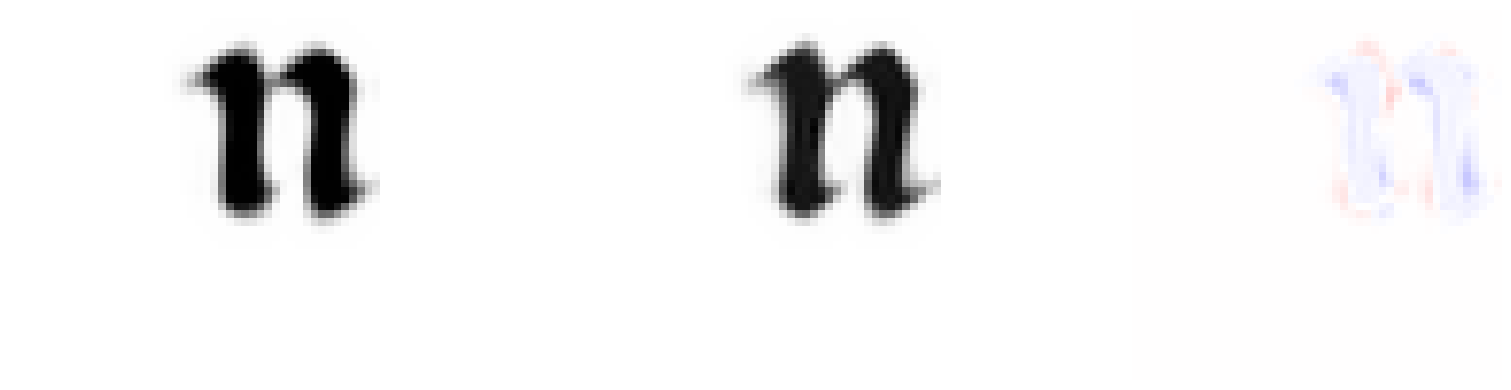

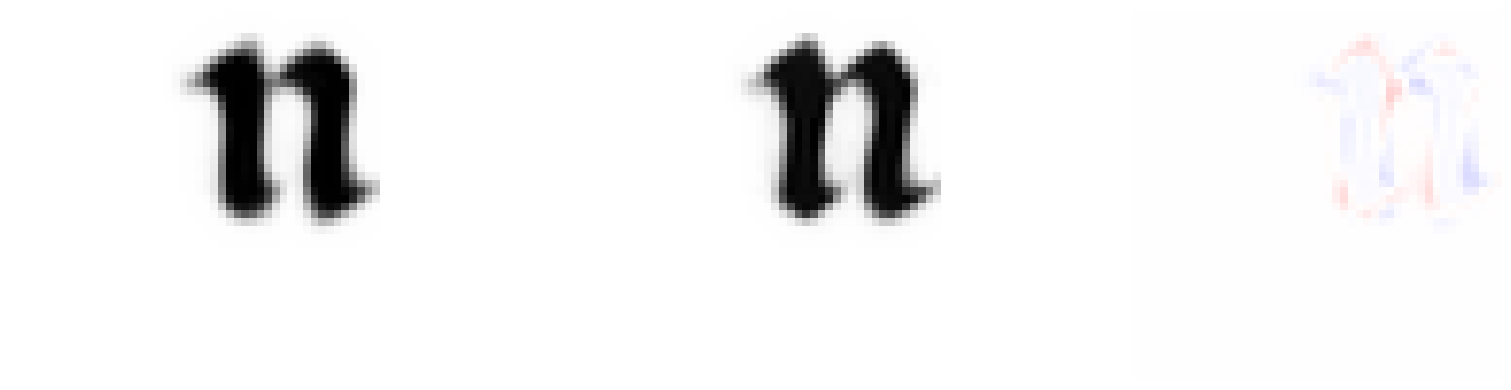

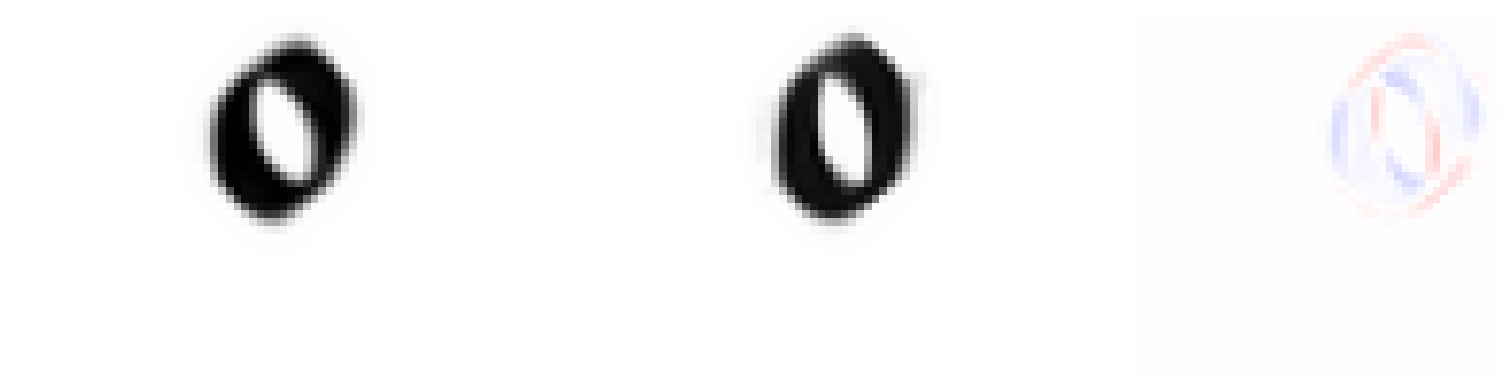

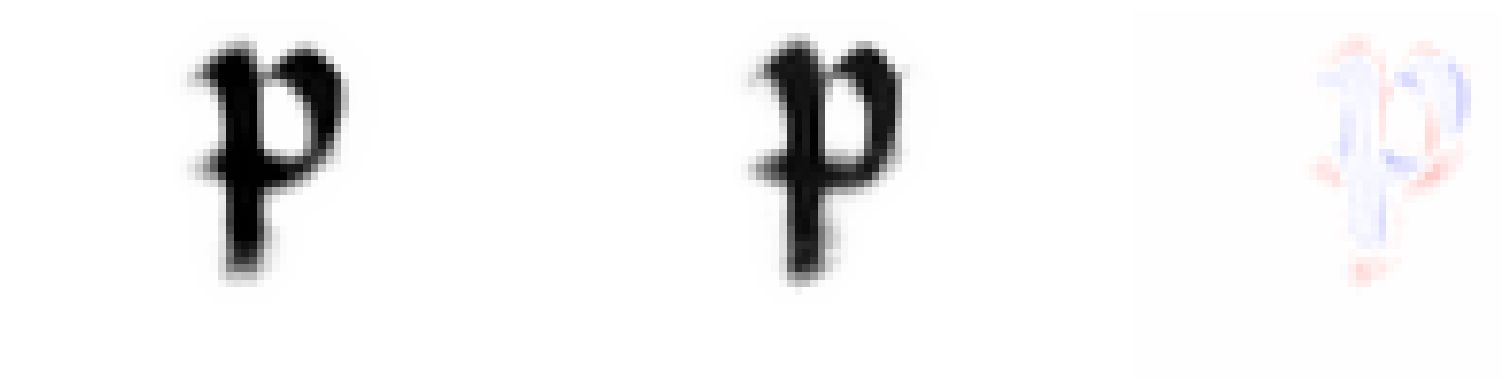

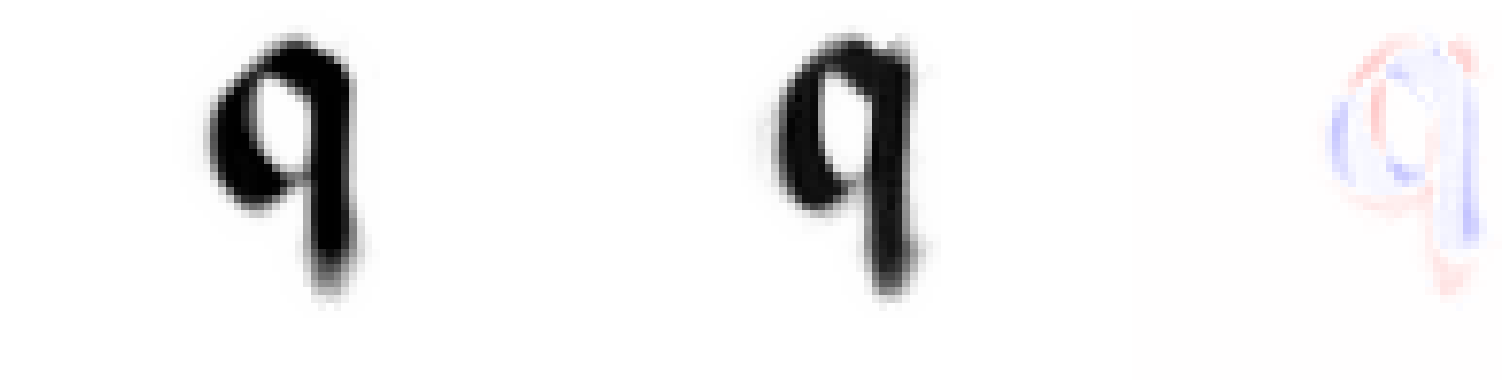

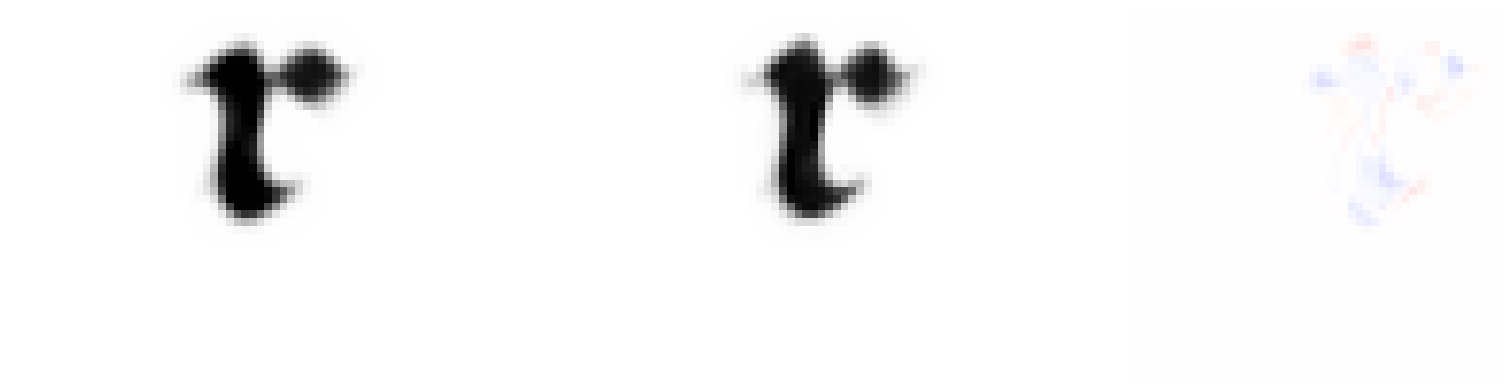

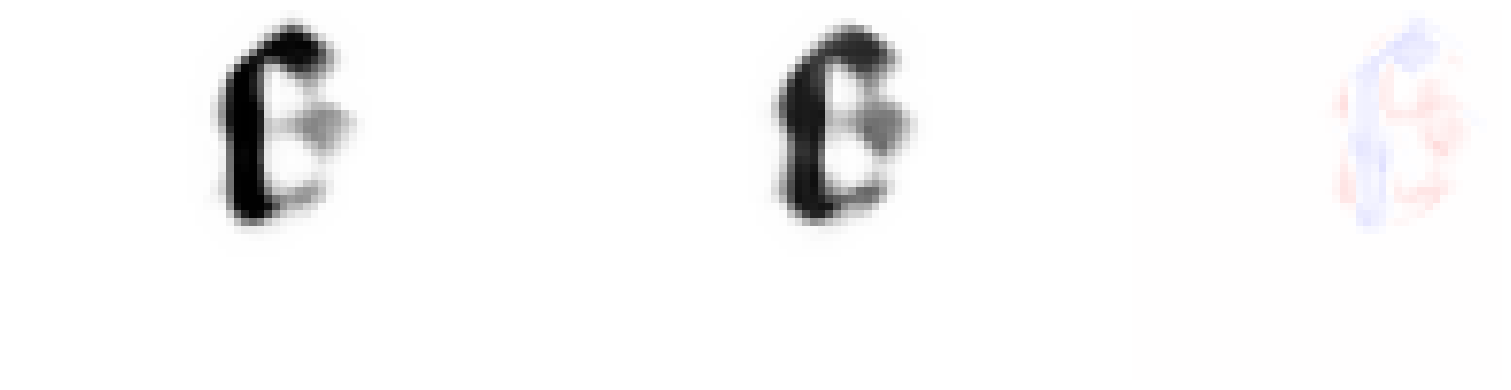

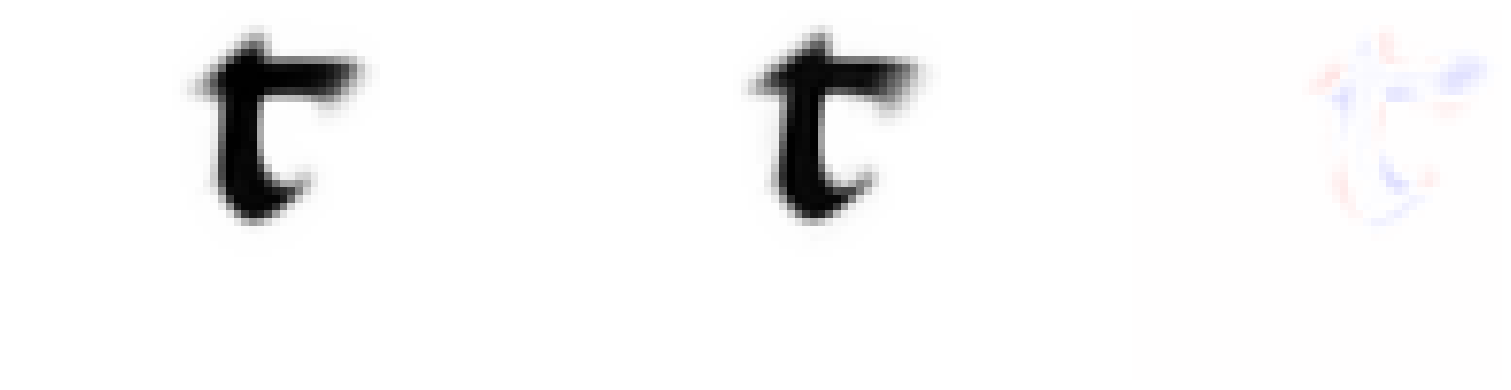

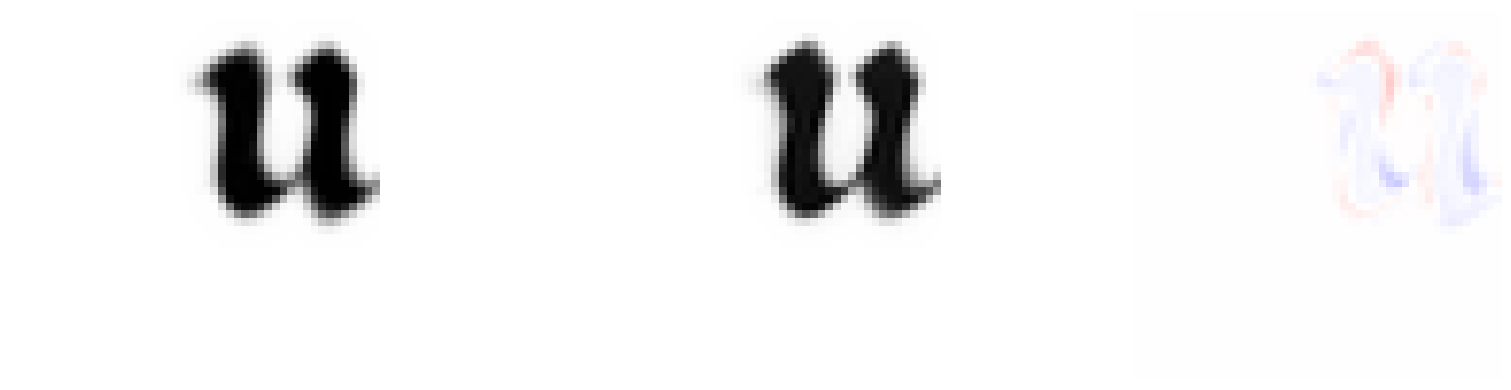

Processing folder: prototypes/filtered/btv1b8447298r


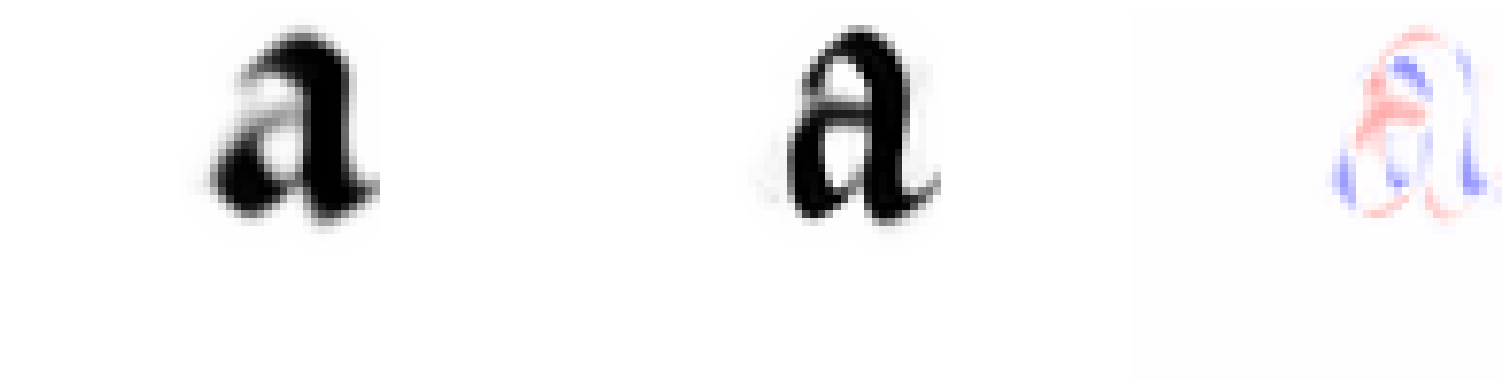

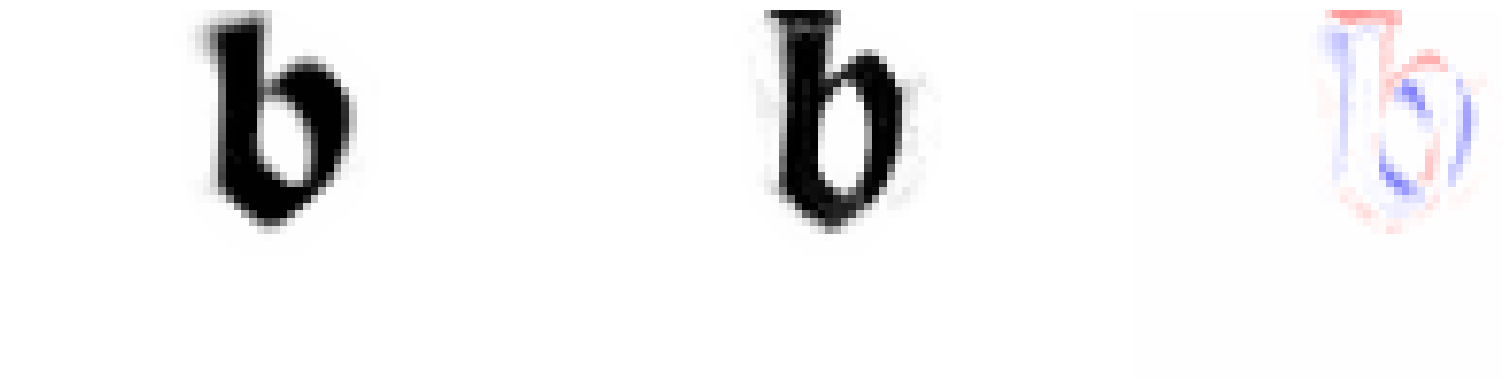

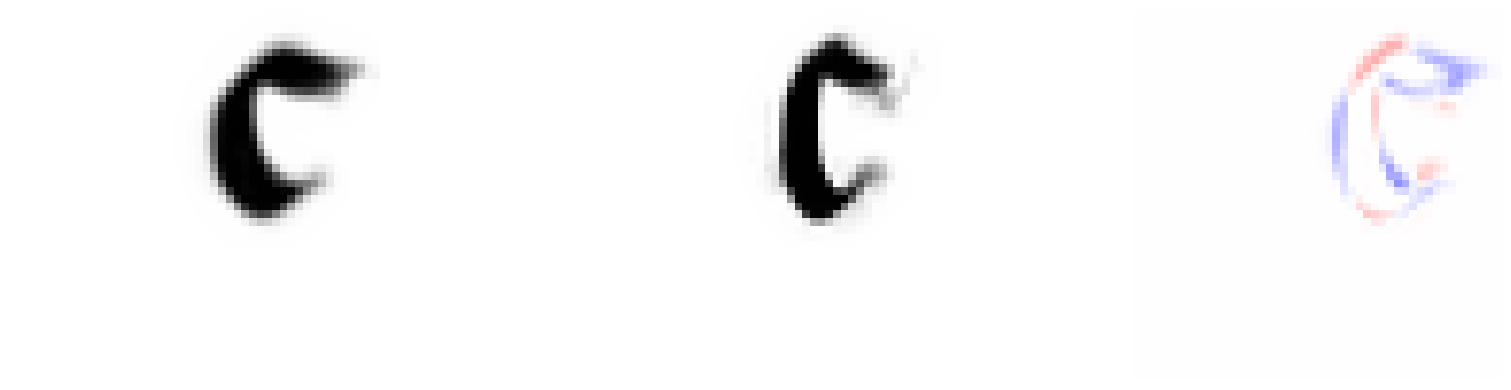

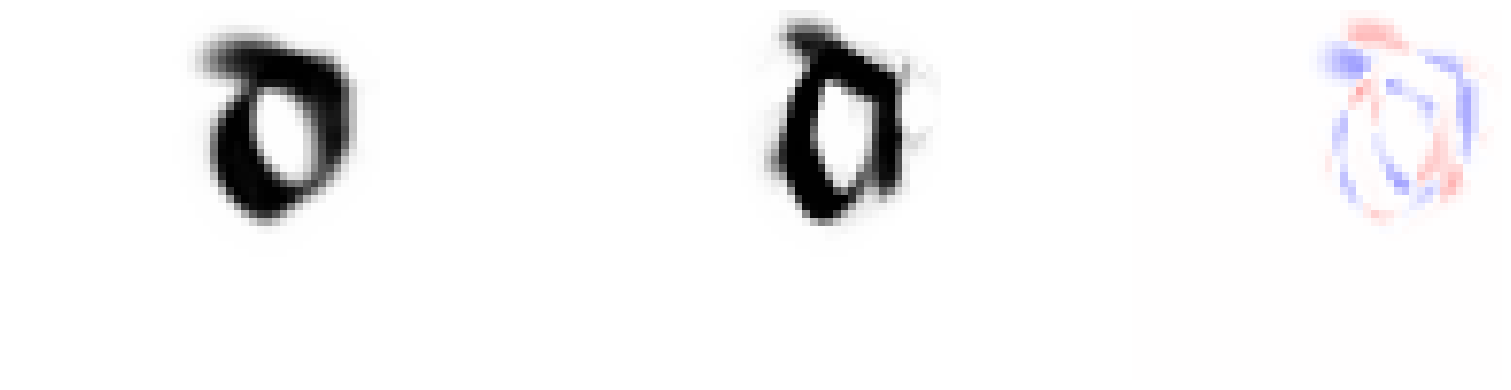

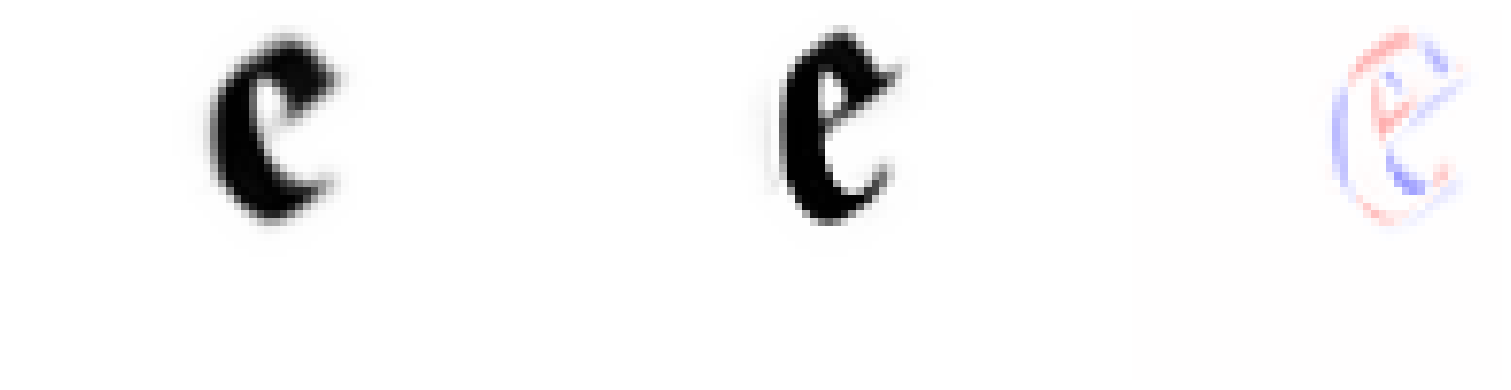

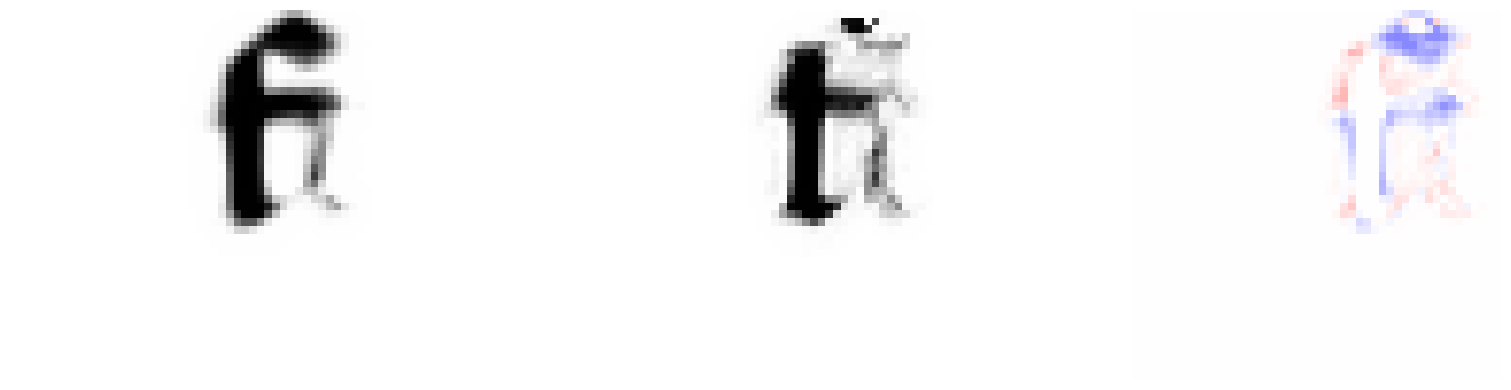

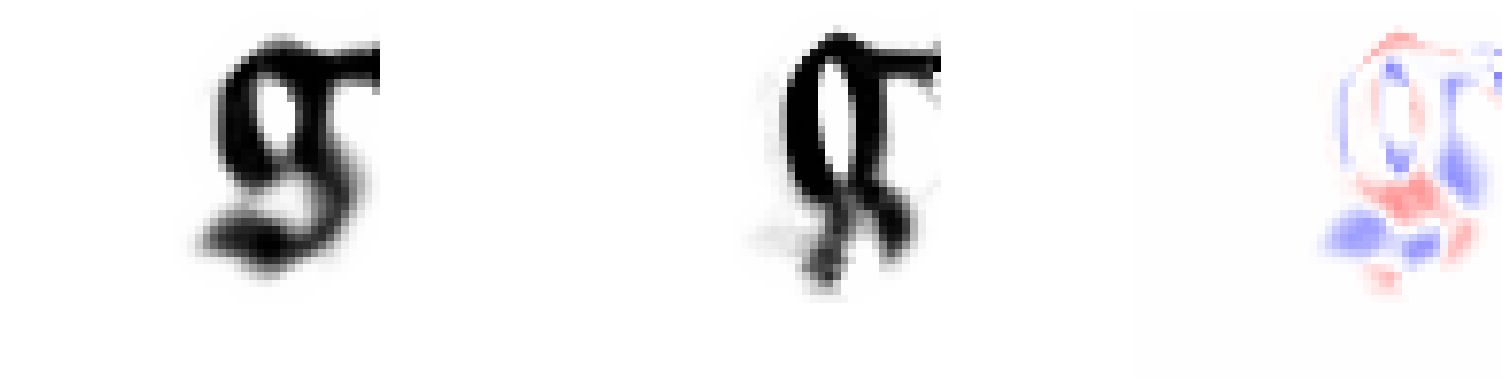

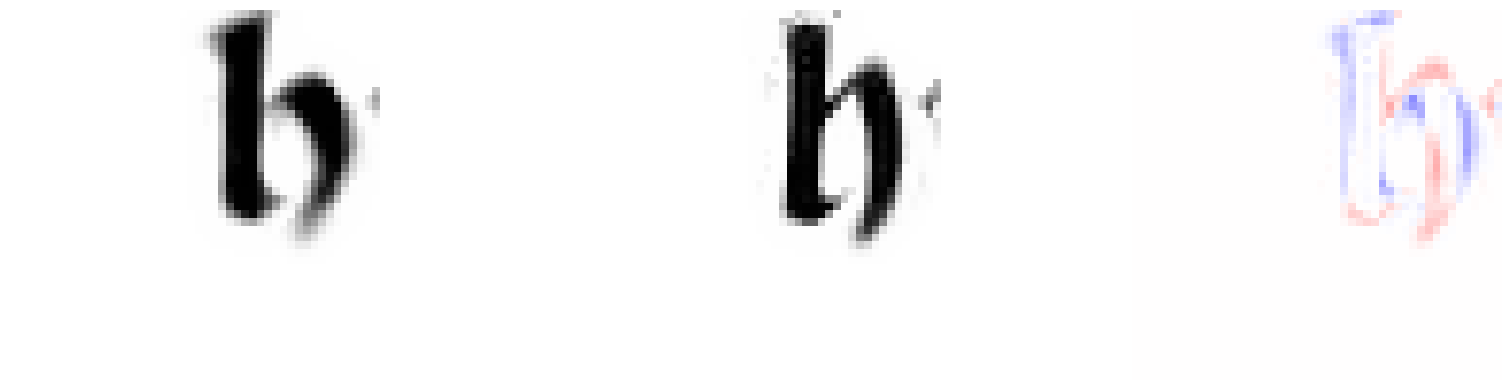

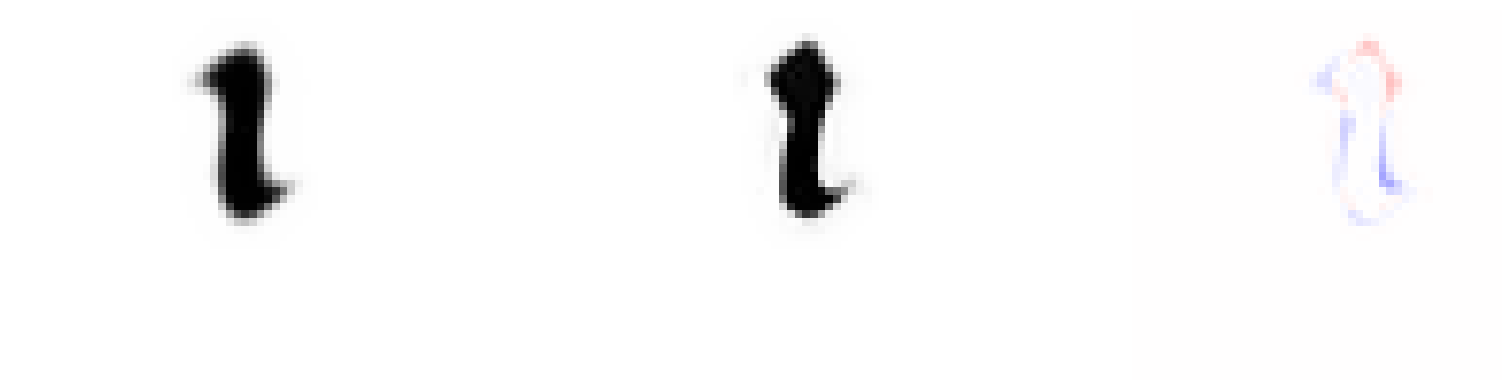

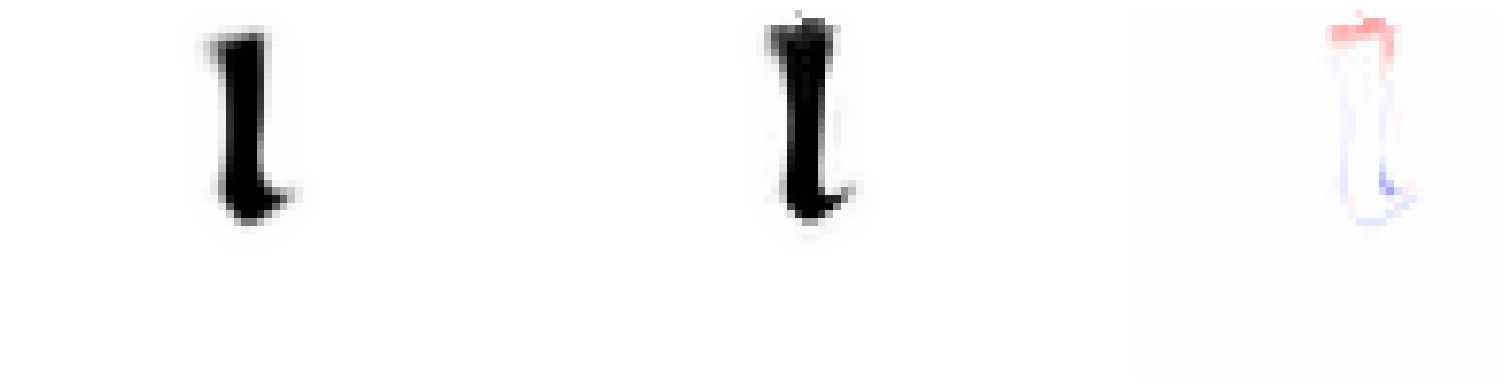

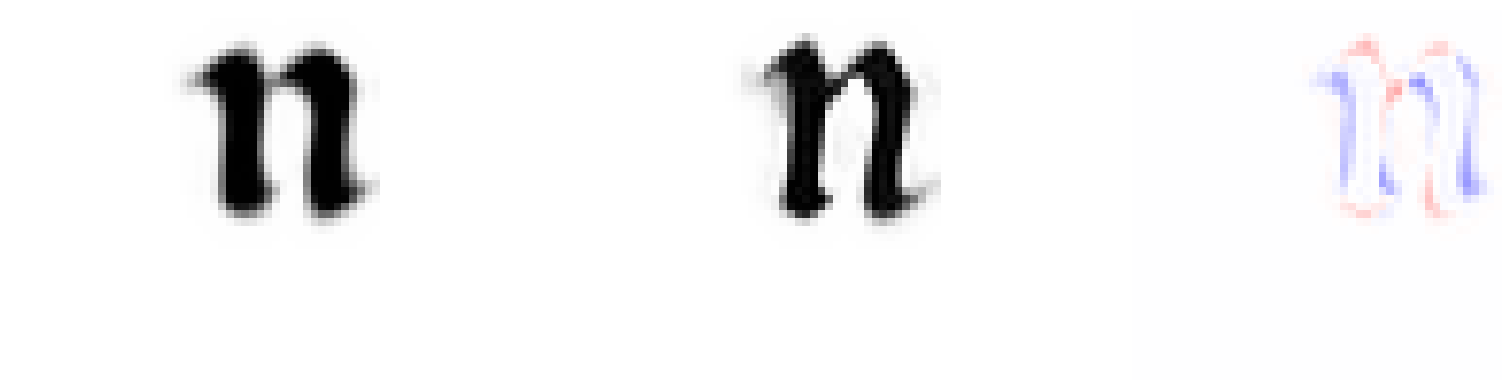

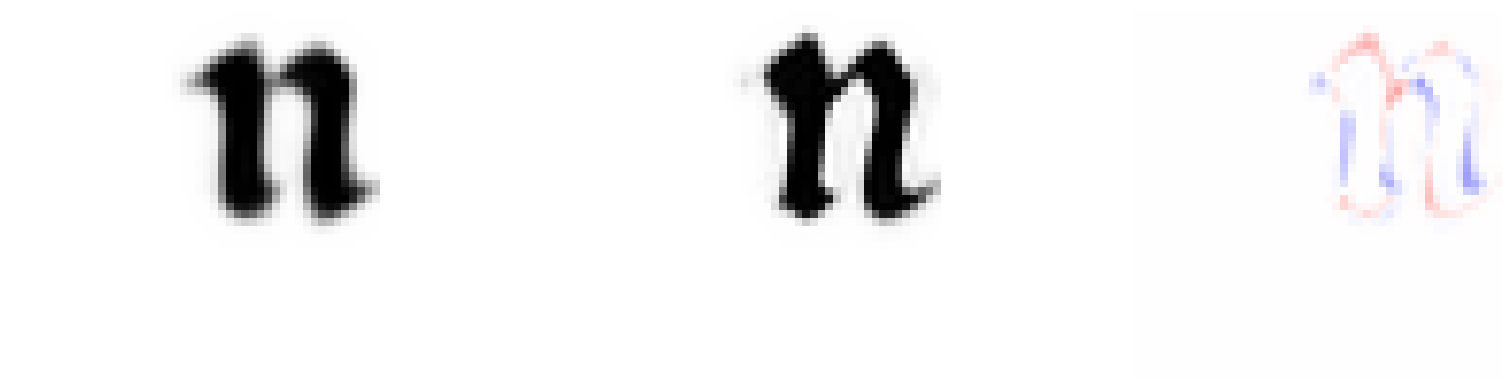

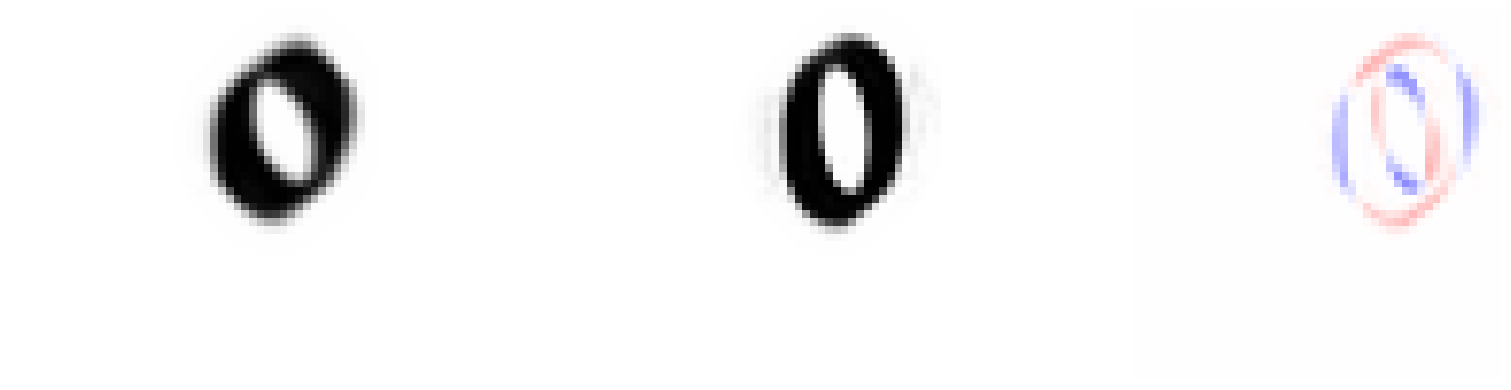

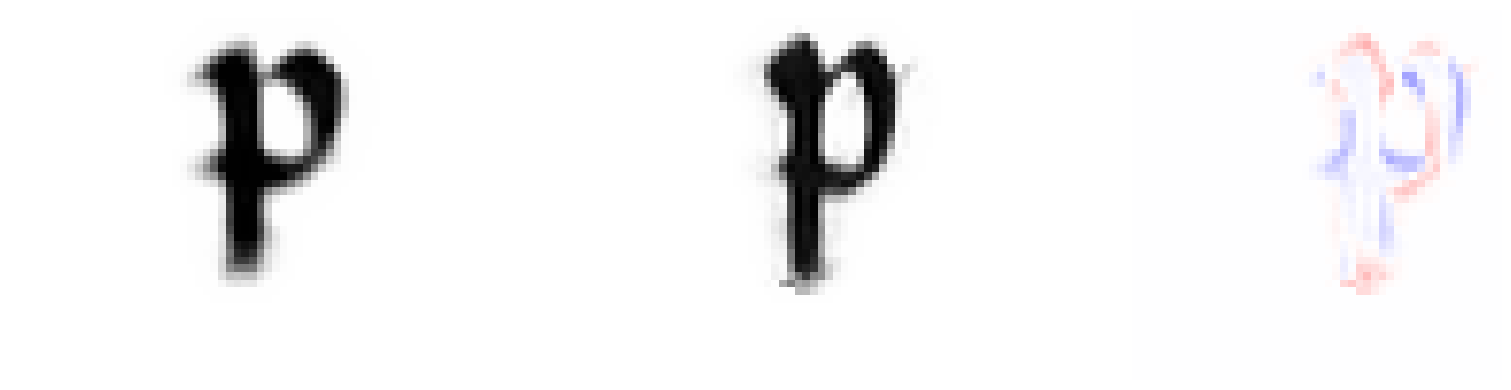

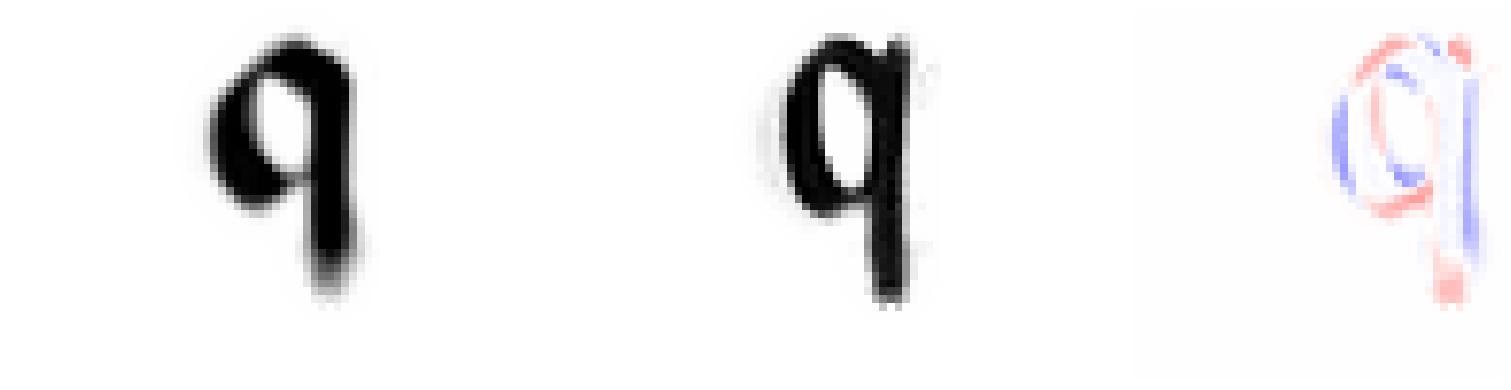

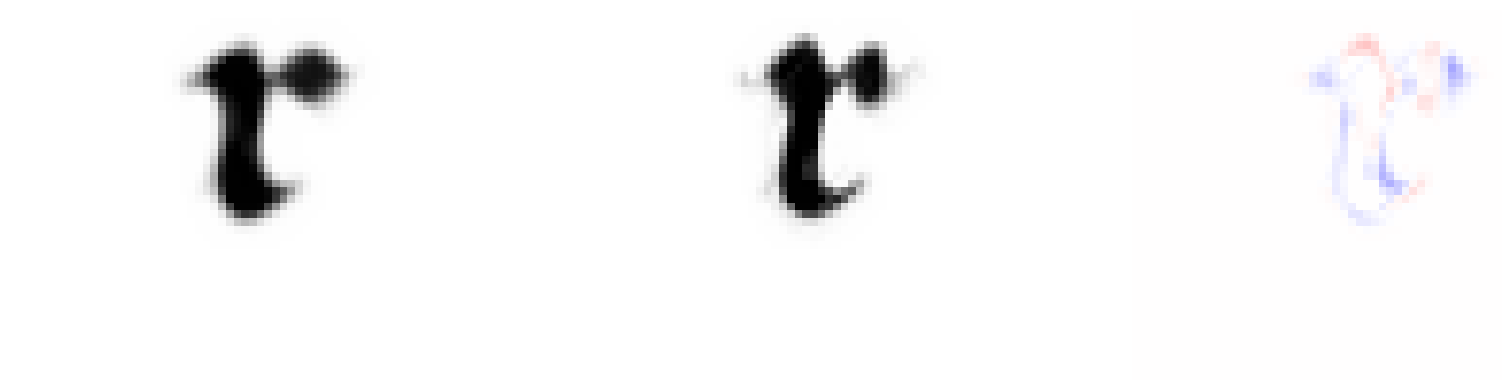

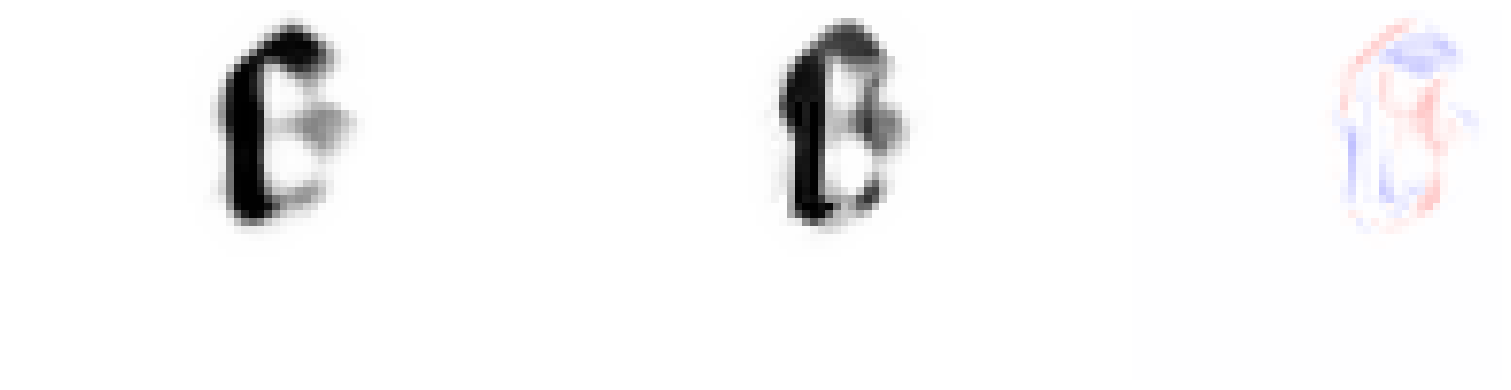

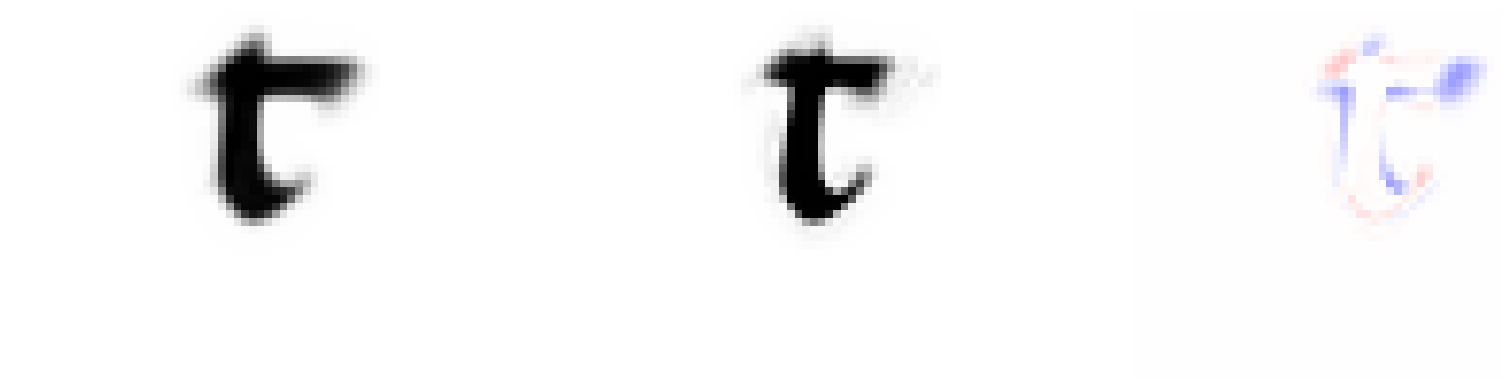

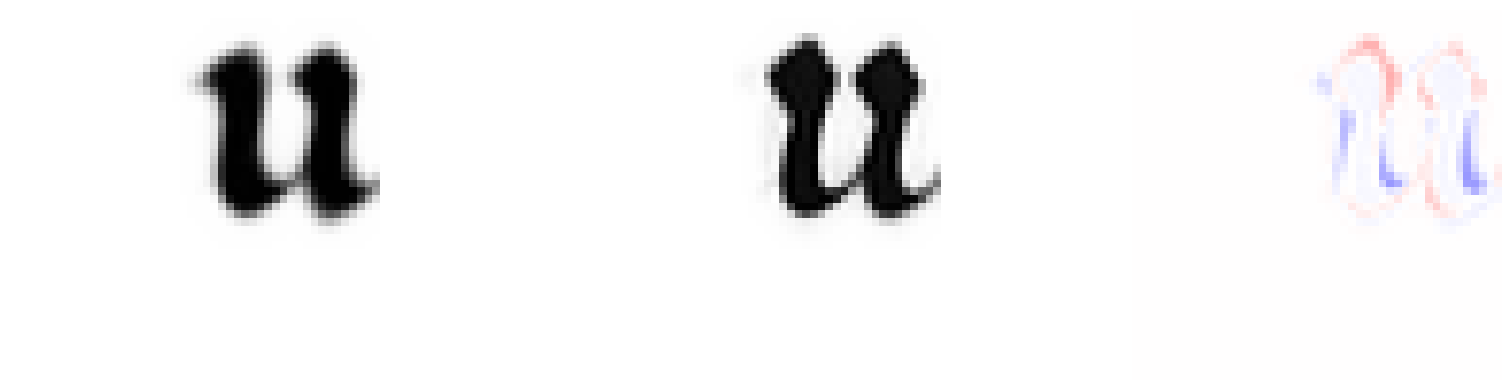

Processing folder: prototypes/filtered/btv1b525068331


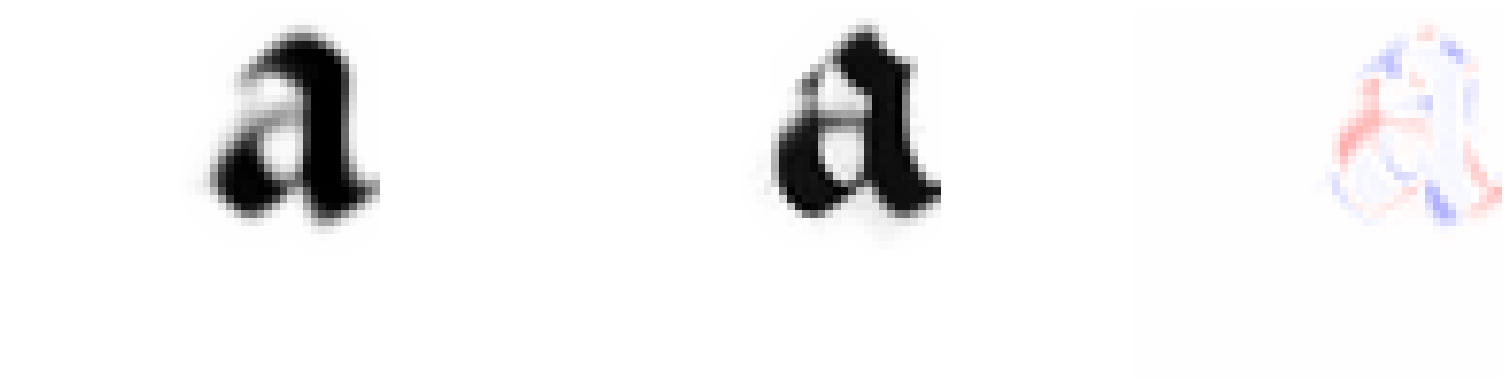

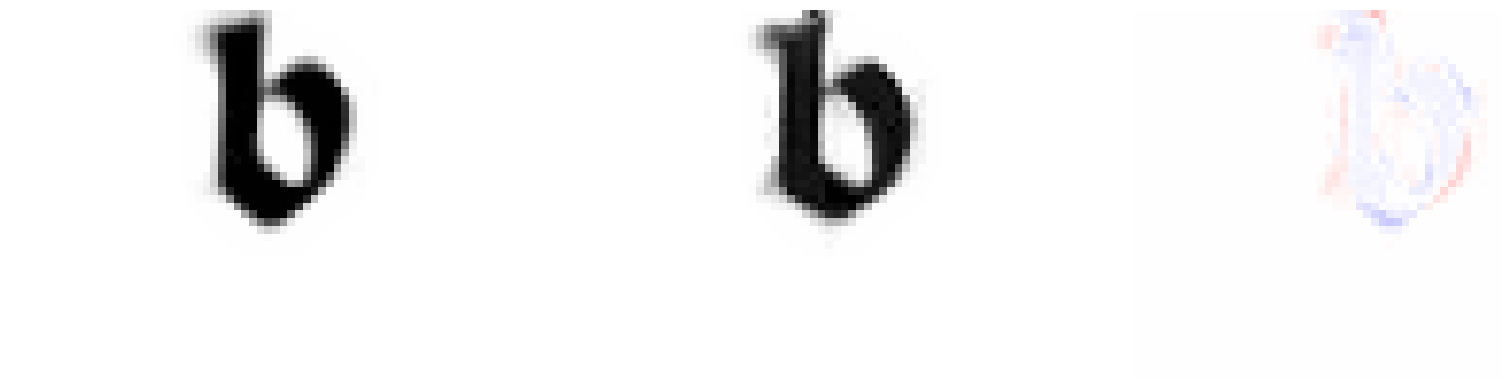

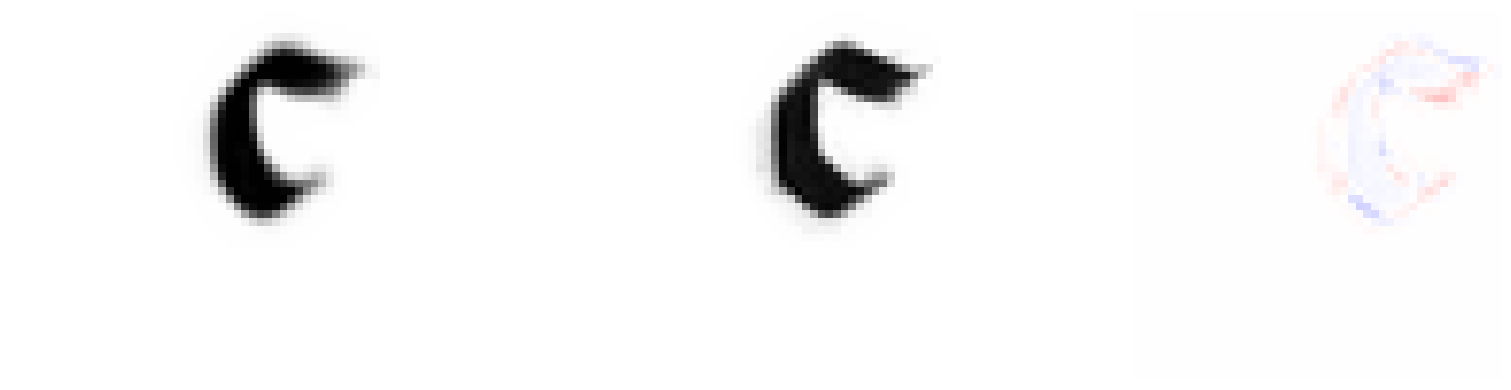

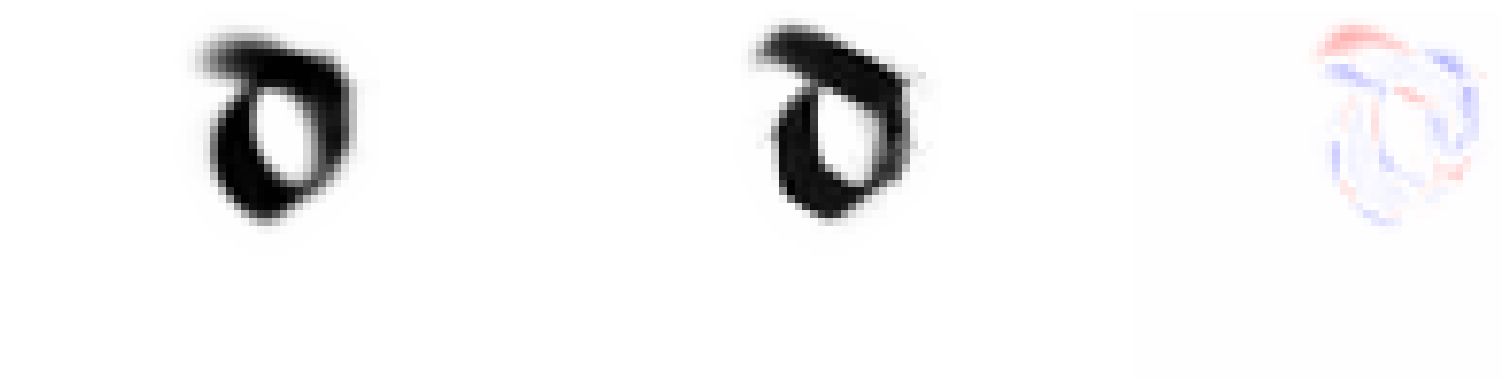

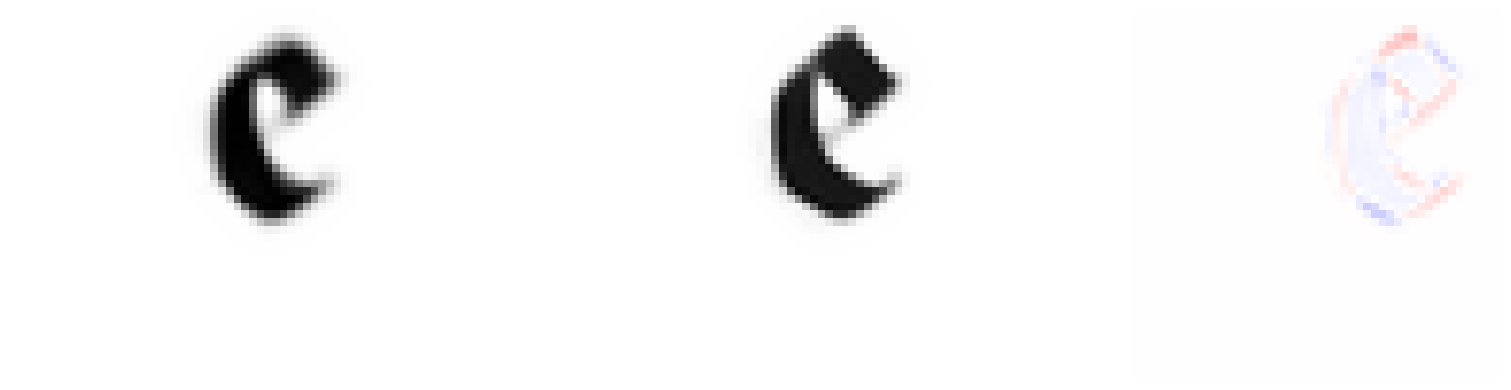

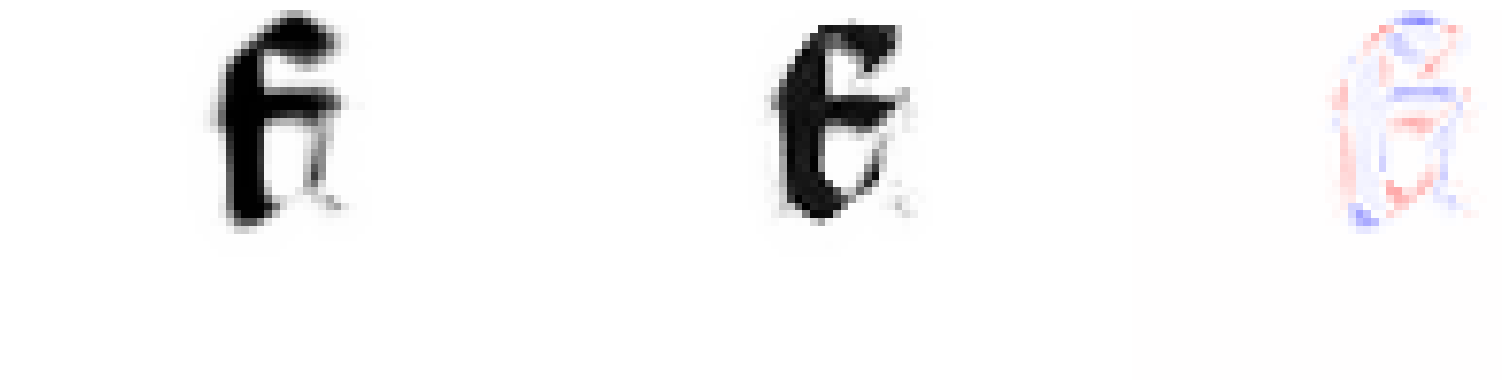

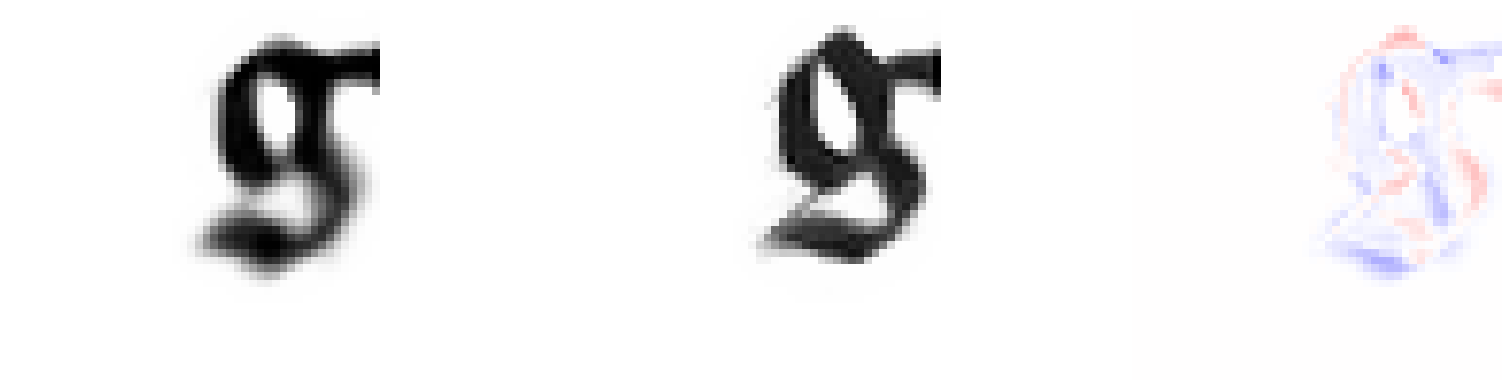

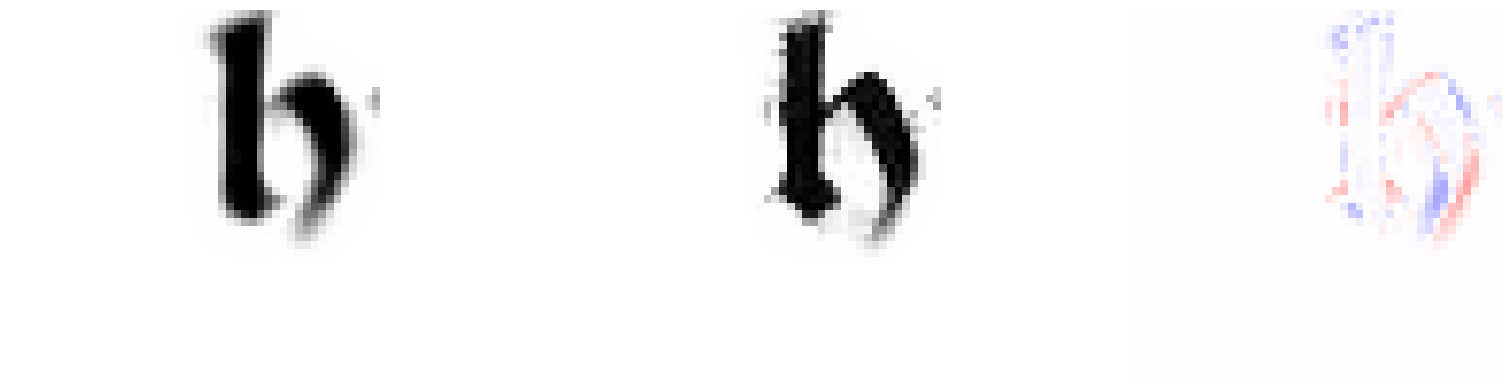

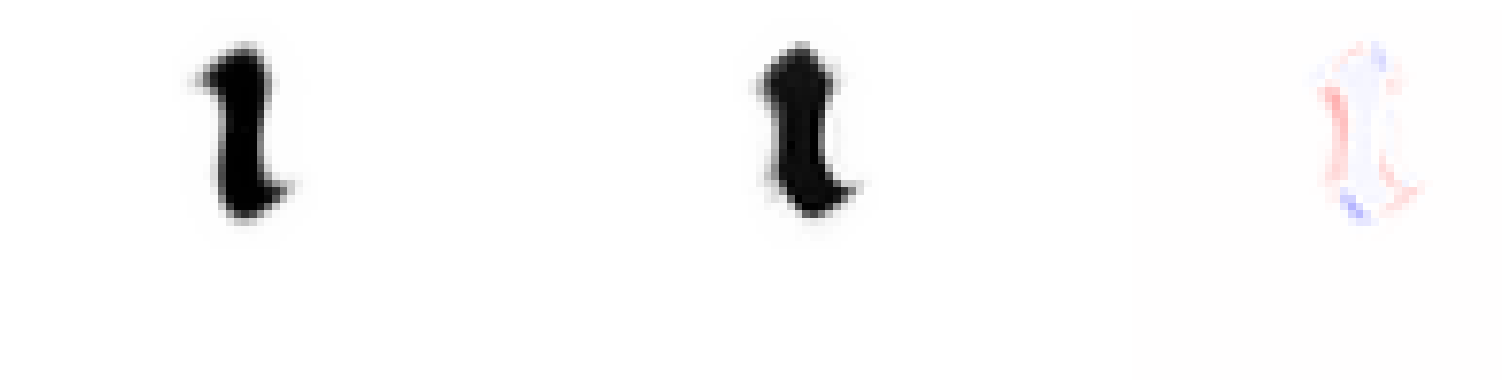

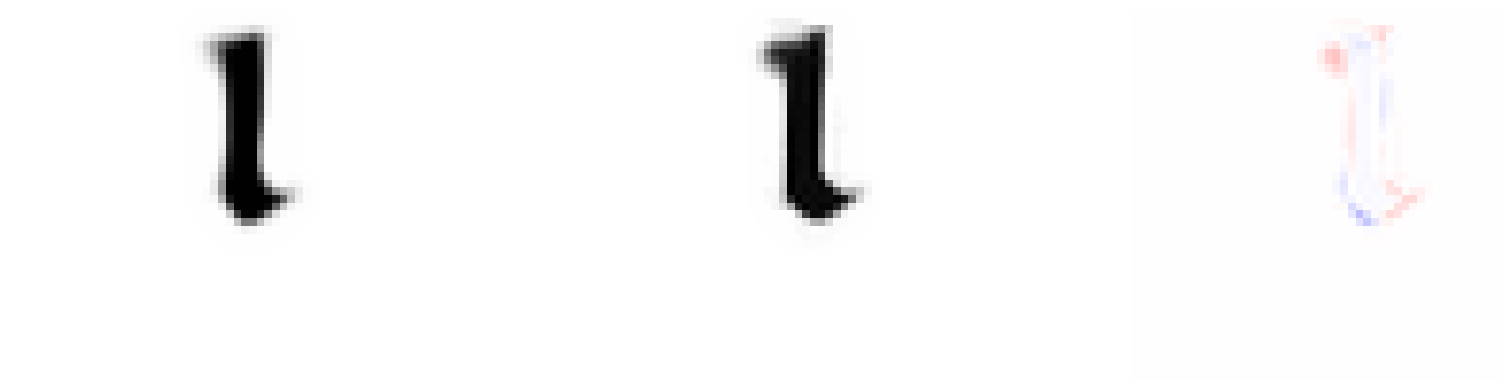

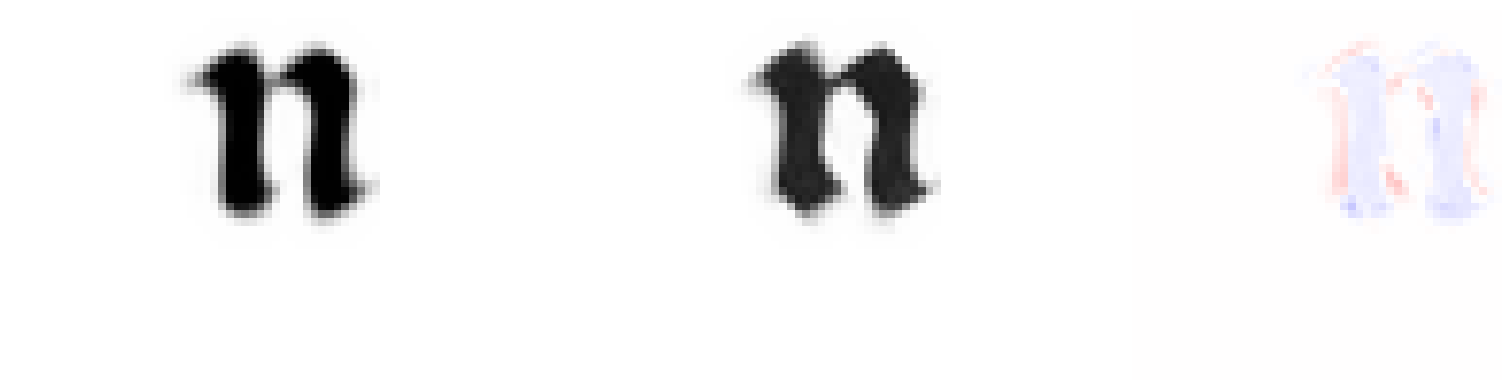

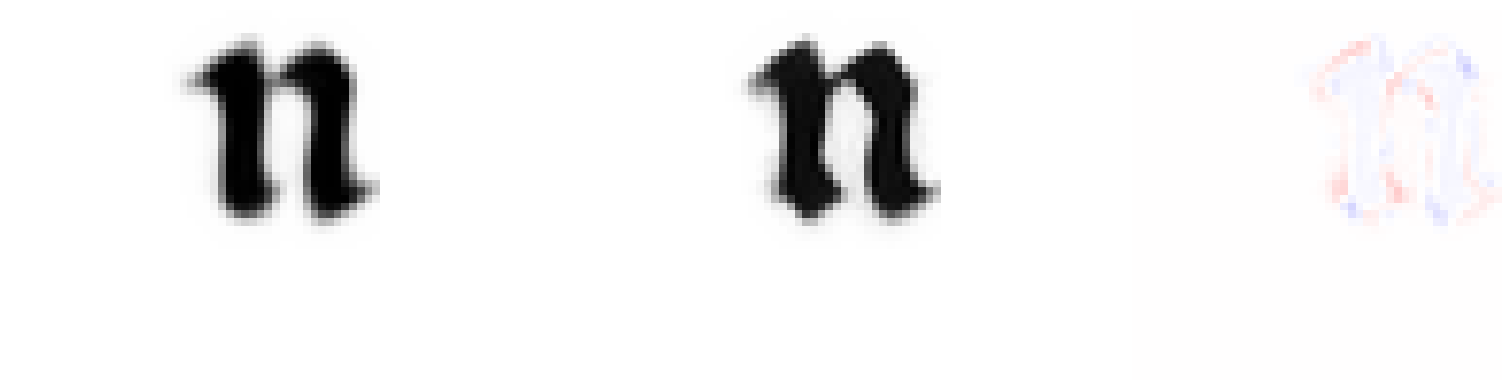

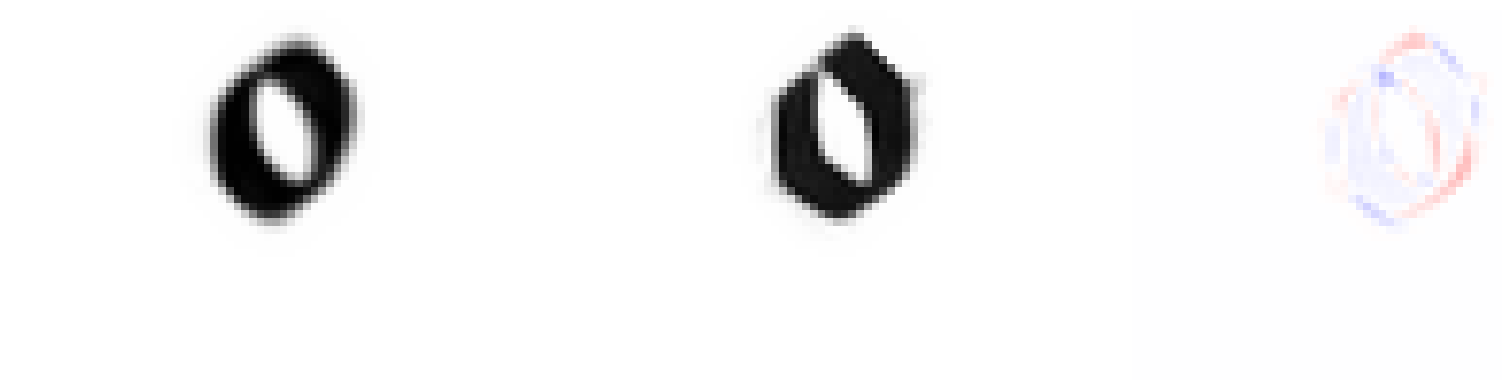

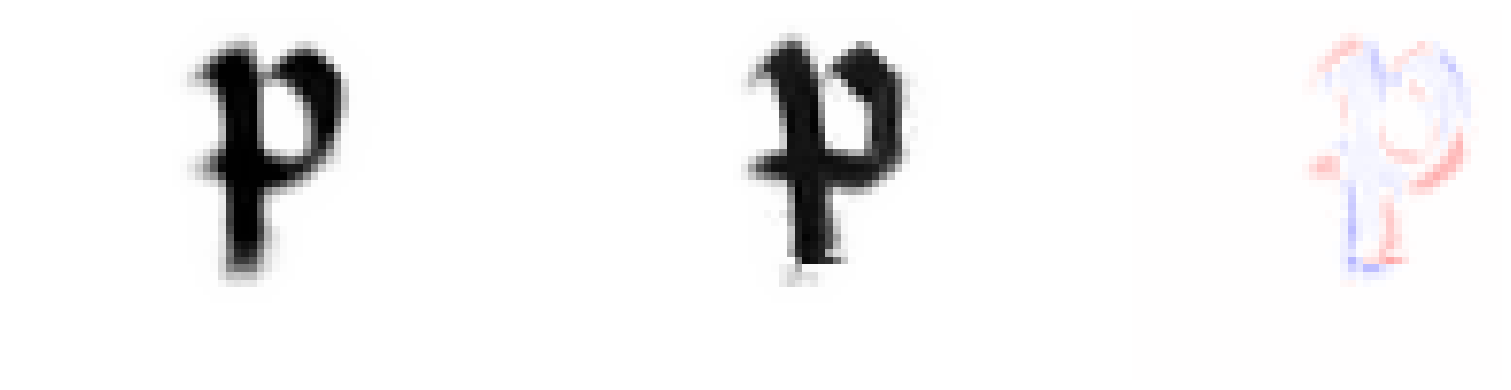

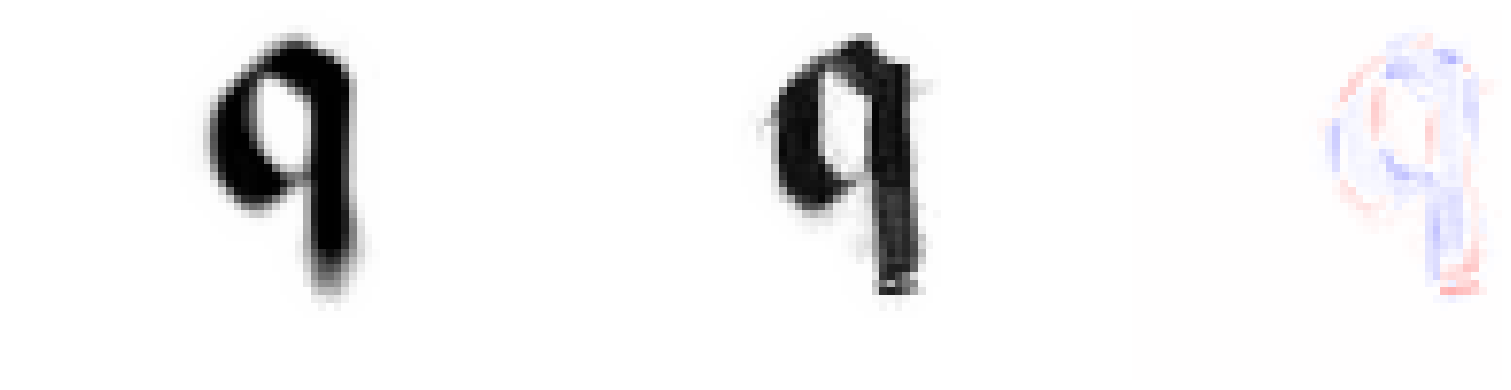

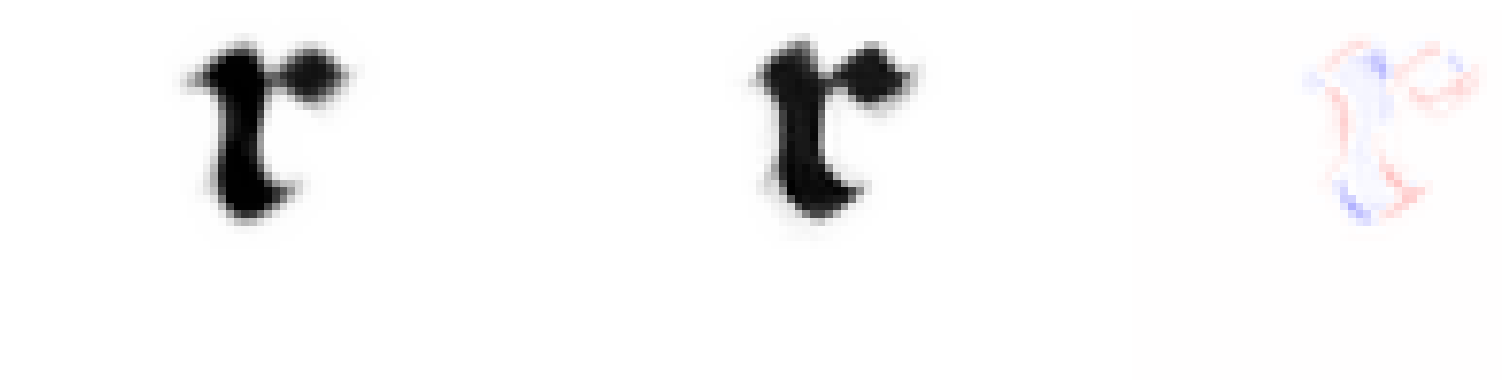

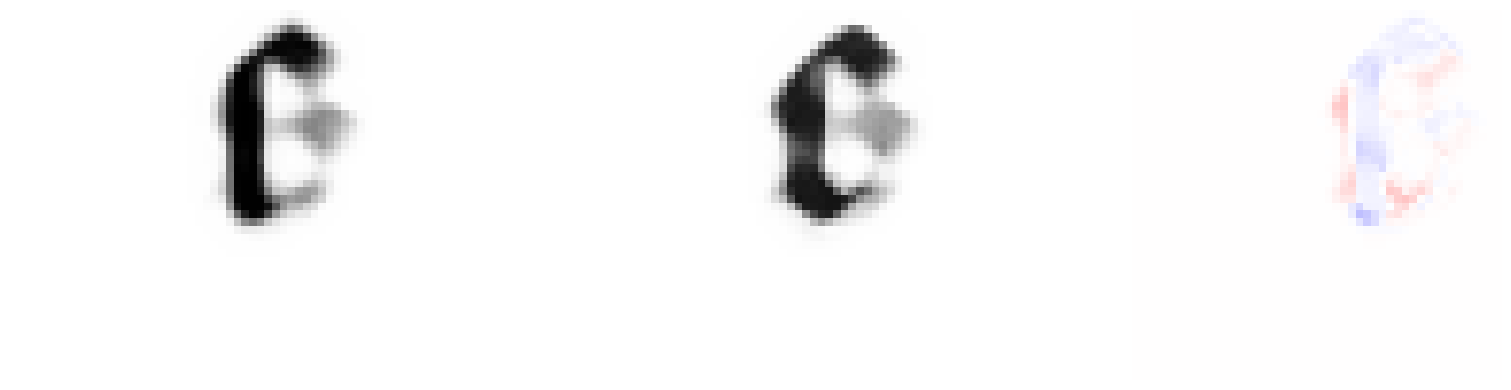

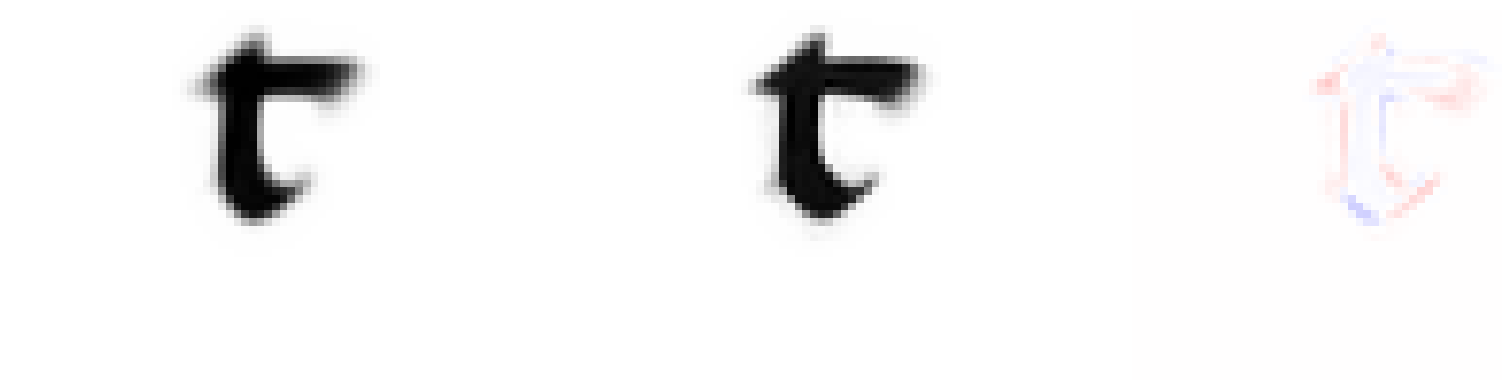

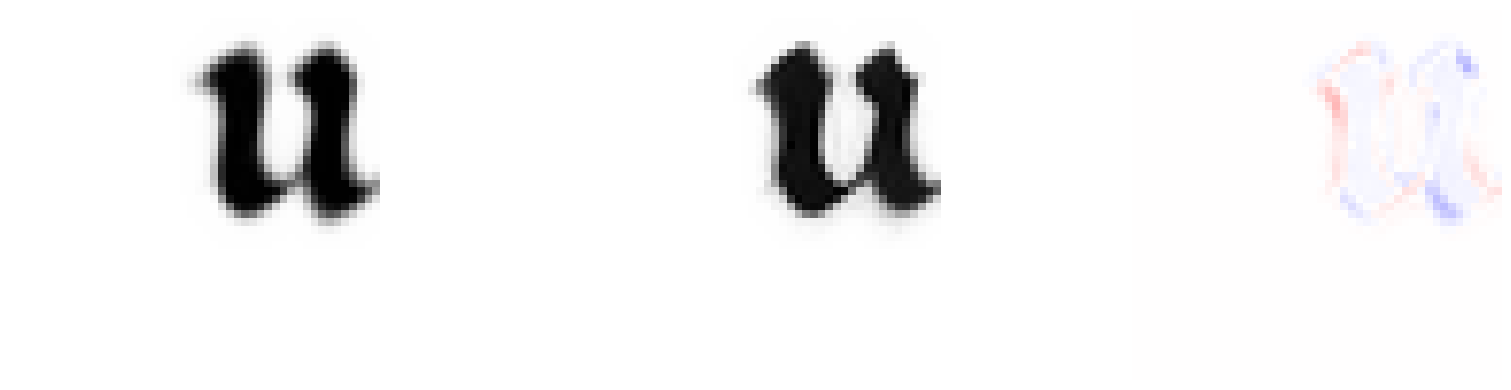

Processing folder: prototypes/filtered/Arras-861


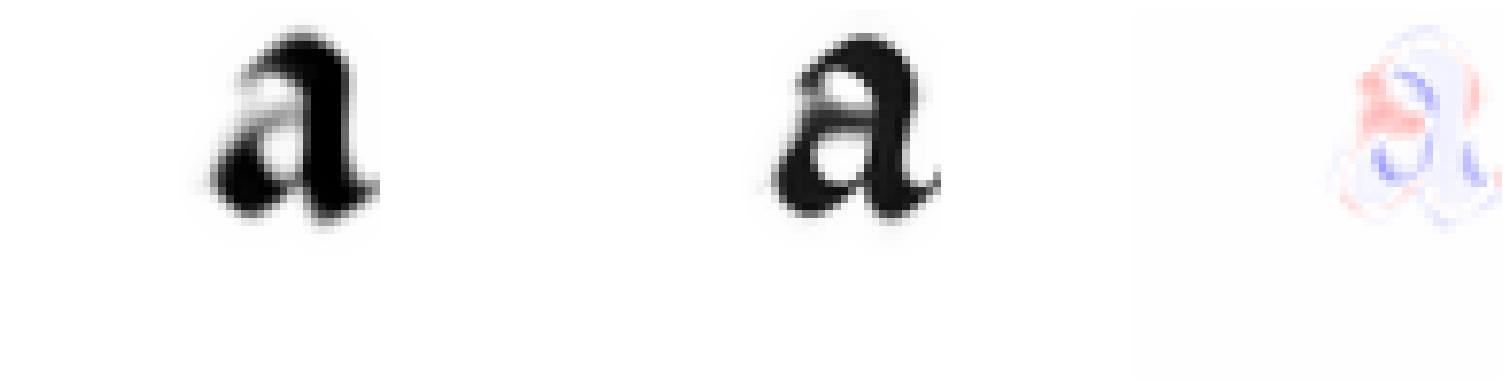

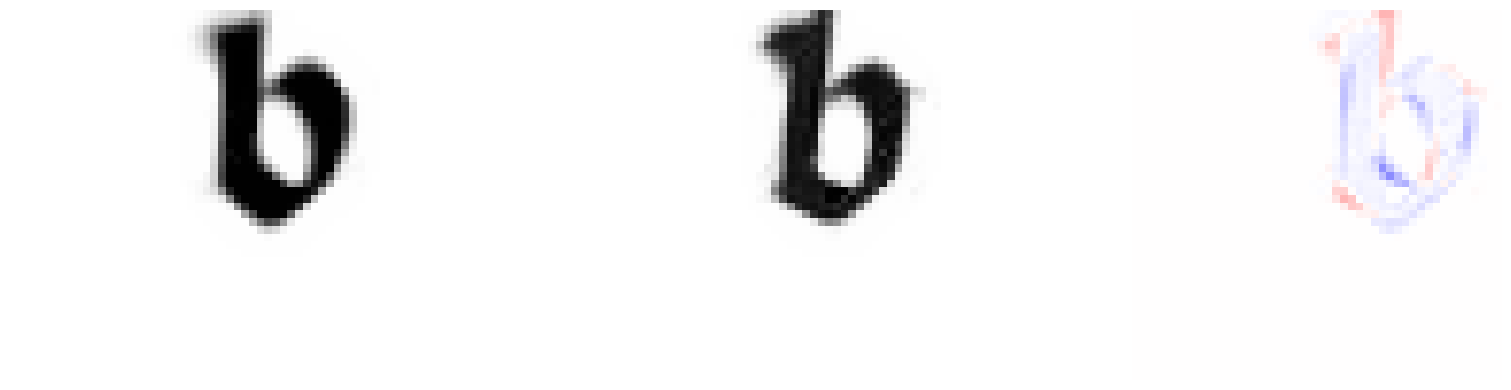

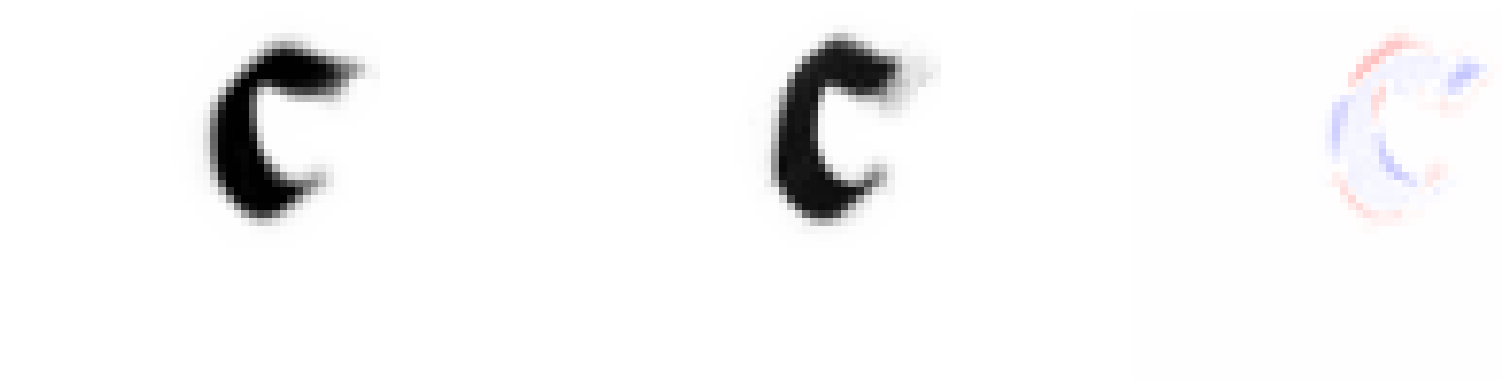

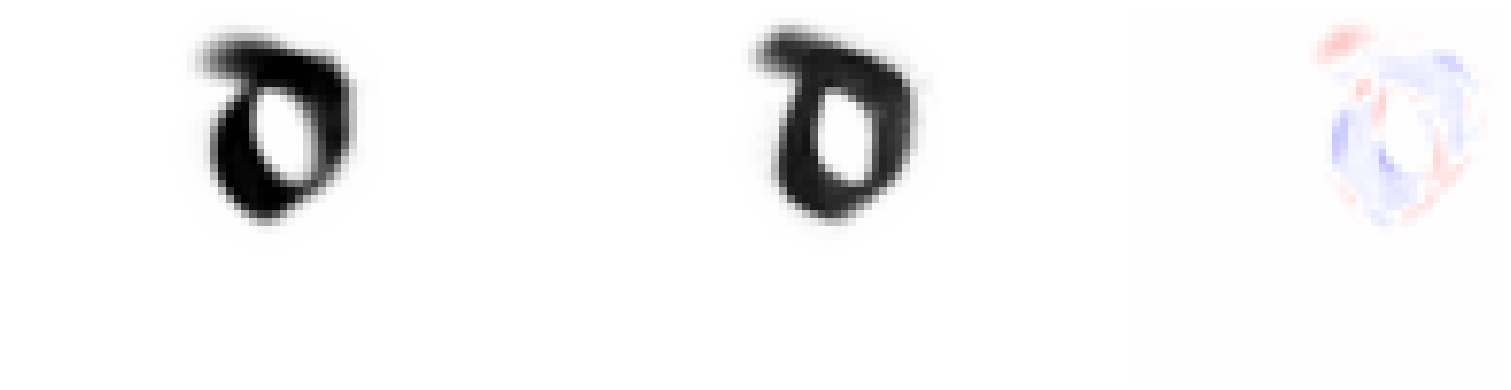

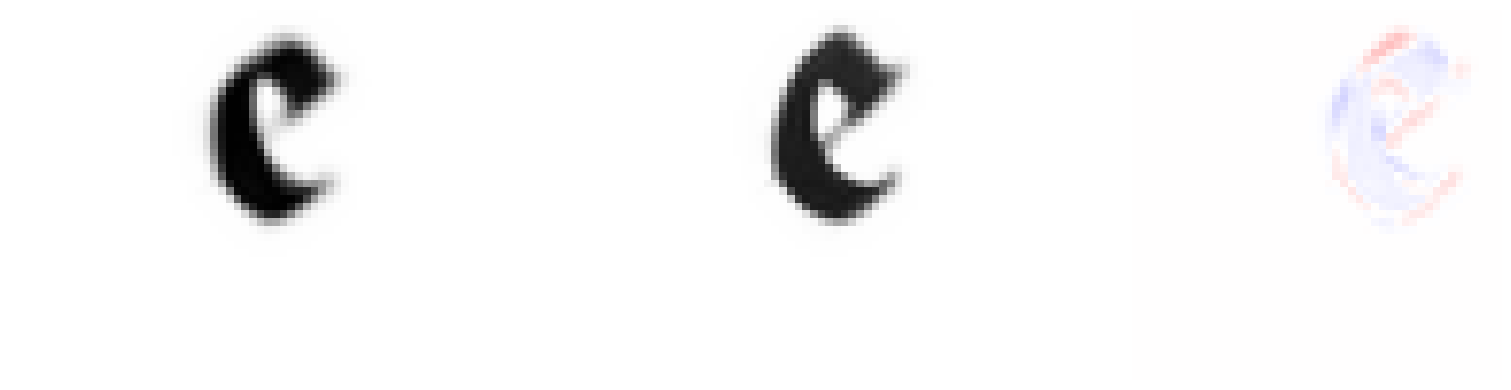

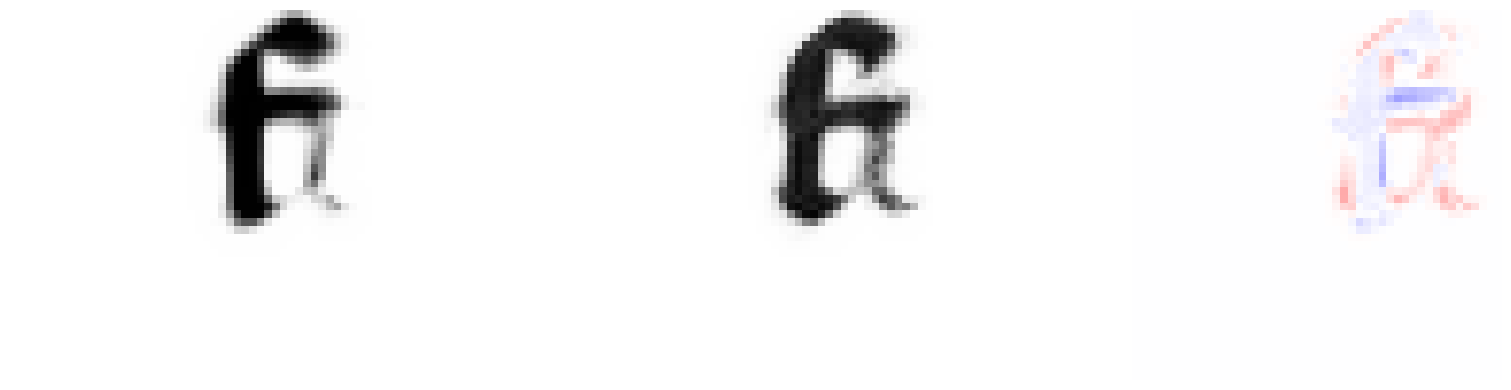

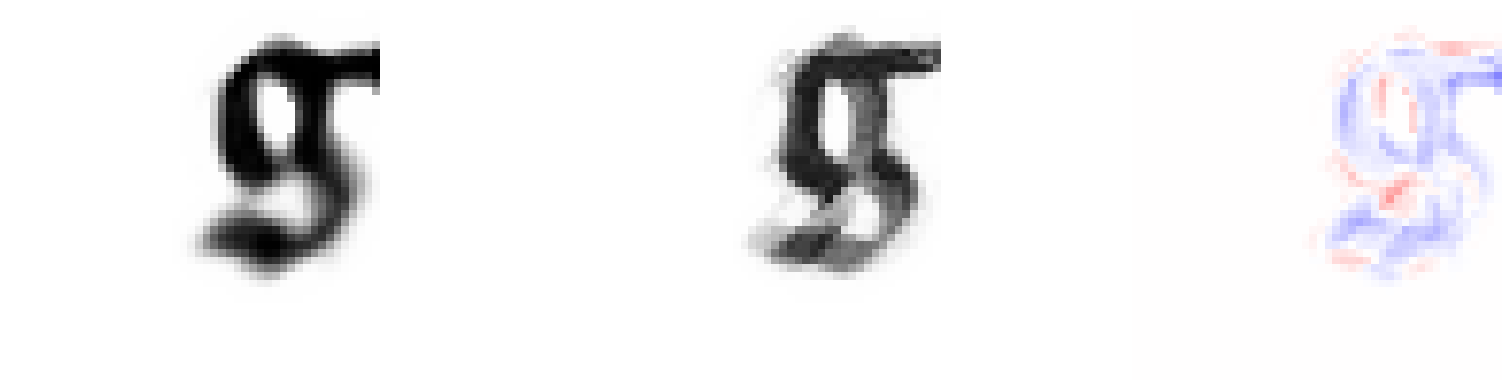

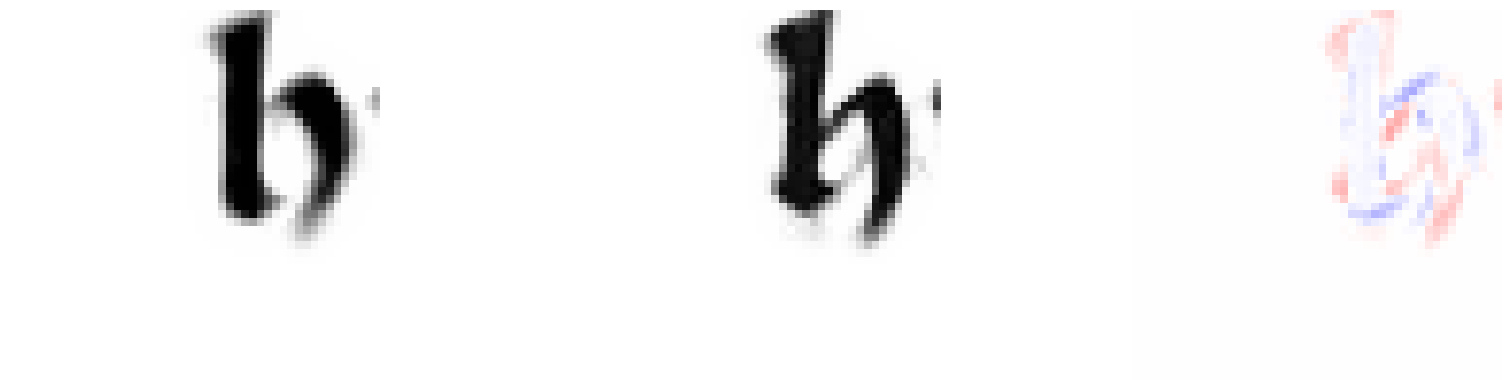

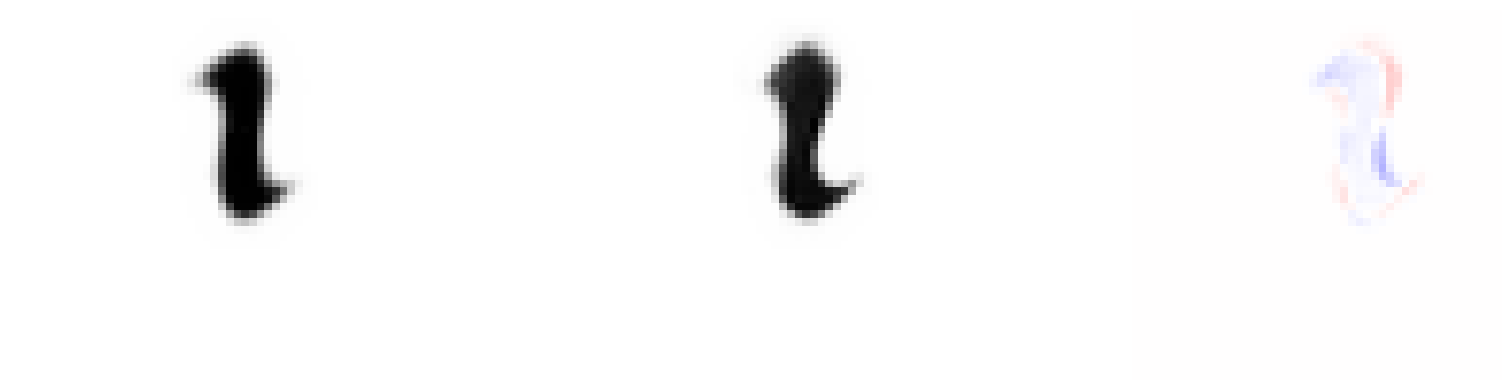

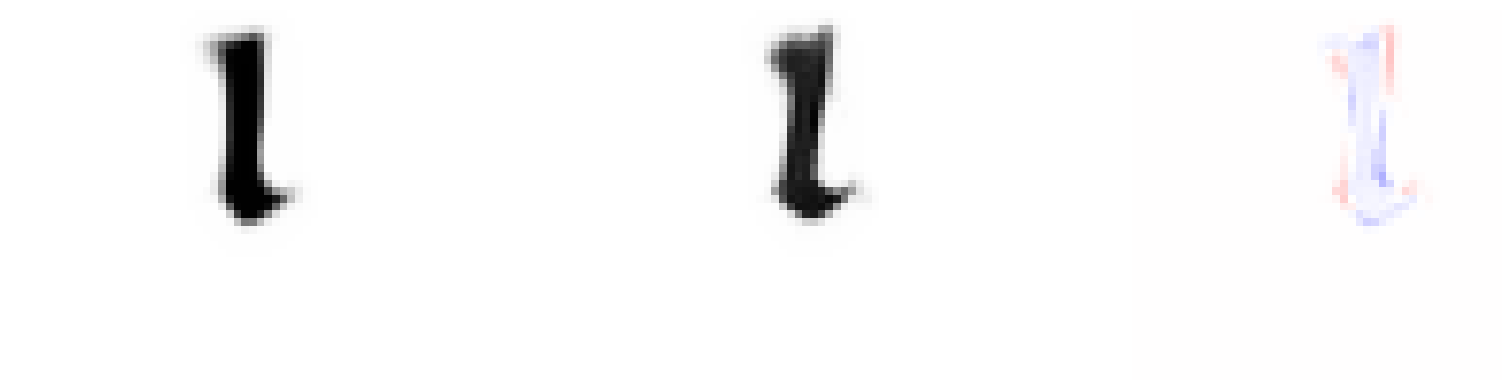

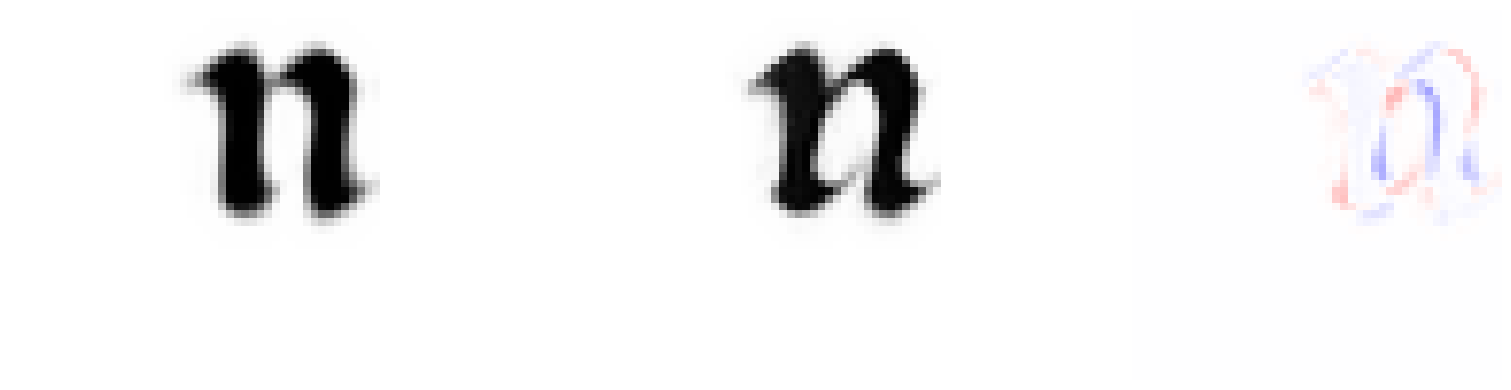

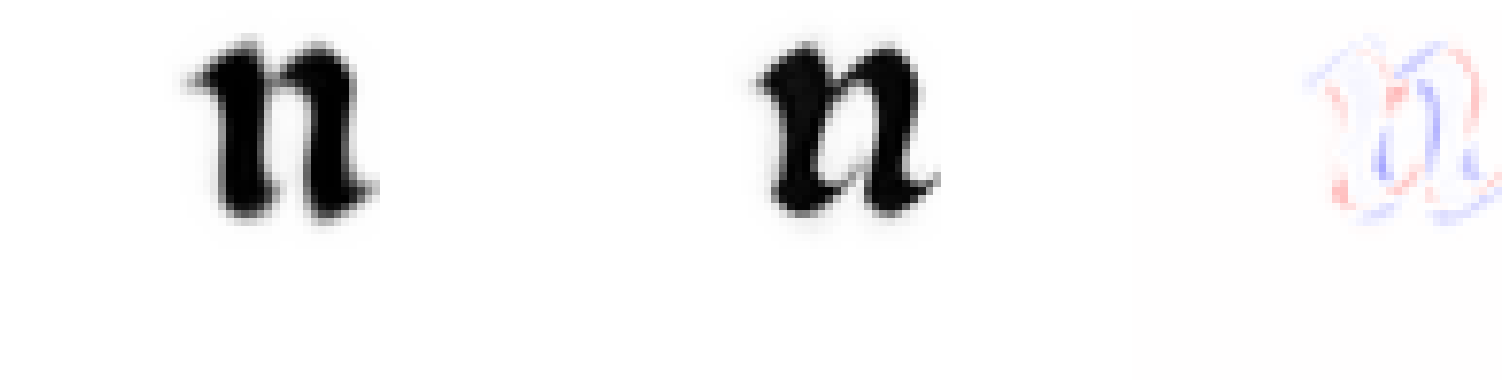

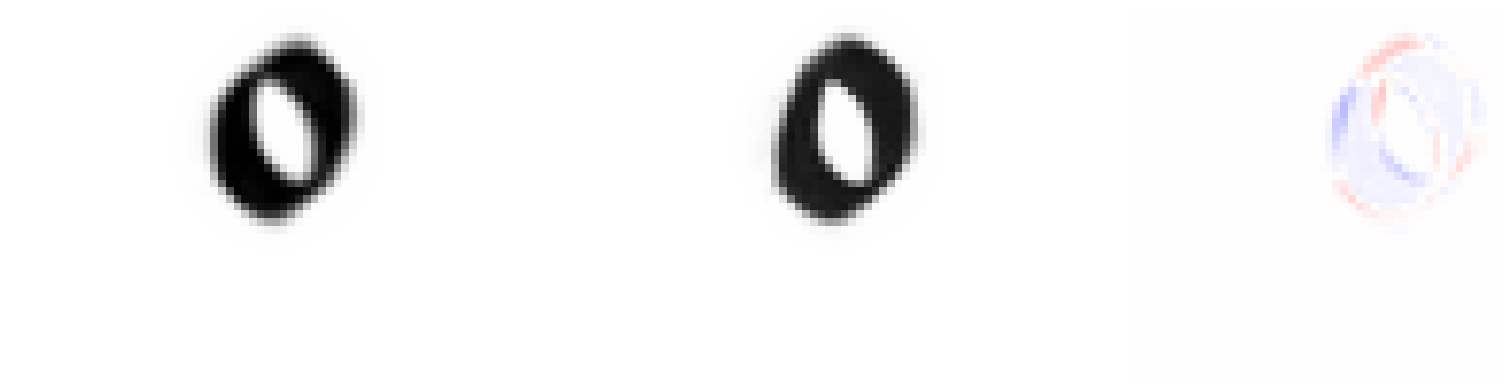

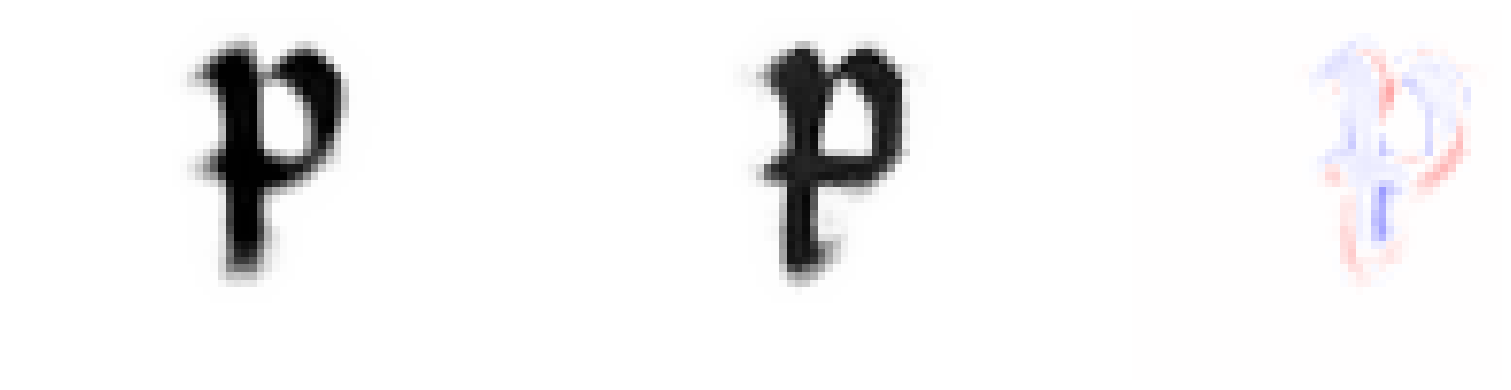

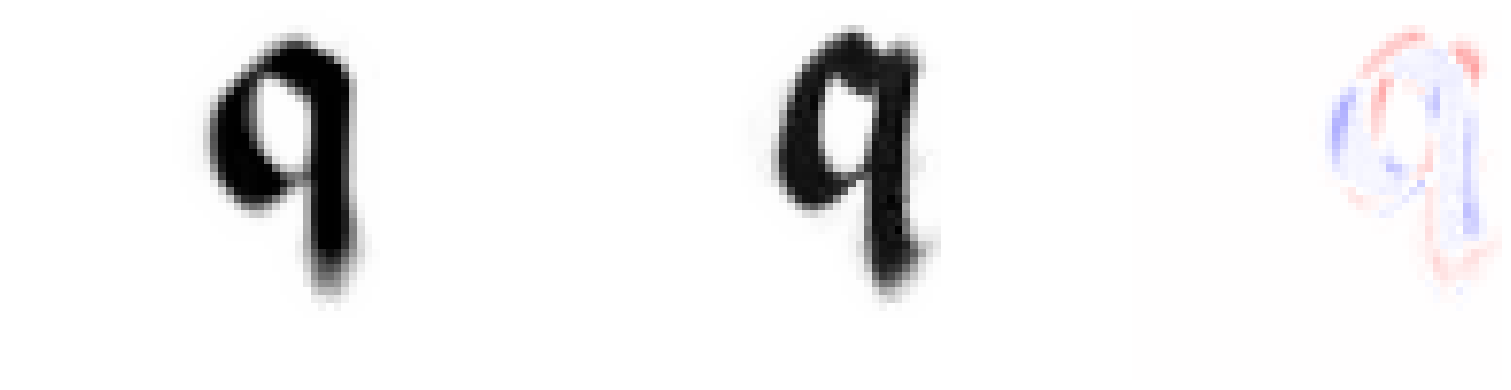

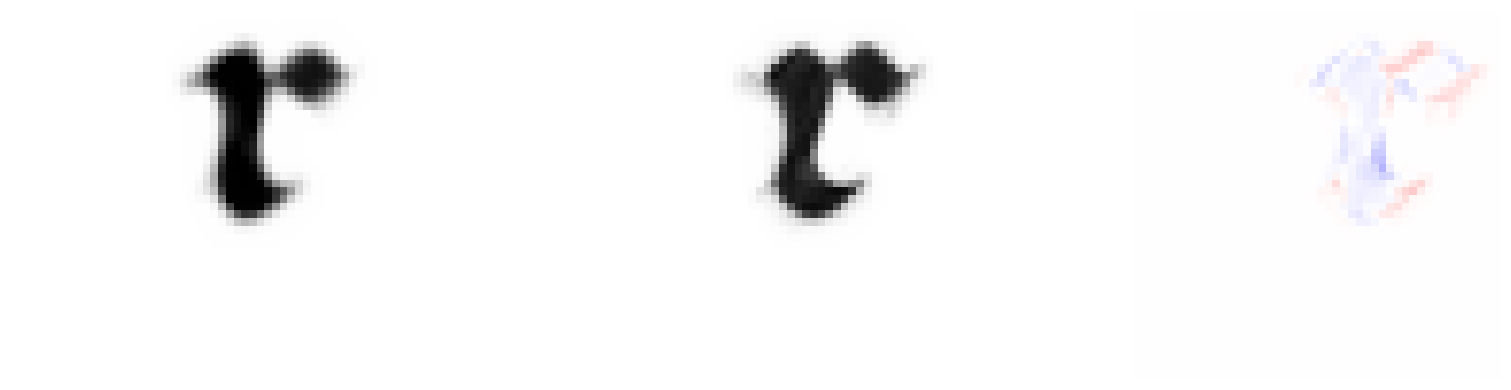

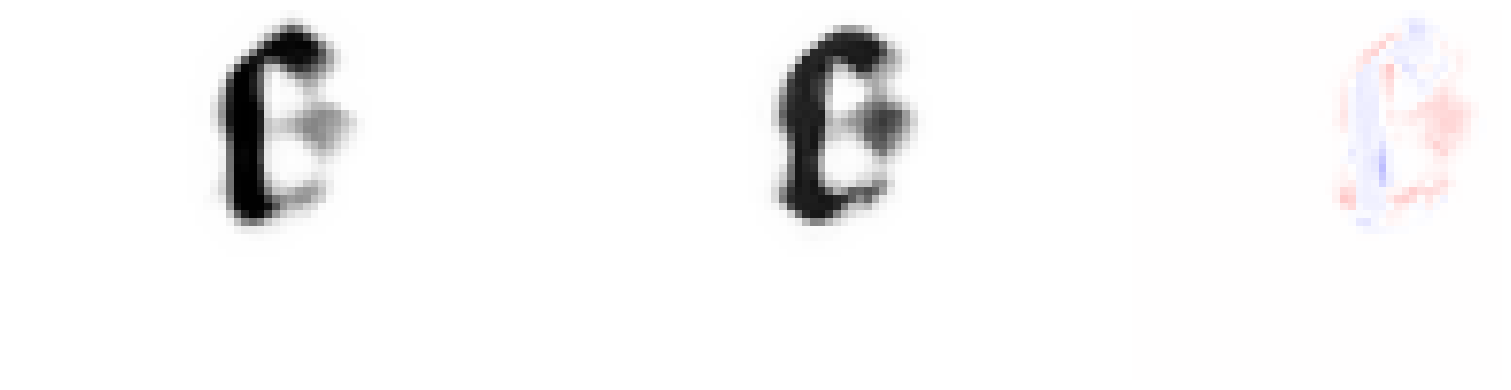

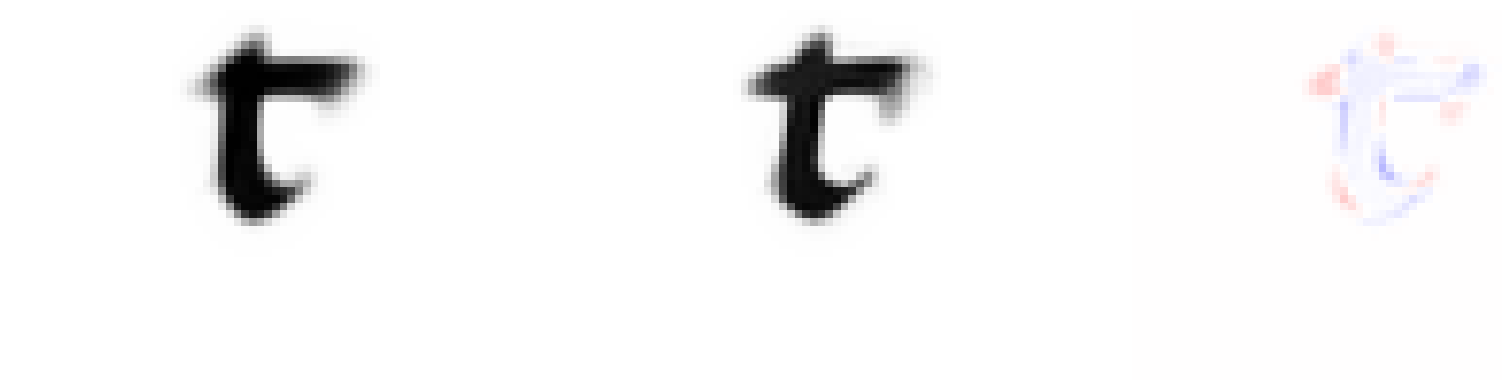

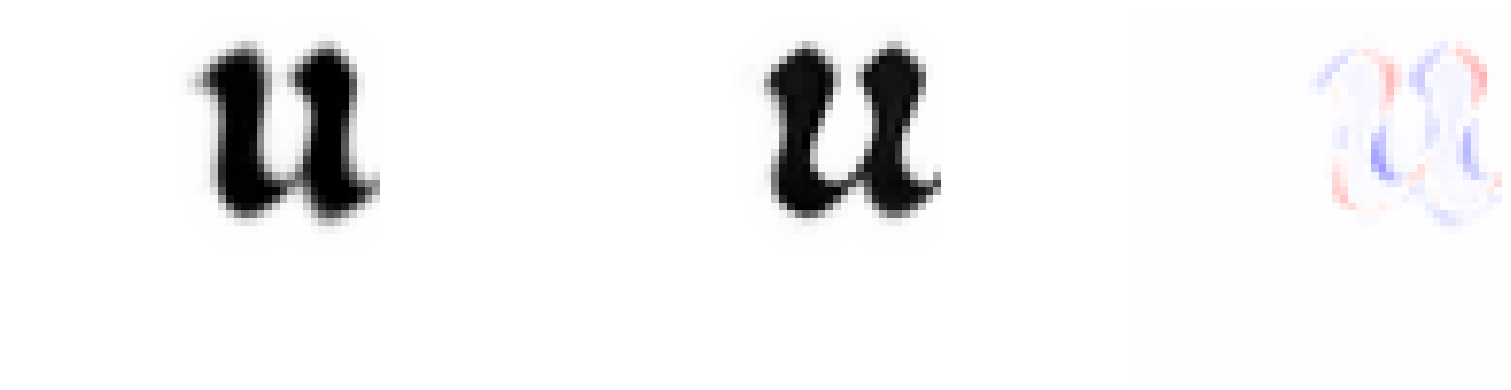

Processing folder: prototypes/filtered/btv1b84473026


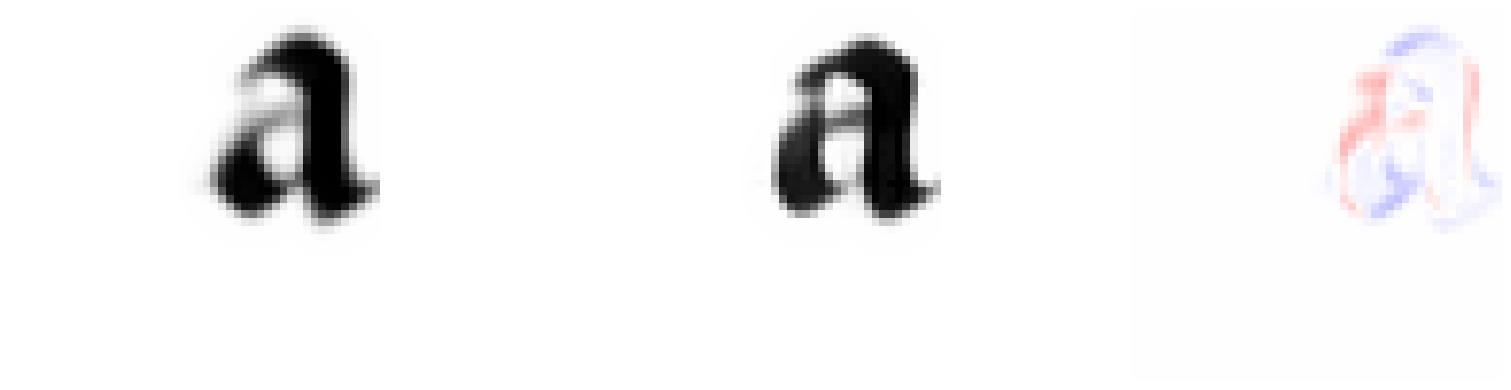

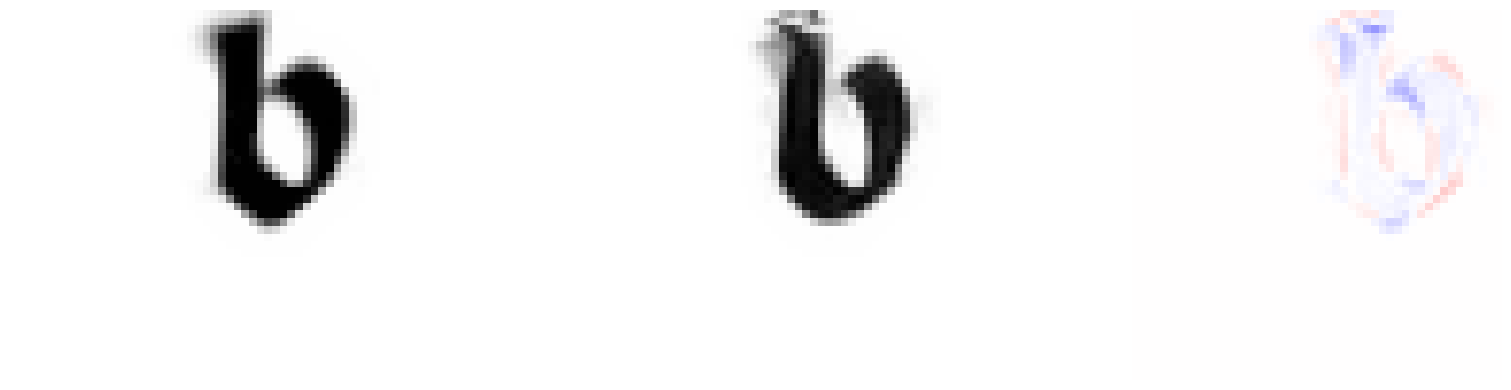

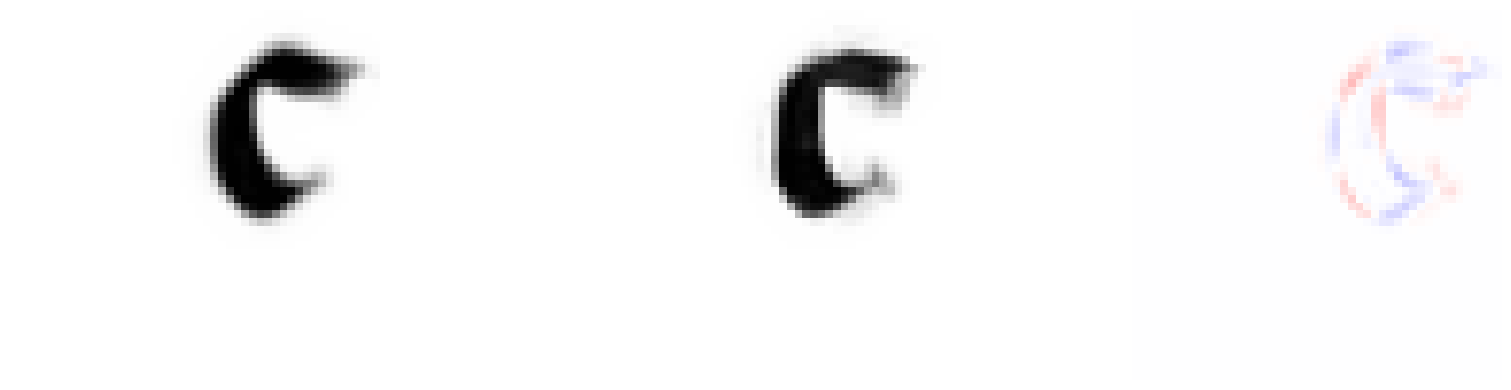

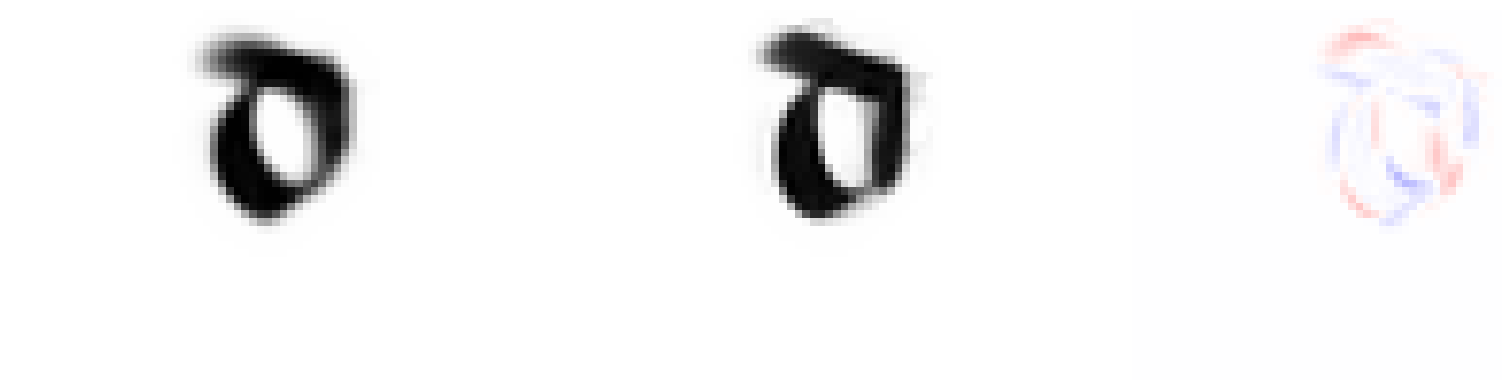

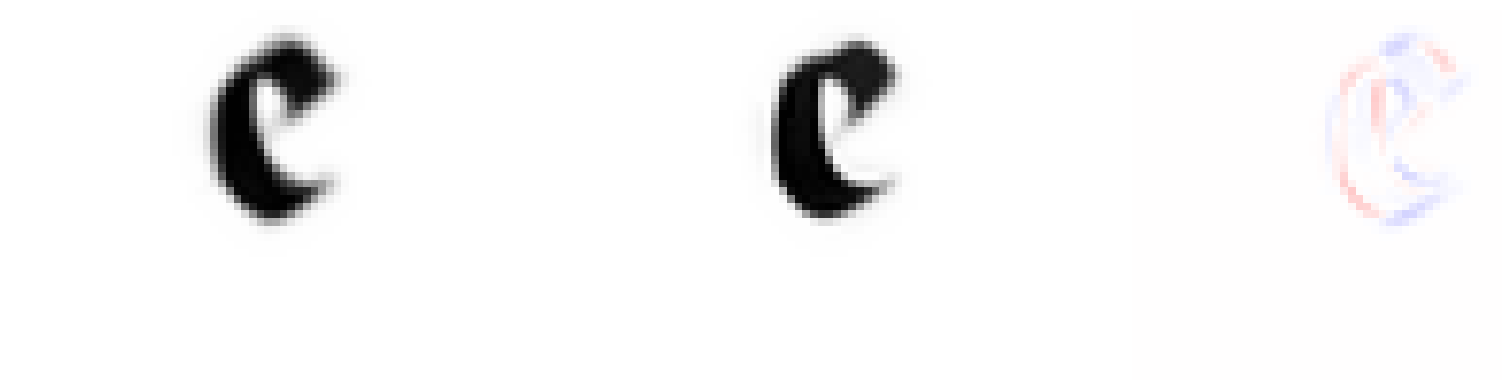

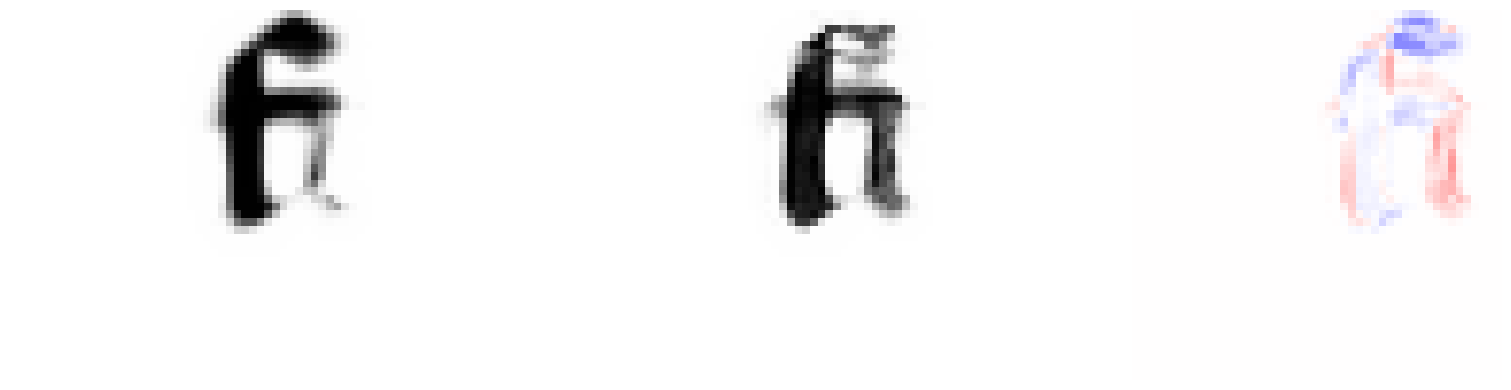

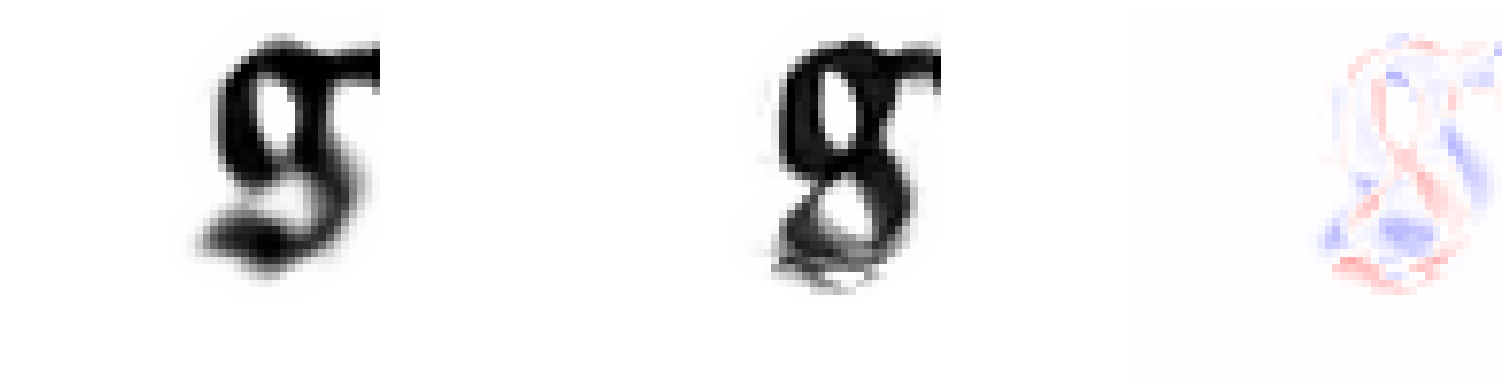

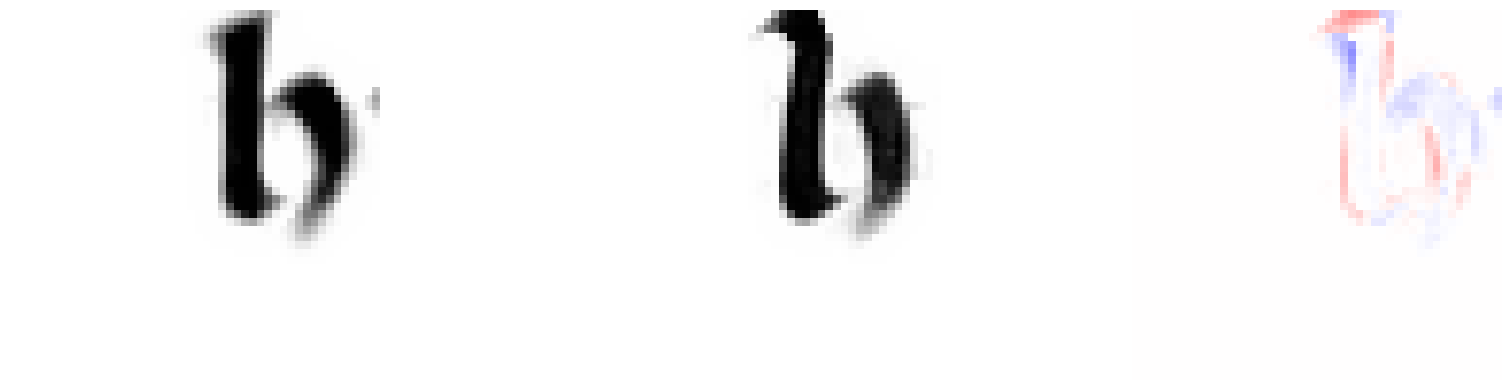

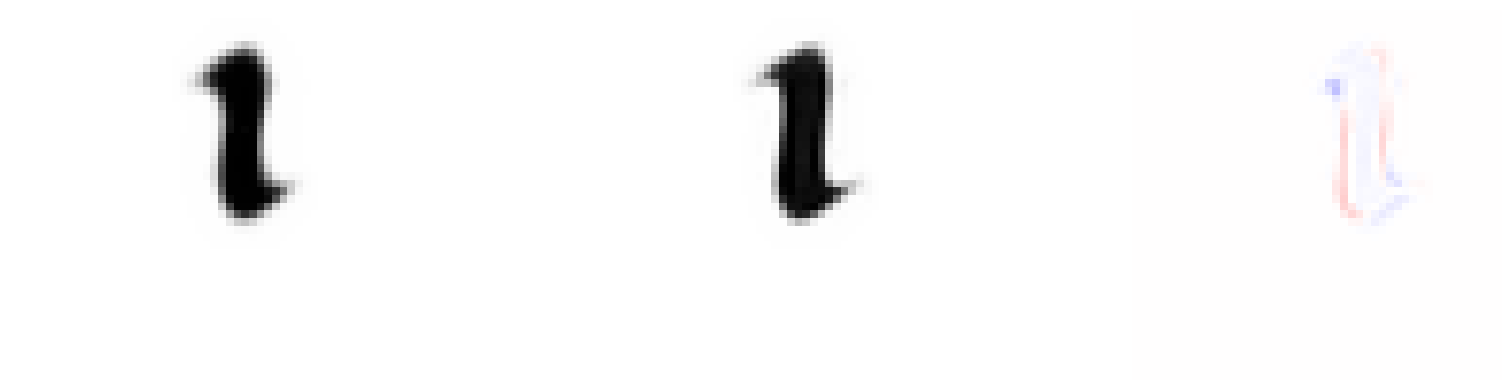

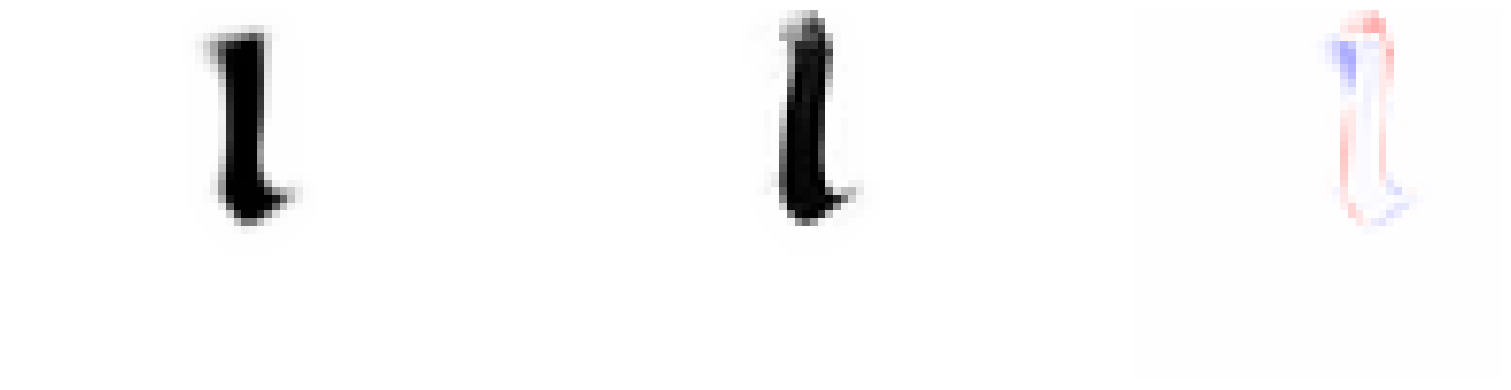

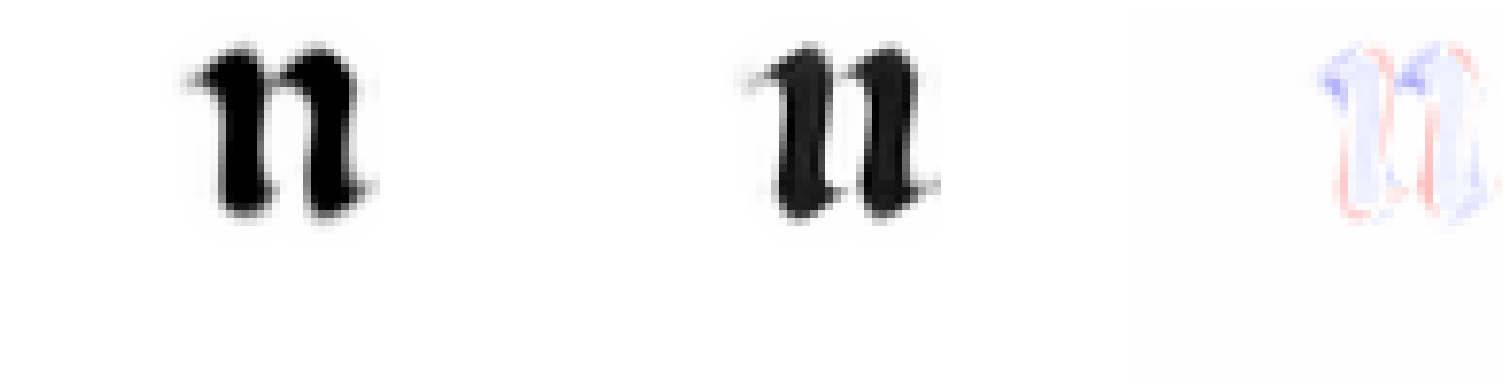

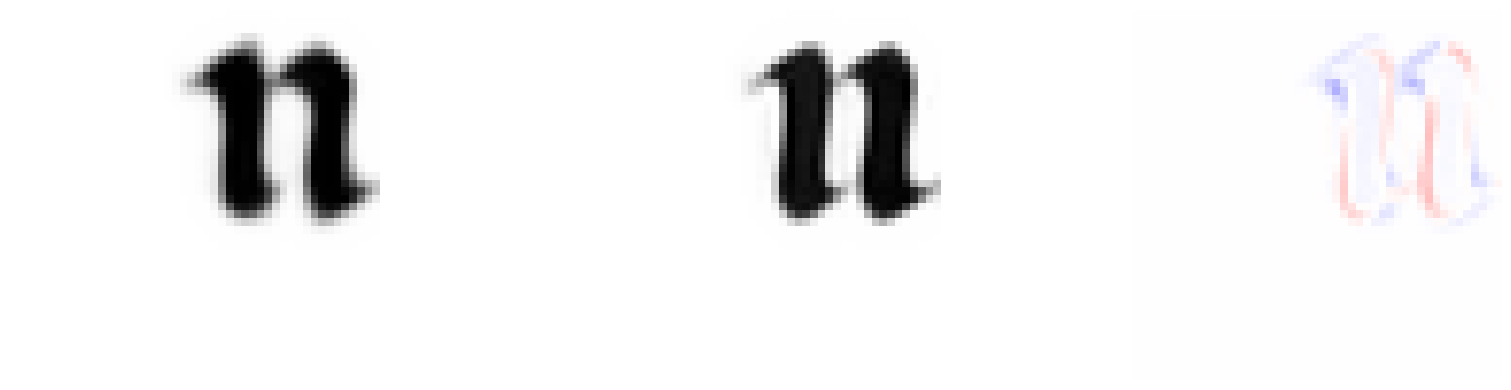

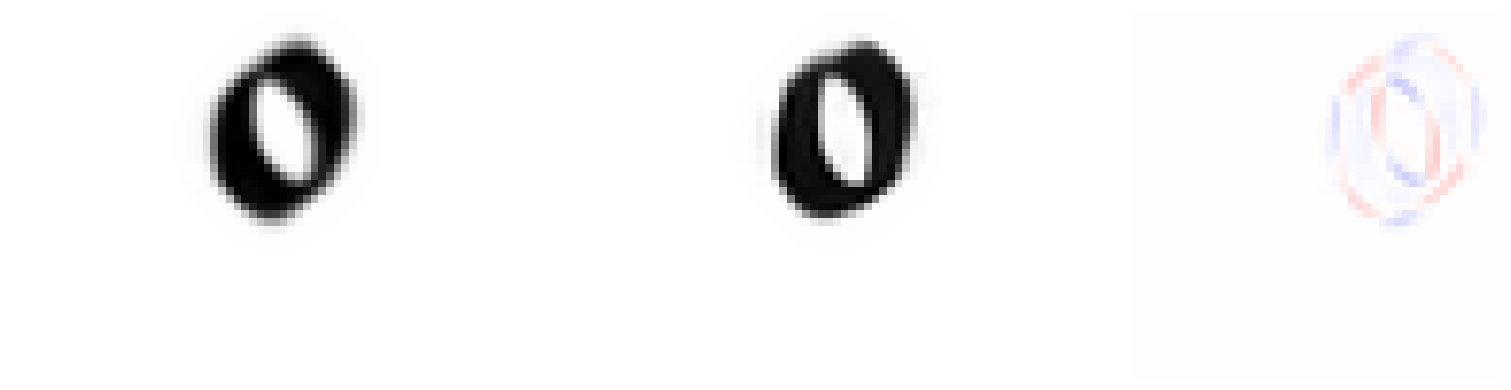

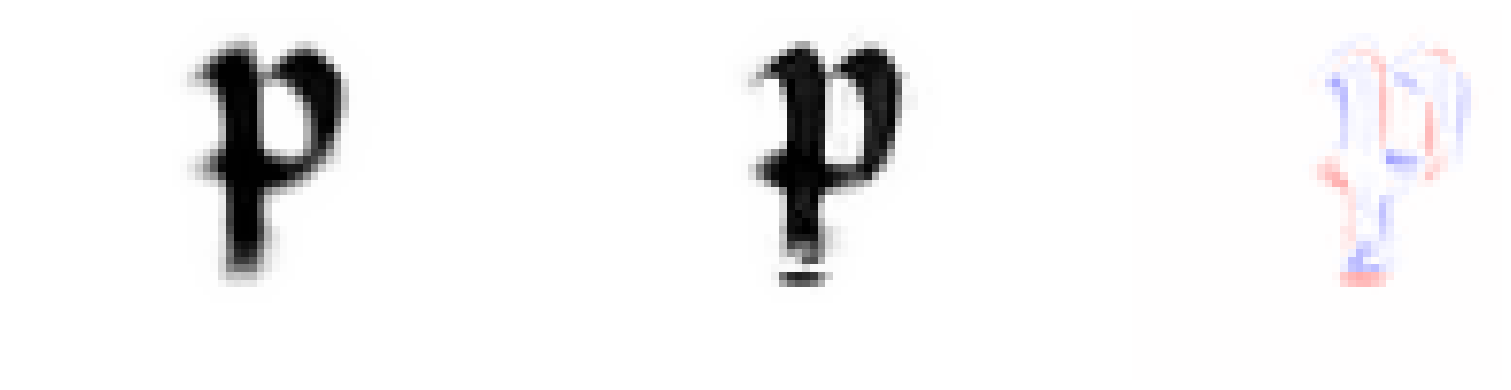

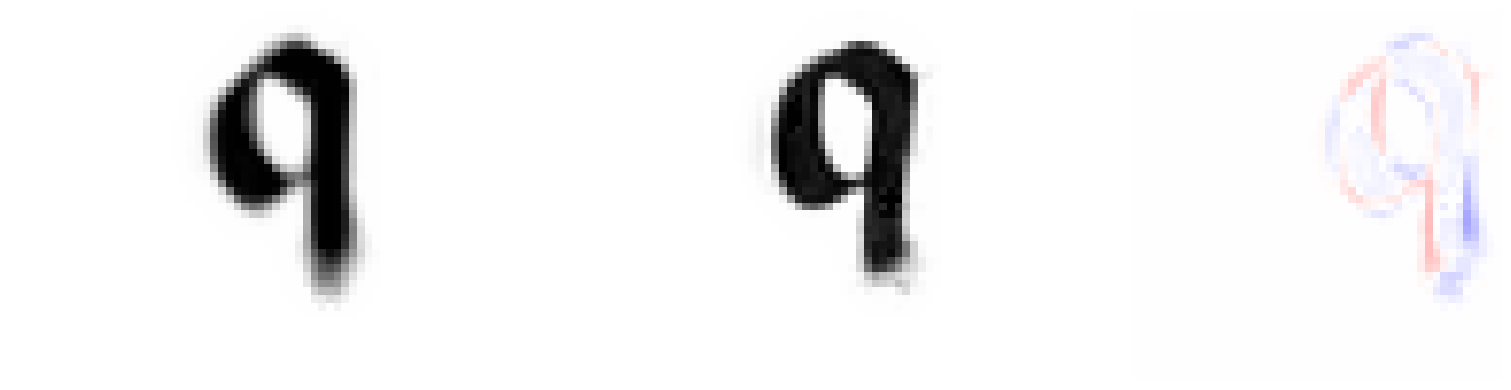

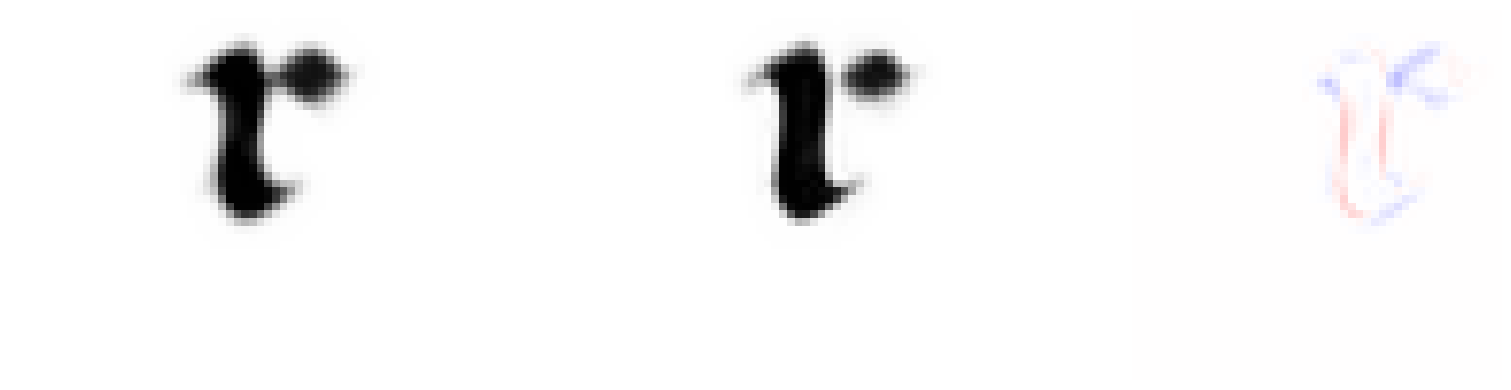

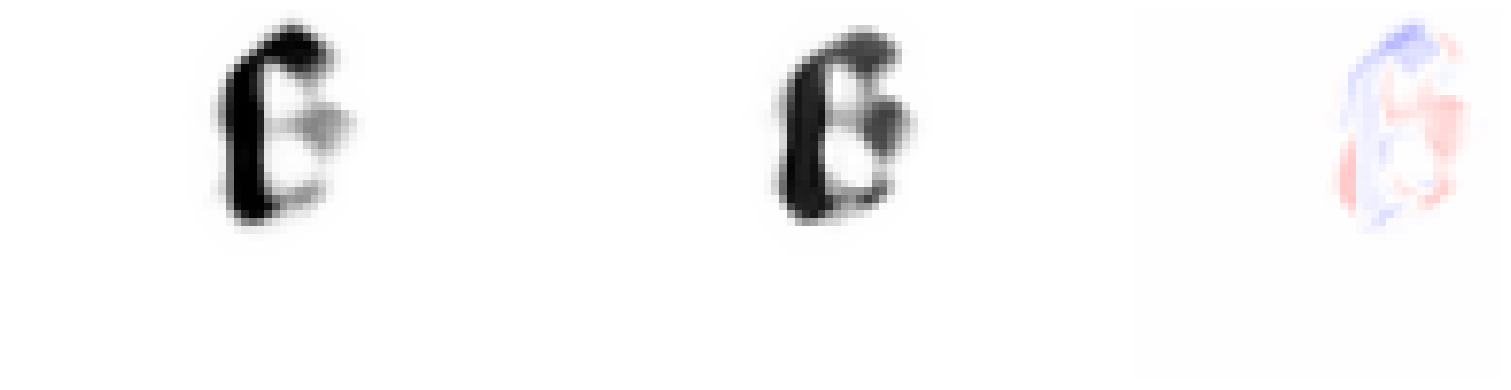

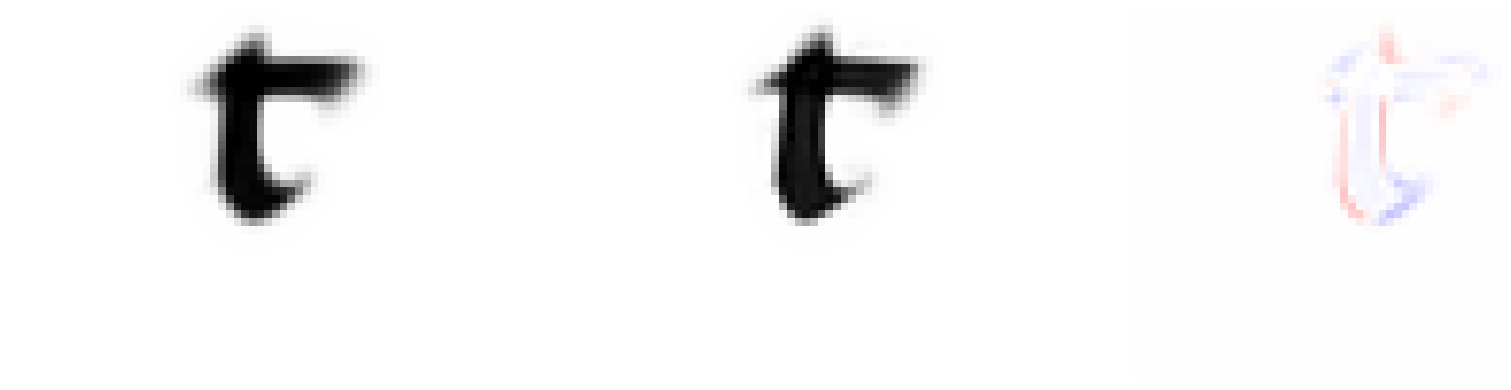

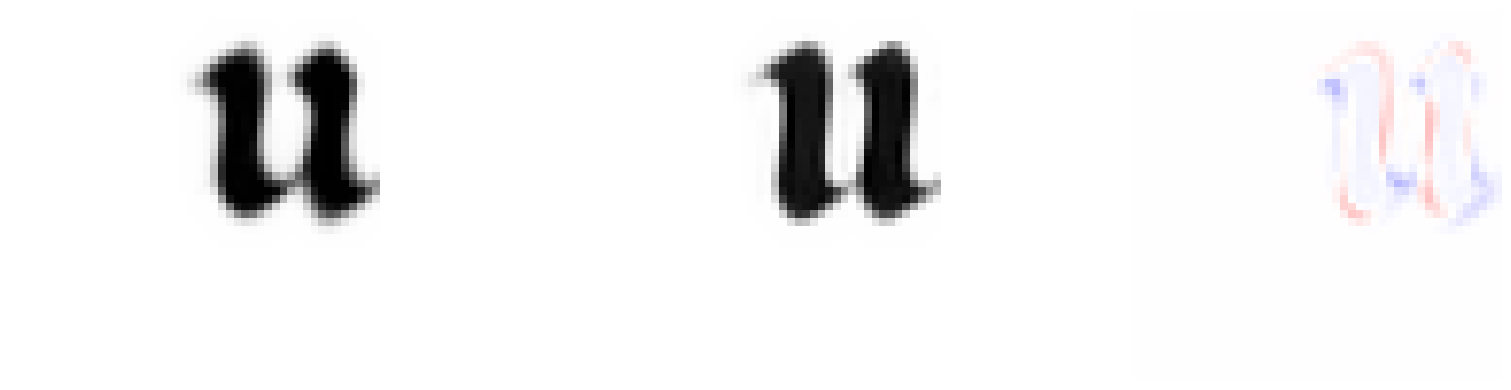

Processing folder: prototypes/filtered/btv1b8455783p


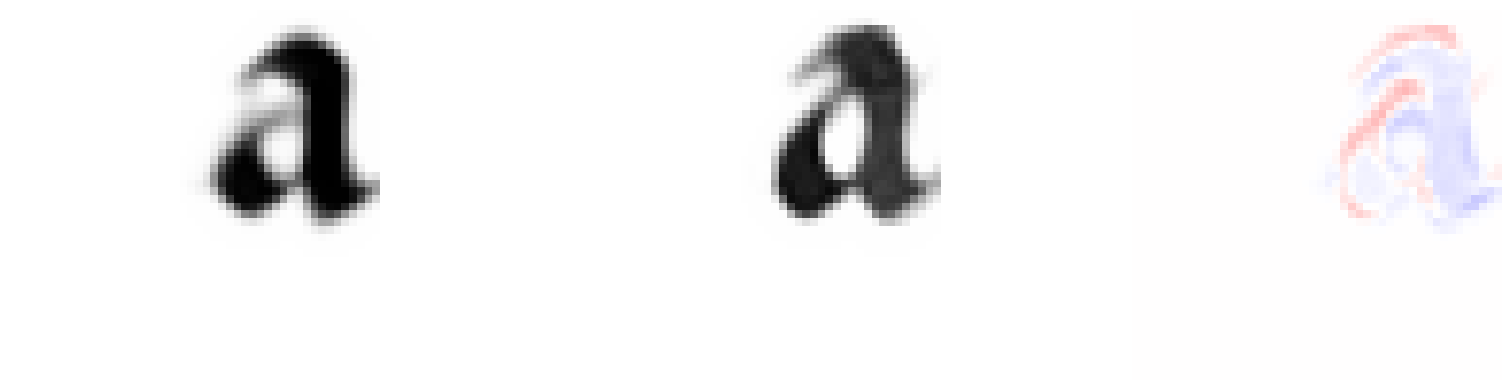

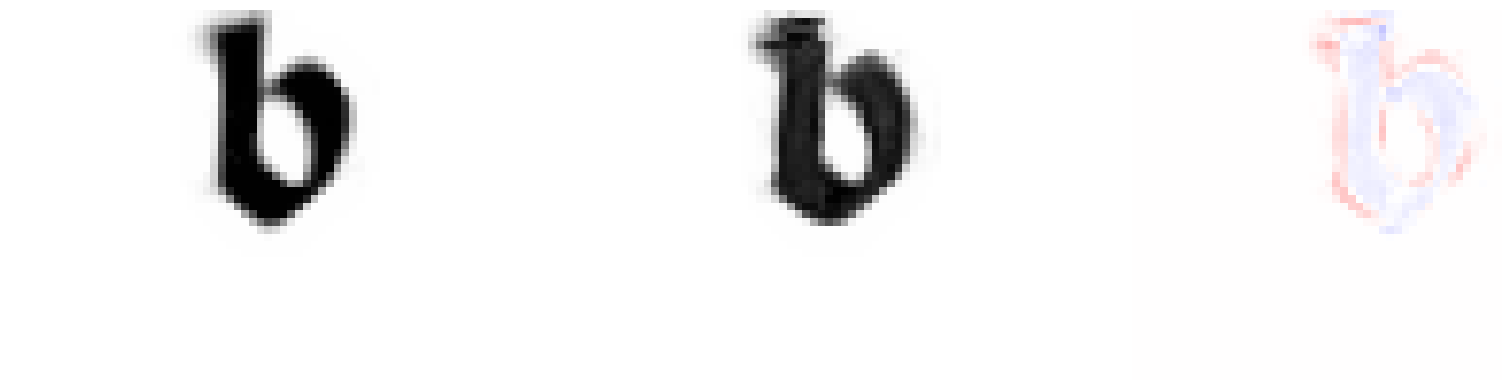

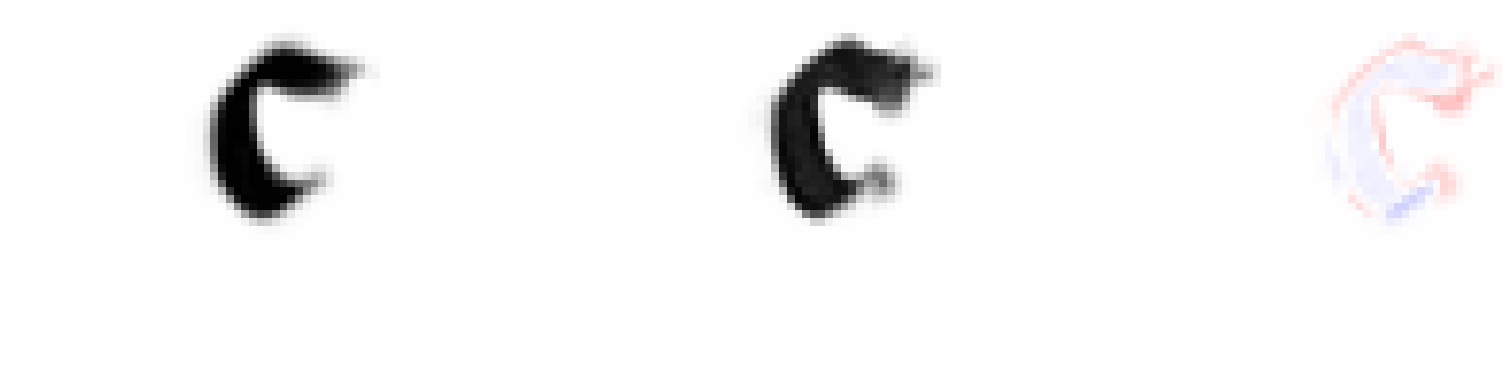

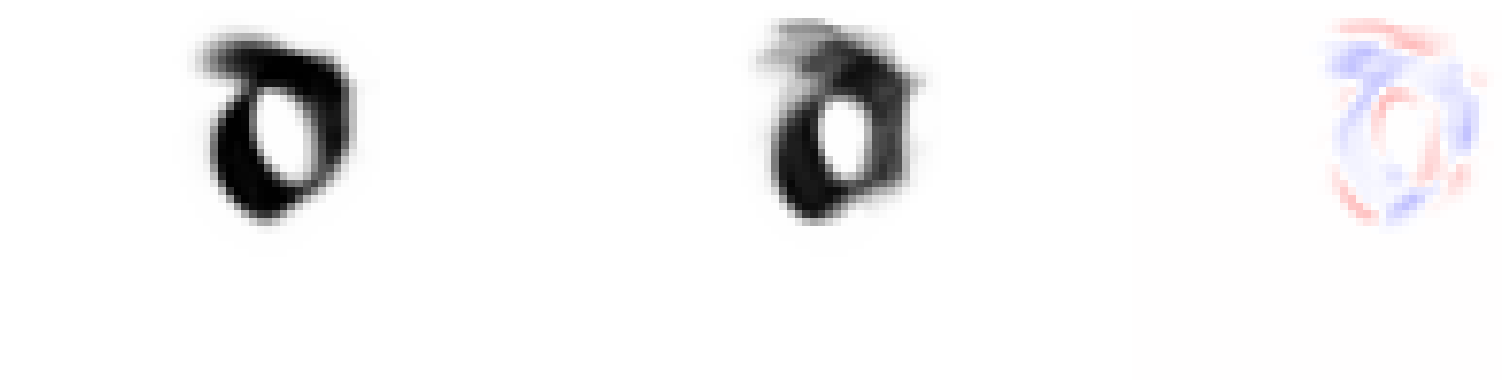

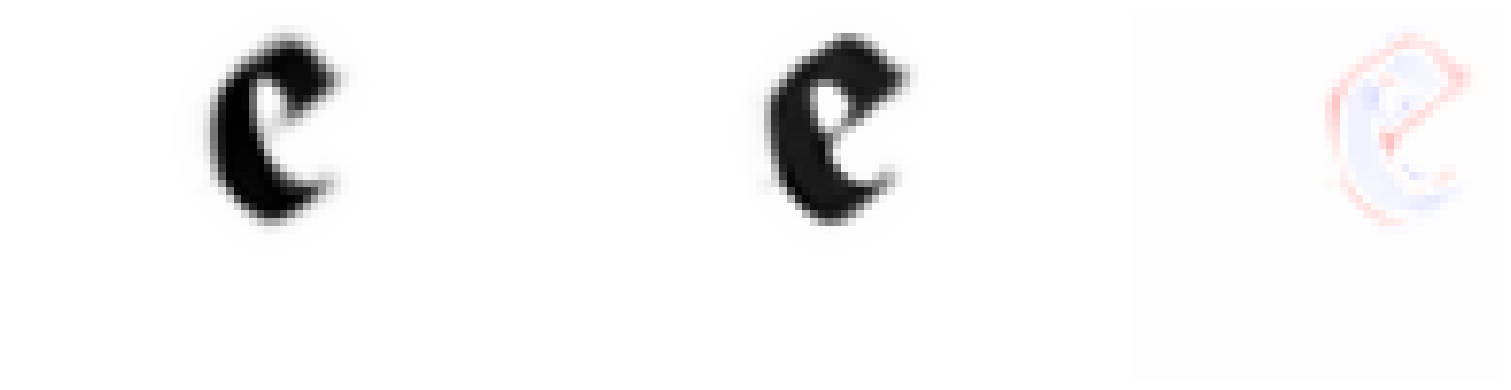

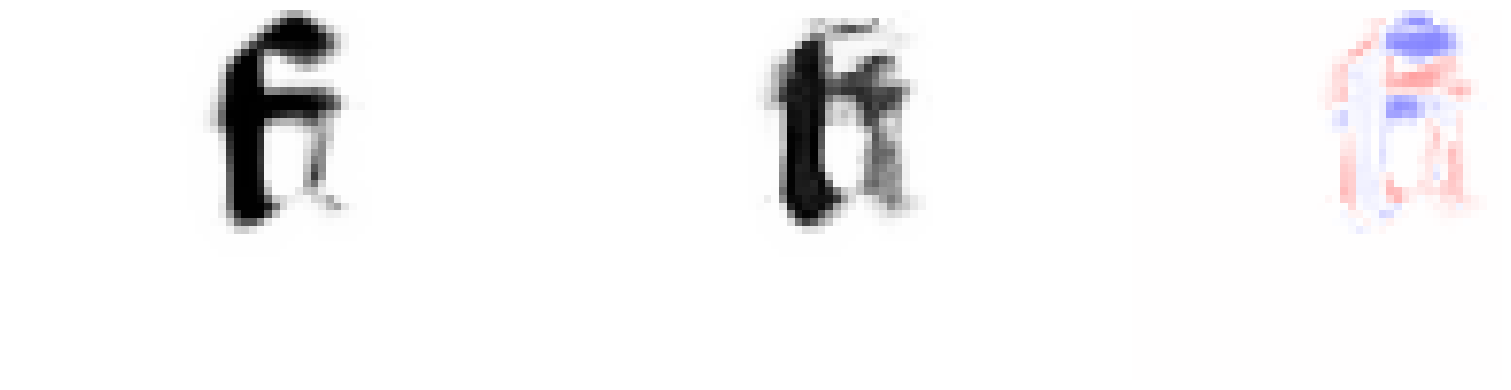

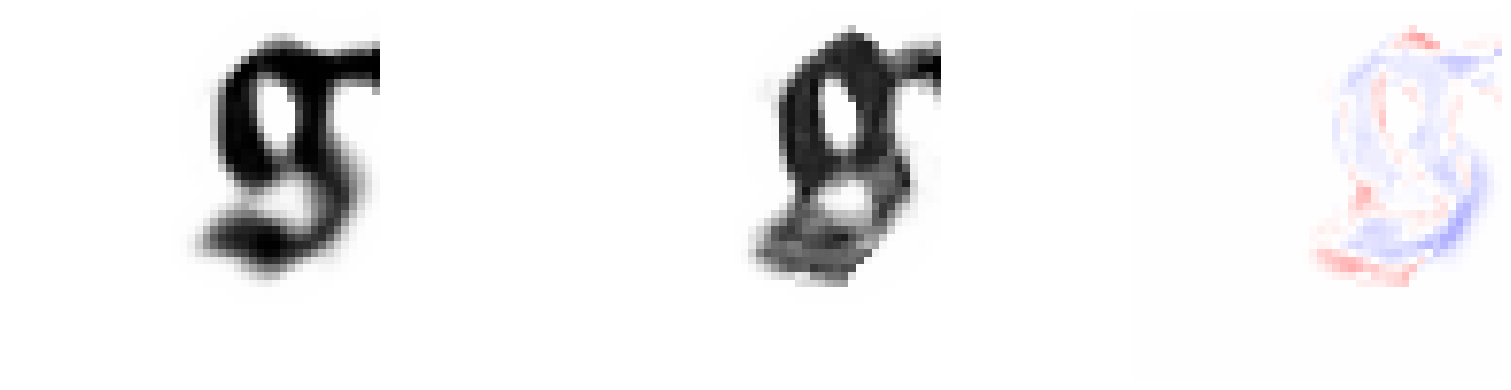

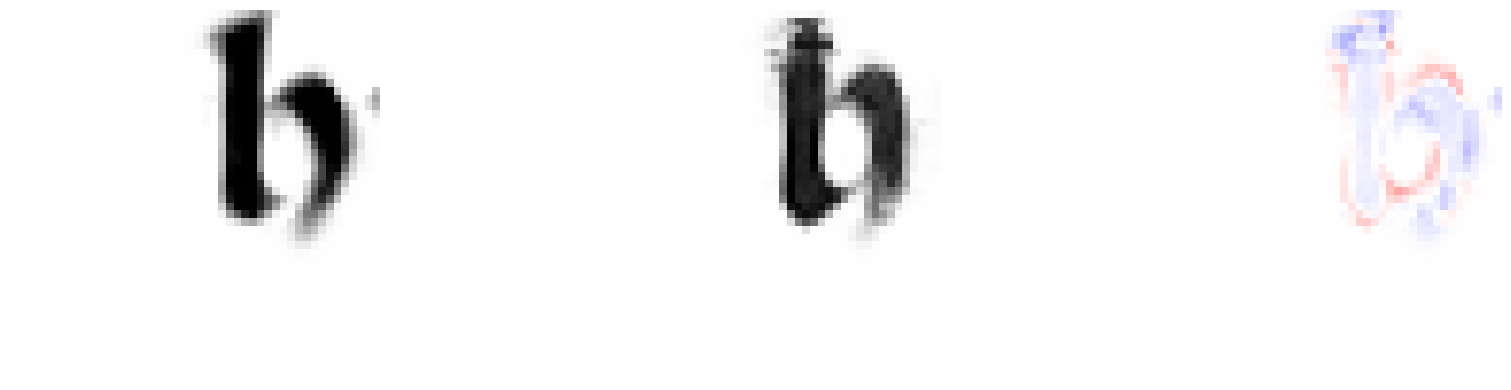

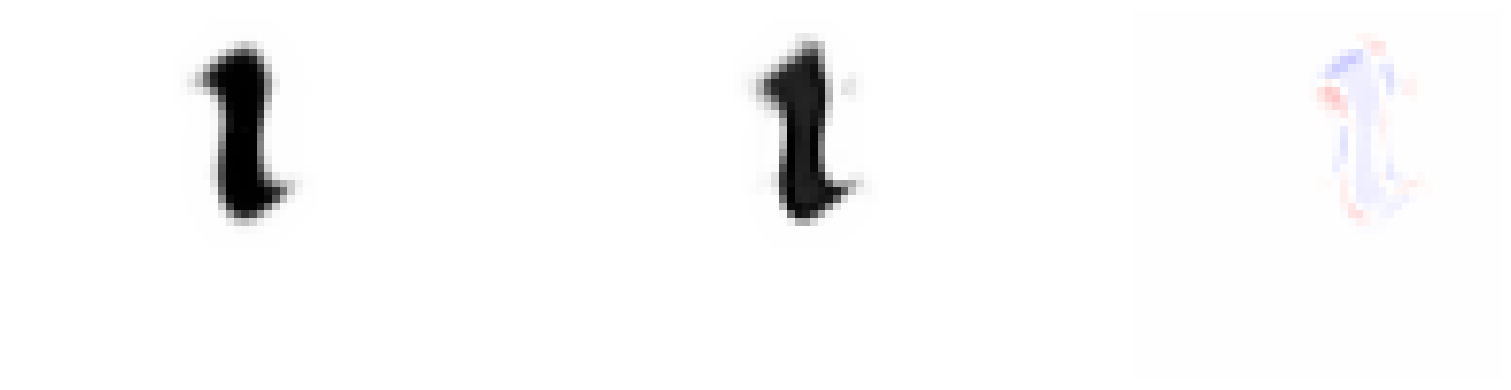

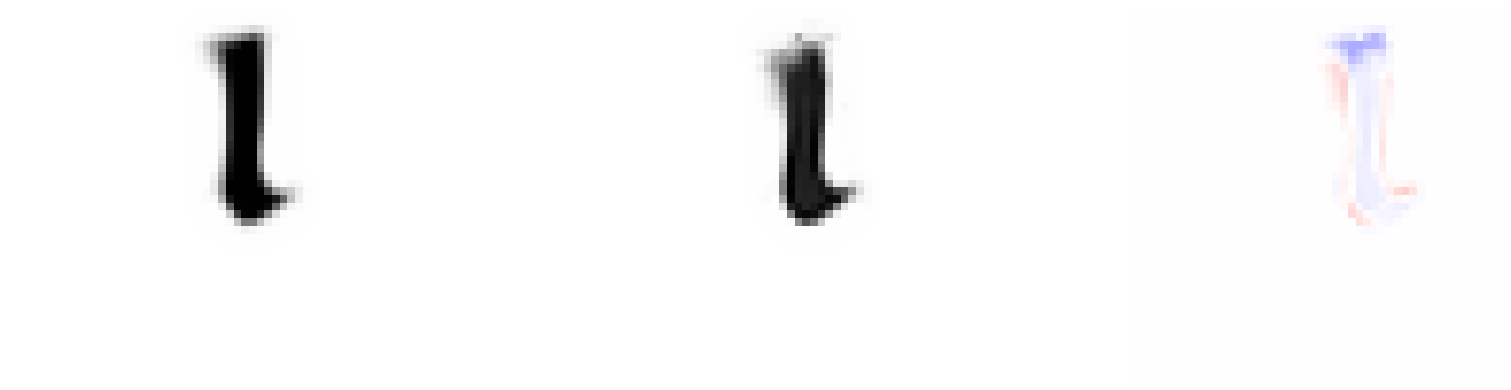

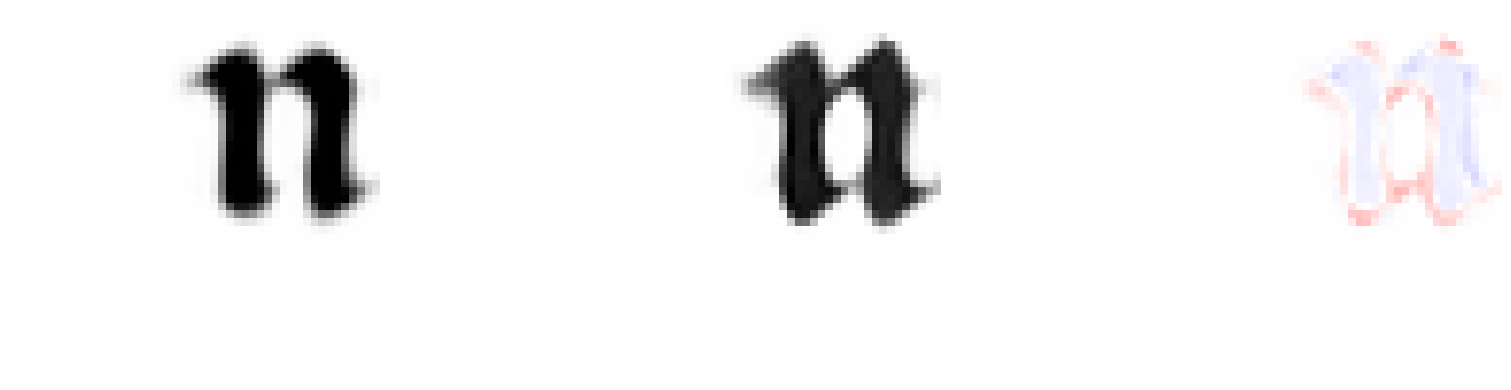

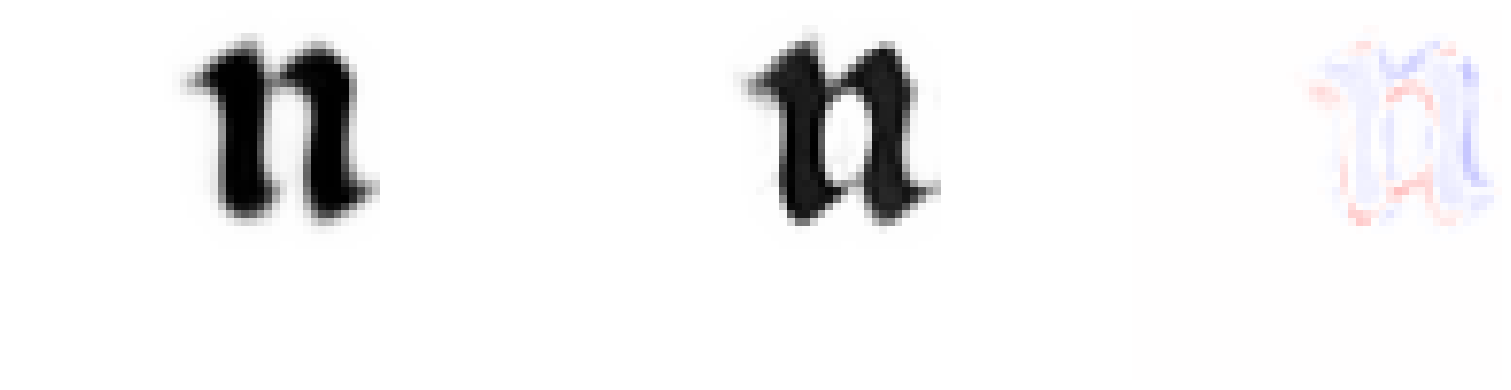

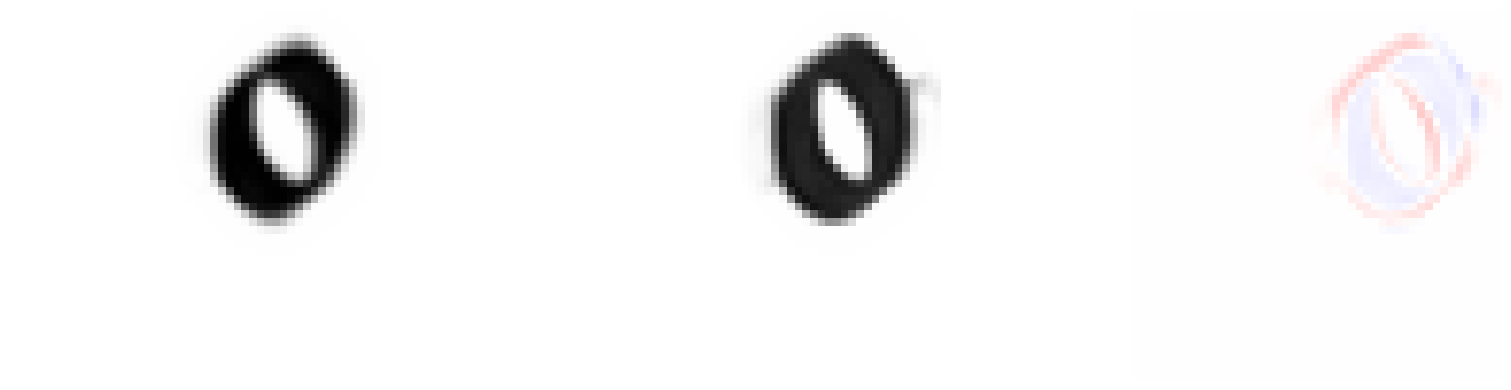

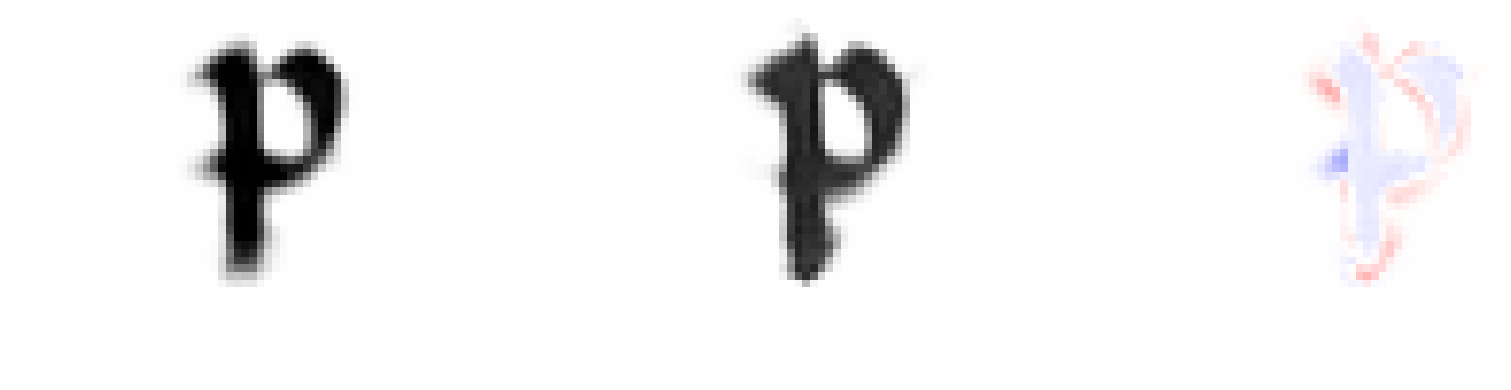

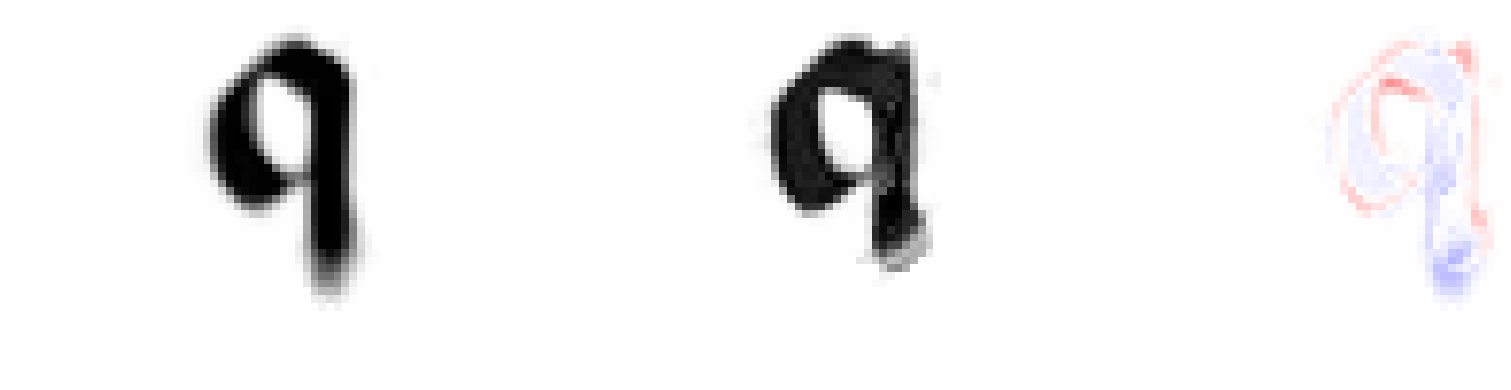

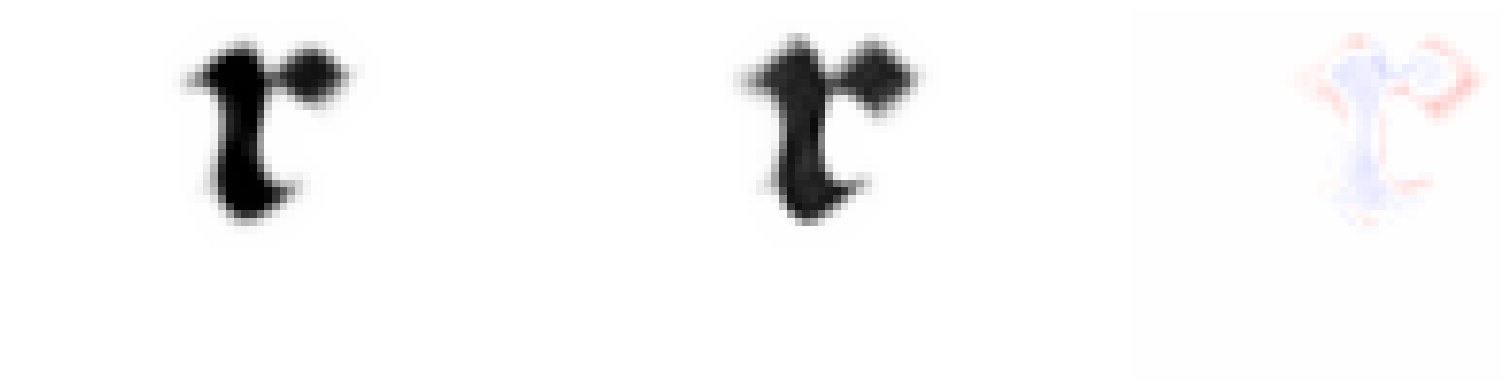

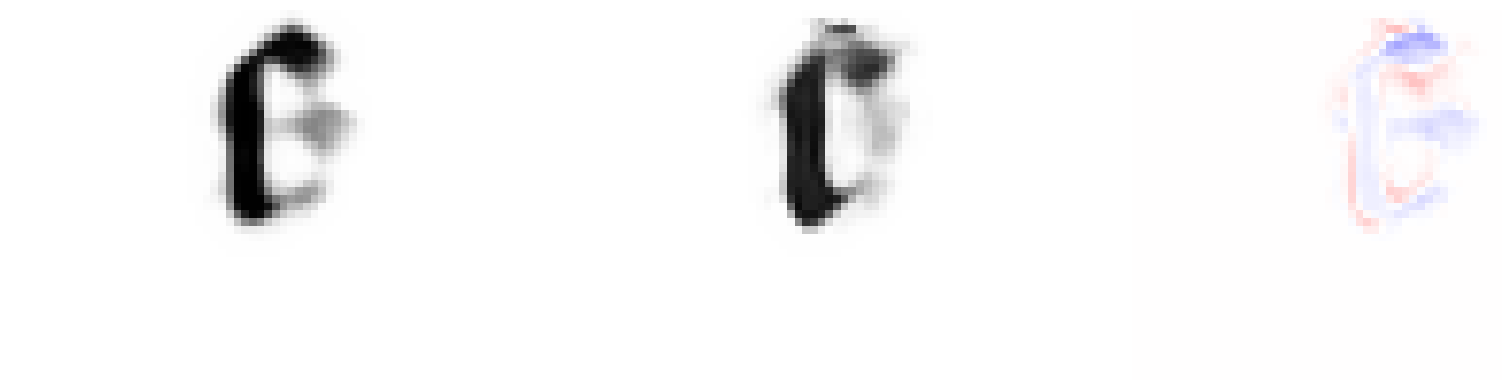

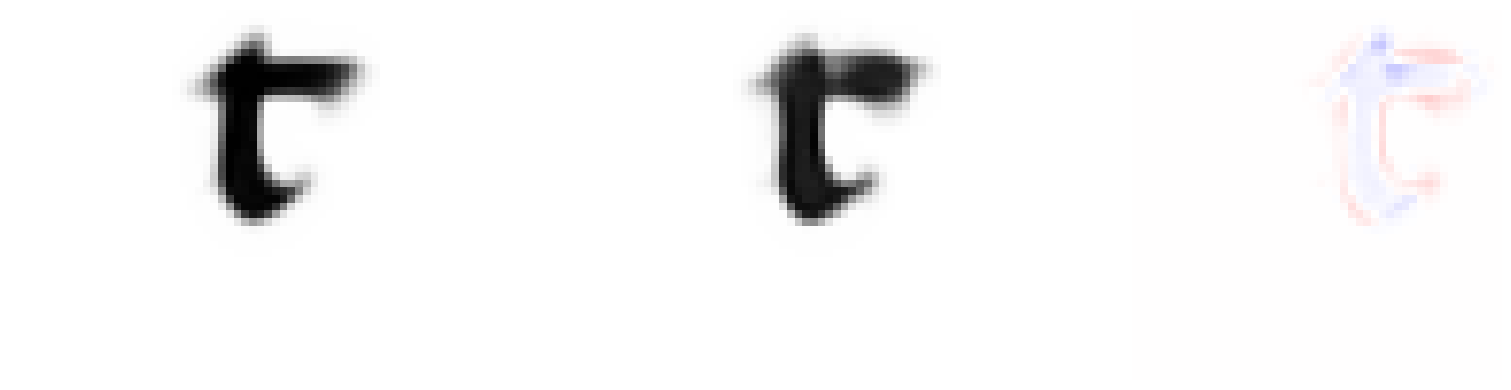

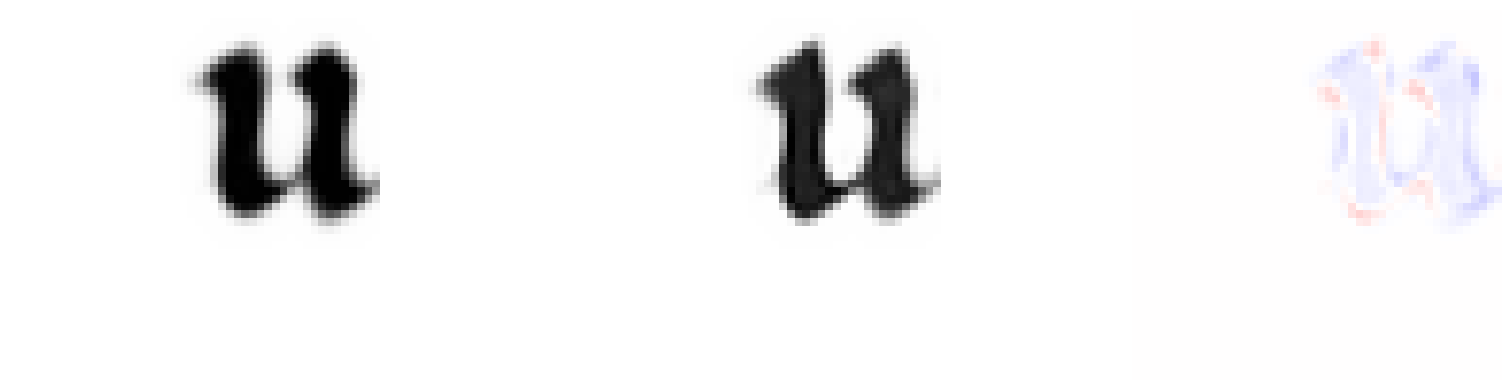

Processing folder: prototypes/filtered/btv1b55006072j


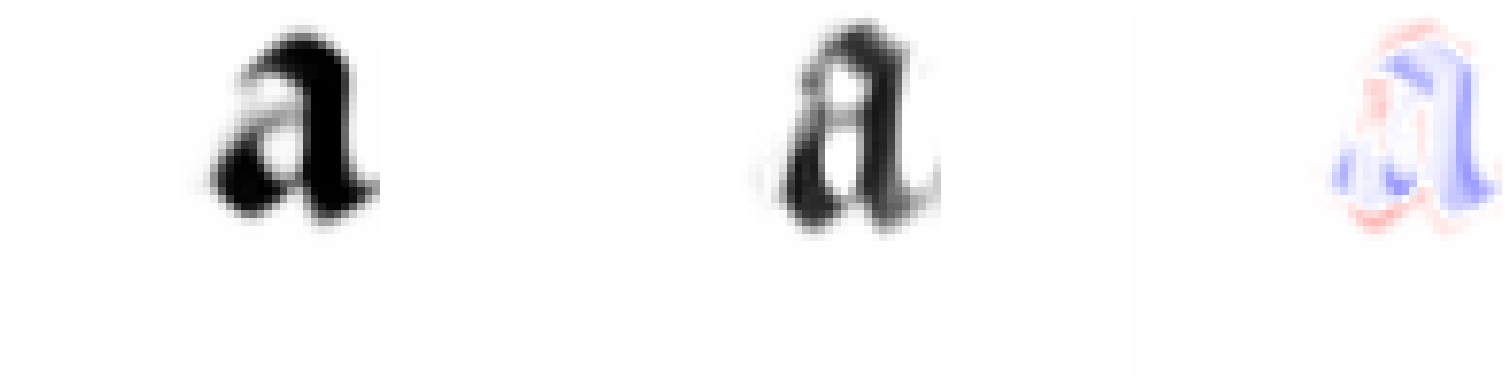

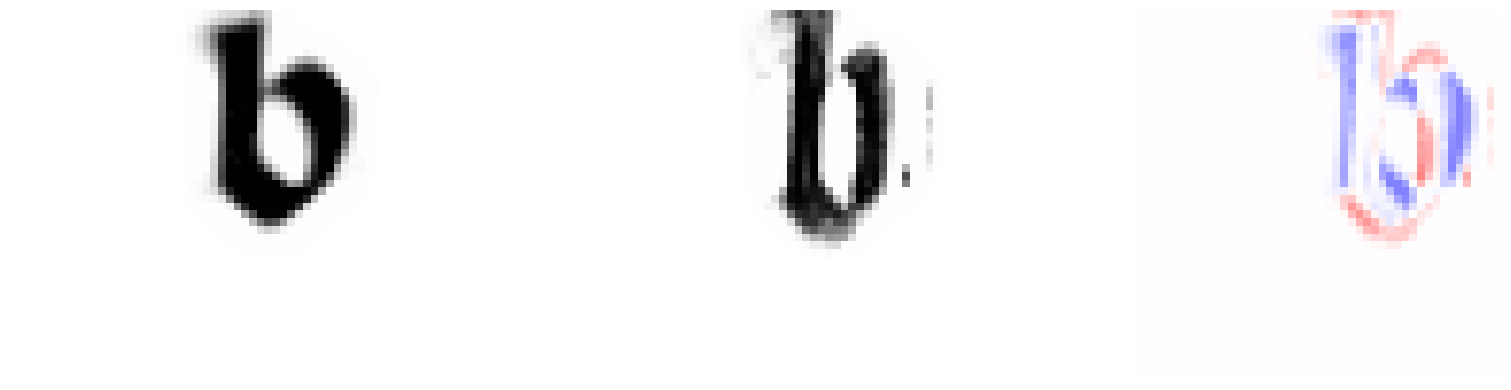

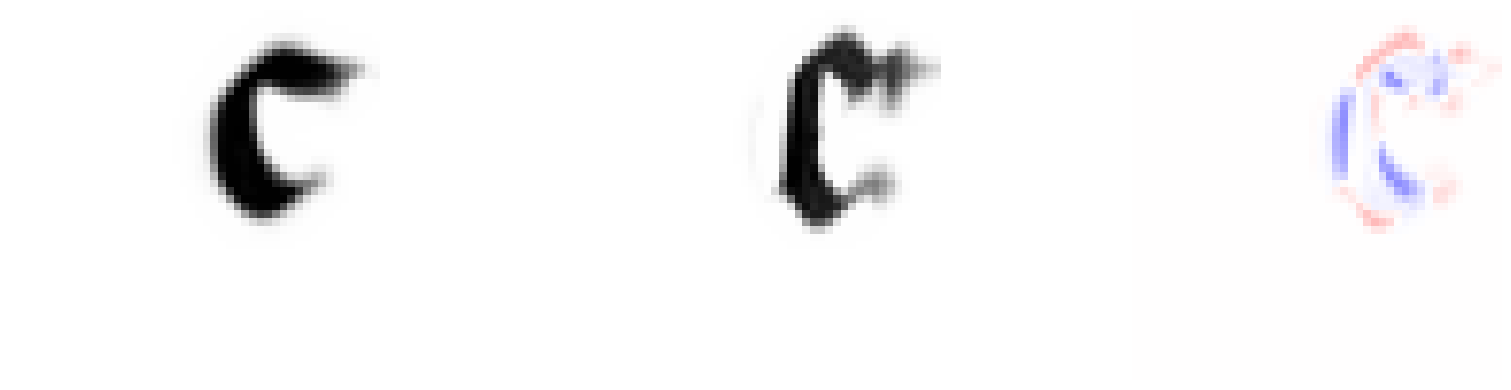

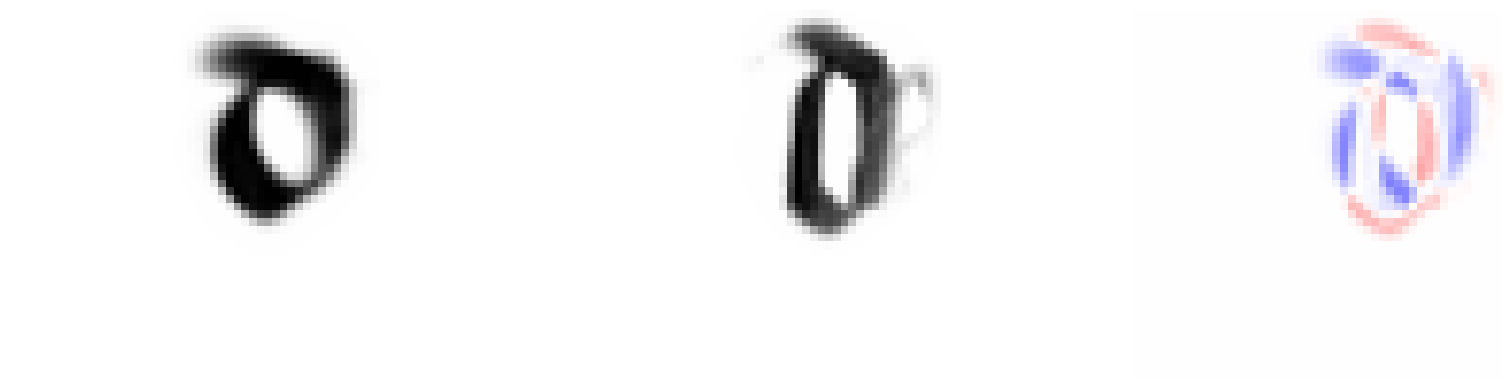

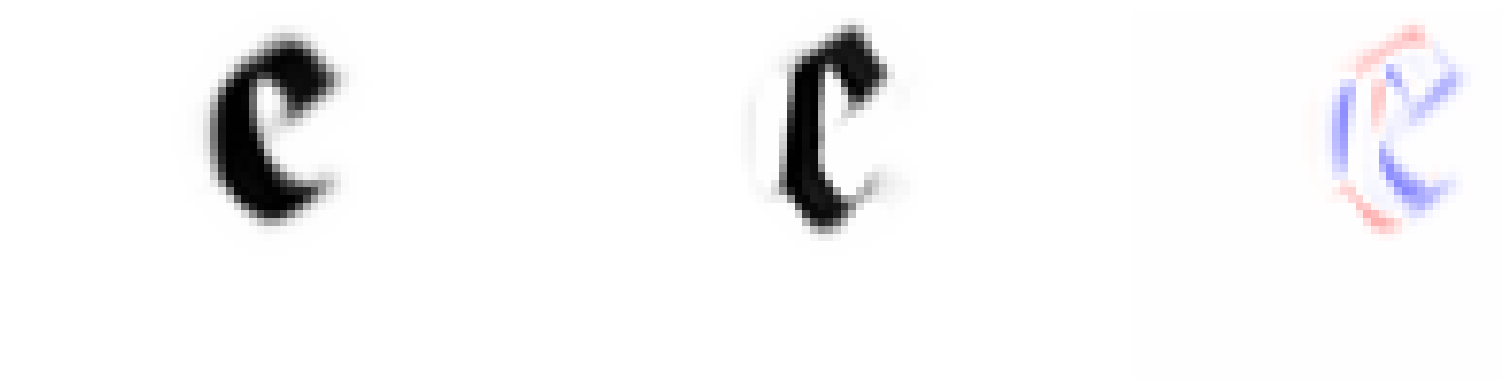

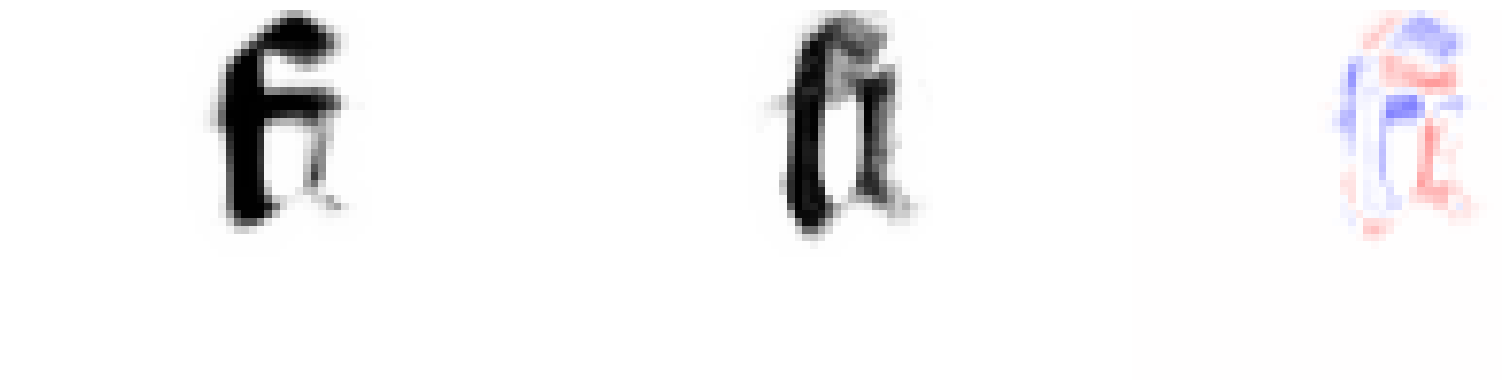

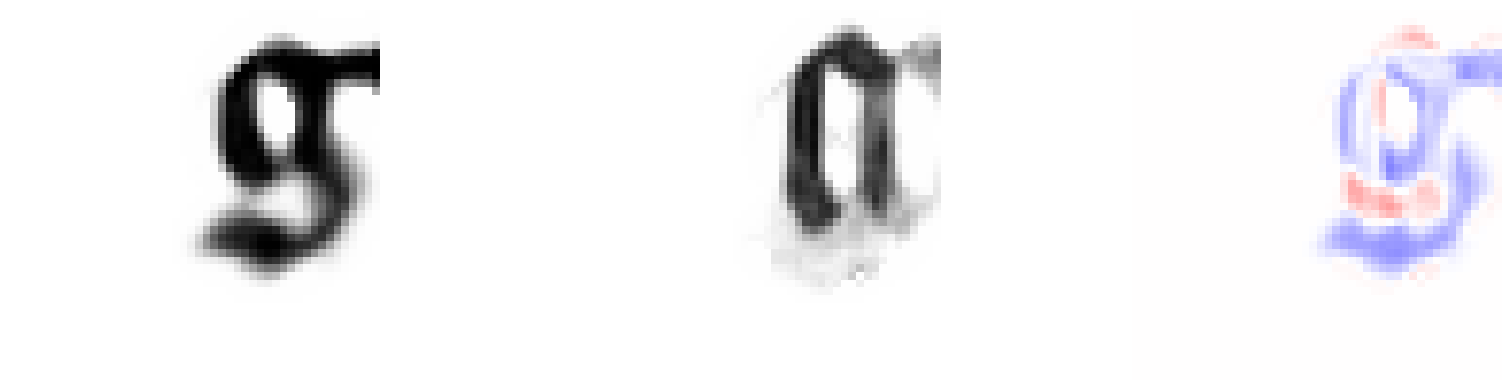

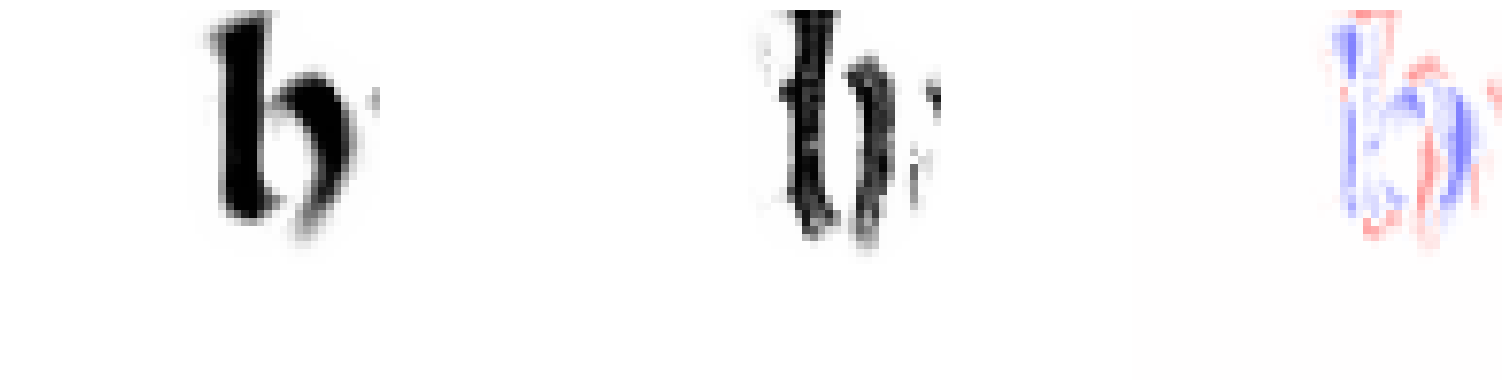

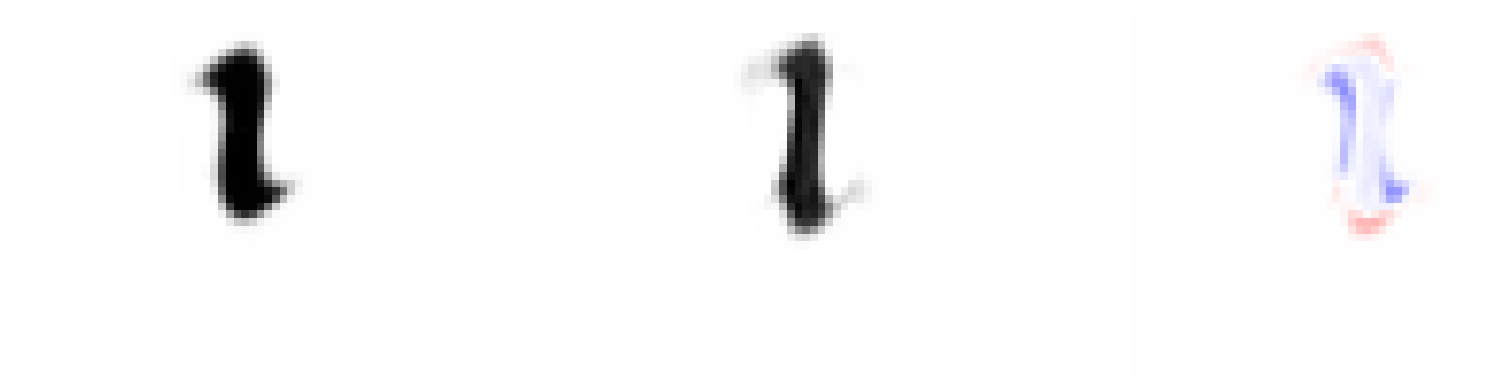

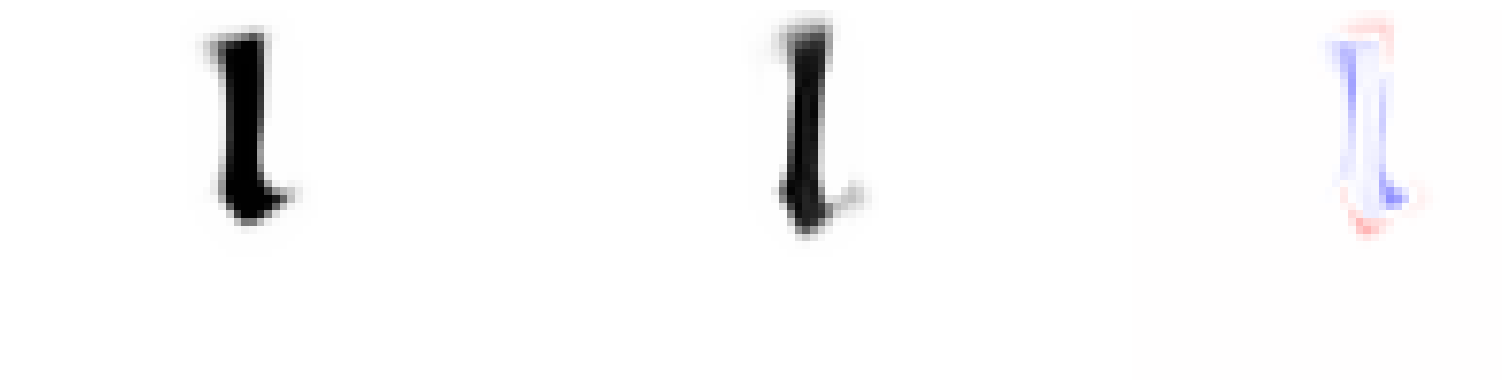

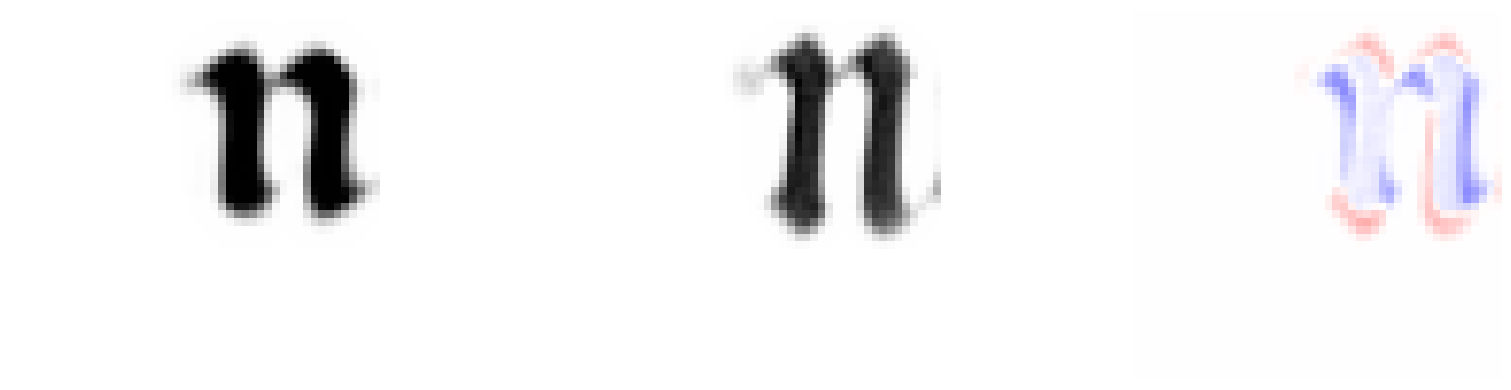

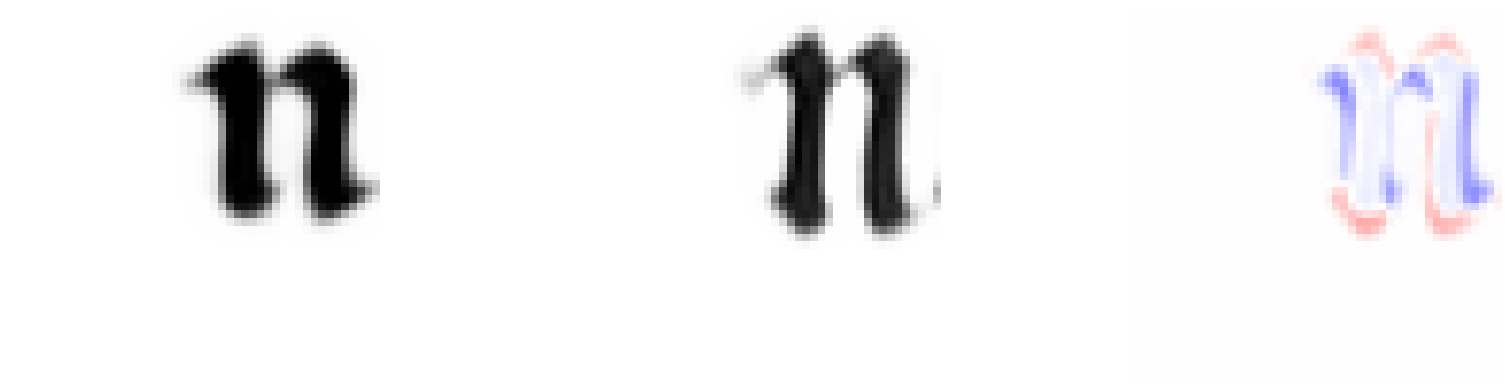

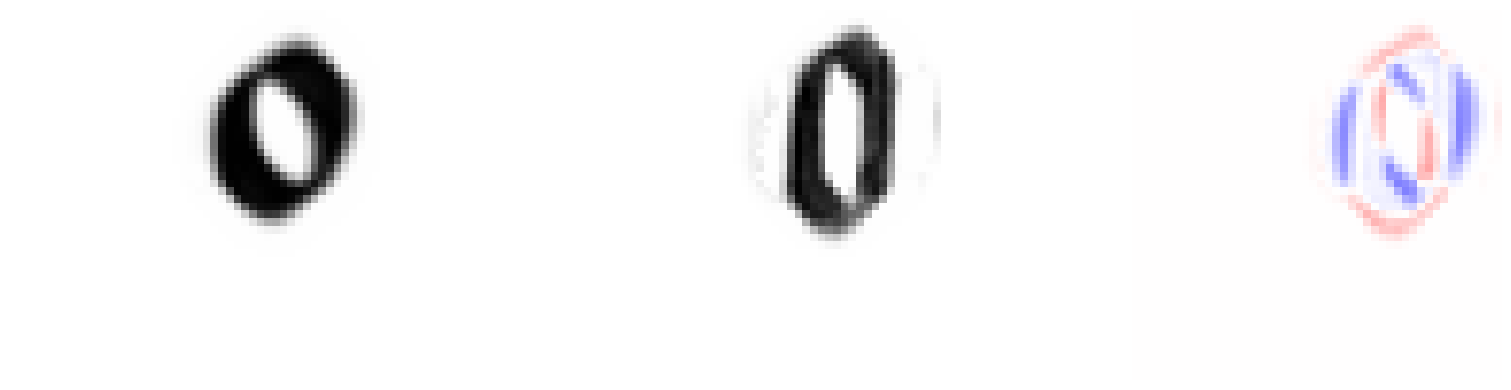

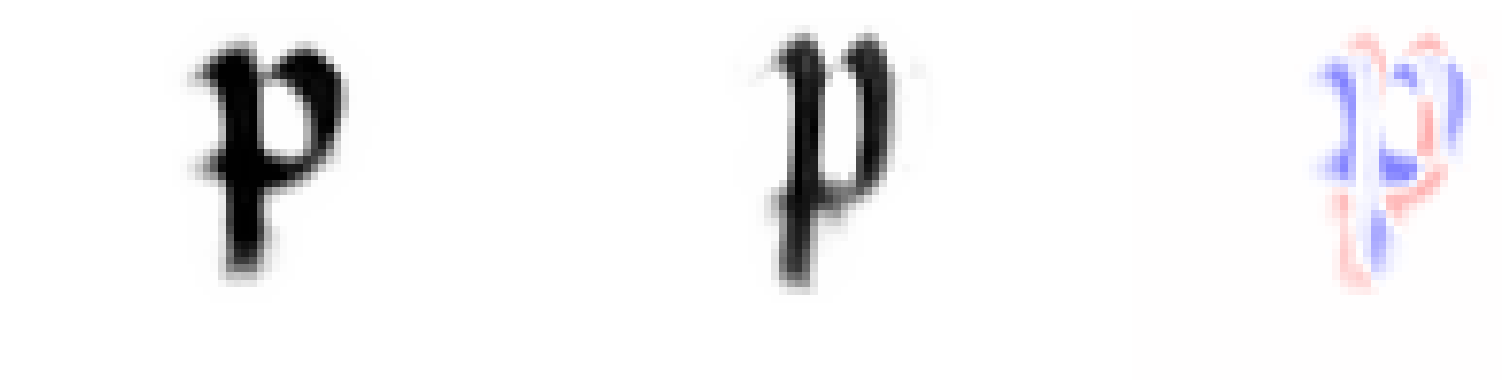

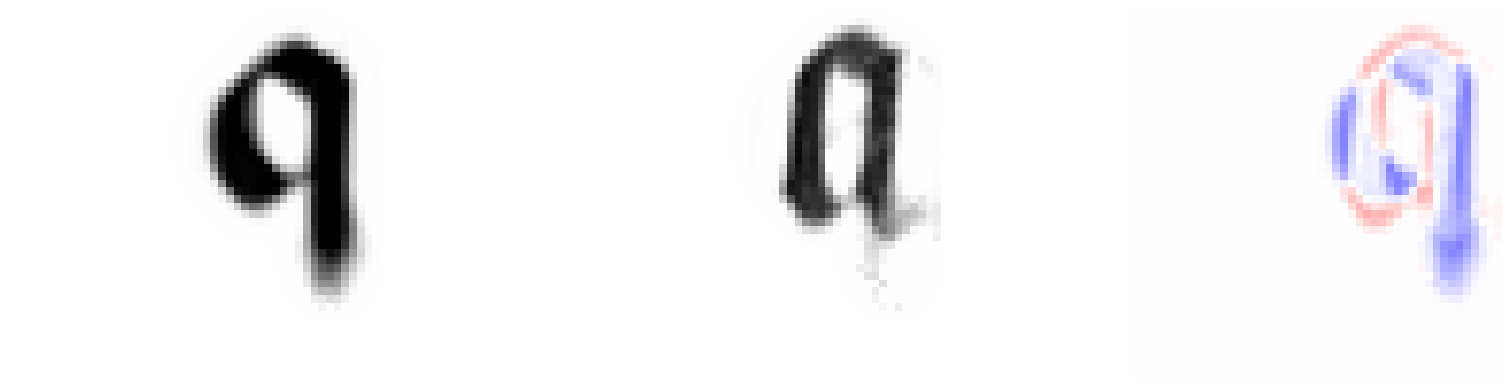

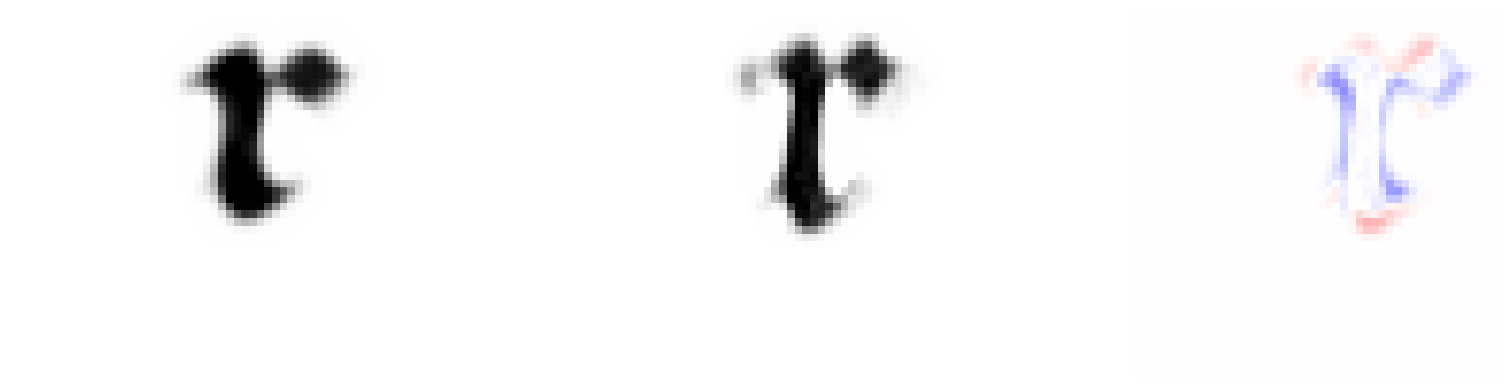

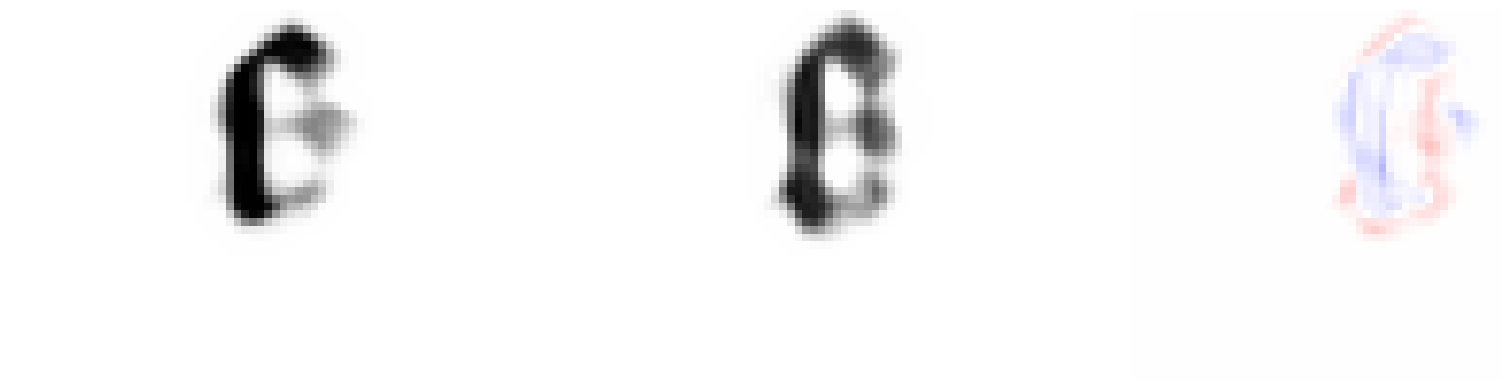

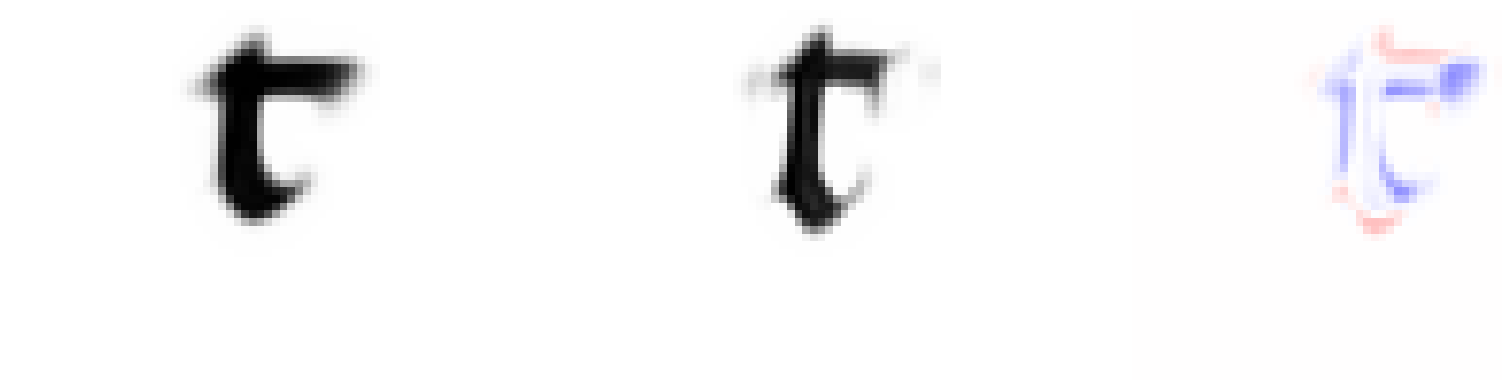

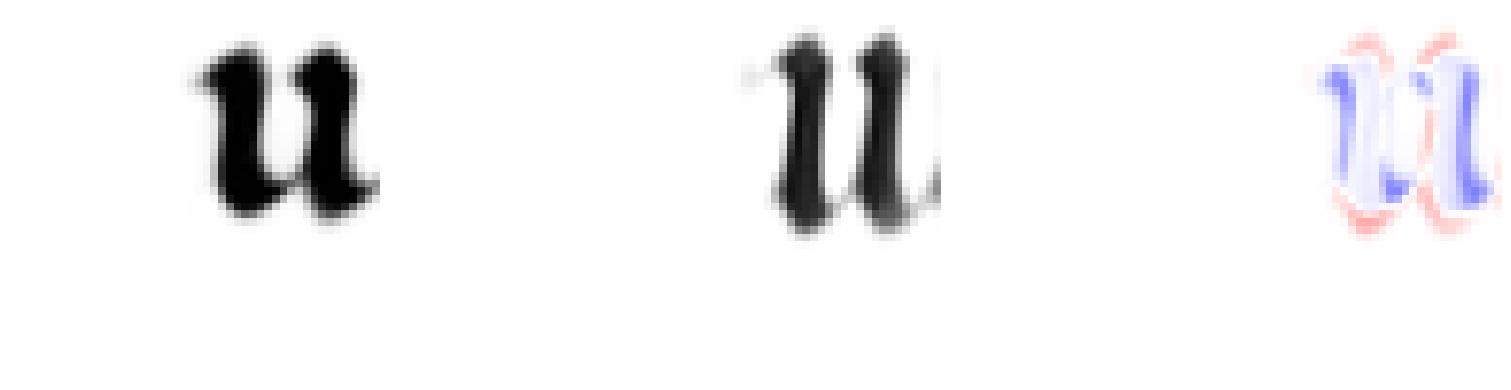

Processing folder: prototypes/filtered/SBB-PK-Hdschr25


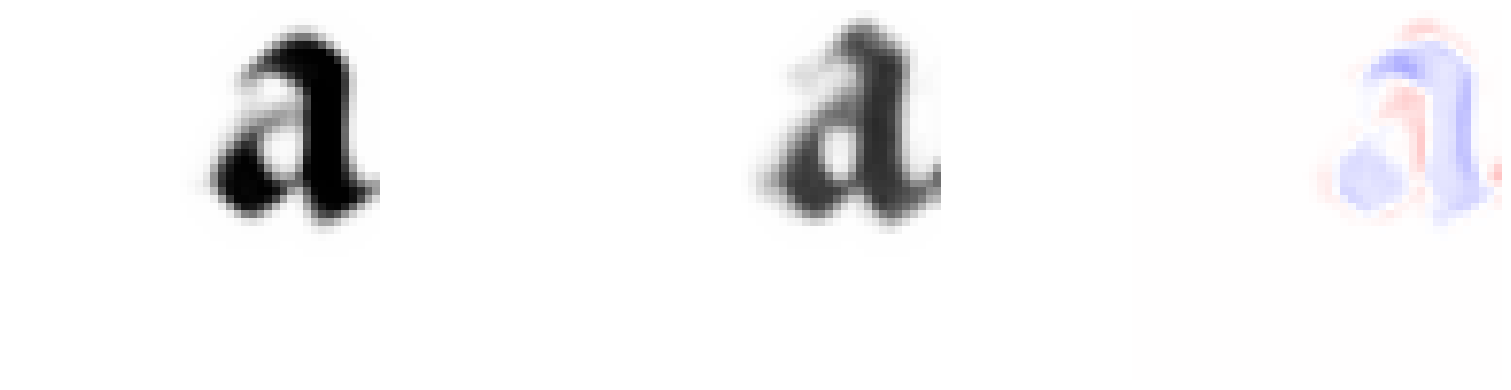

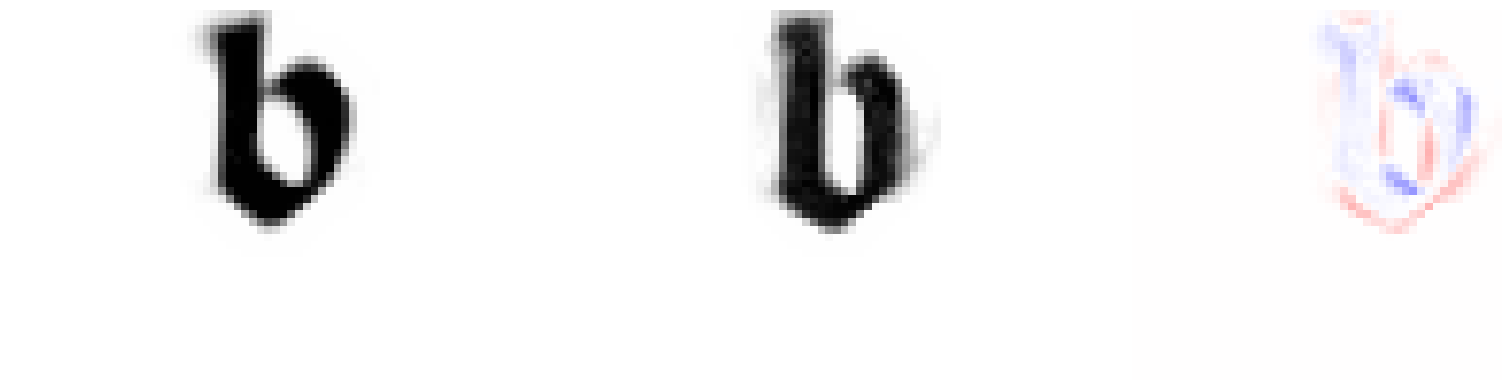

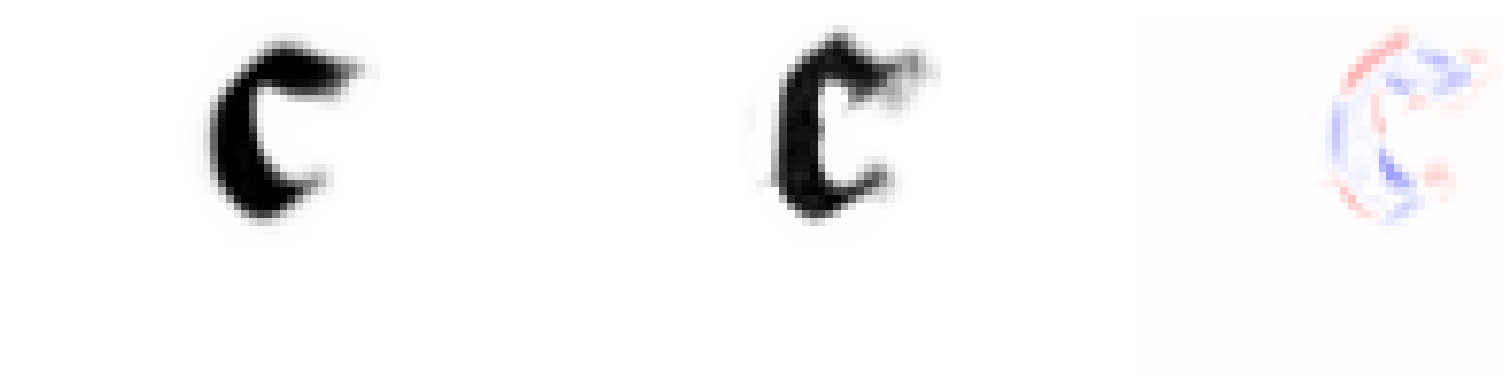

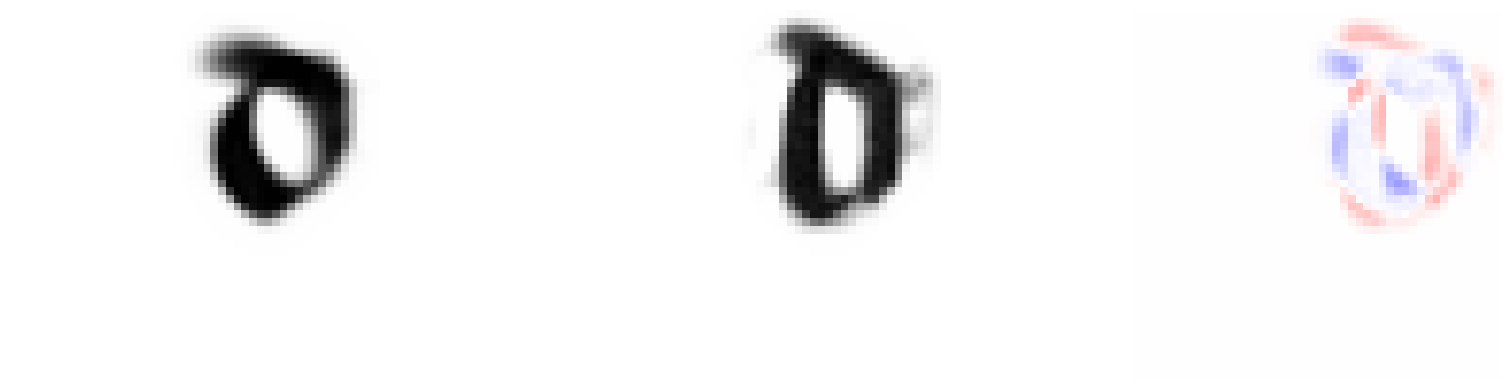

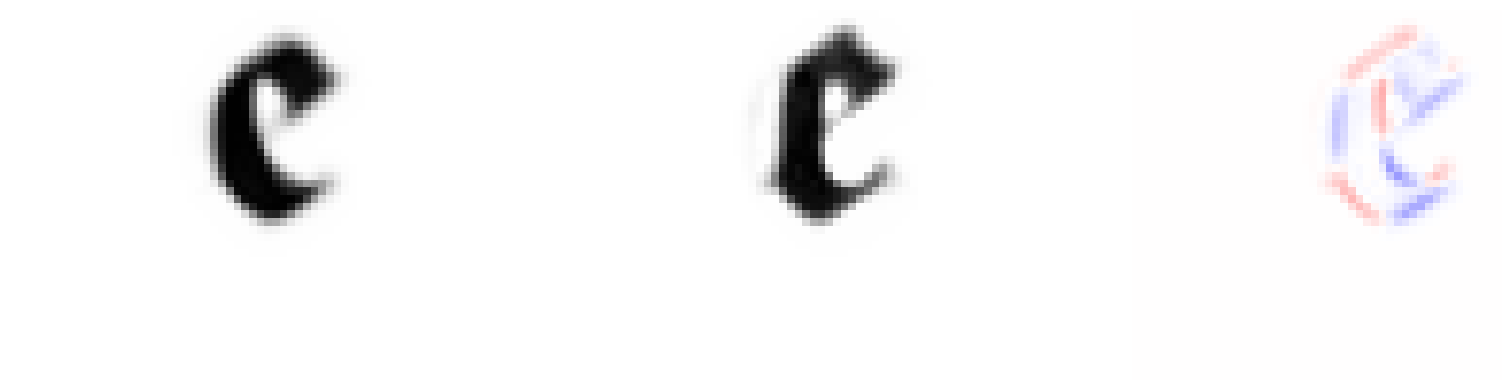

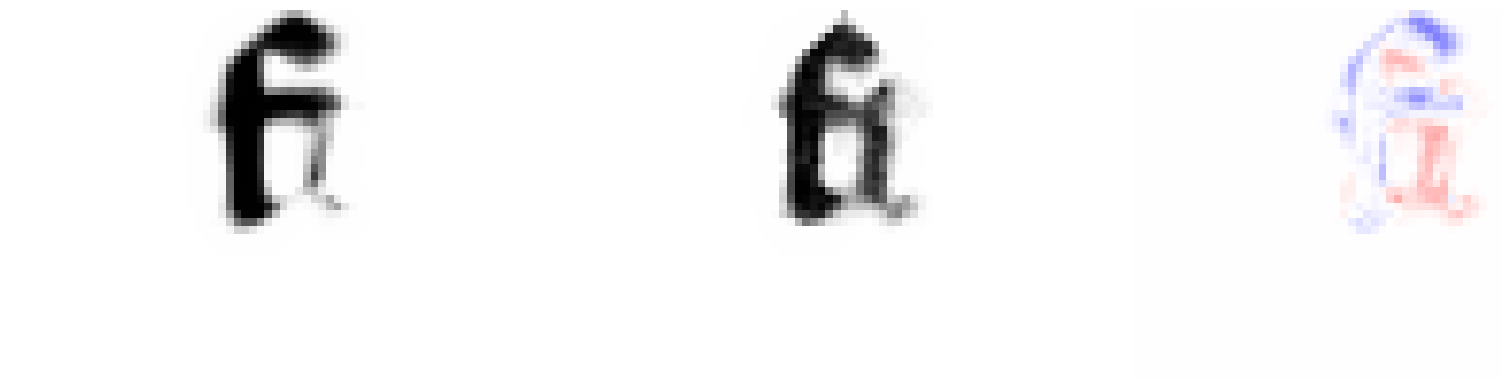

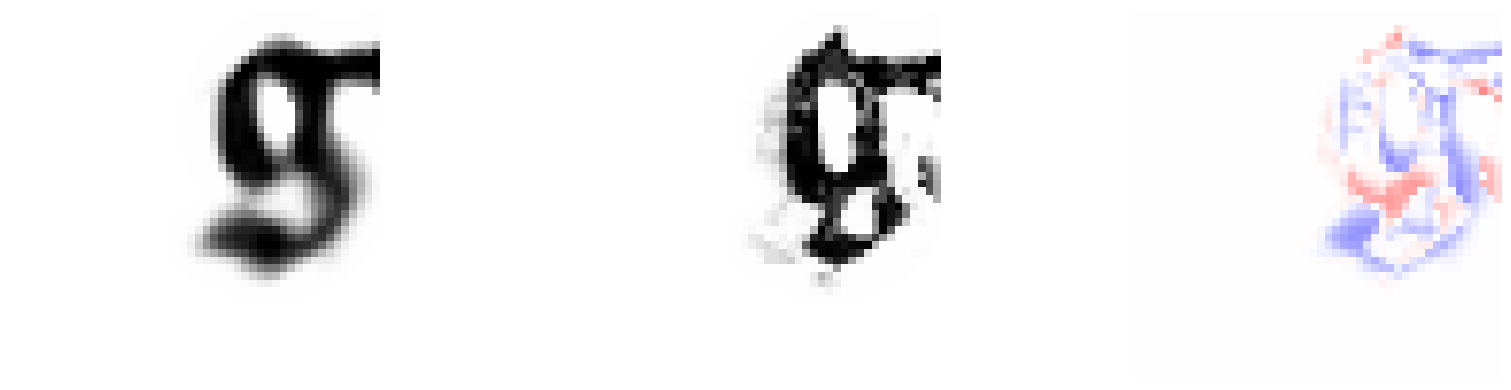

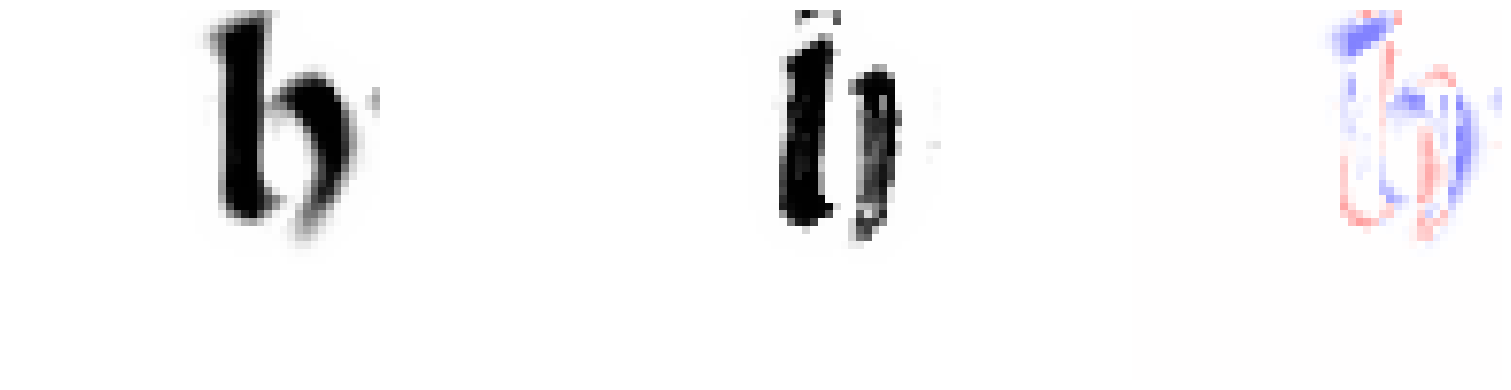

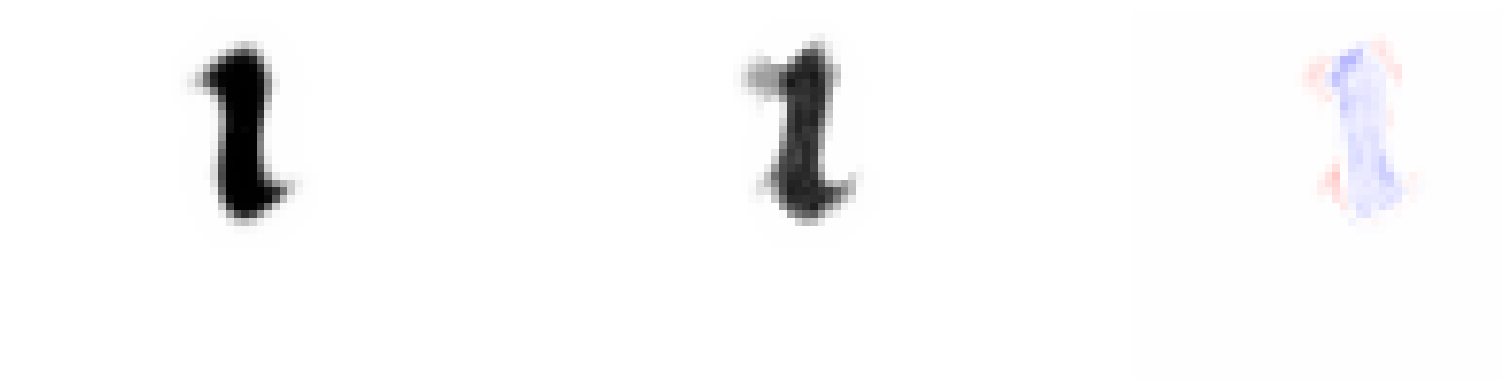

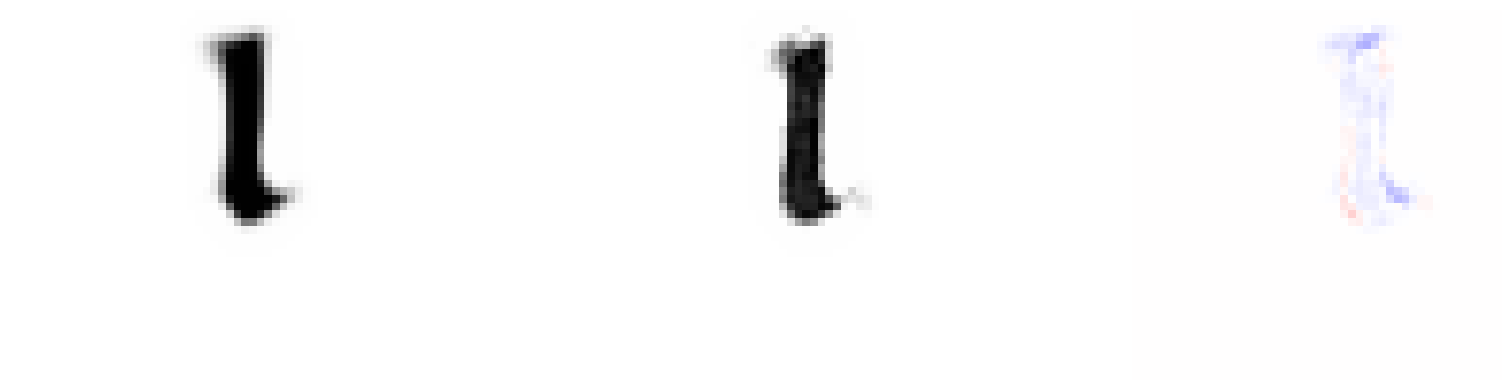

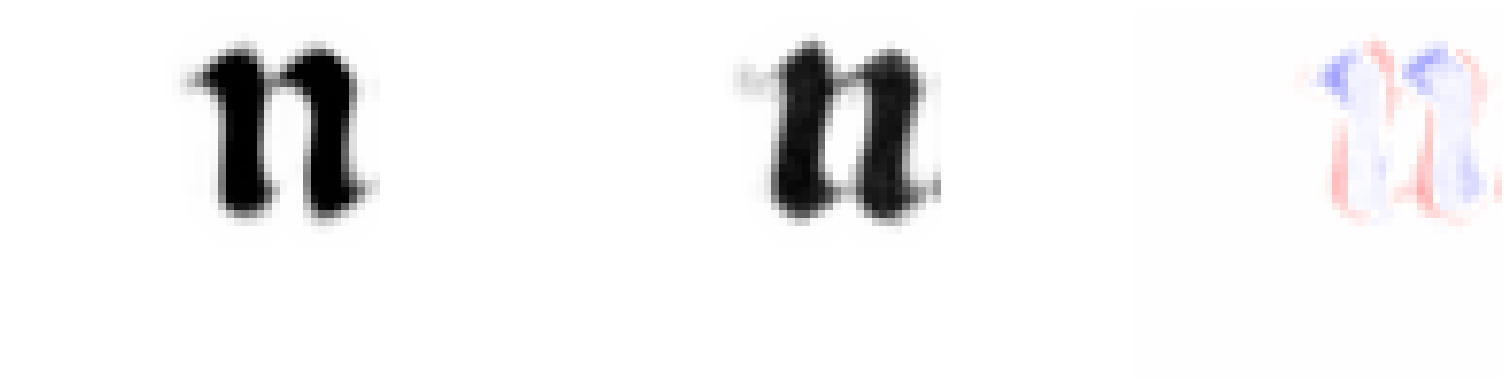

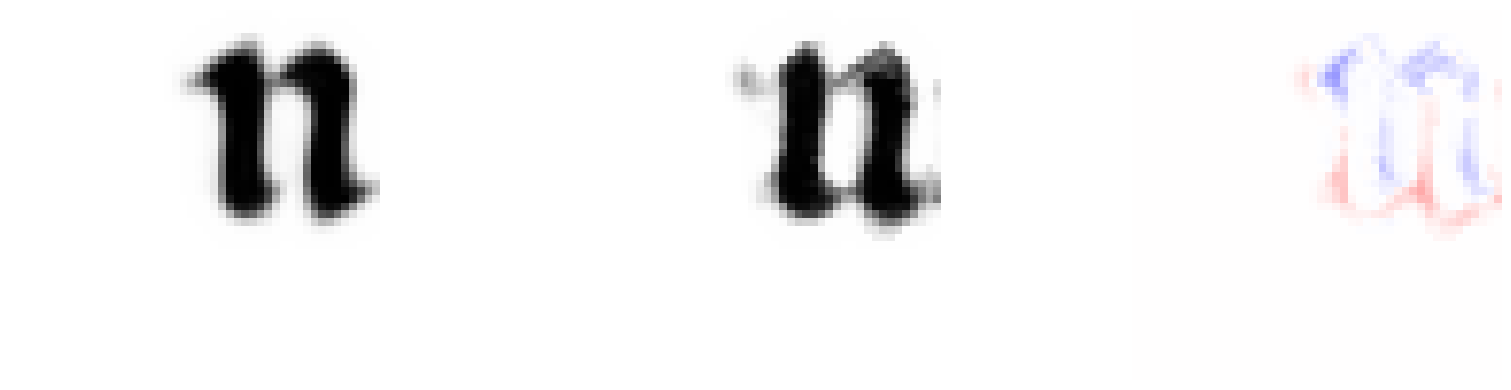

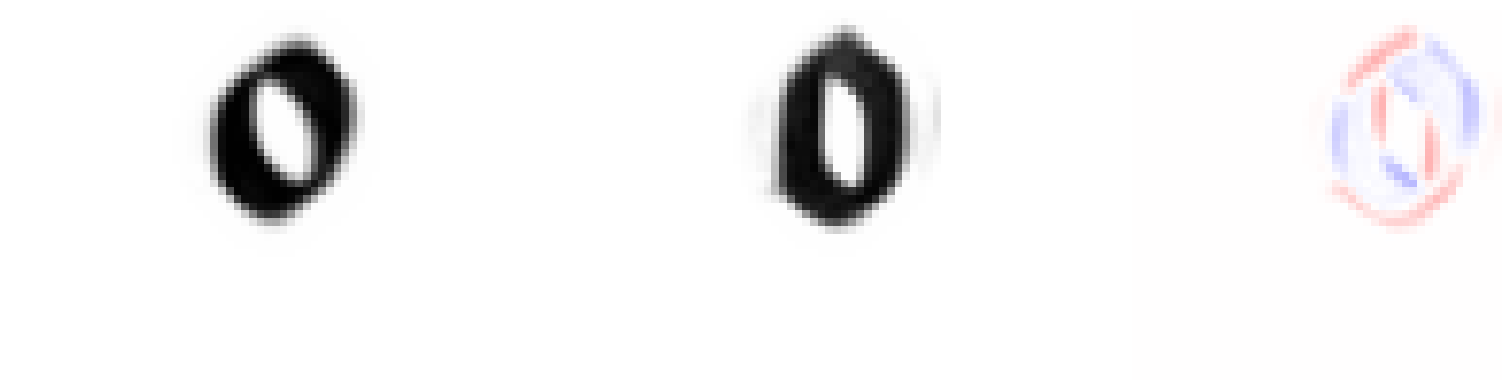

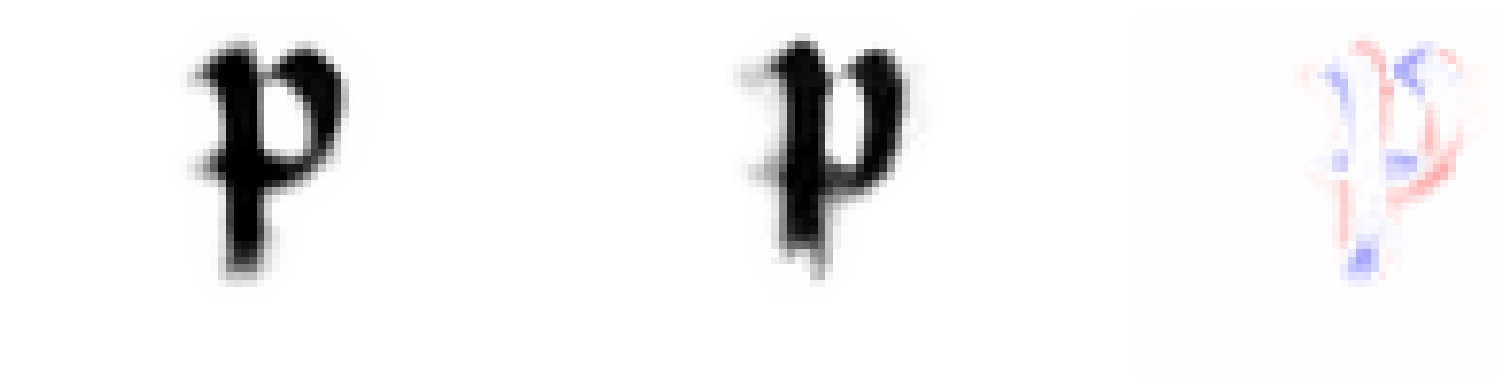

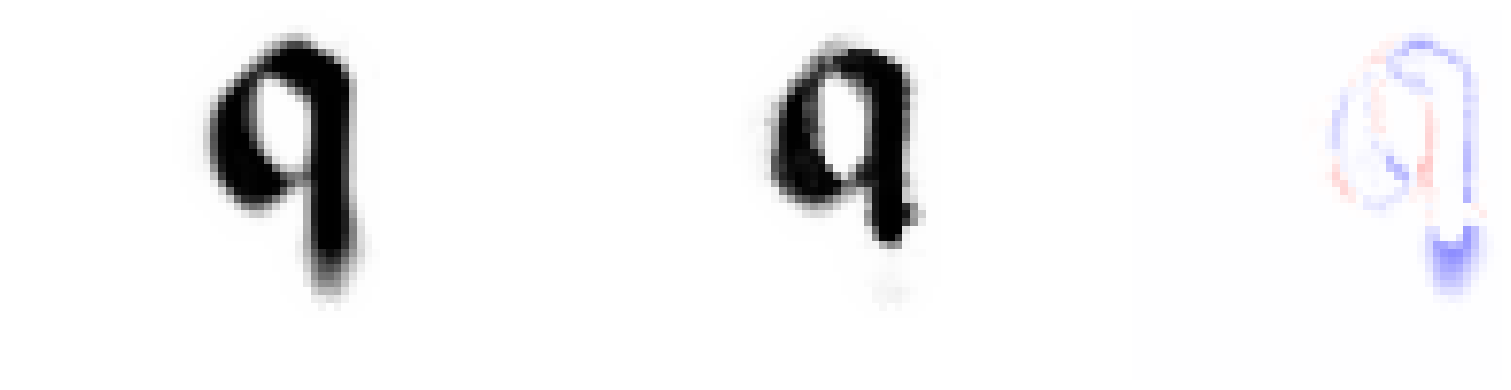

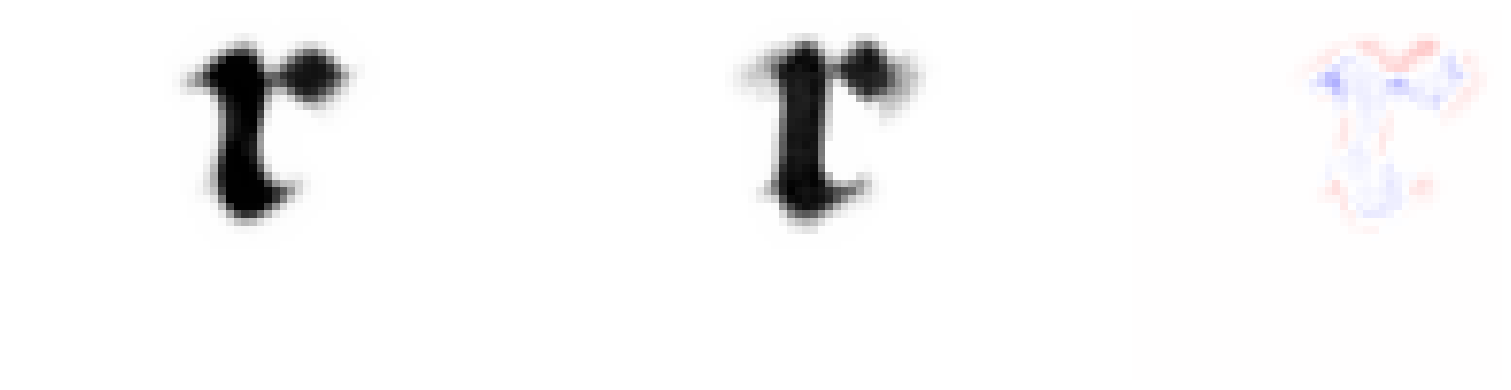

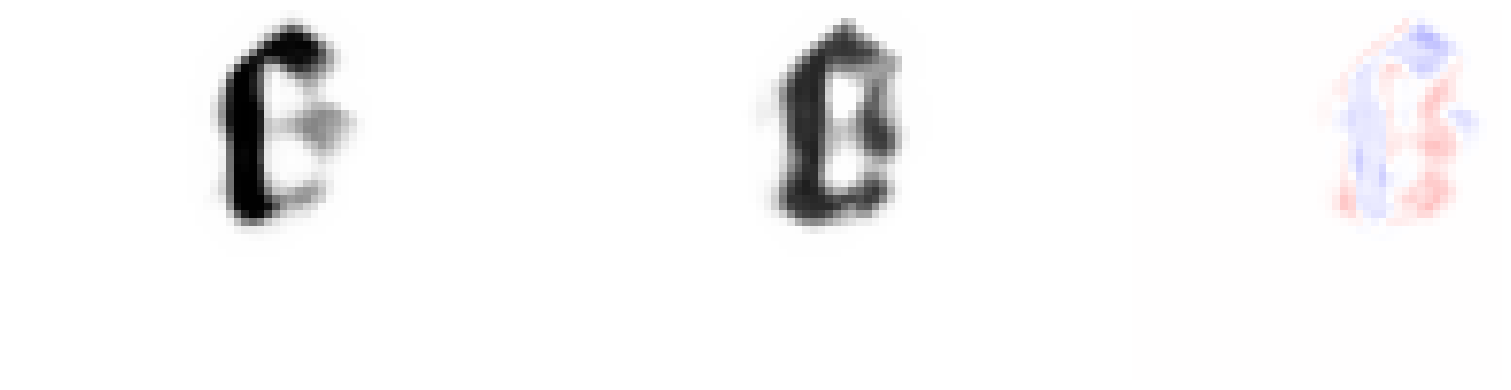

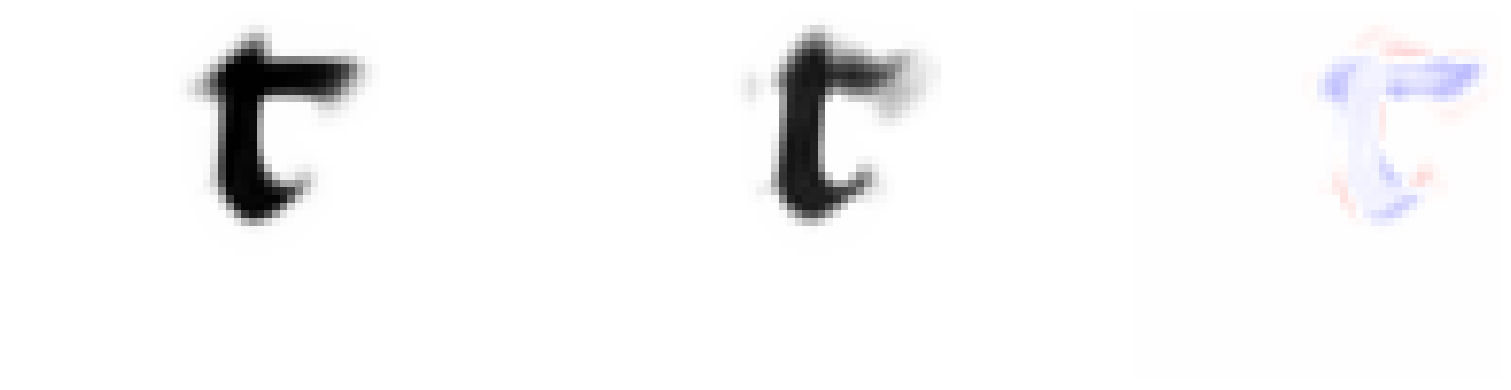

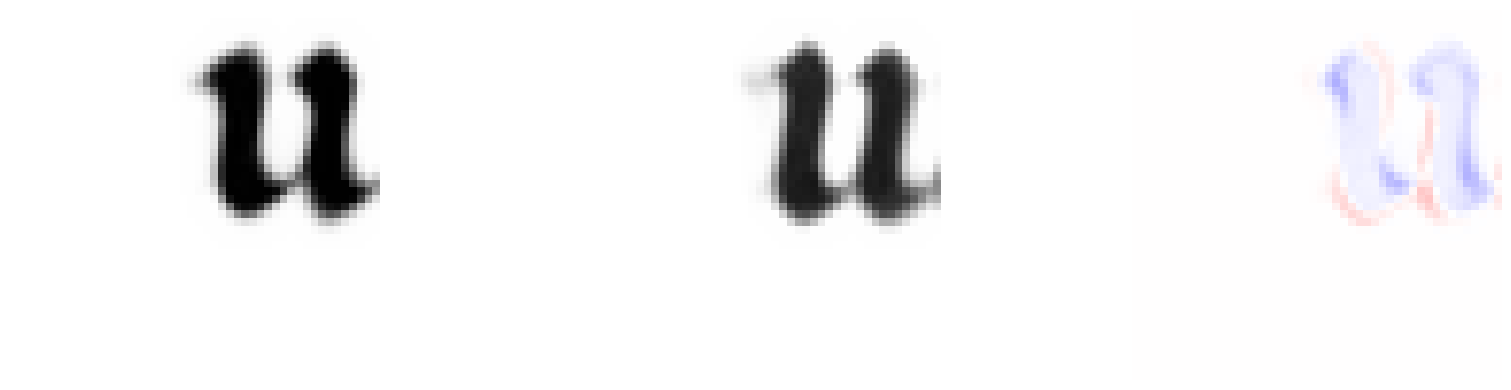

Processing folder: prototypes/filtered/Southern_Textualis


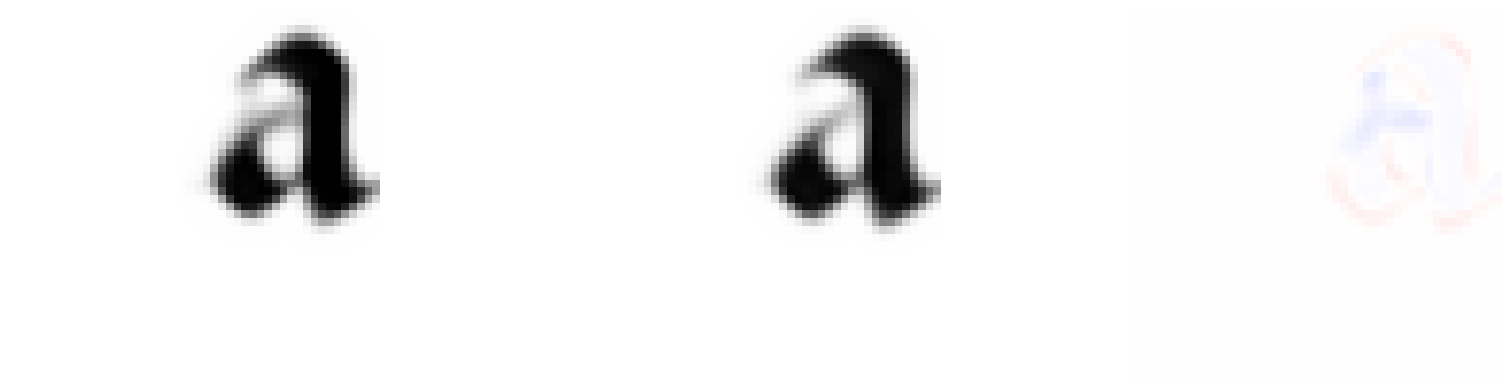

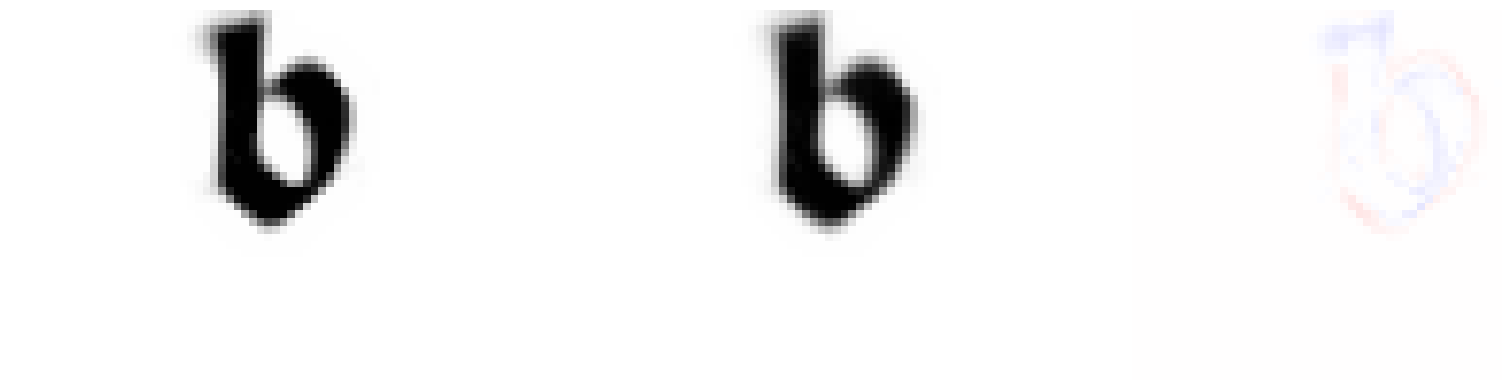

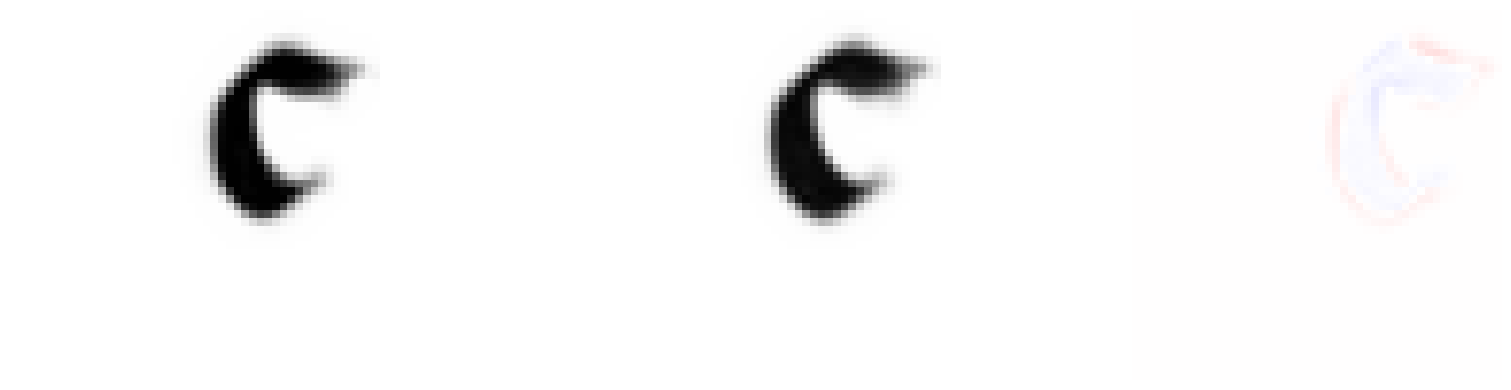

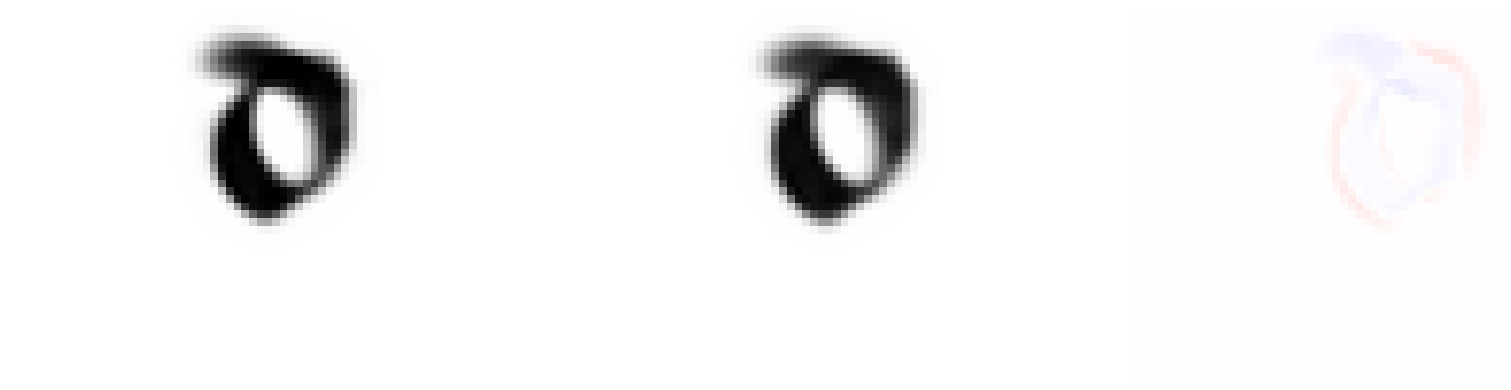

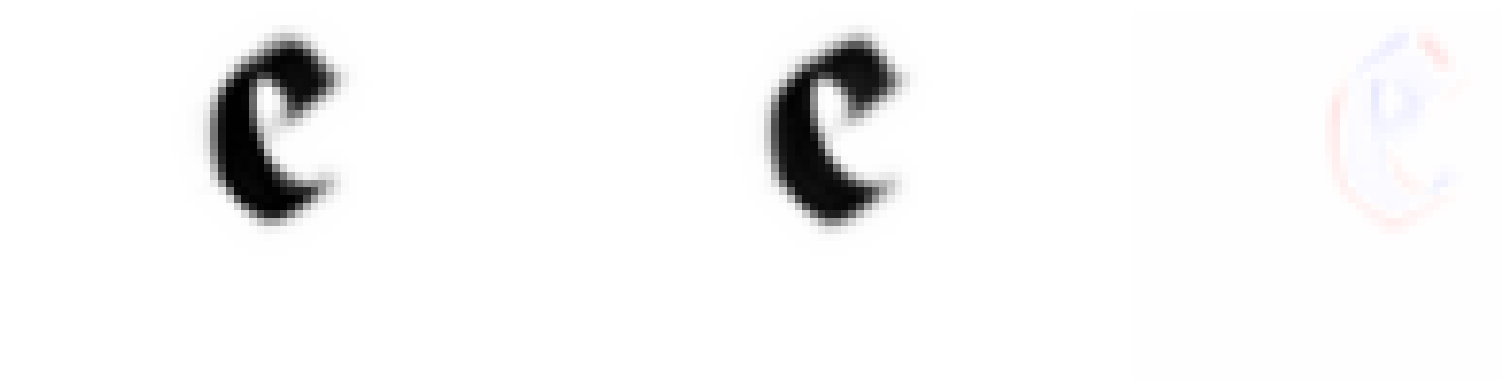

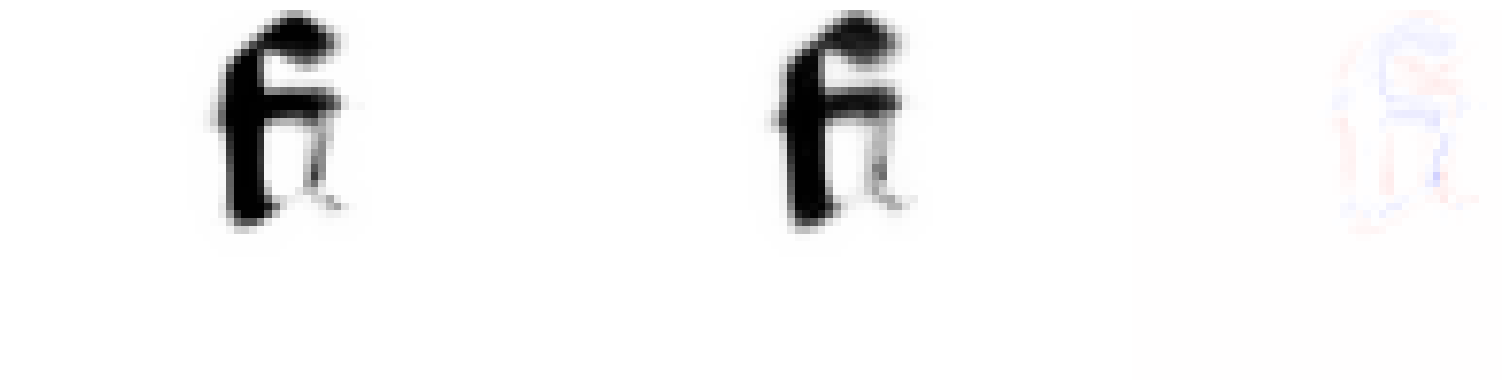

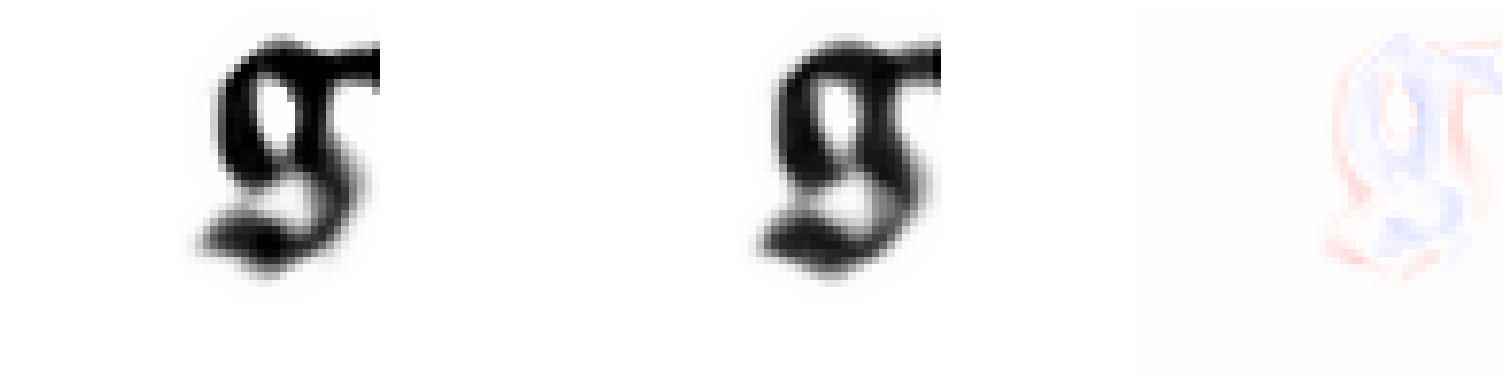

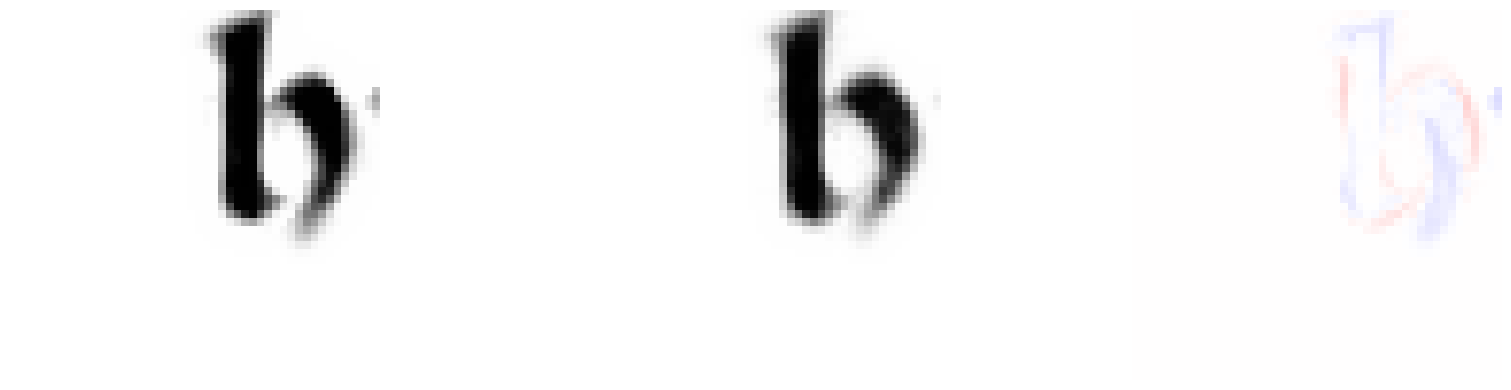

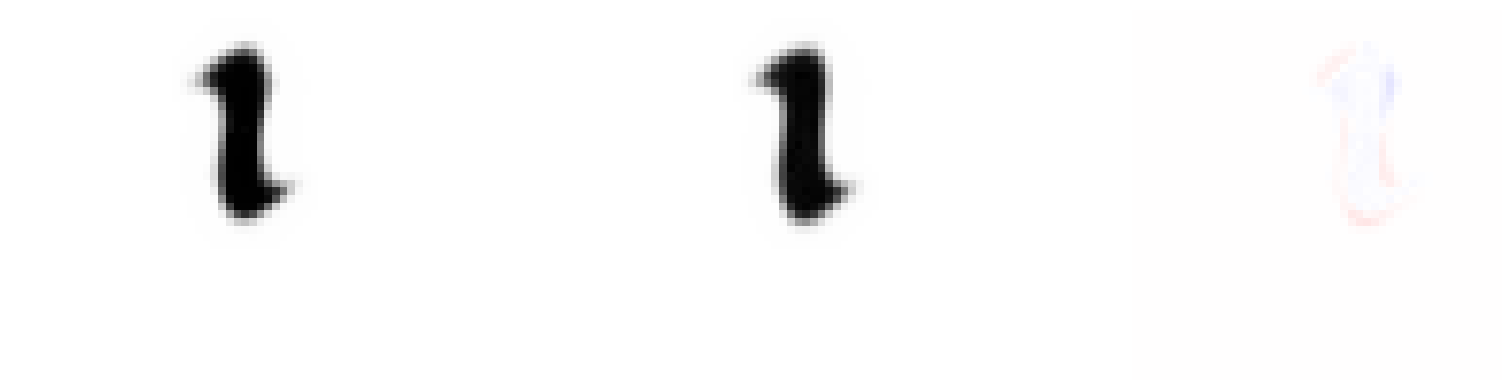

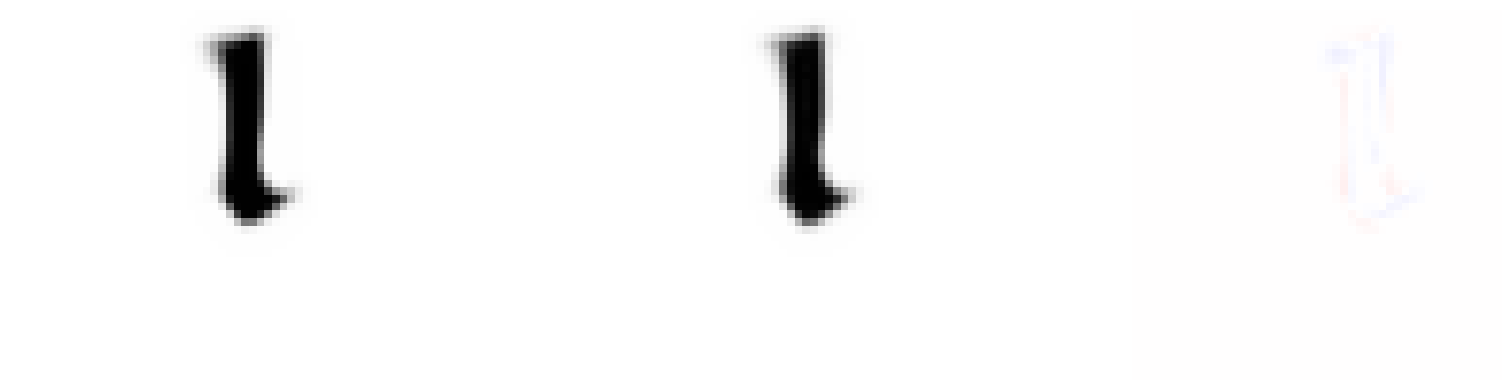

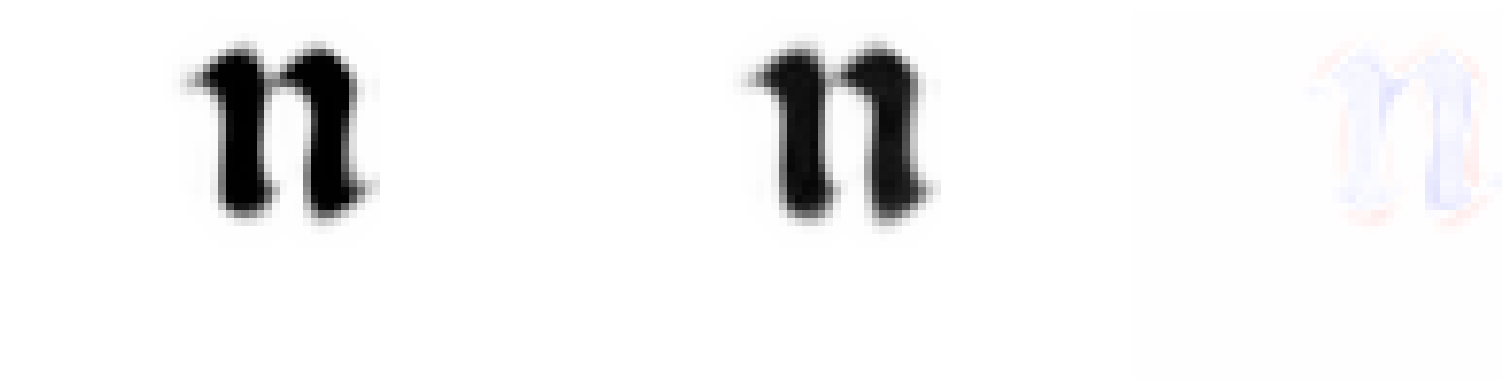

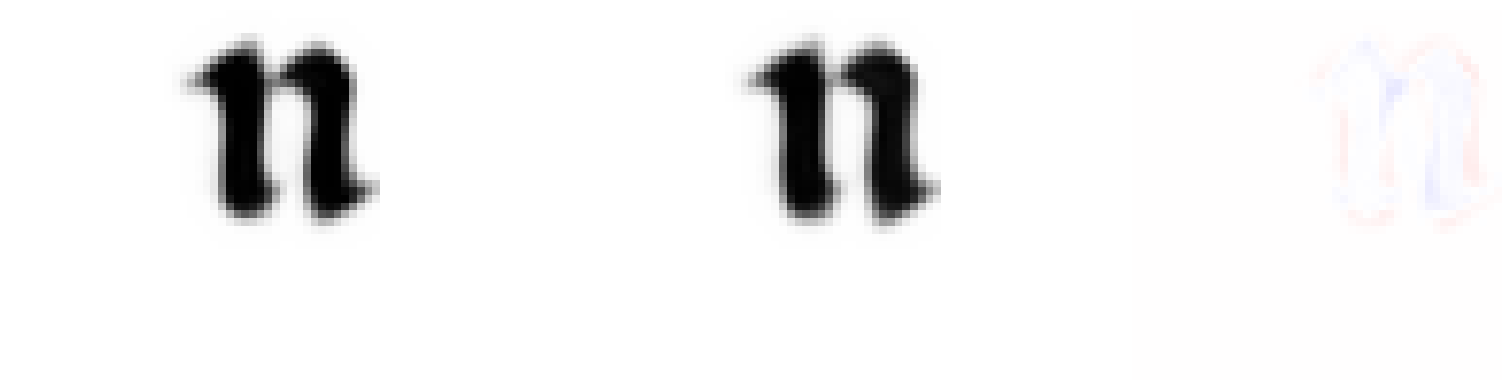

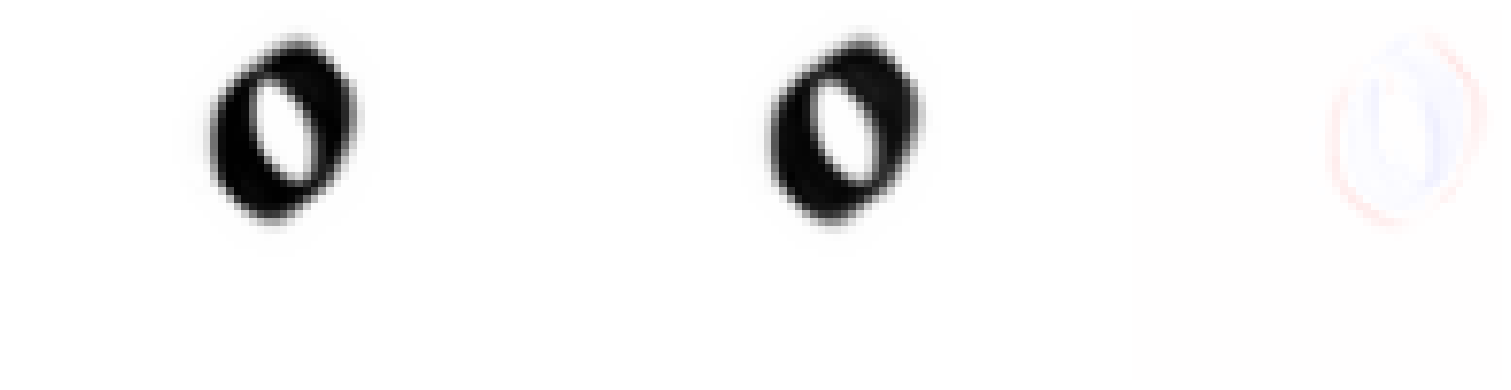

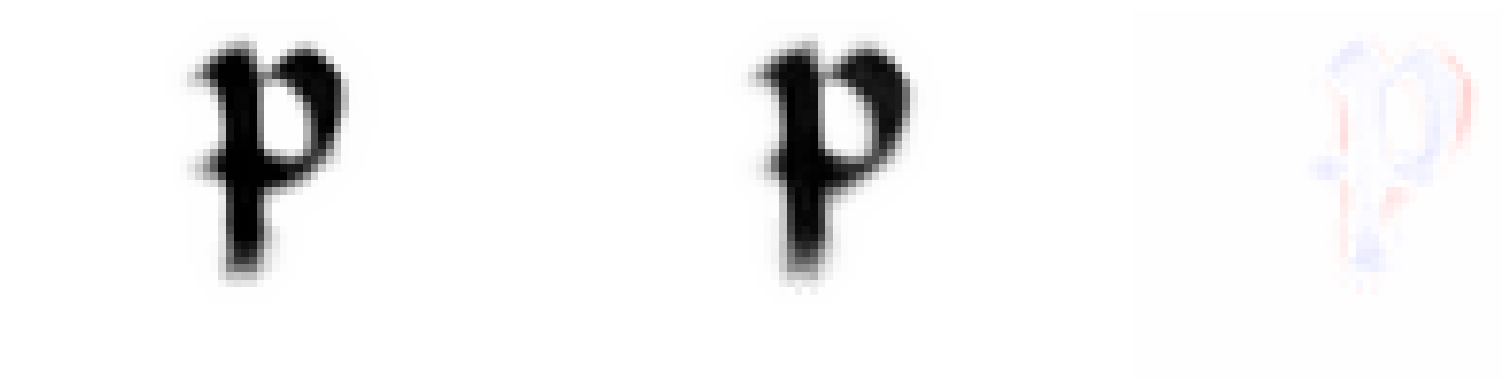

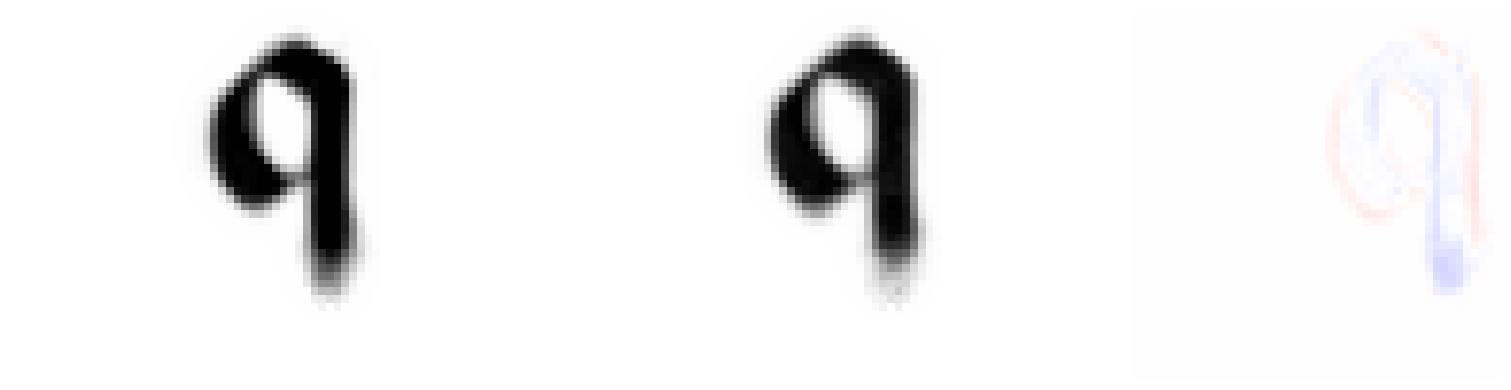

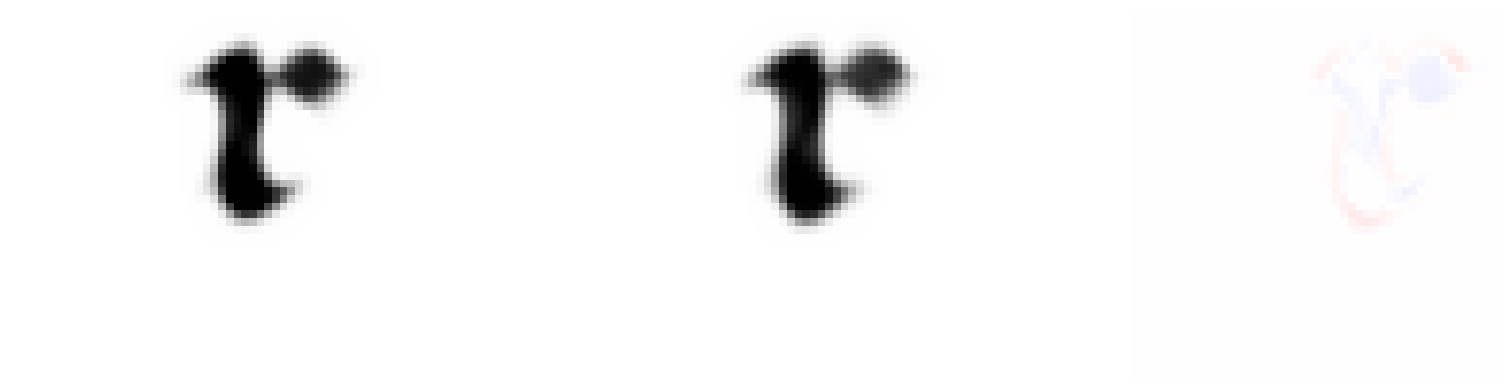

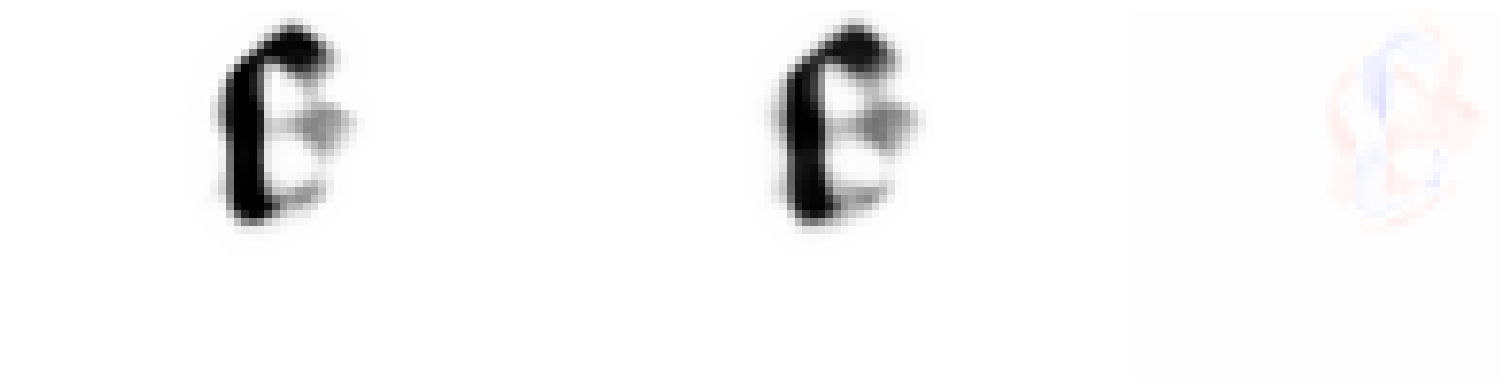

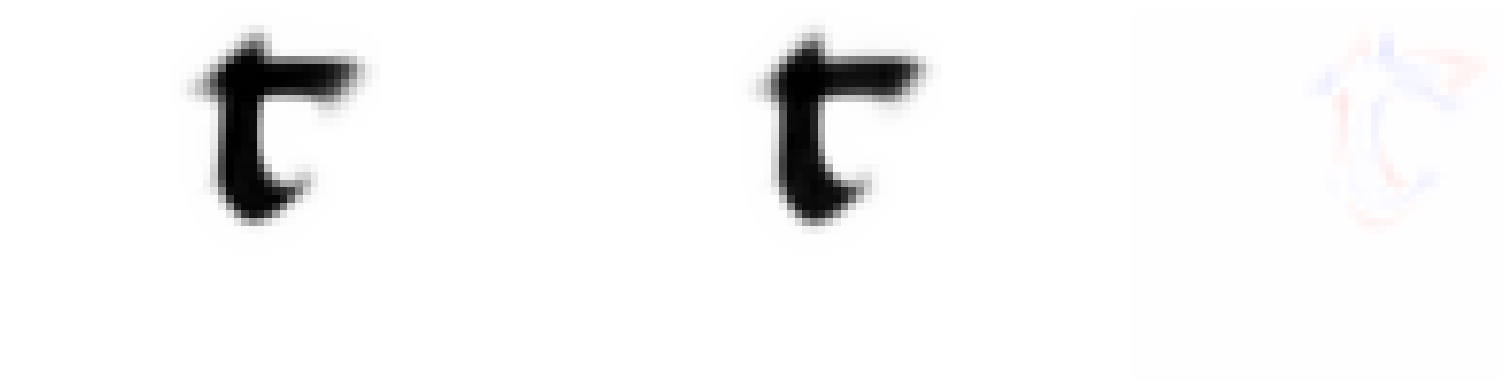

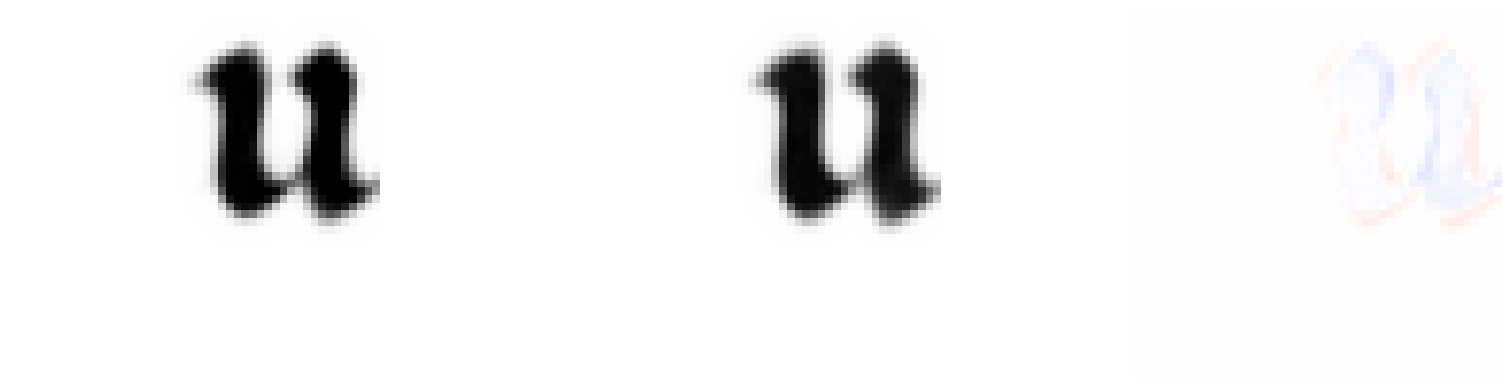

Processing folder: prototypes/filtered/btv1b90615126


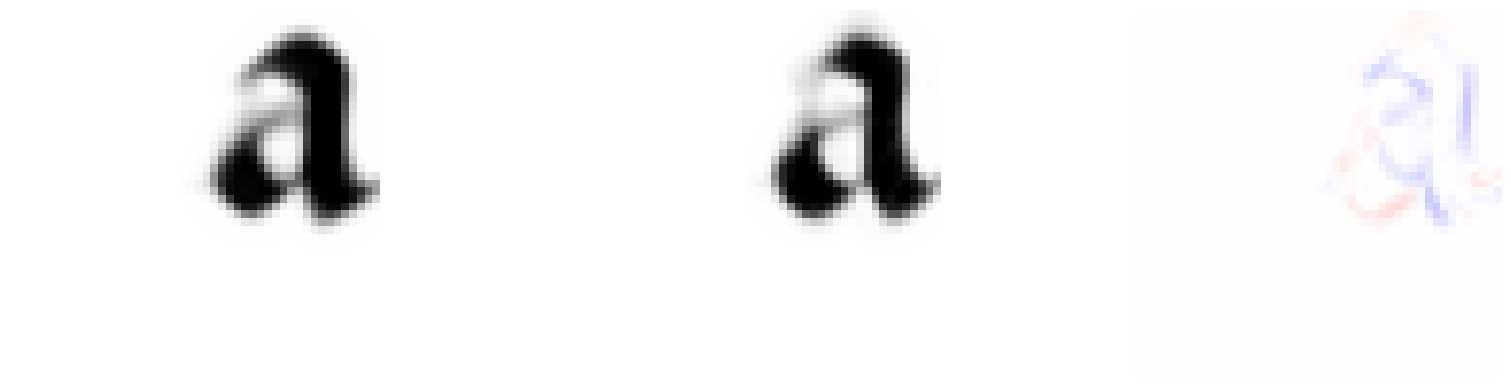

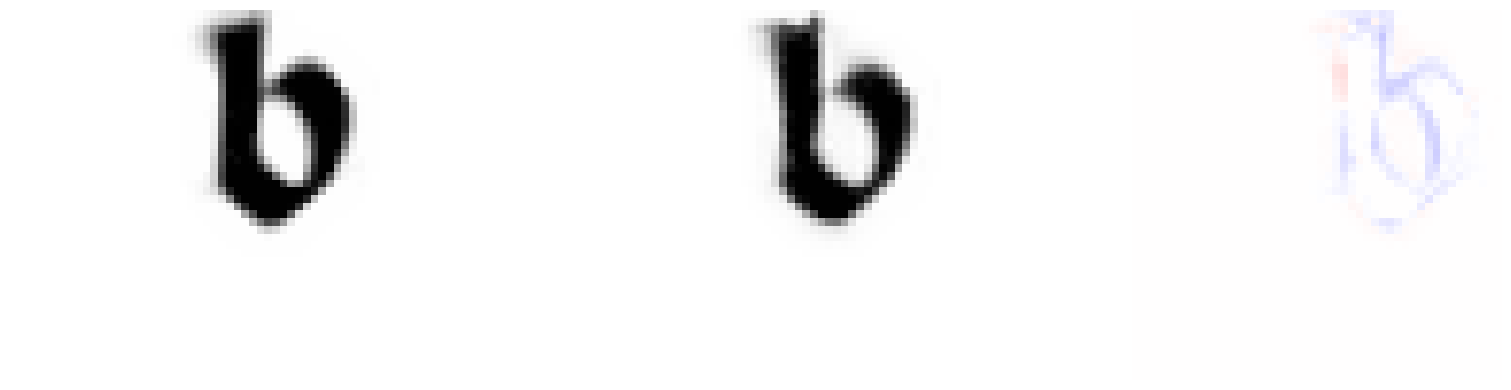

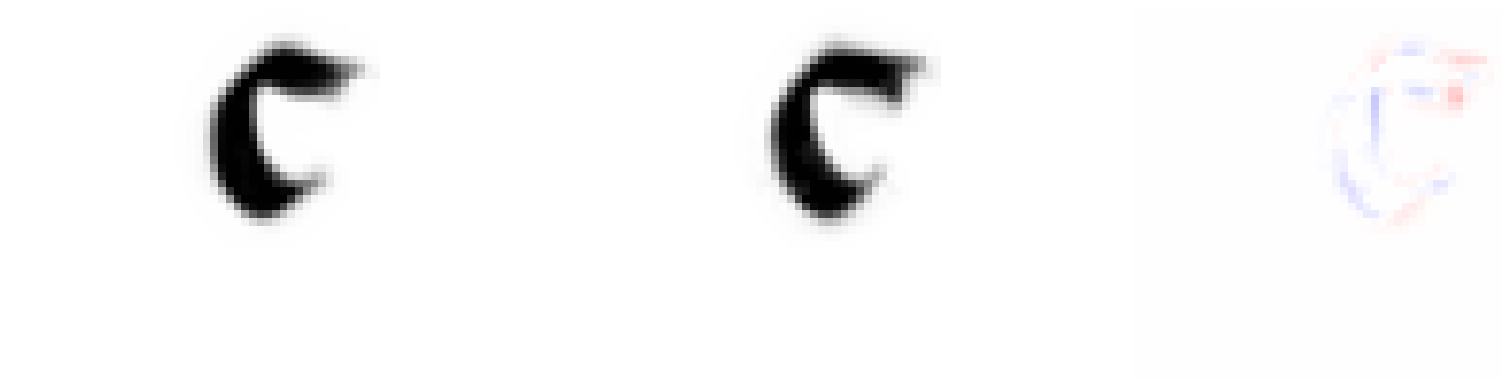

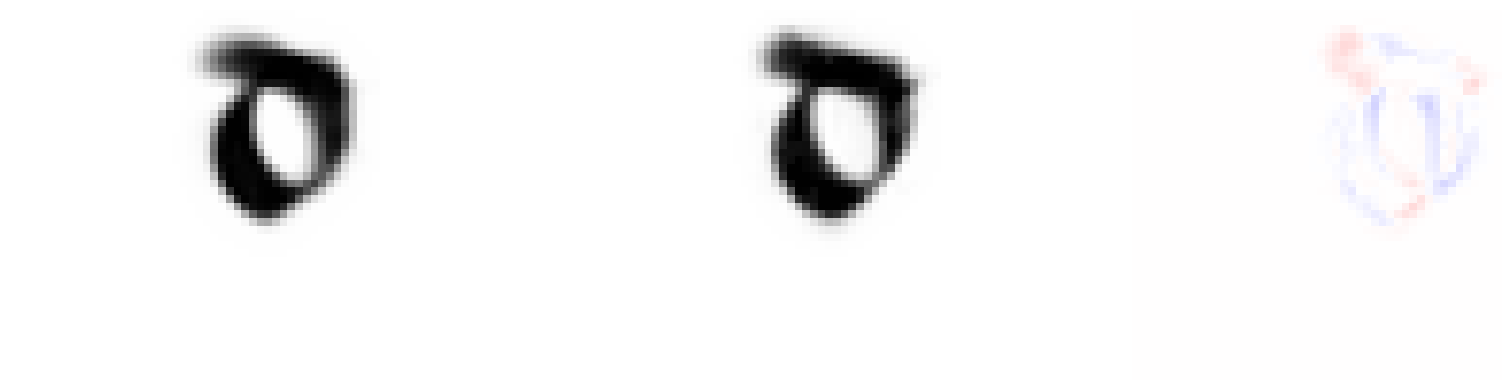

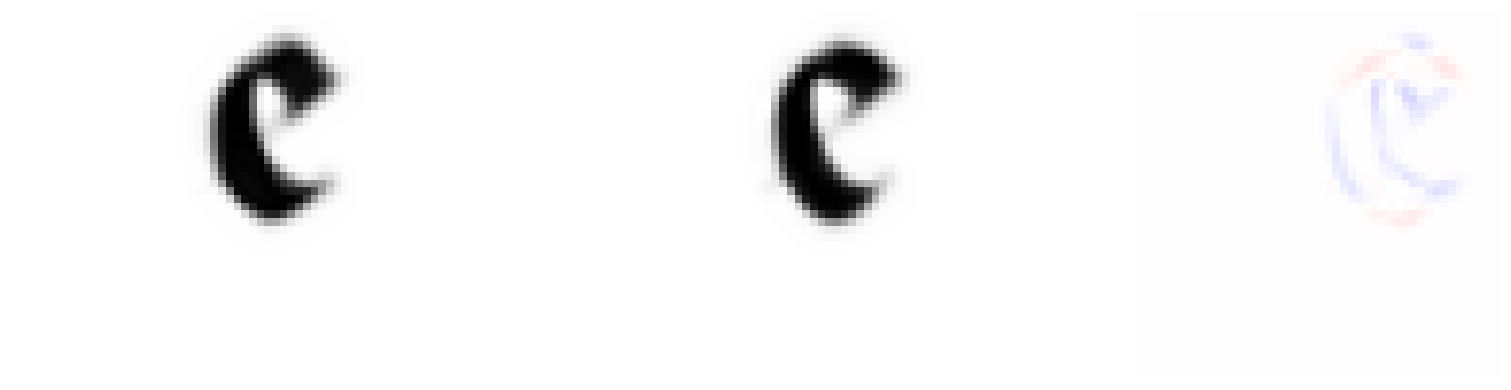

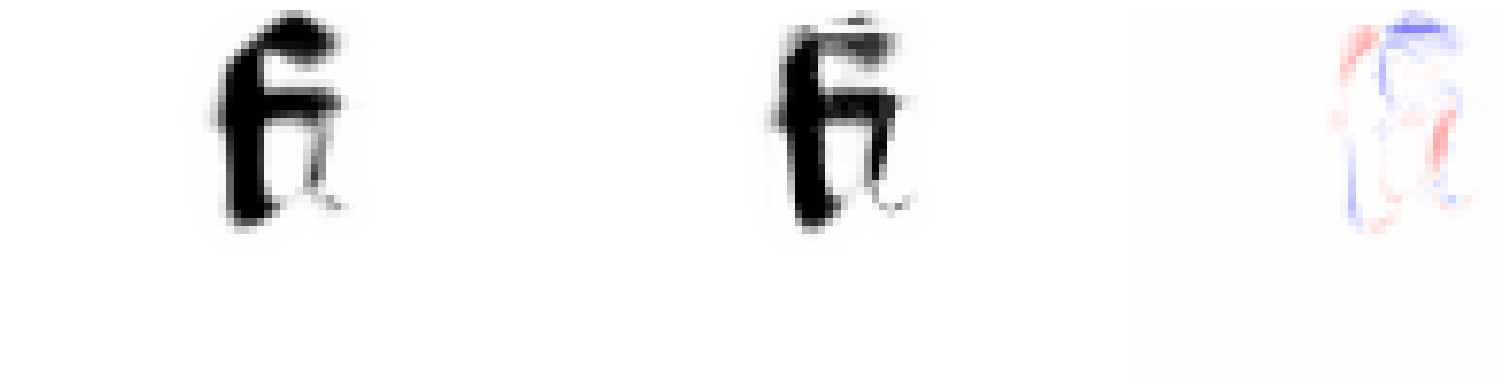

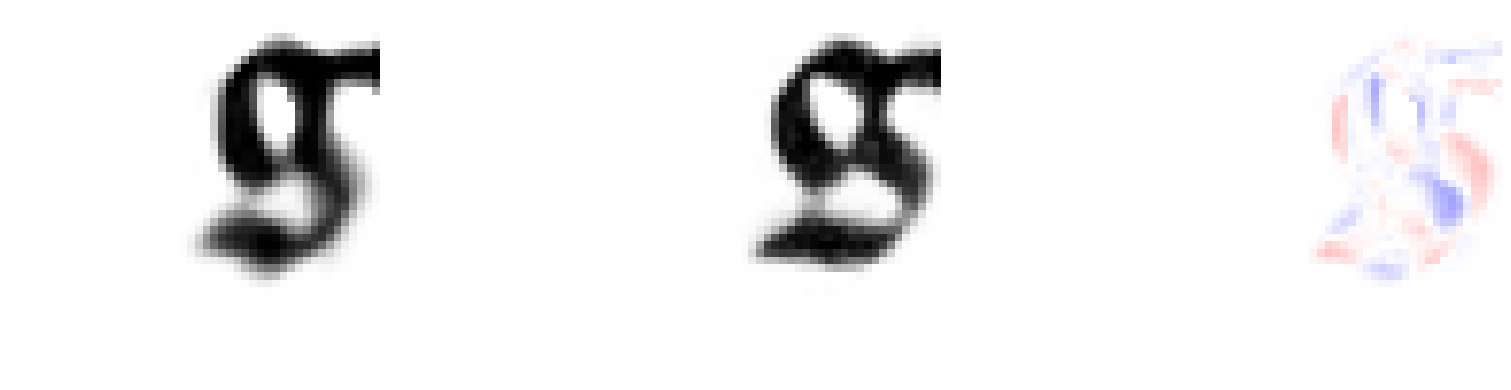

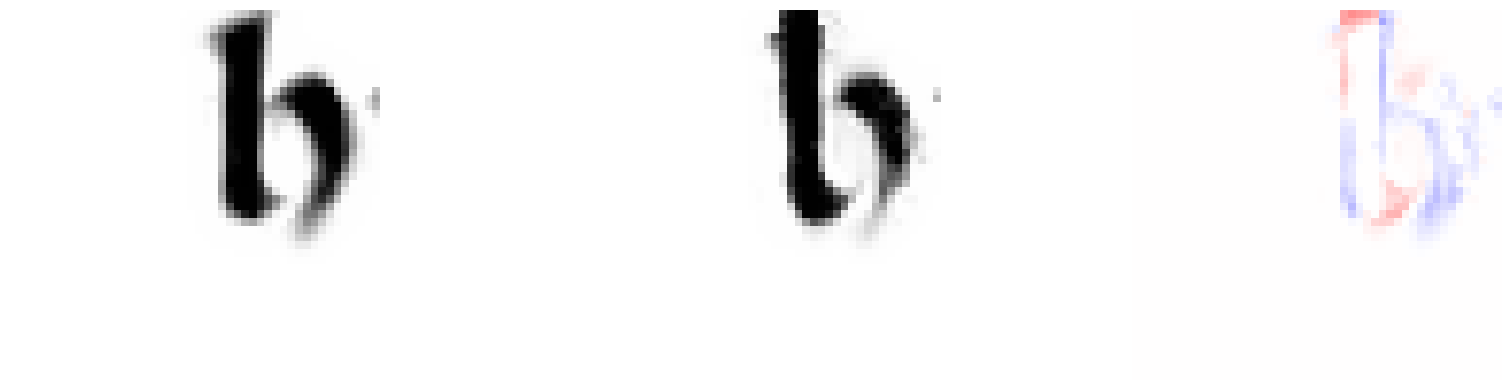

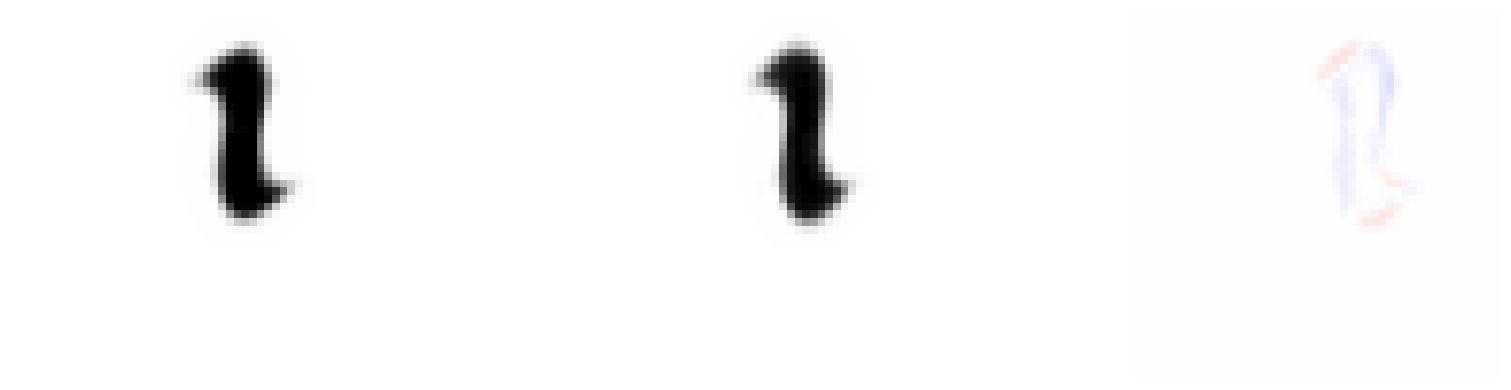

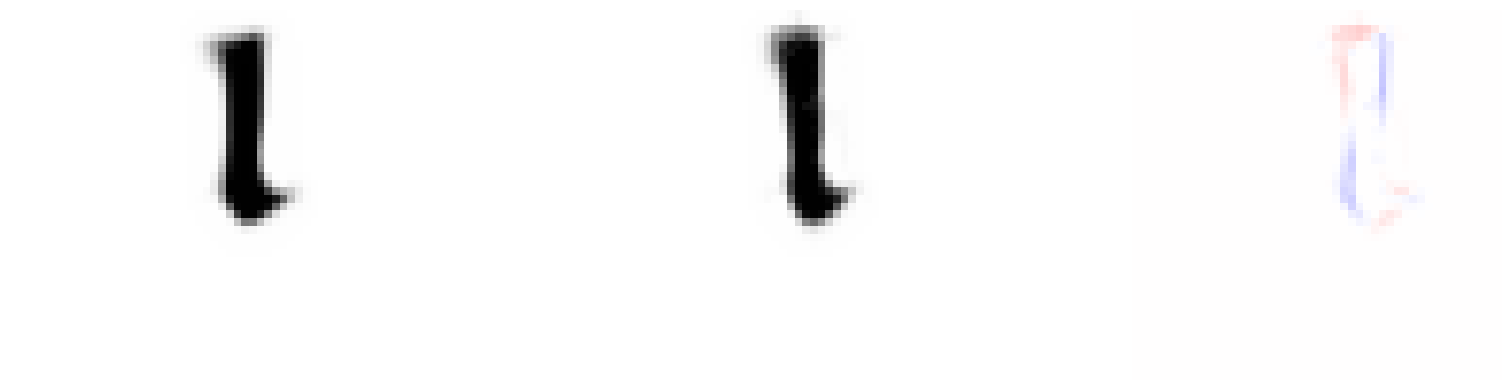

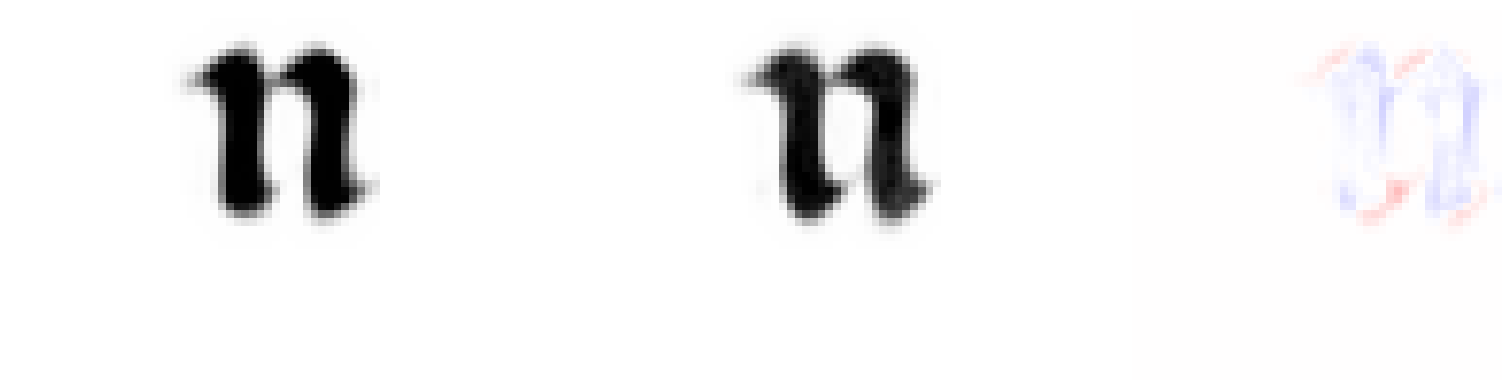

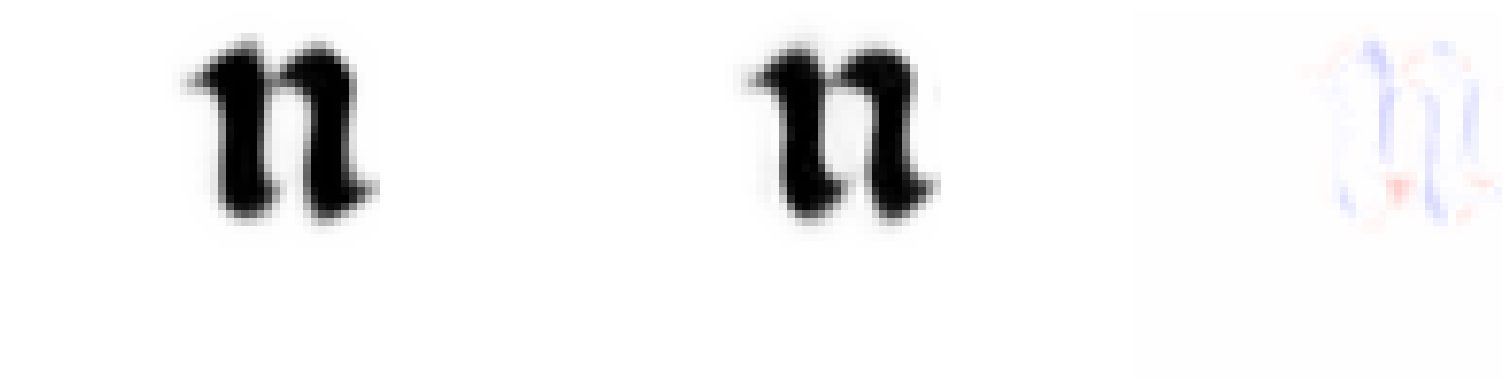

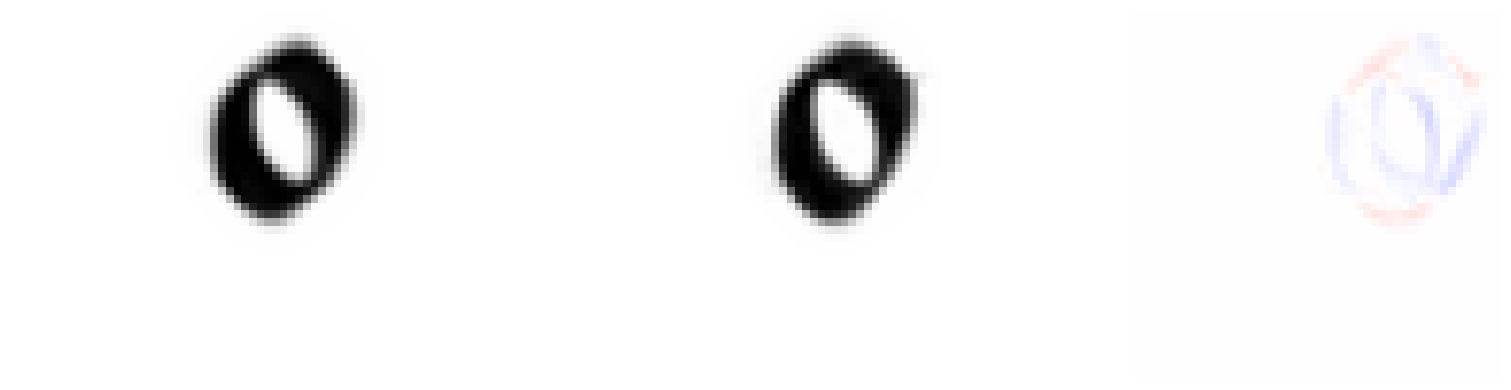

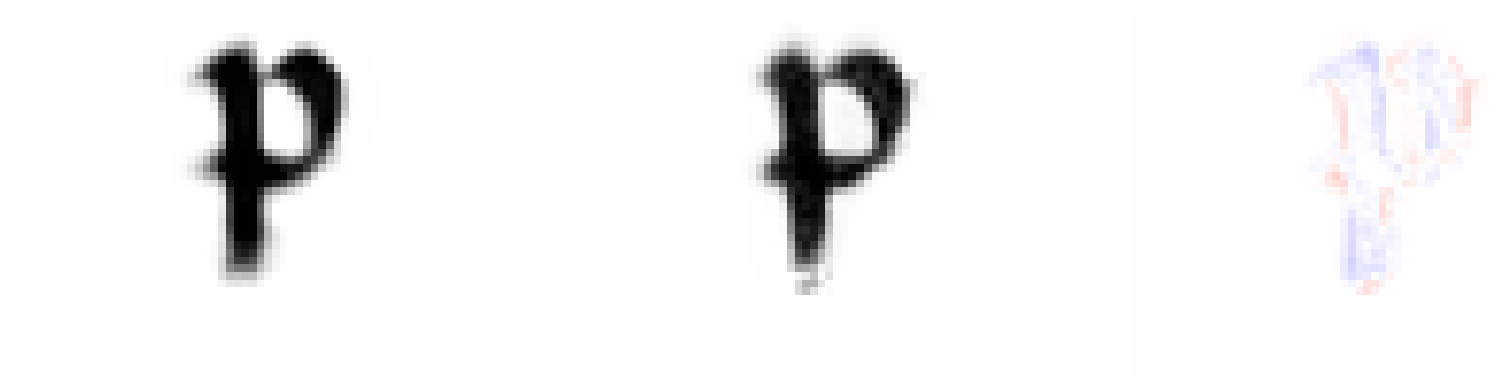

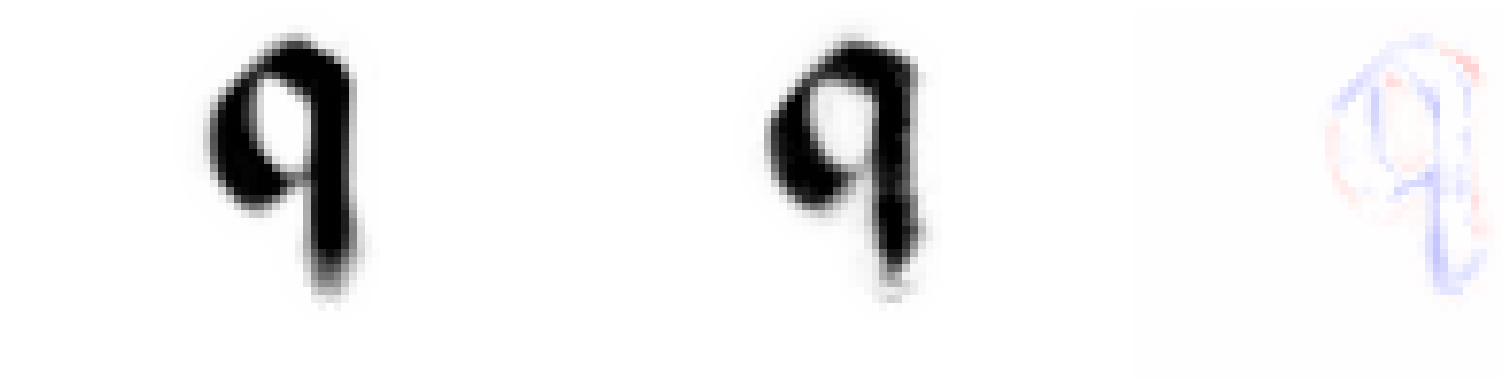

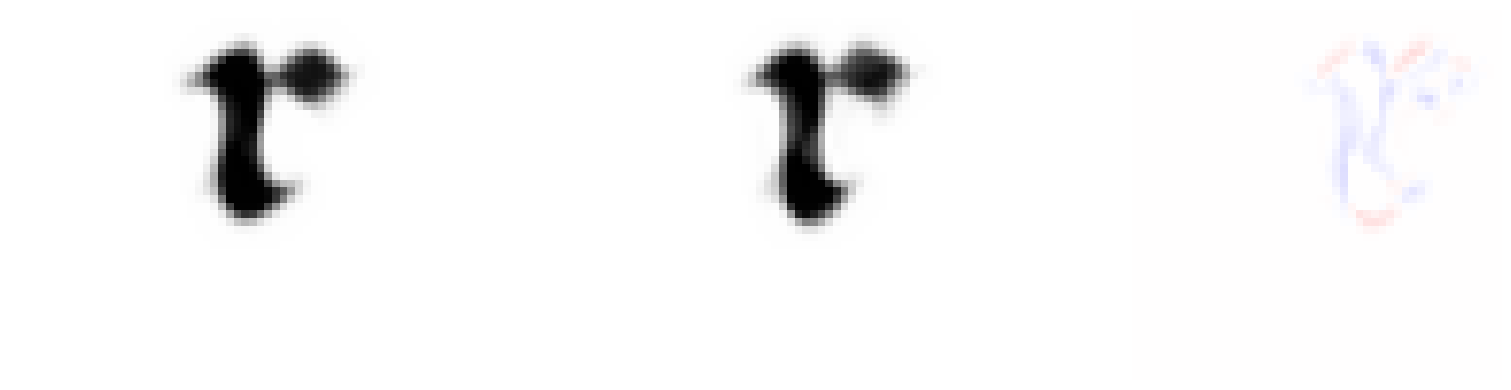

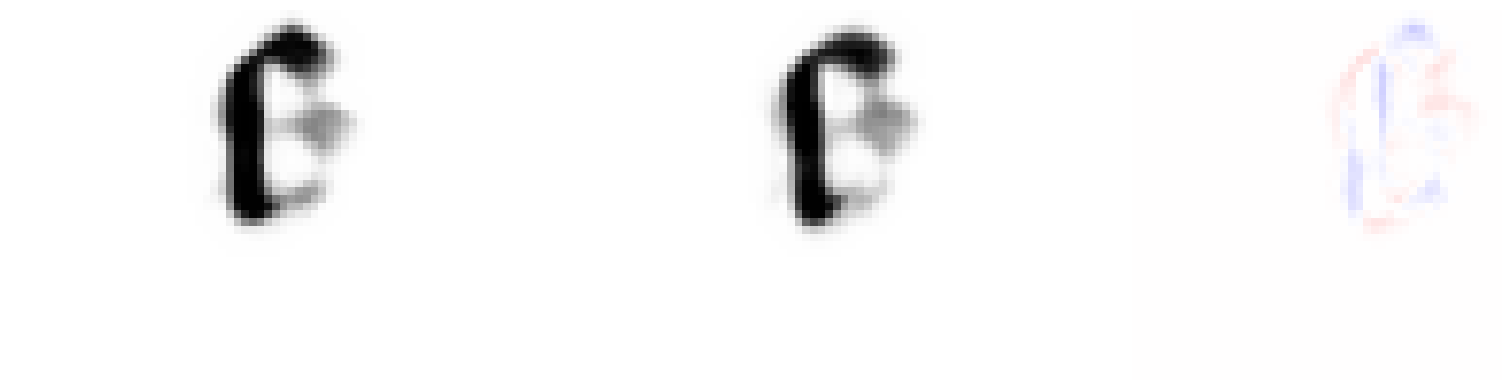

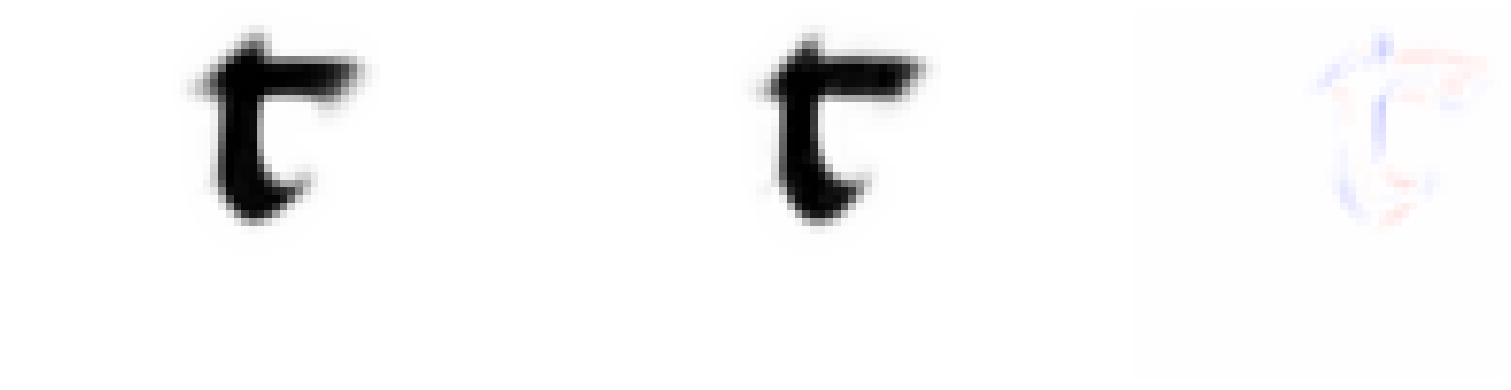

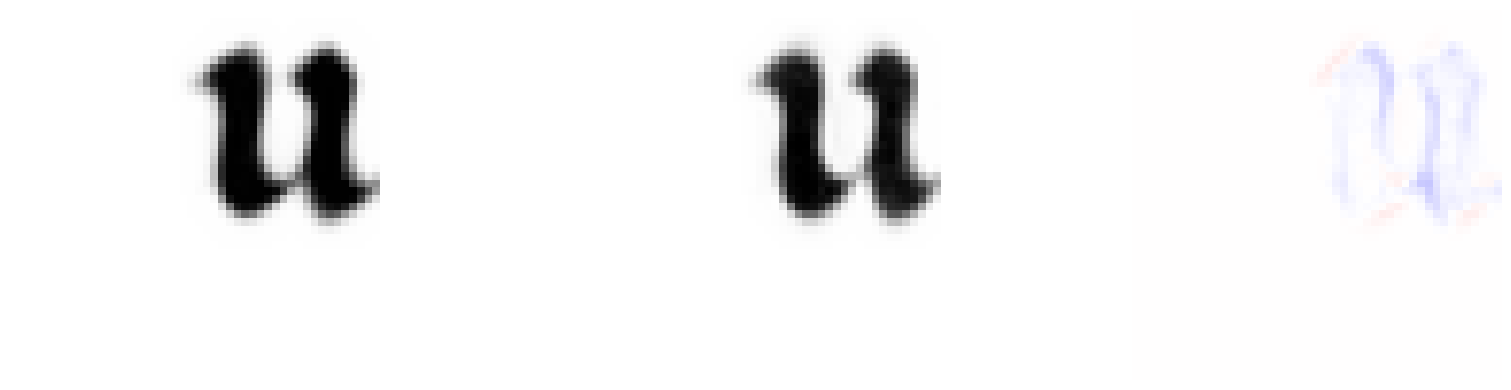

Processing folder: prototypes/filtered/btv1b100361755


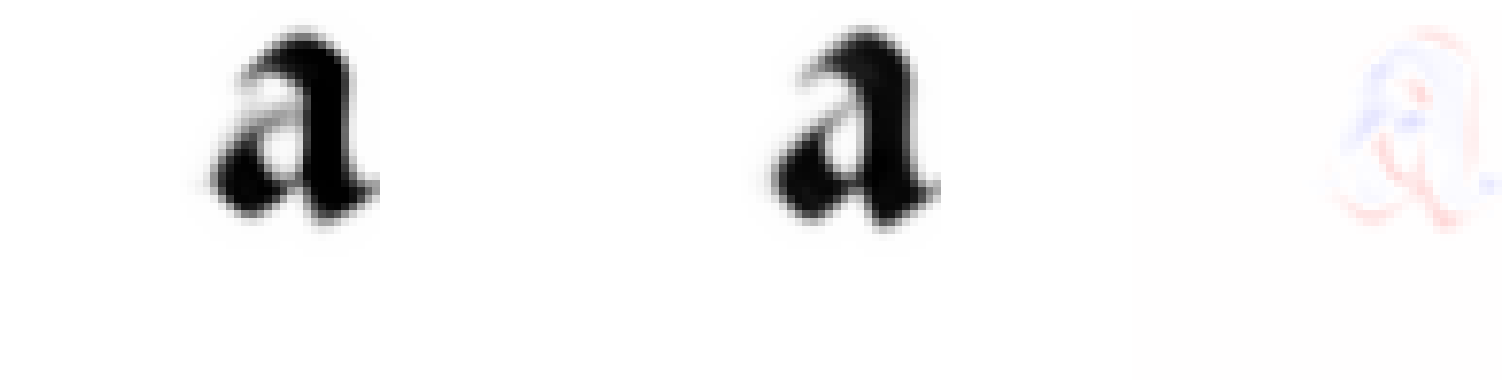

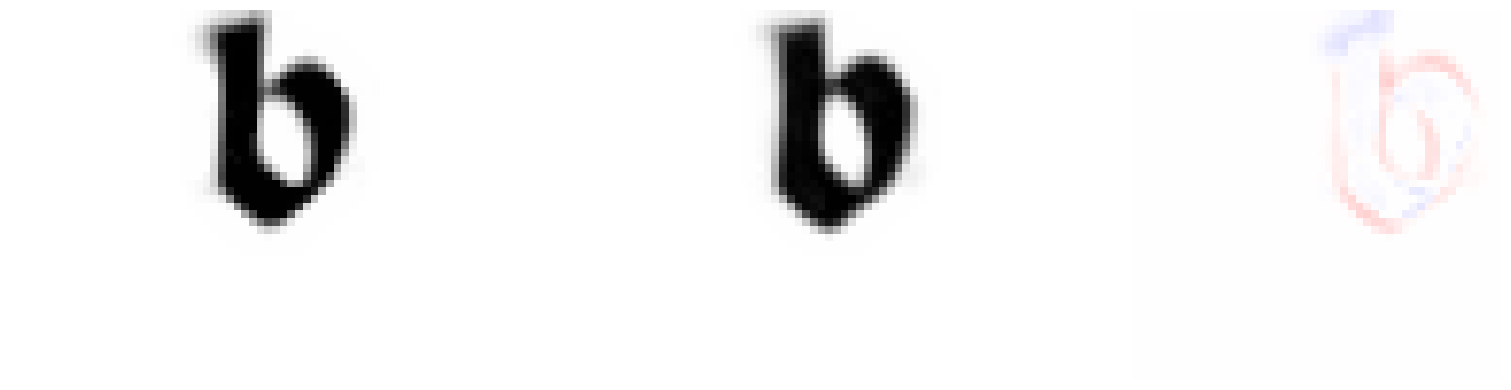

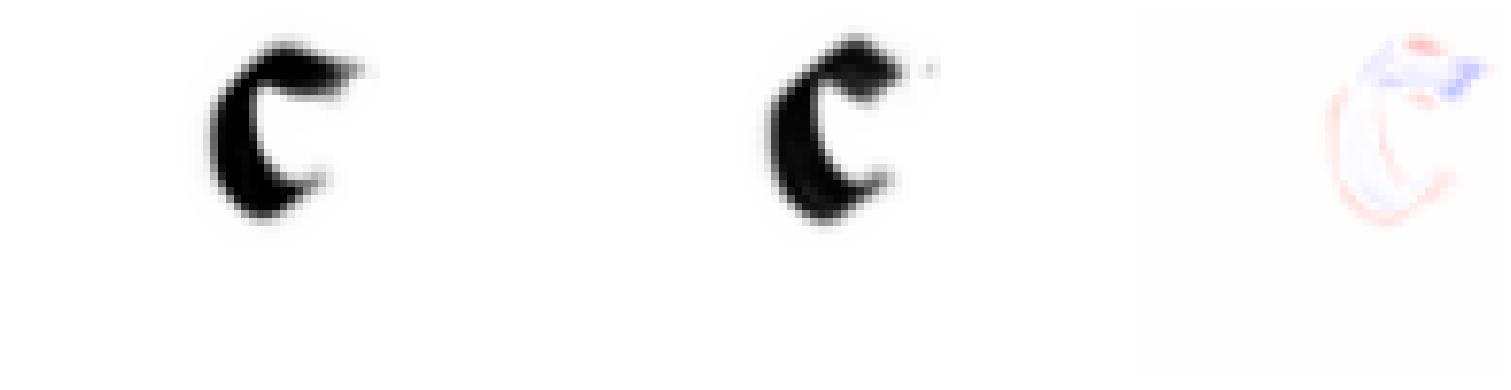

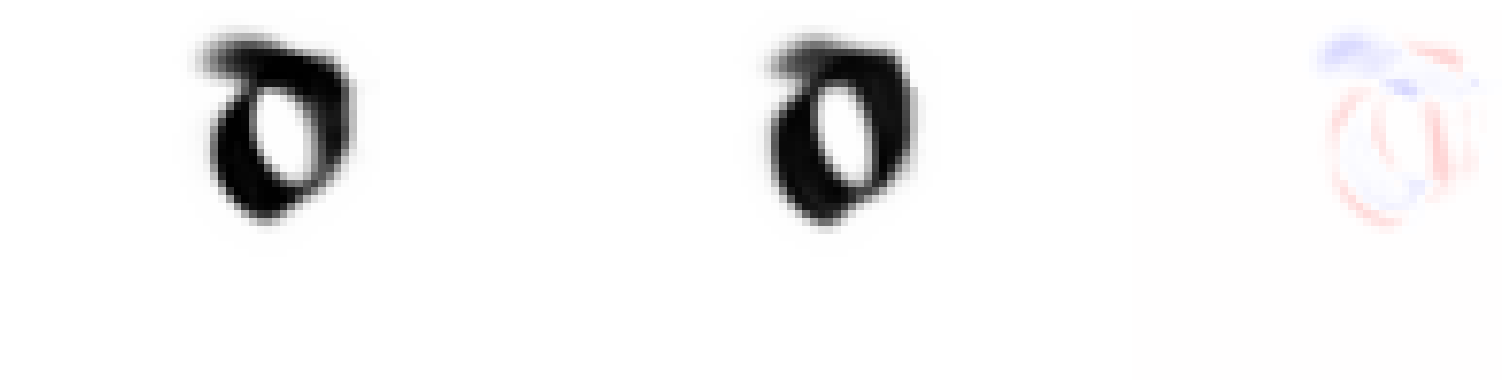

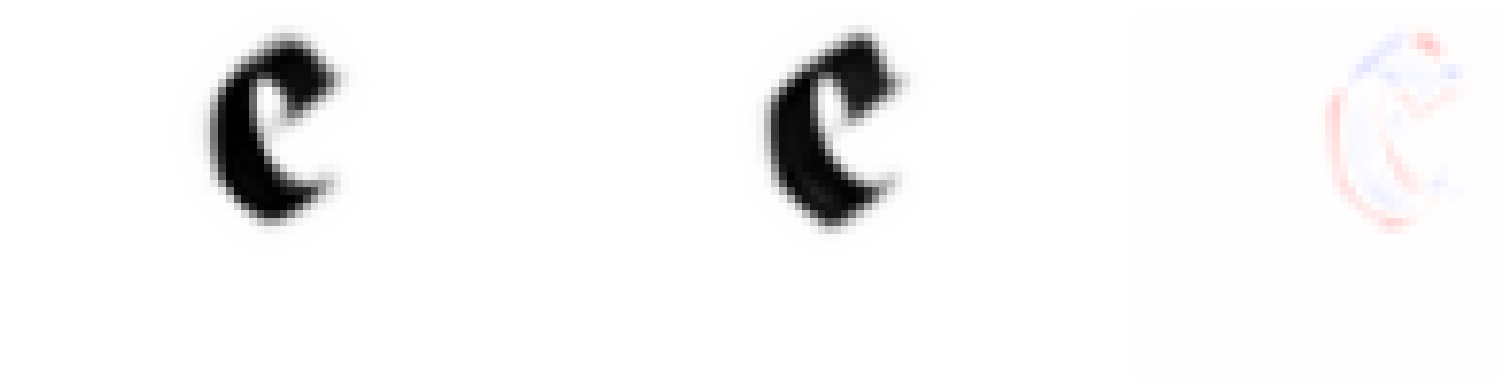

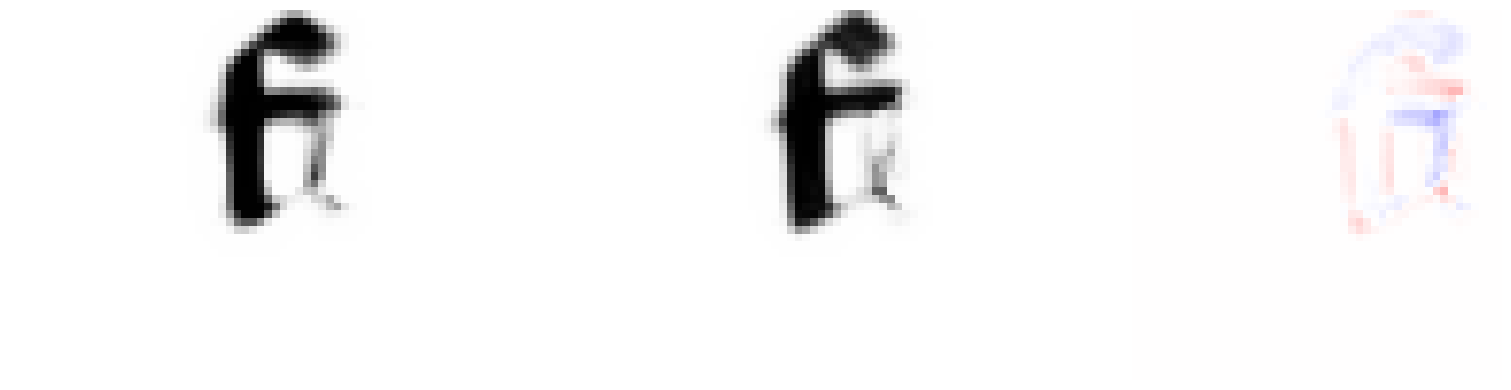

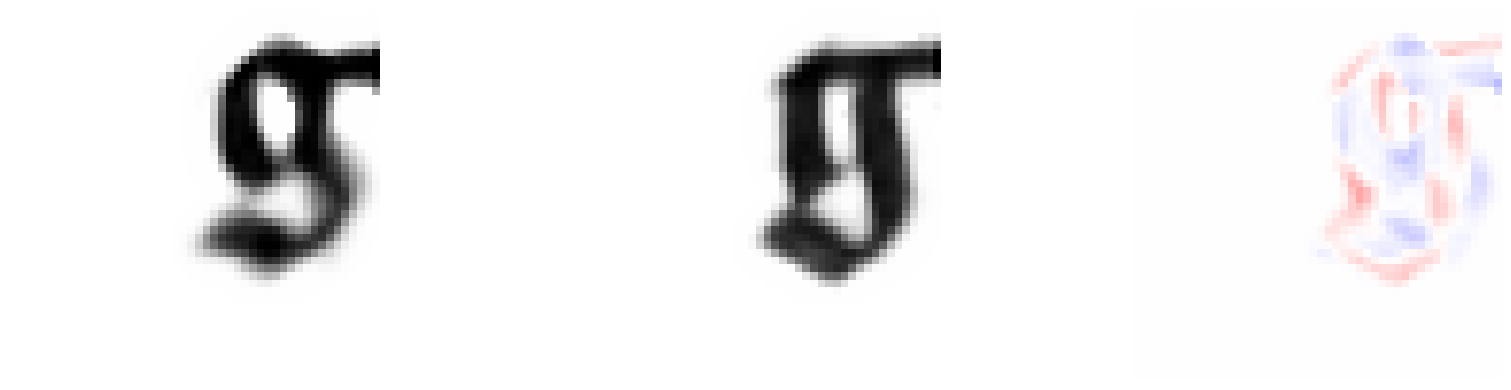

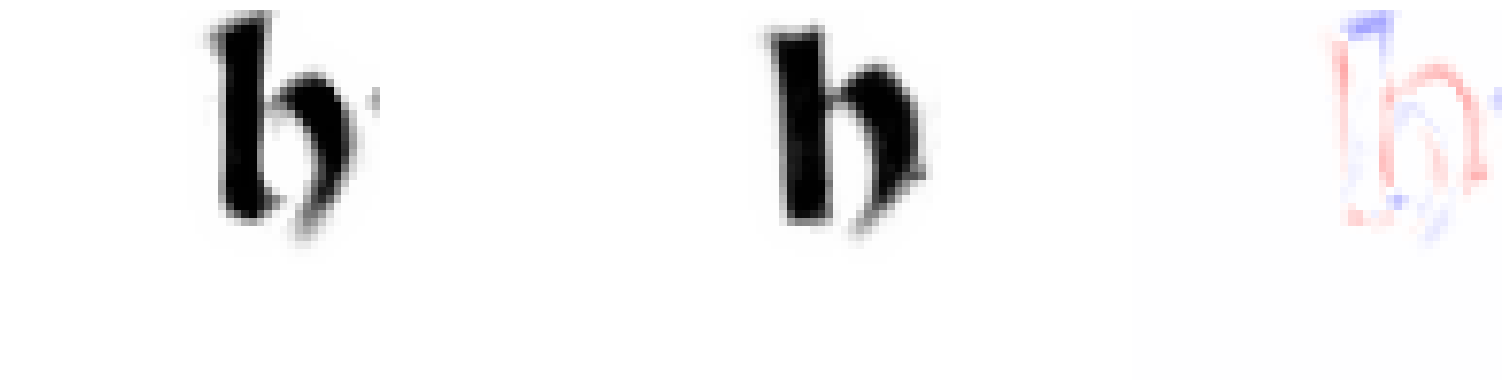

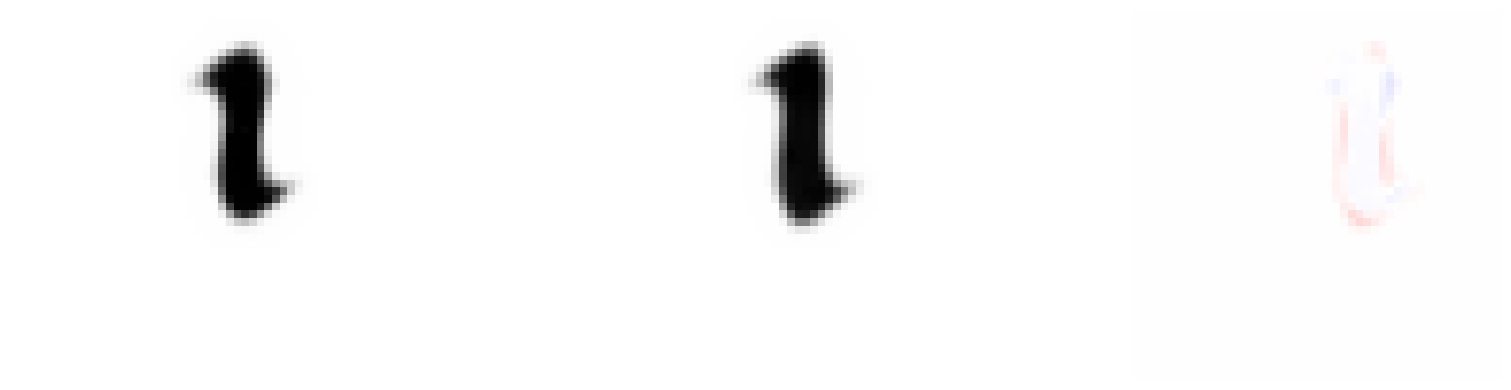

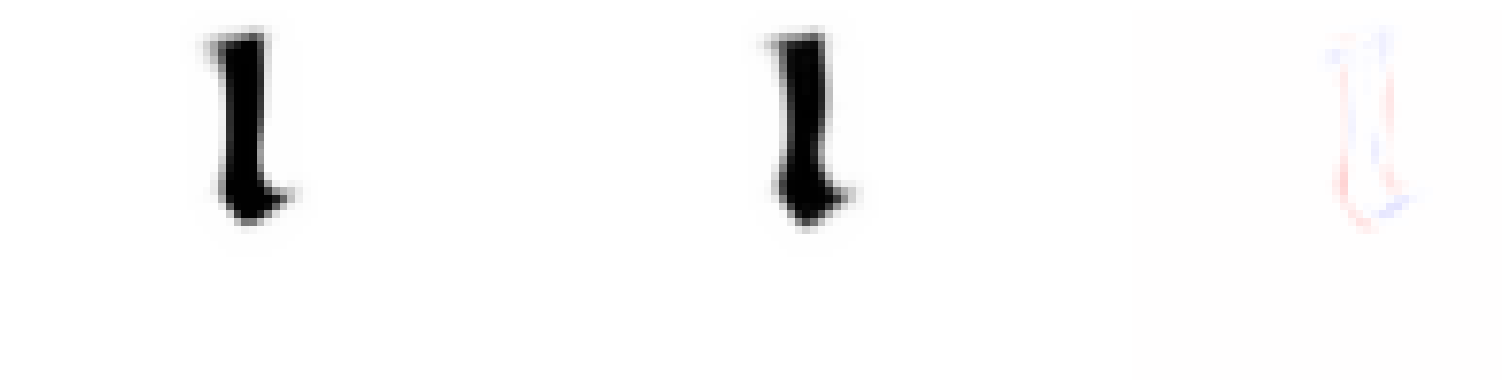

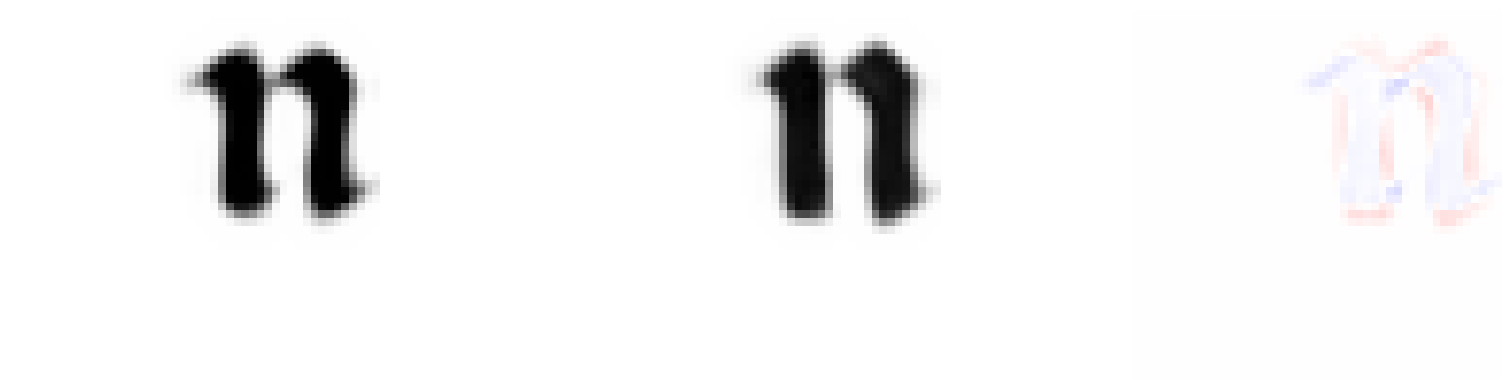

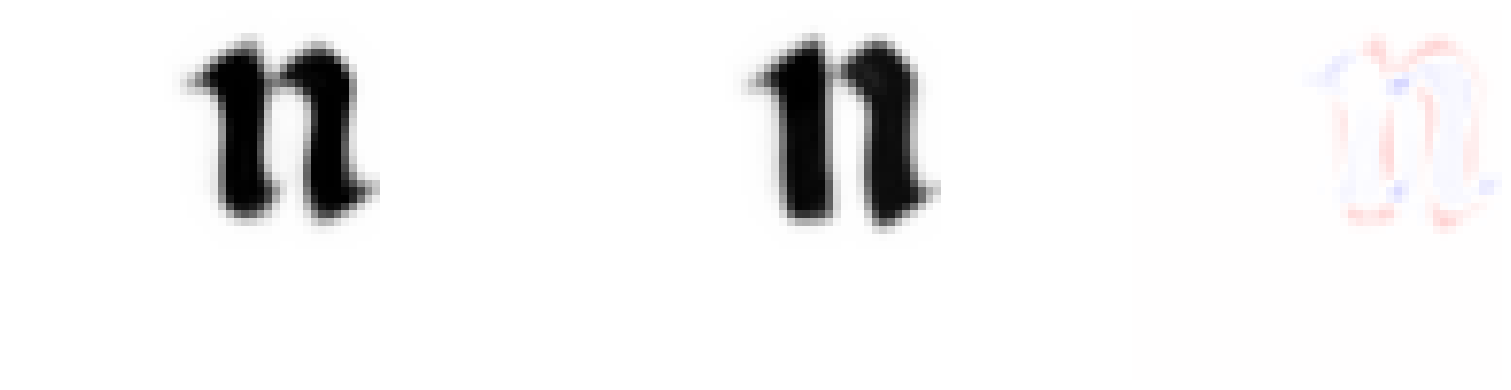

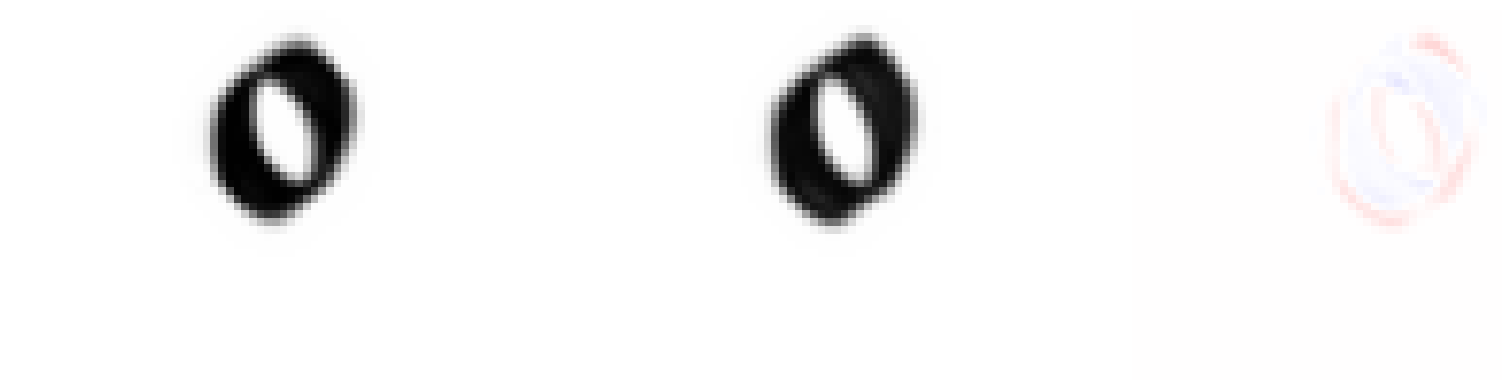

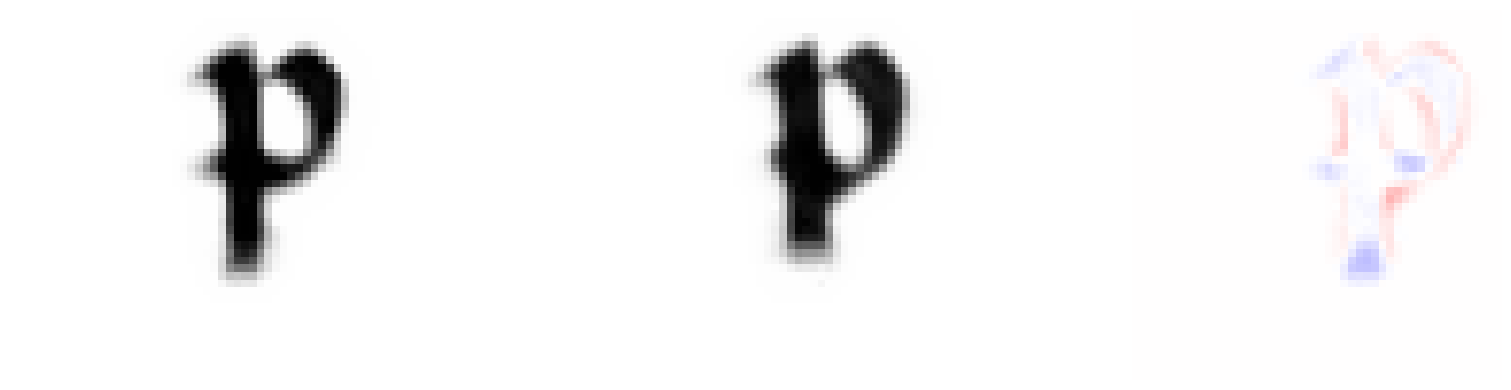

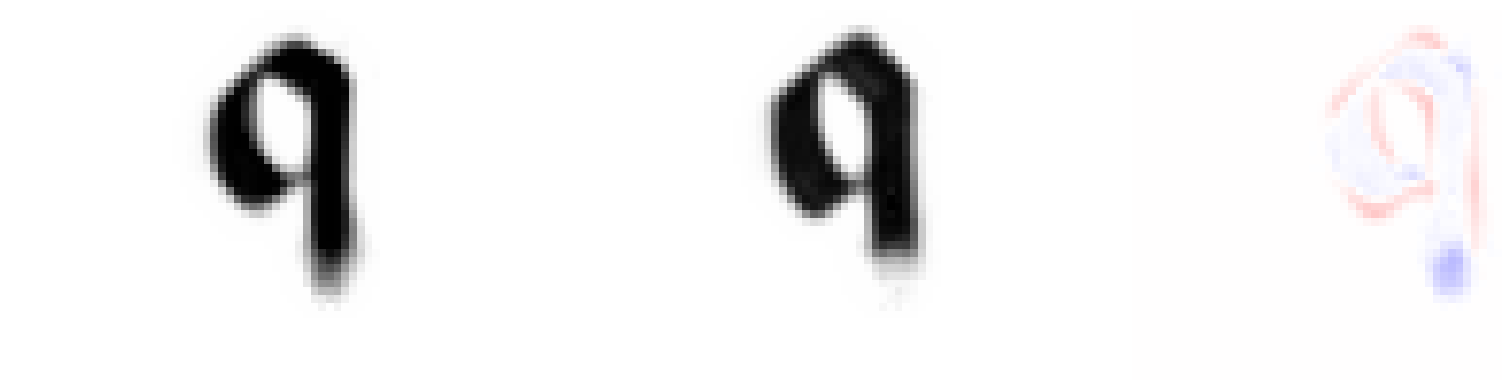

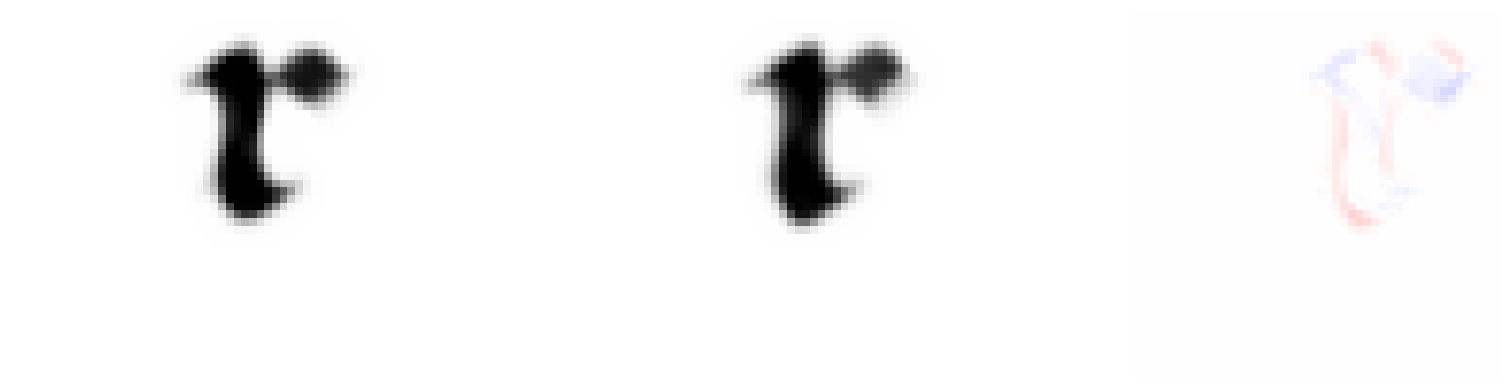

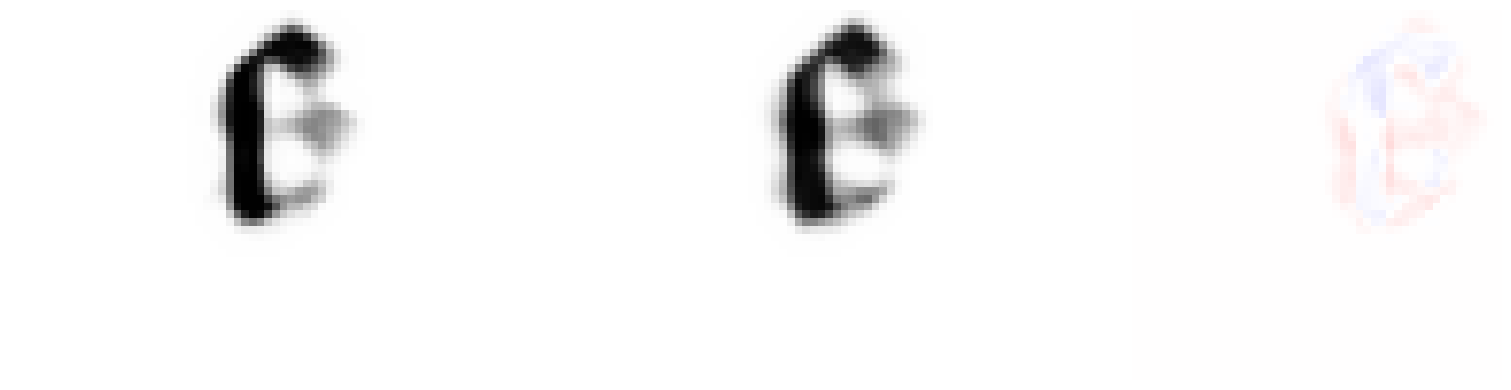

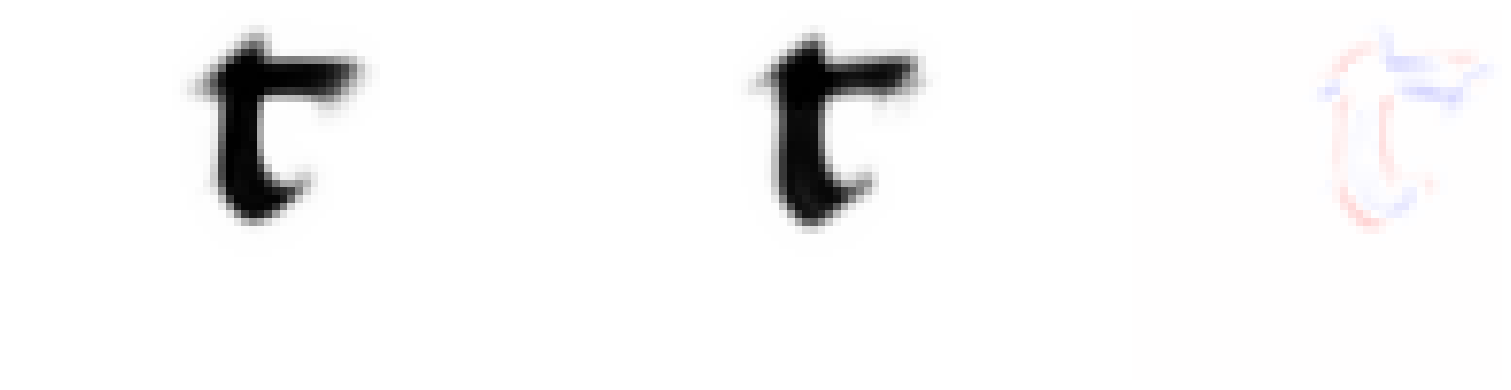

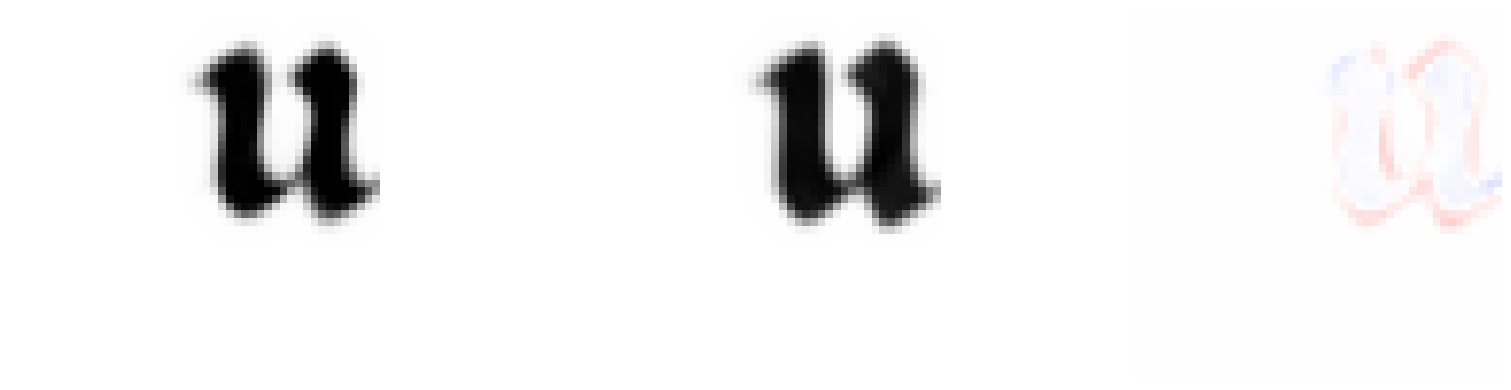

Processing folder: prototypes/filtered/btv1b8433319z


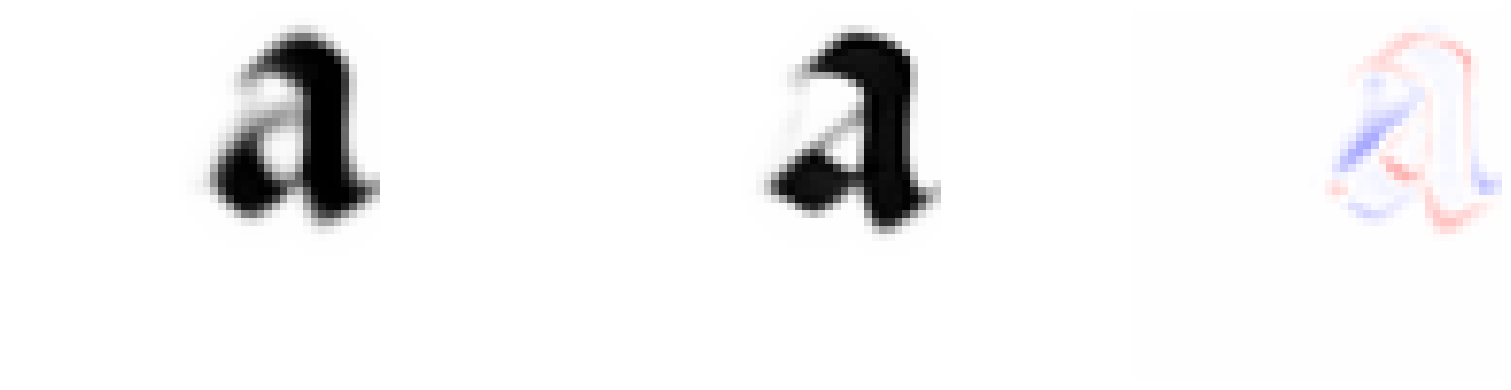

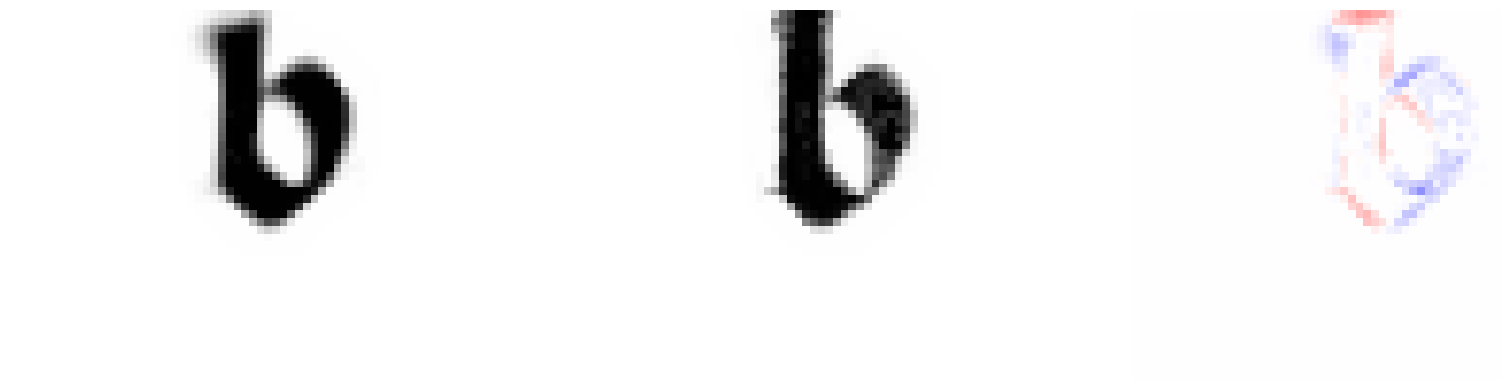

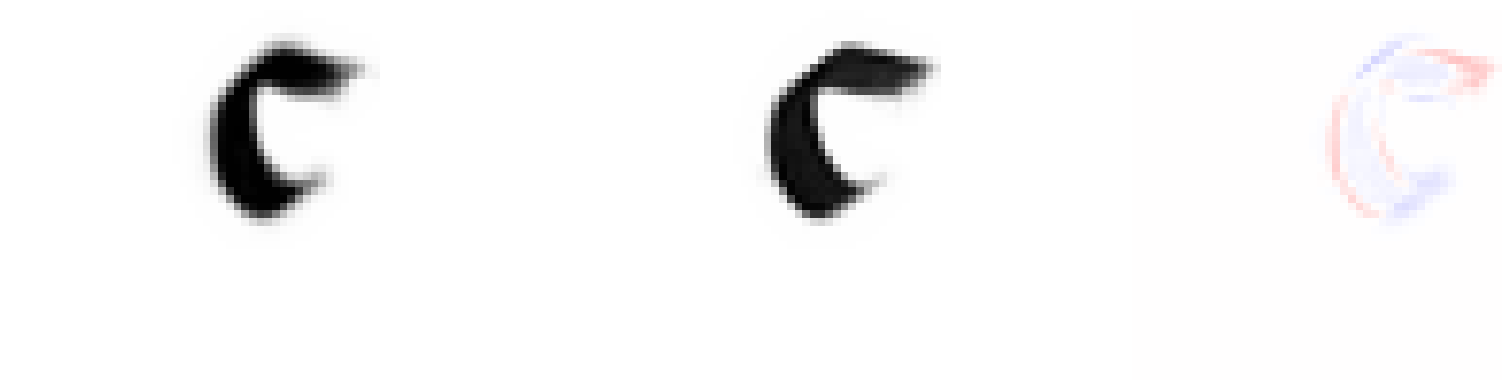

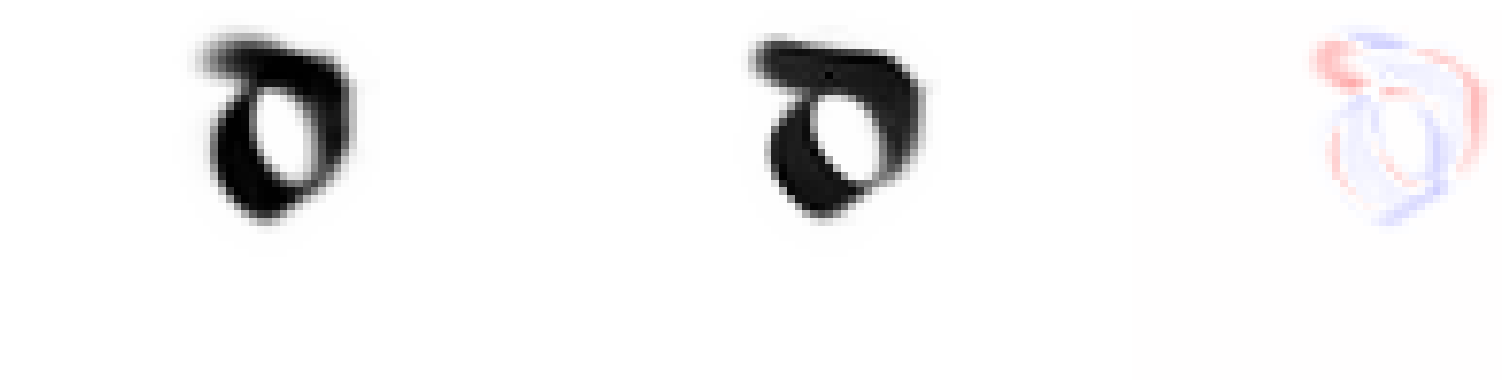

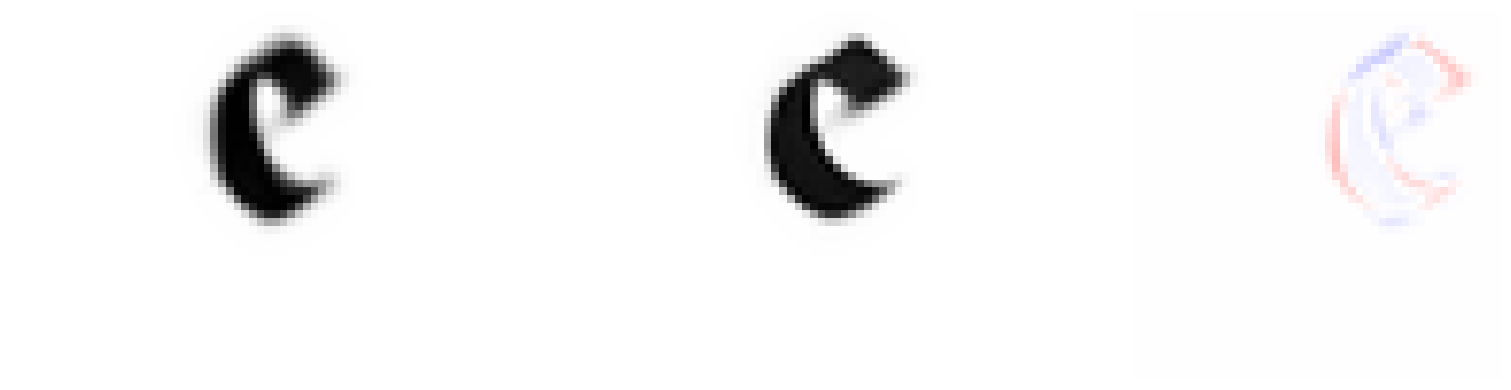

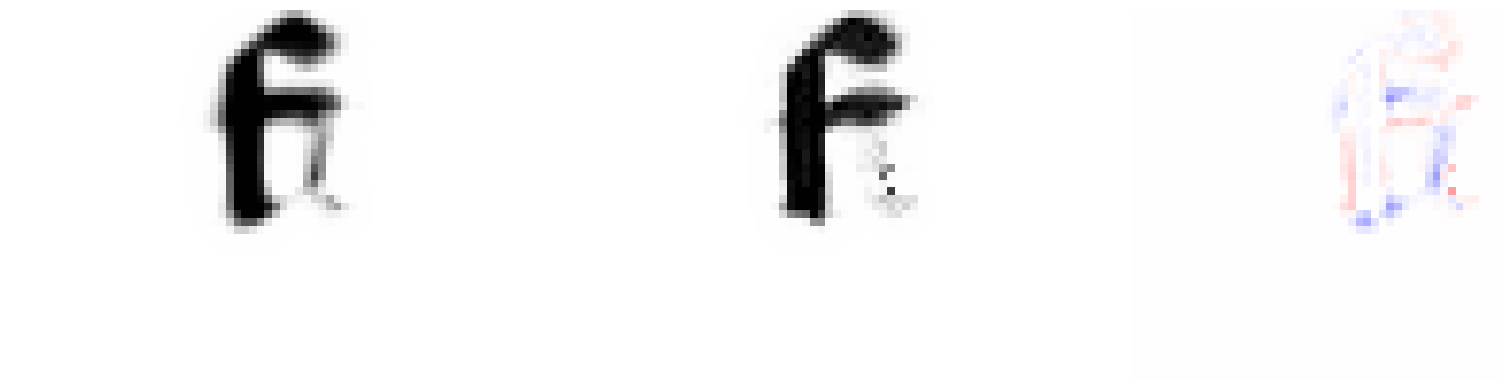

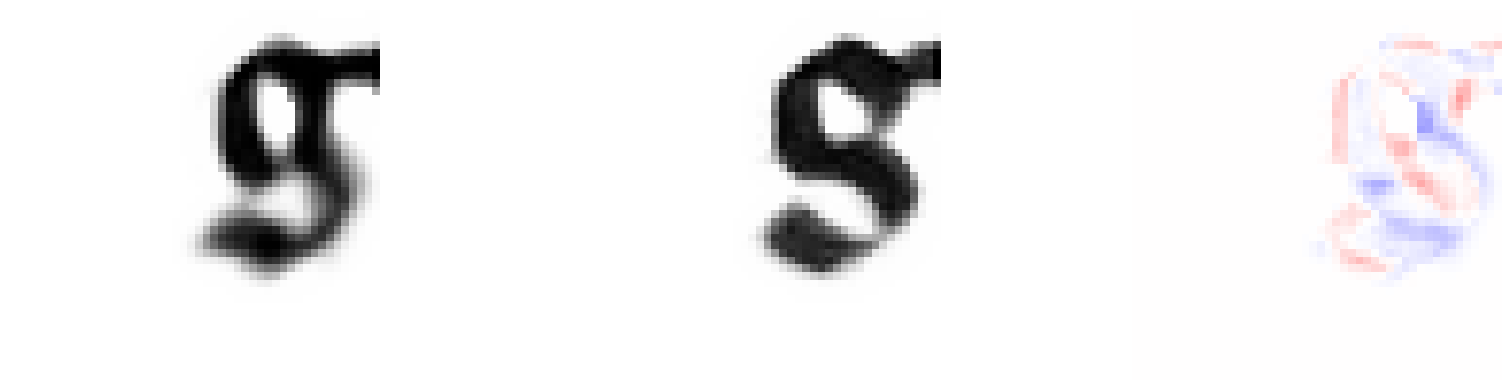

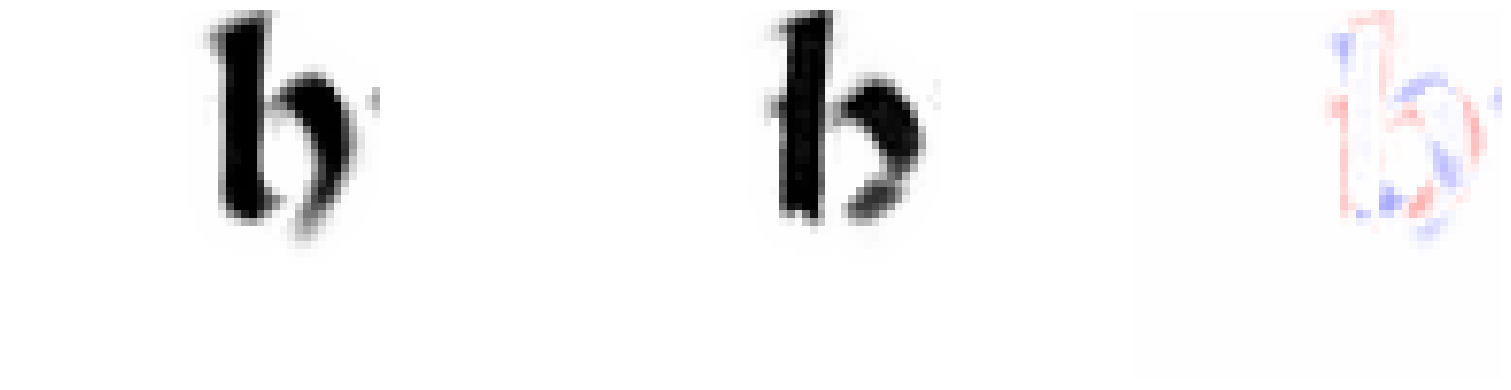

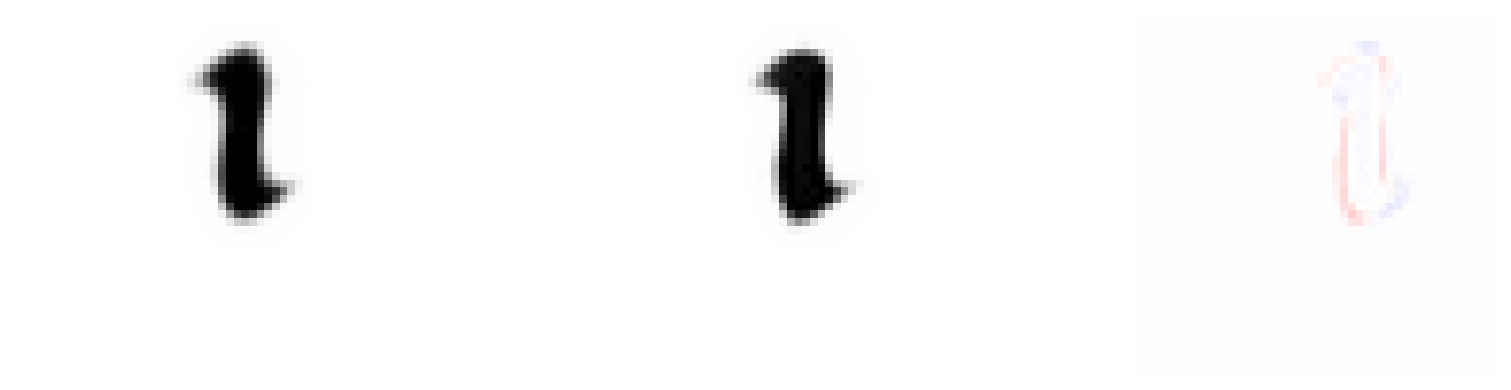

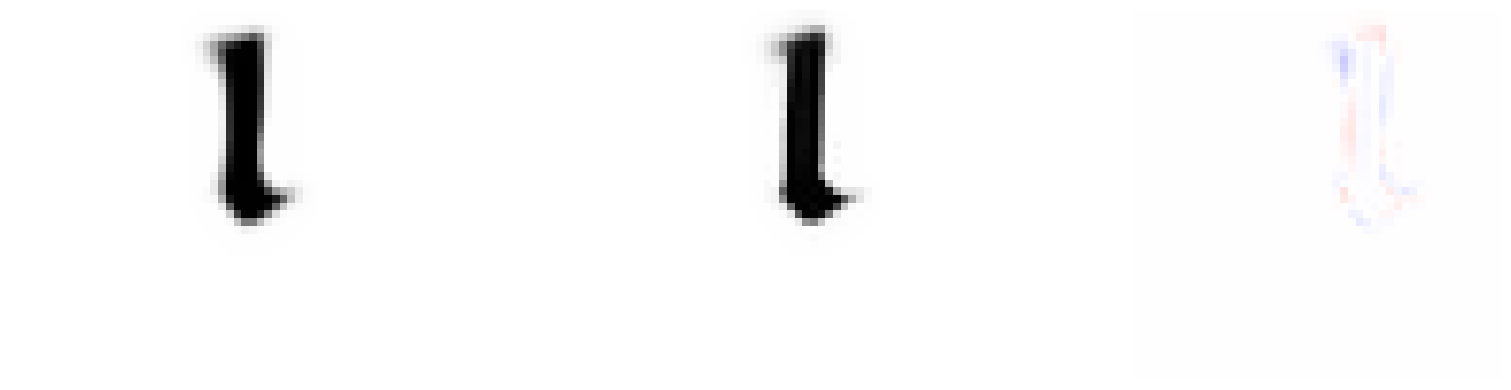

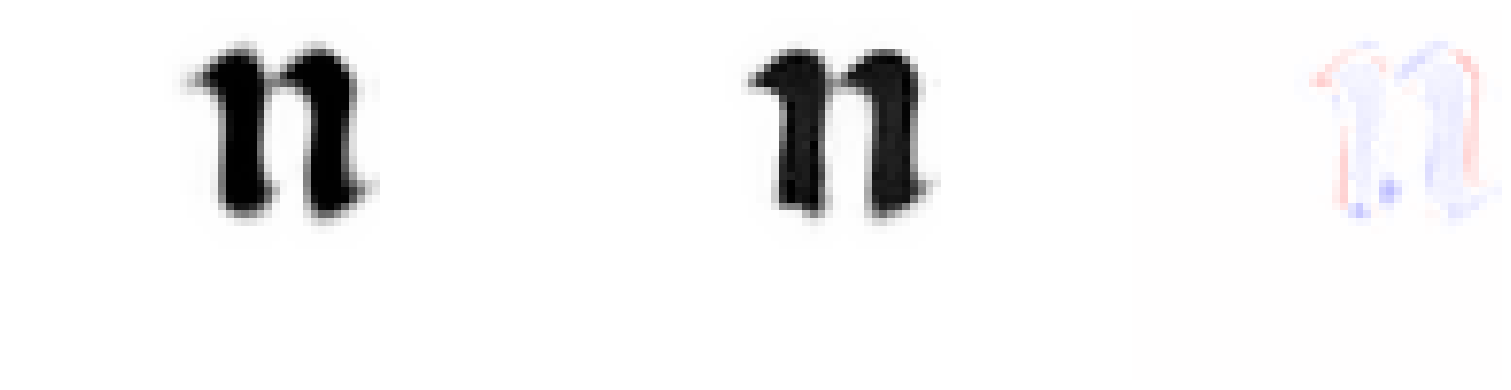

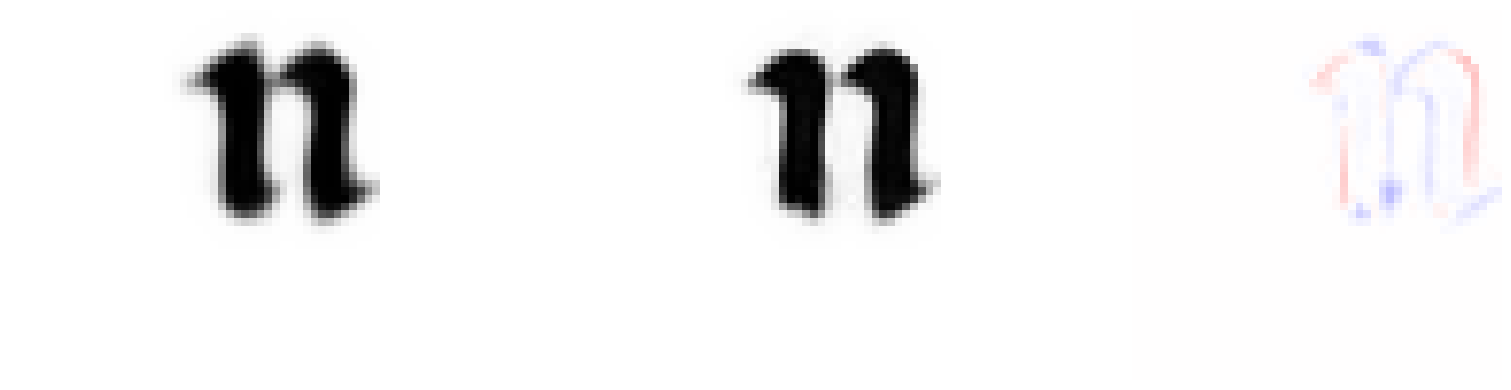

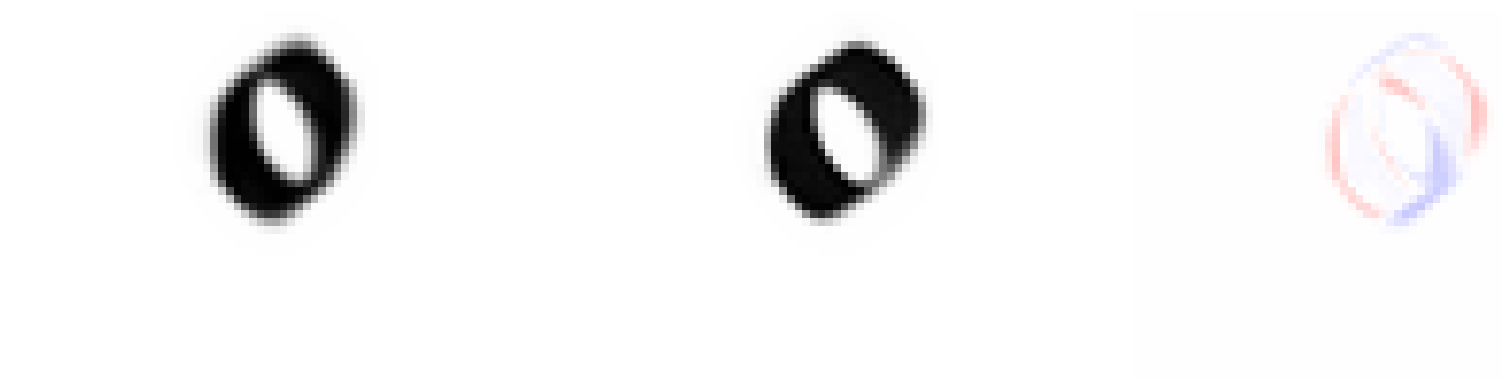

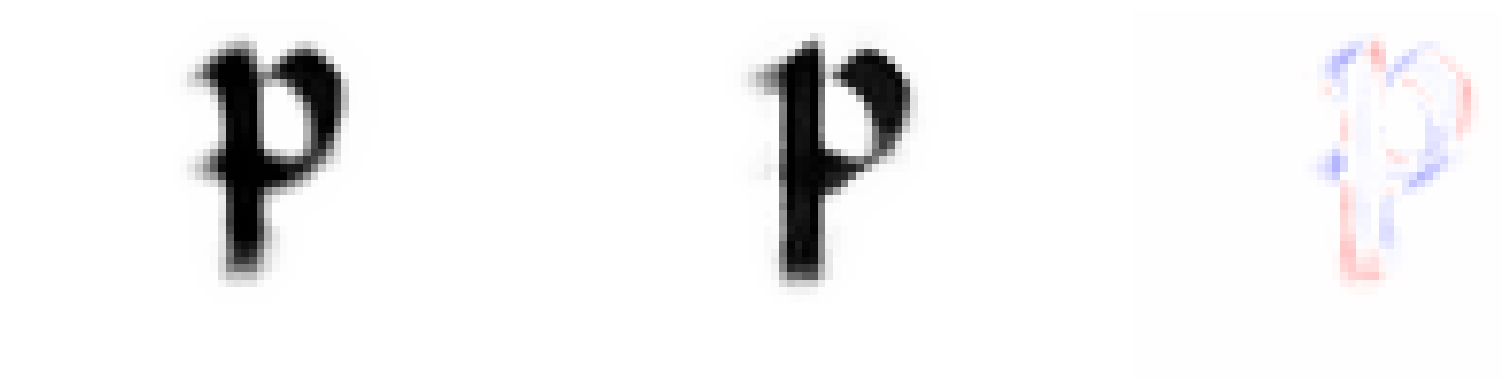

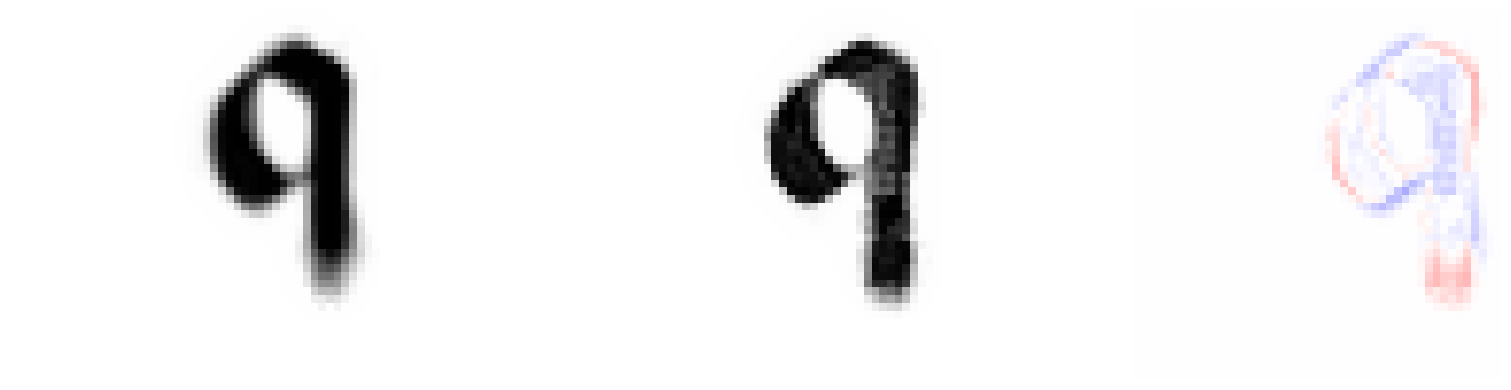

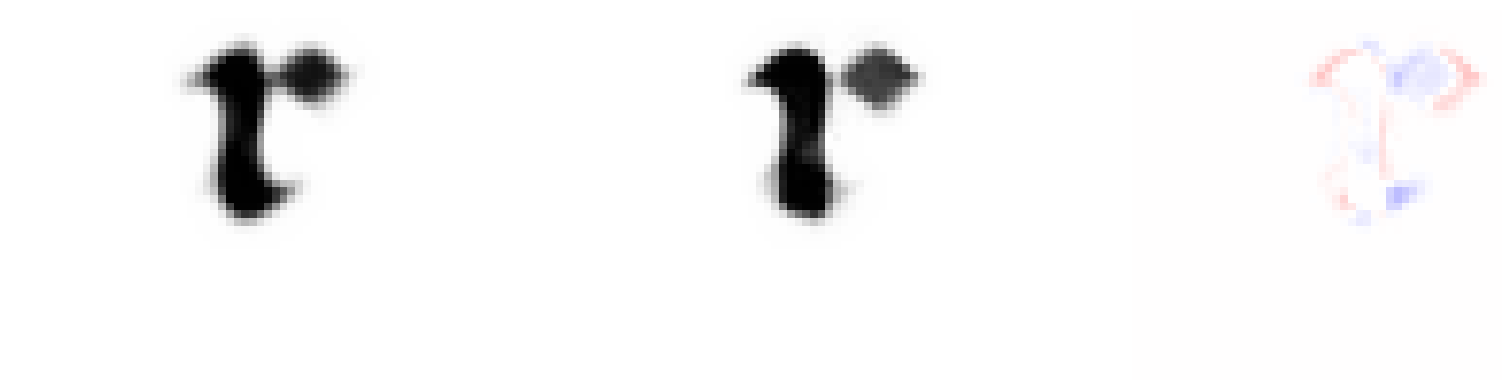

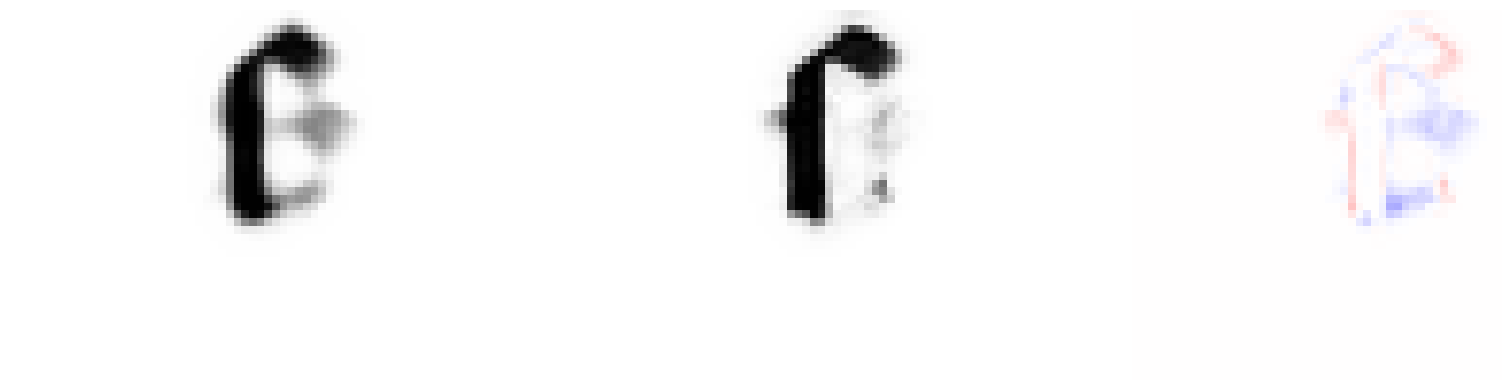

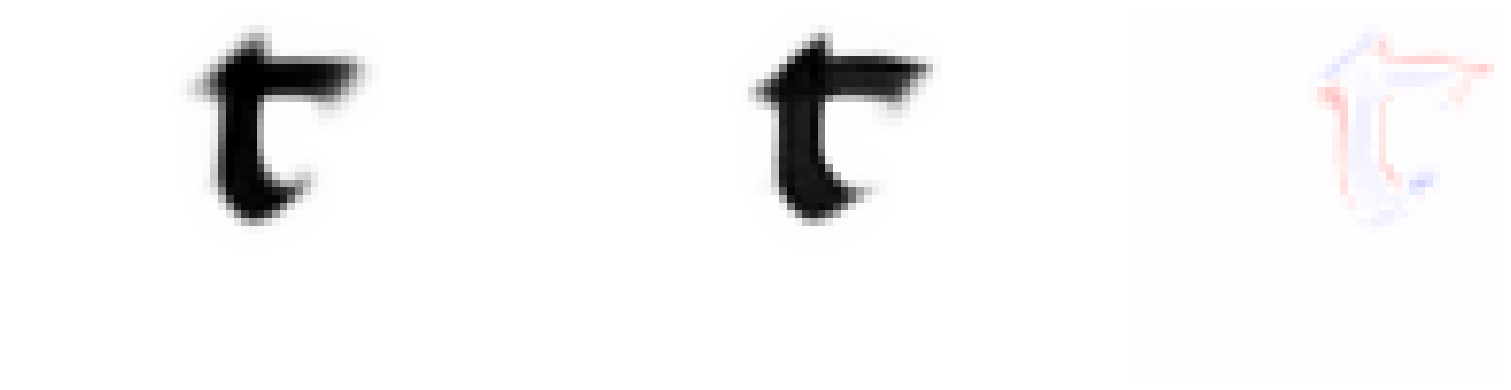

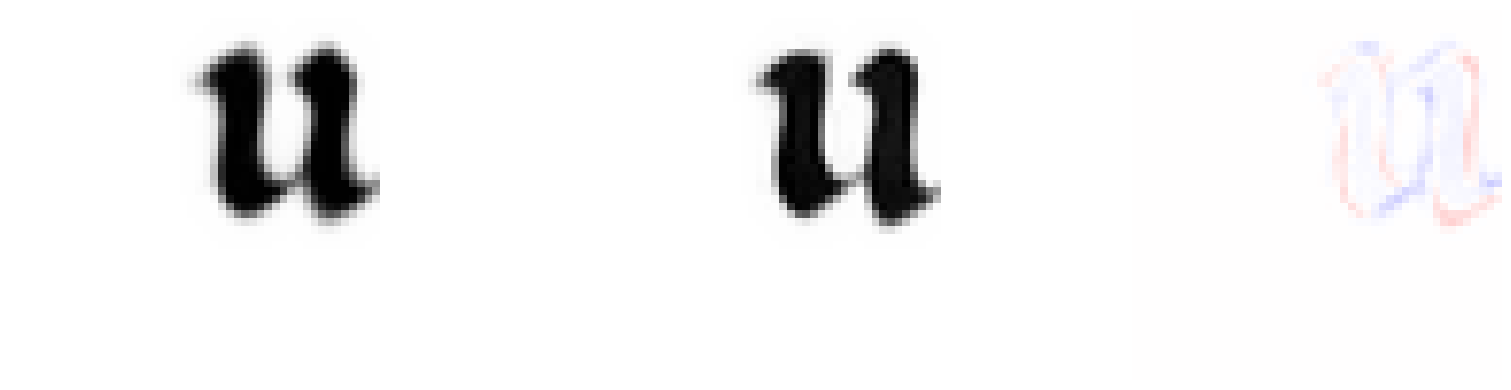

Processing folder: prototypes/filtered/IB15304245v


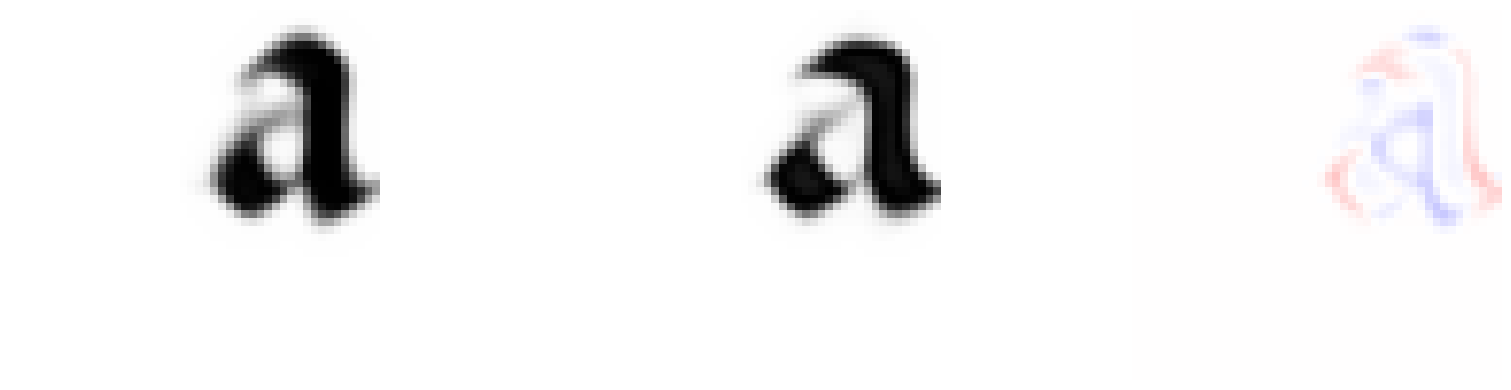

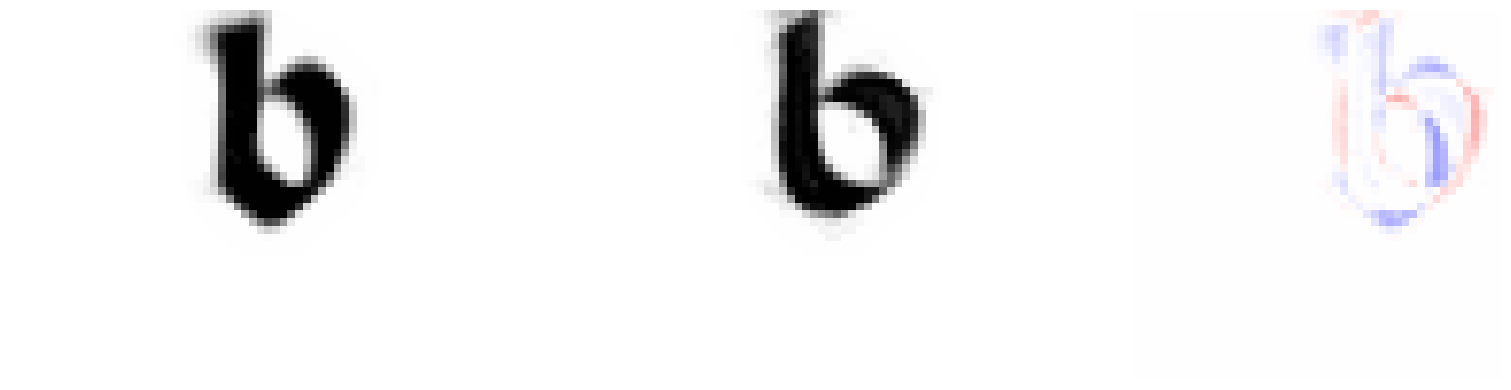

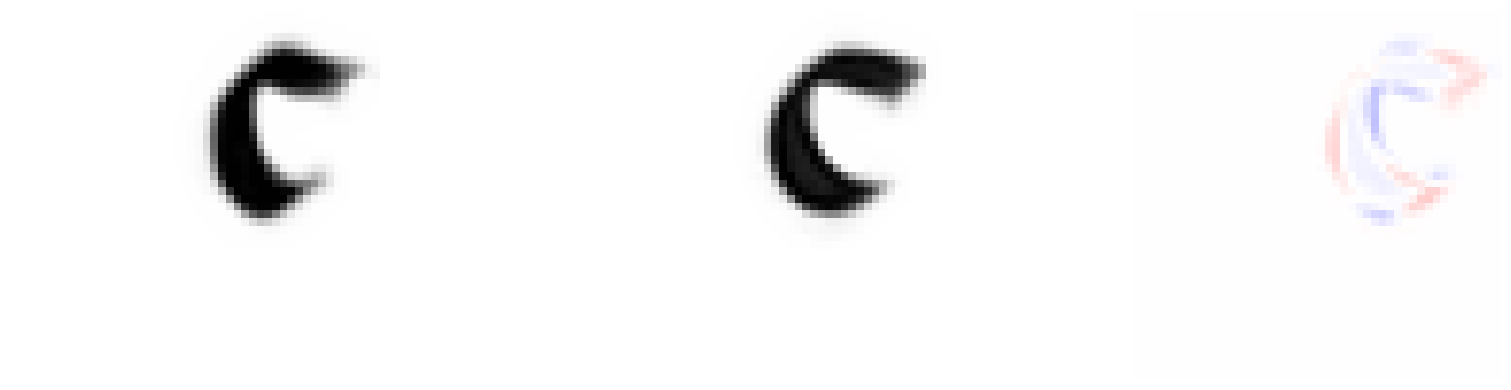

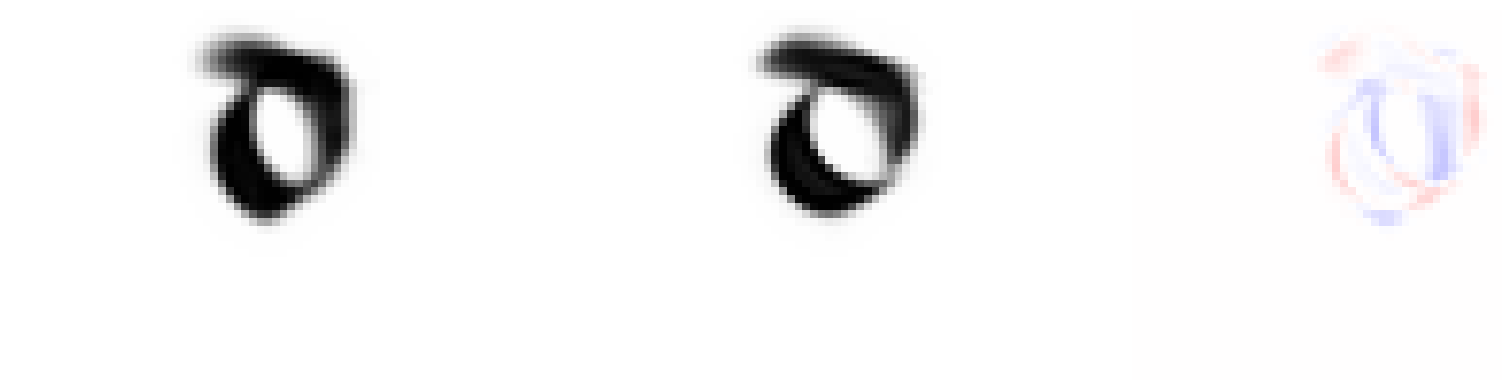

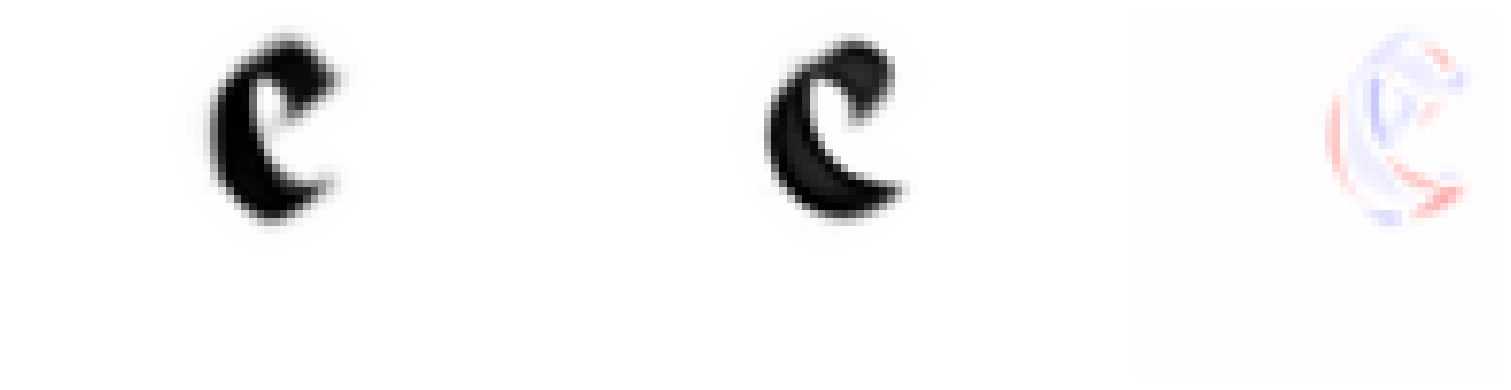

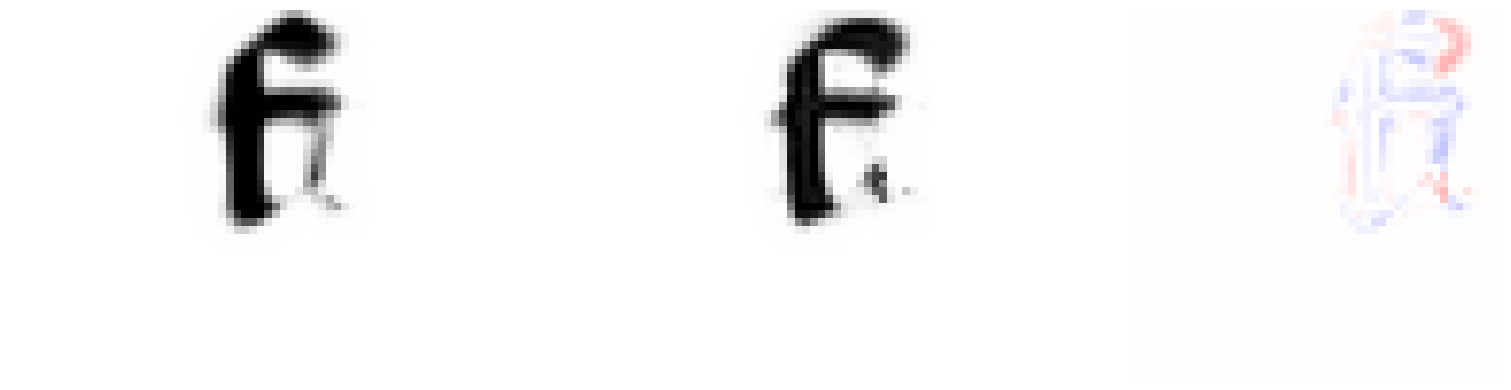

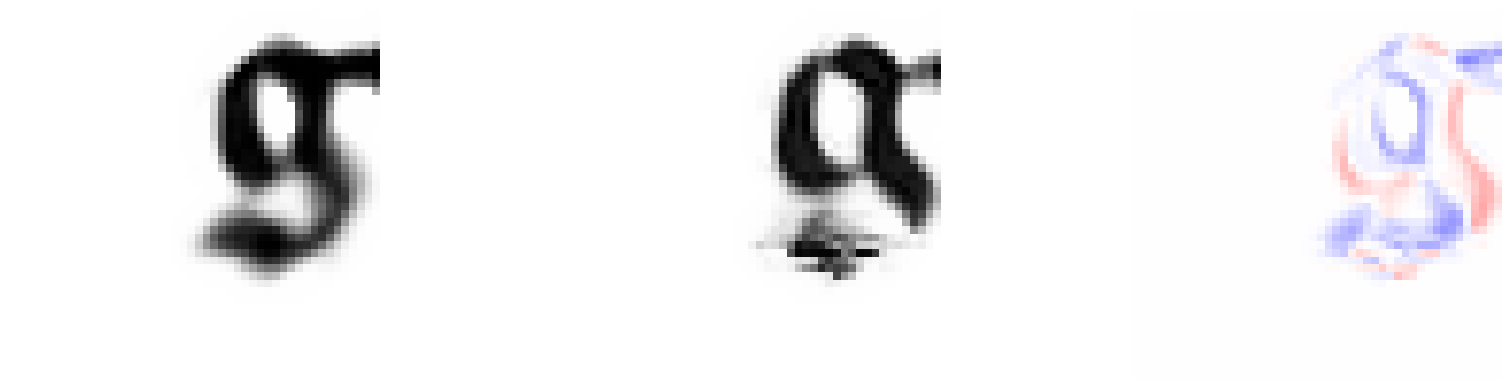

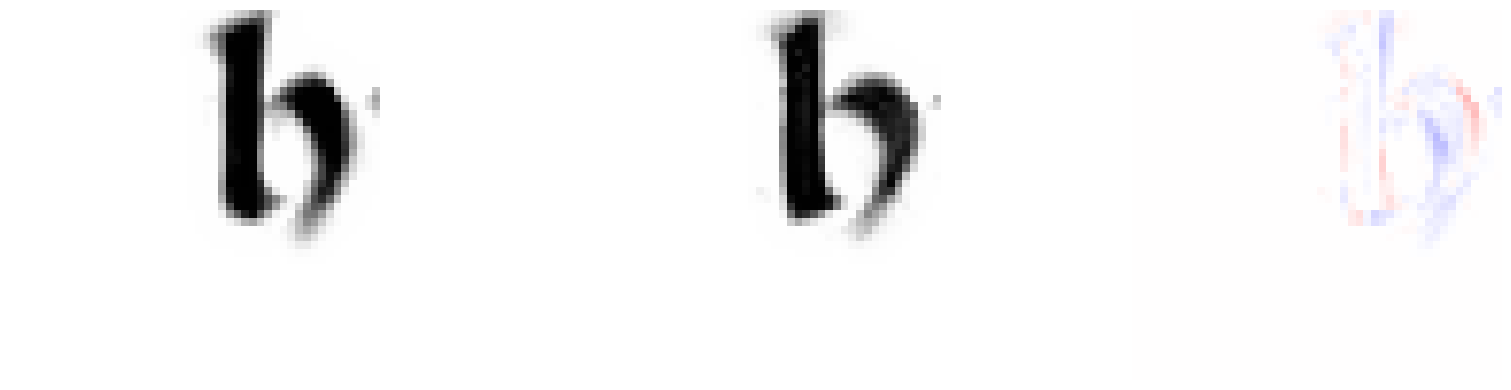

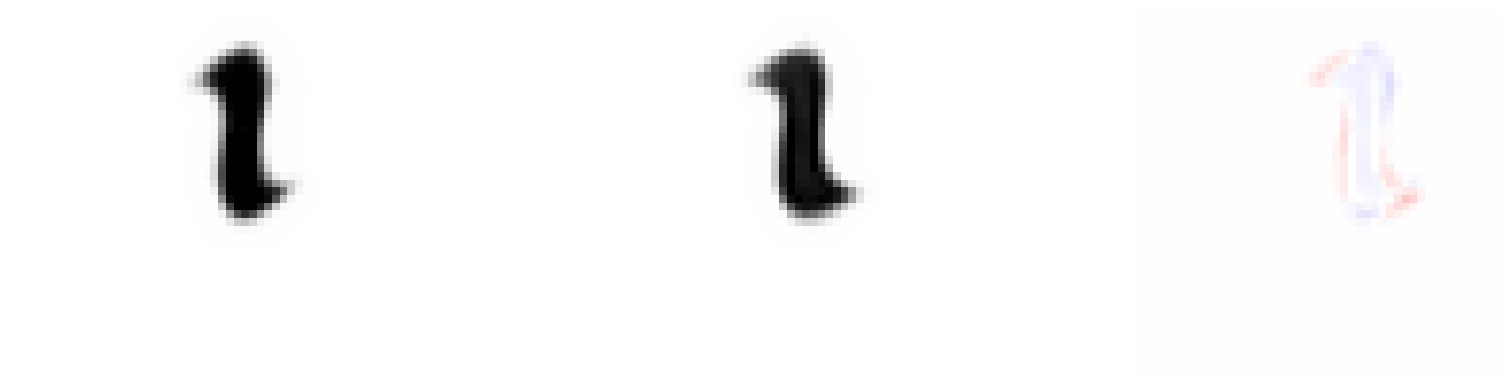

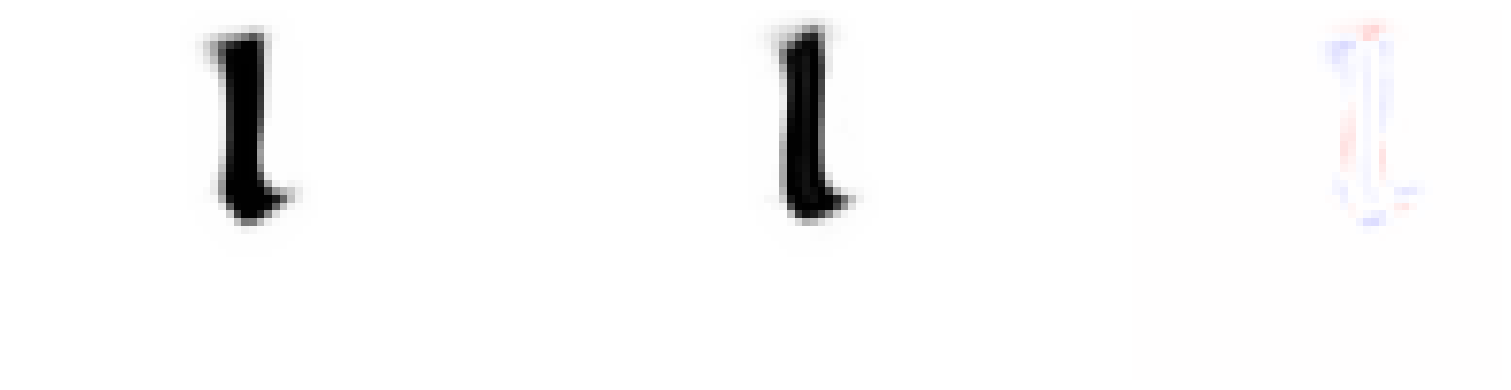

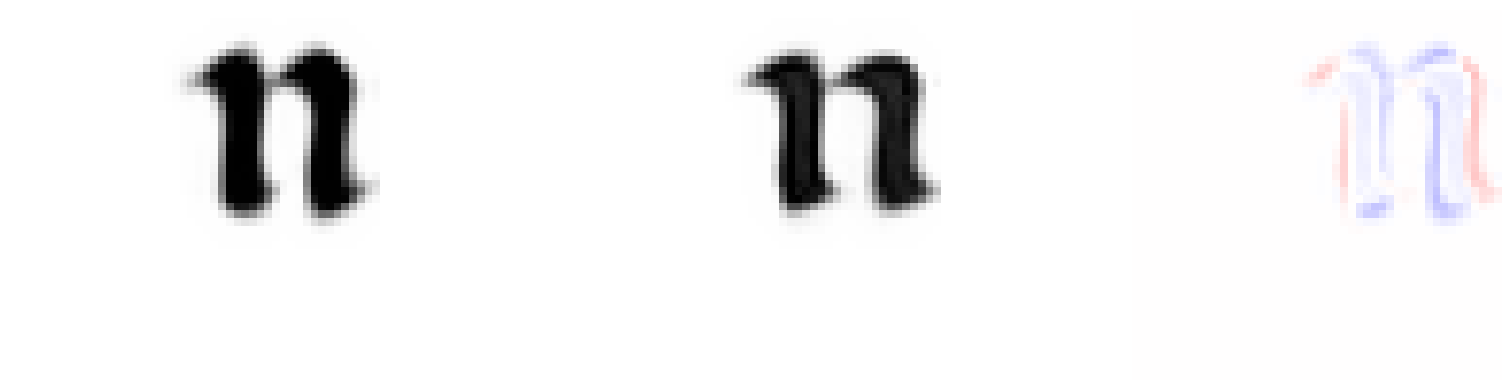

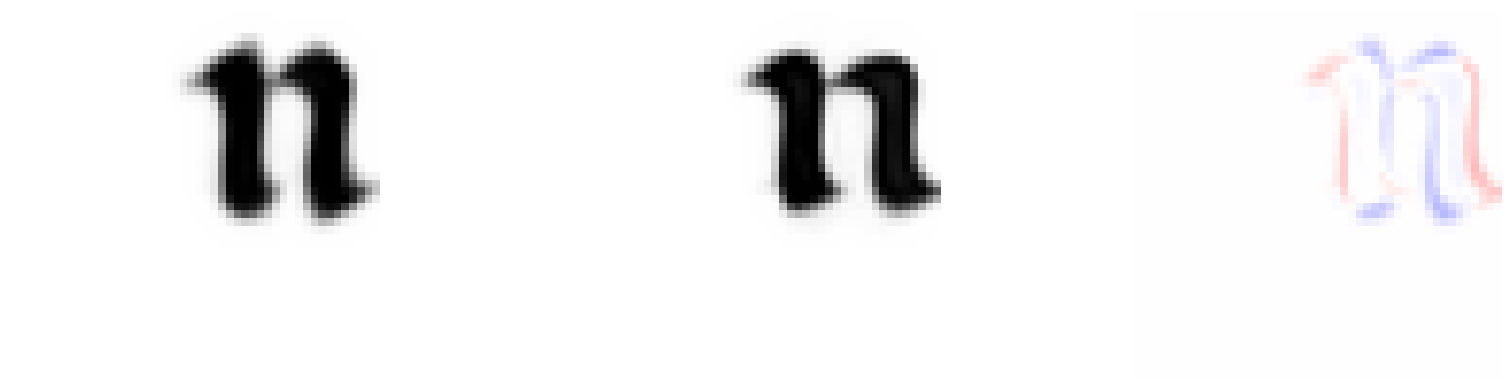

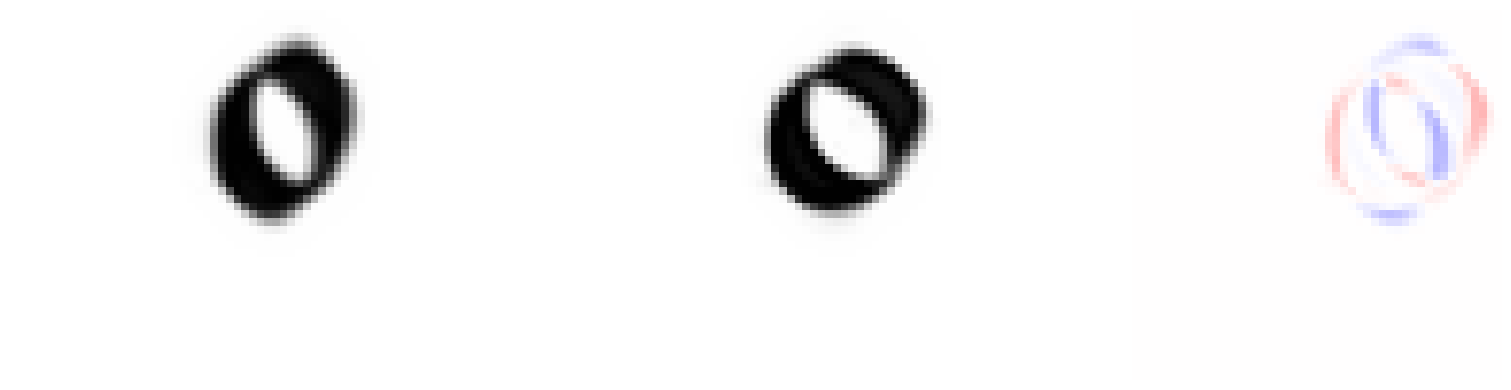

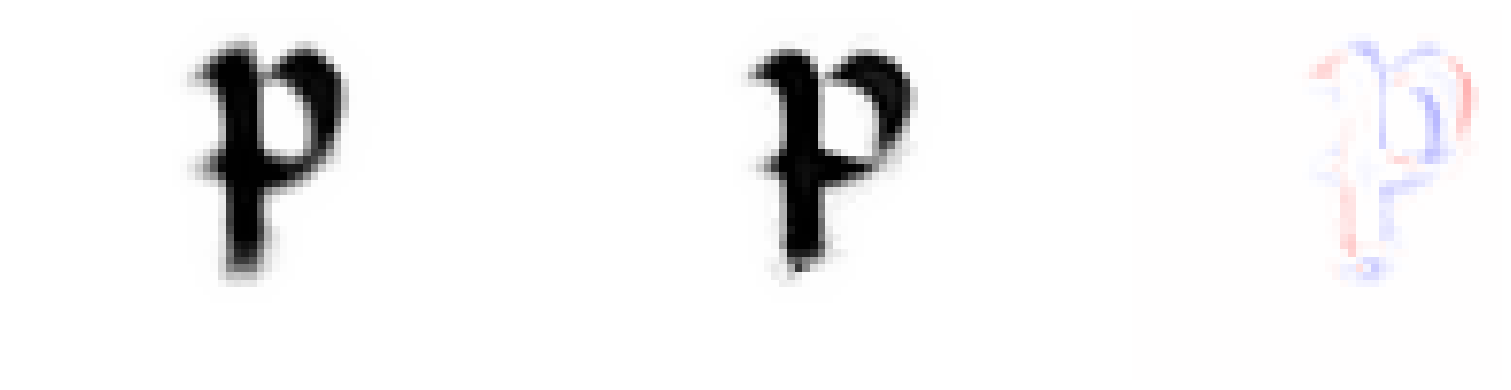

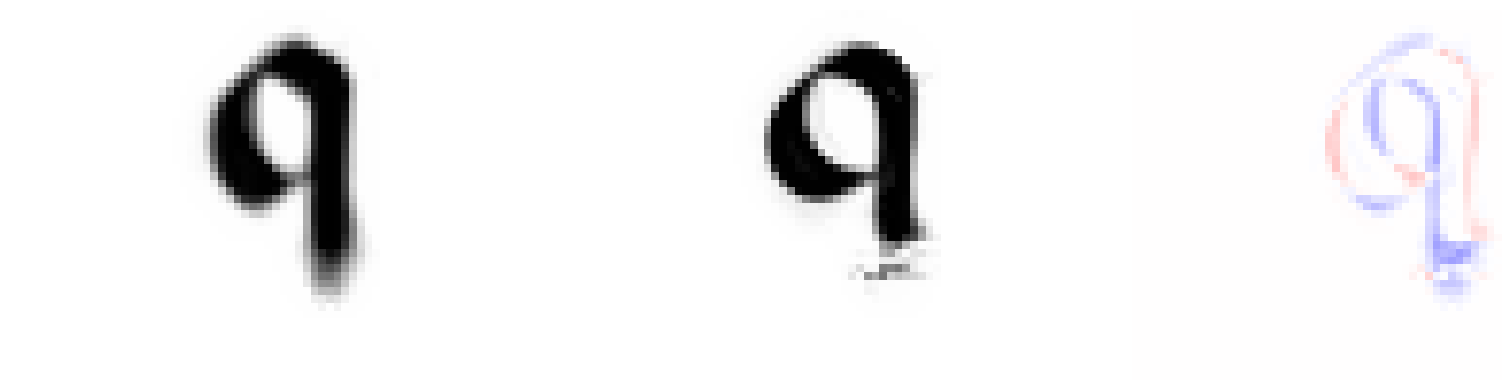

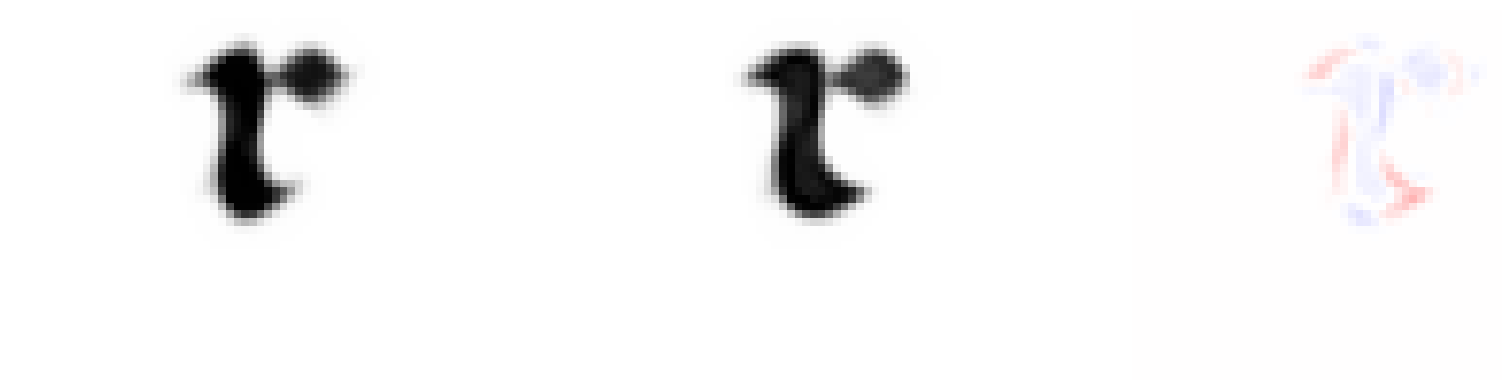

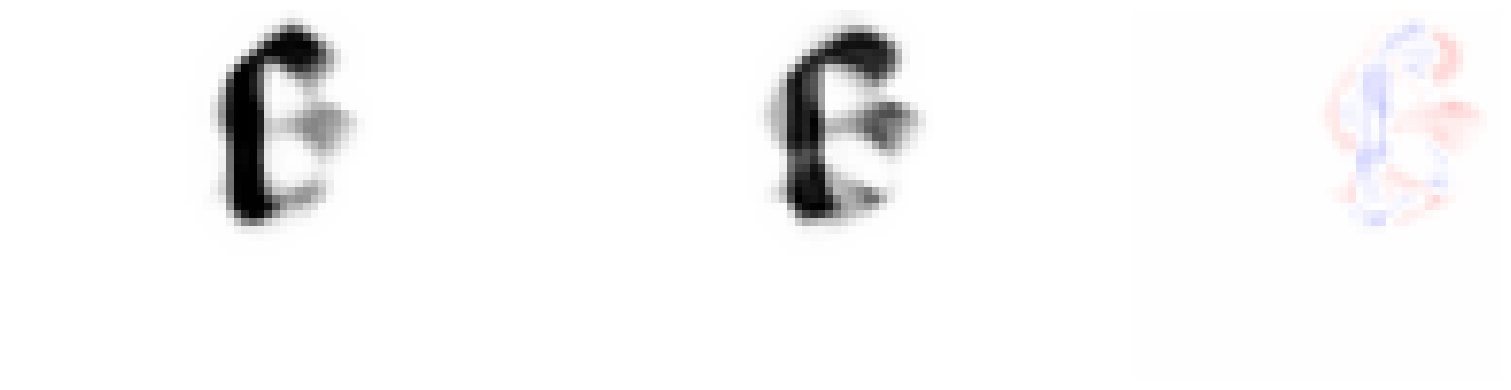

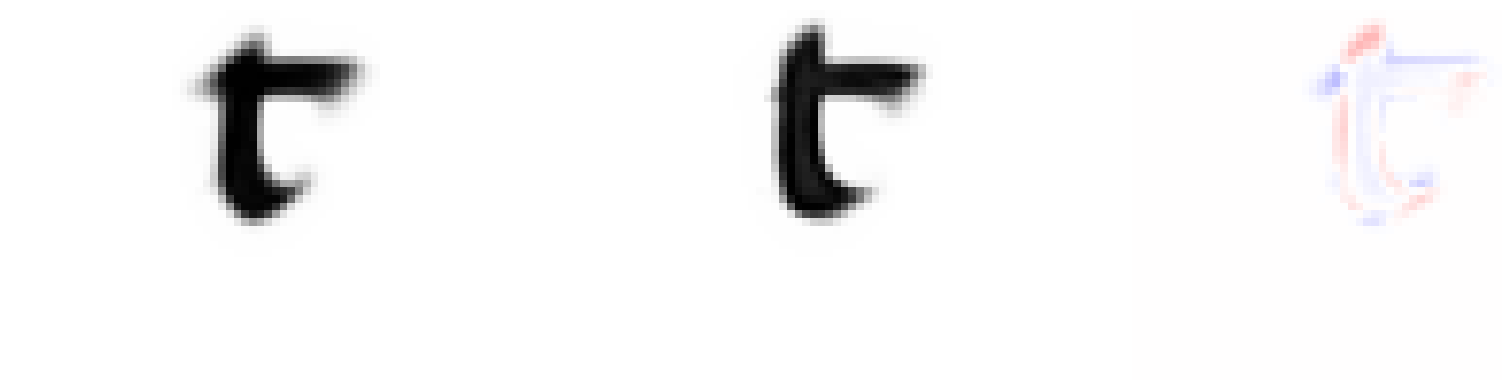

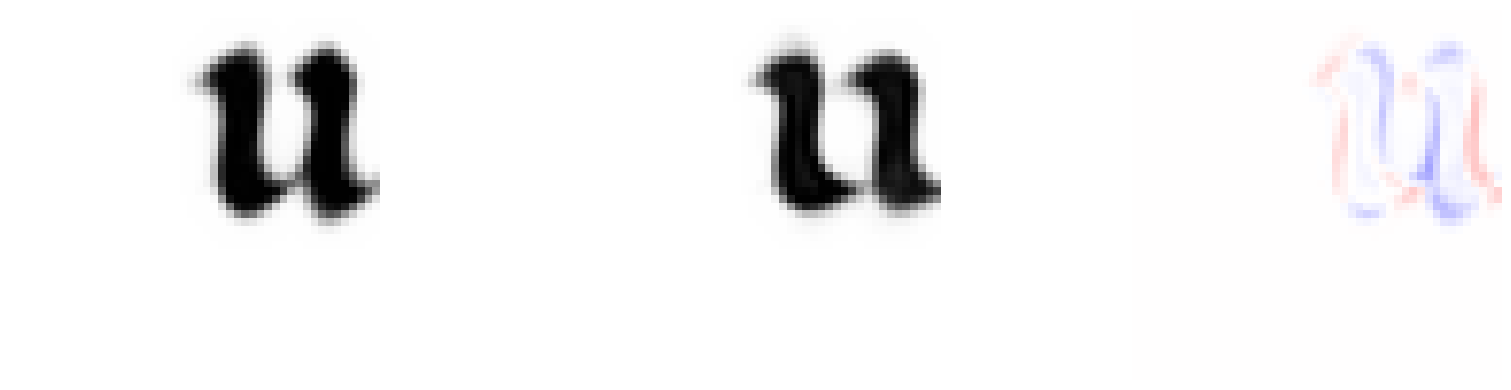

Processing folder: prototypes/filtered/btv1b90590259


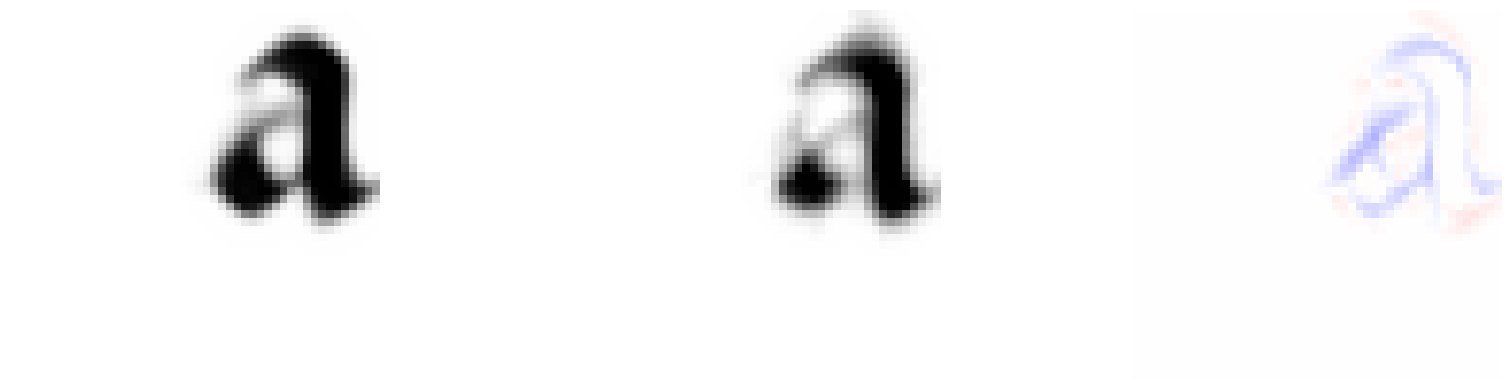

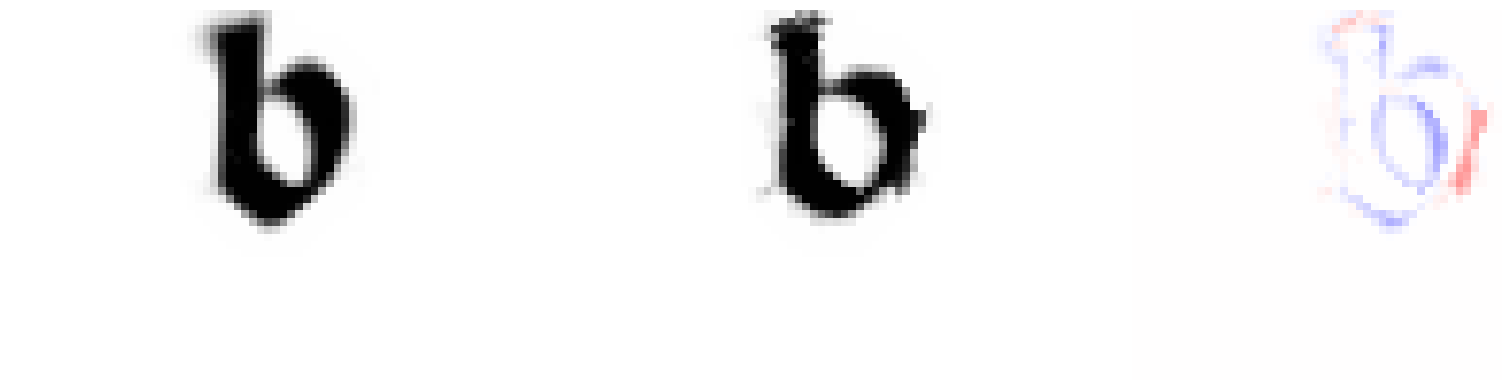

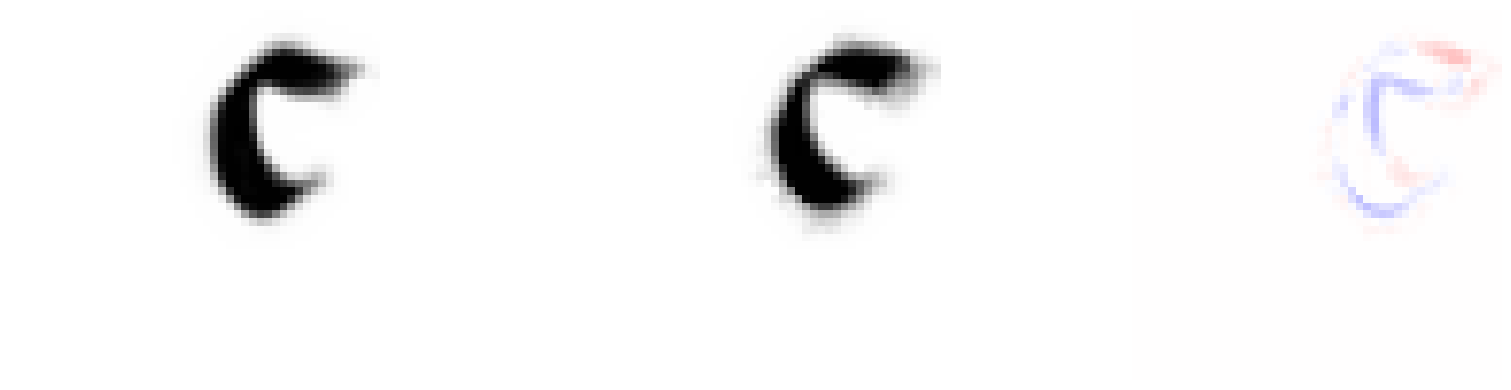

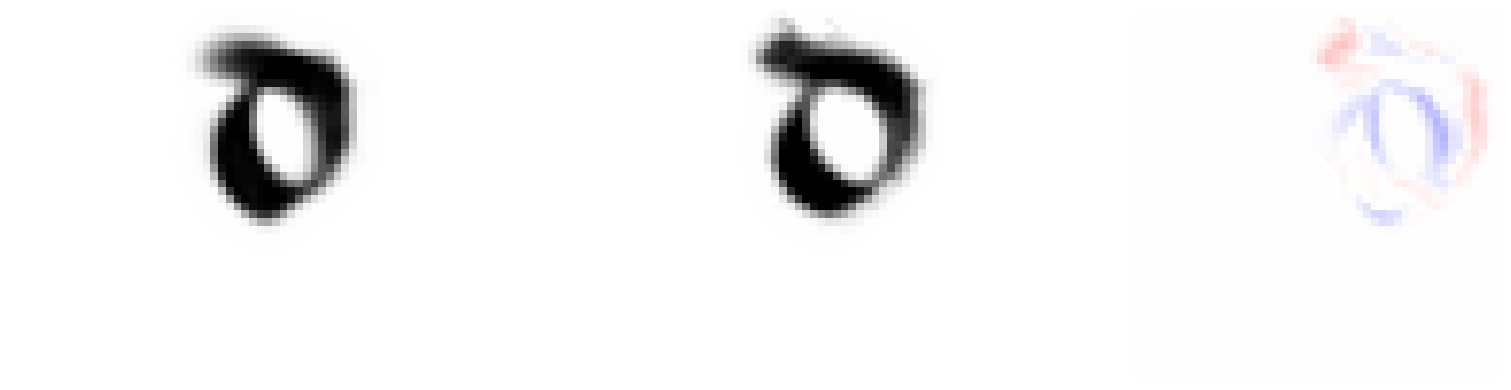

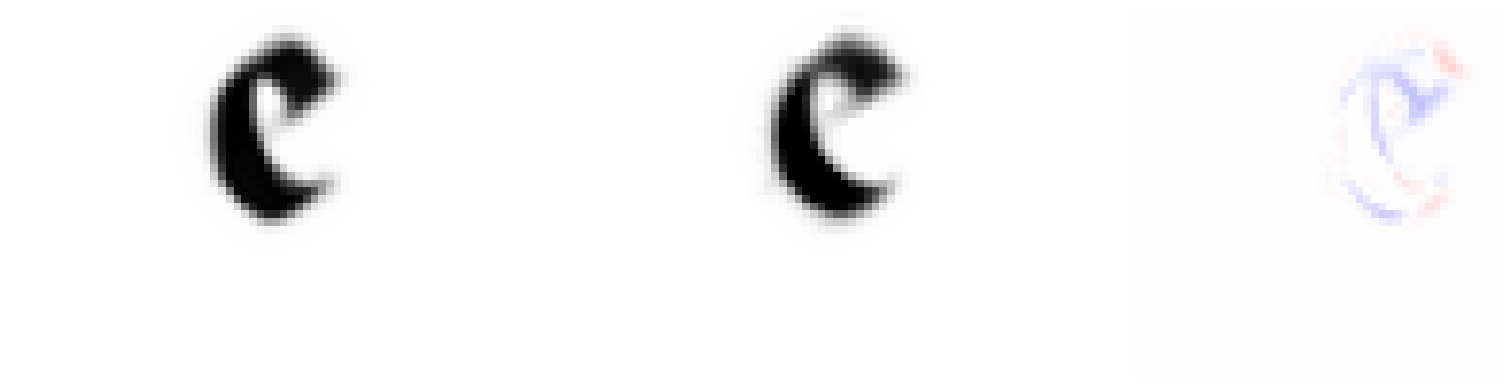

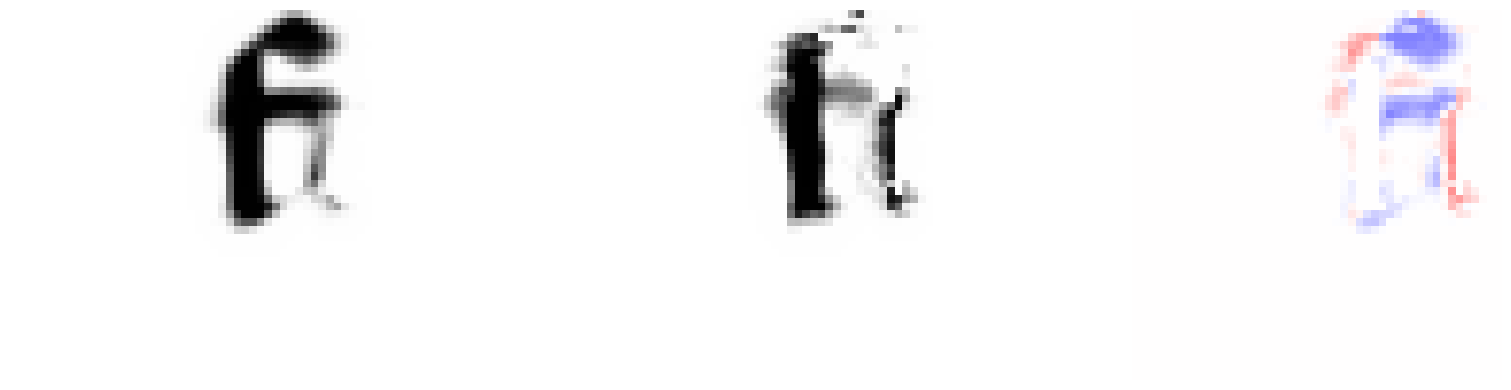

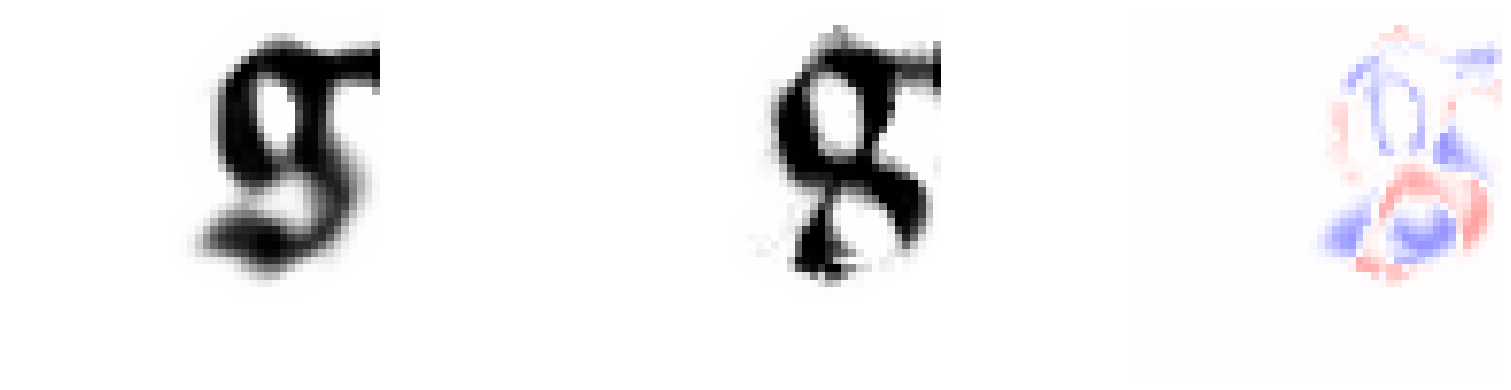

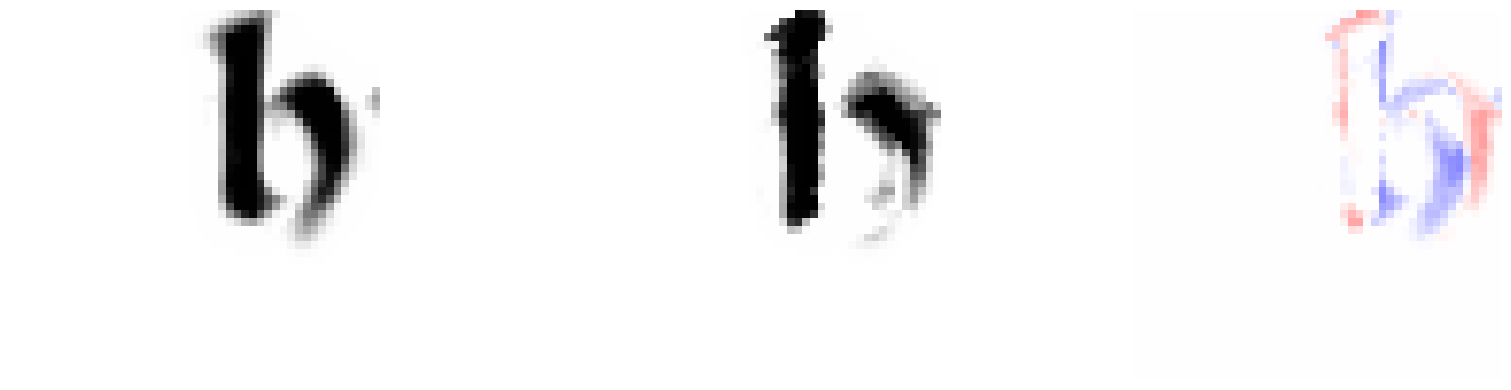

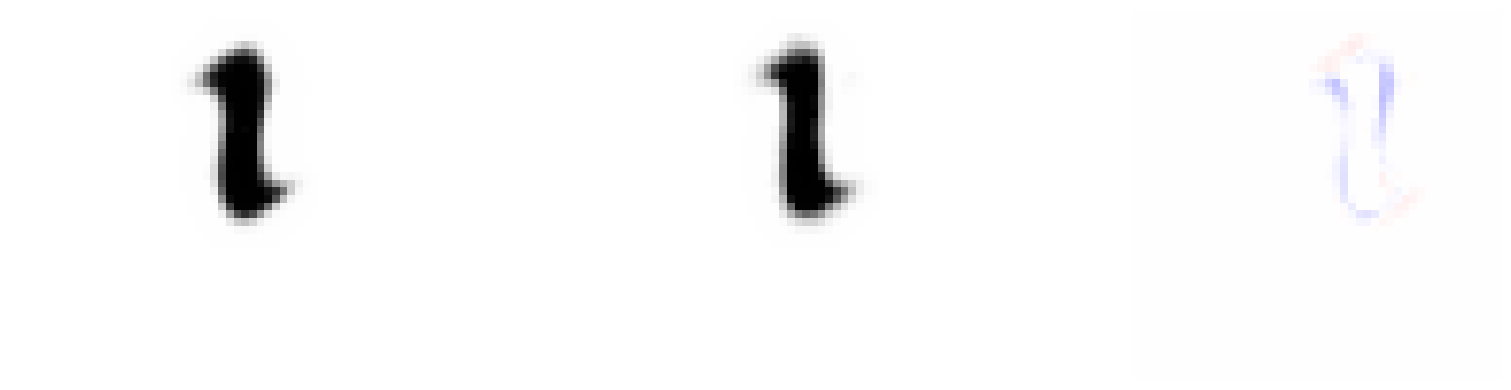

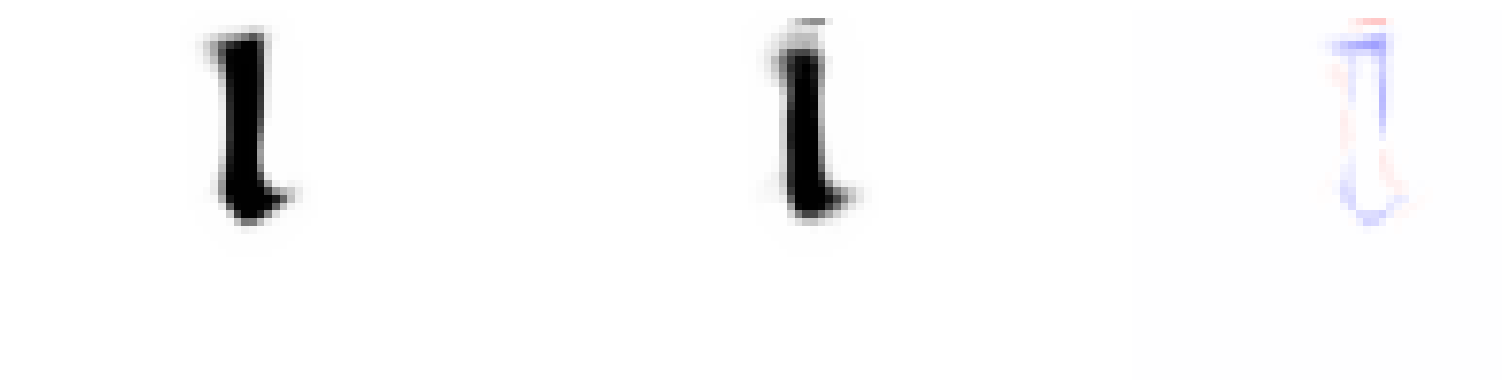

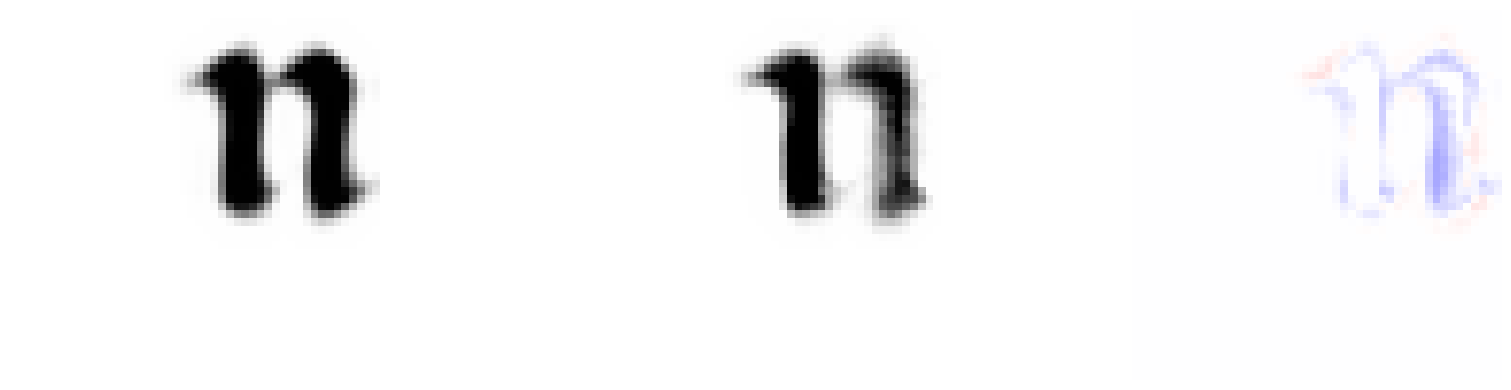

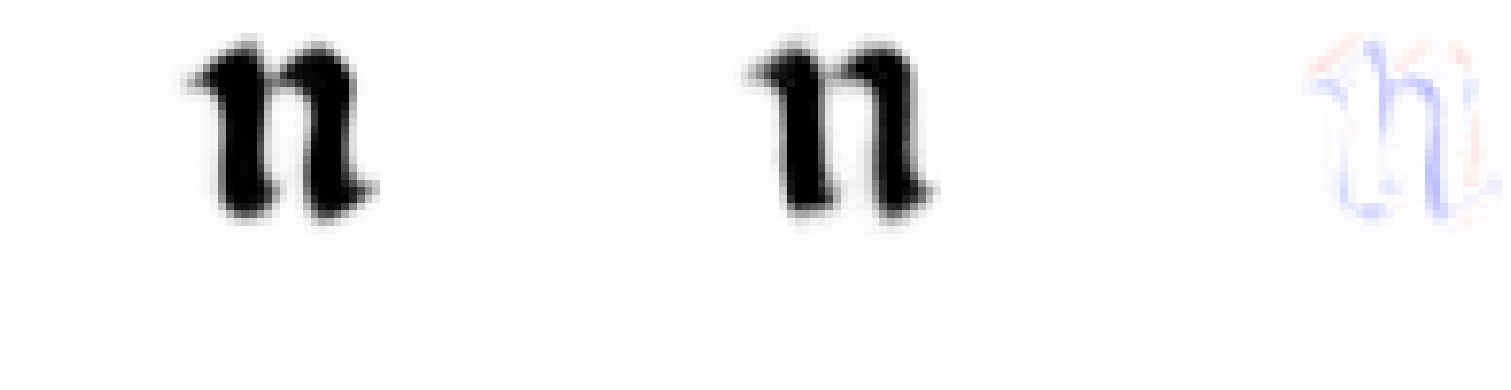

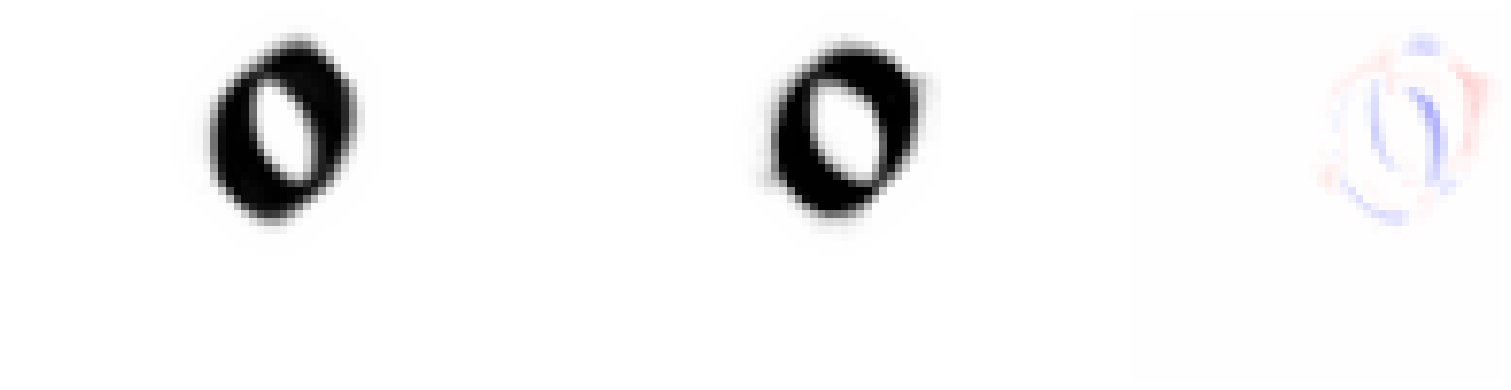

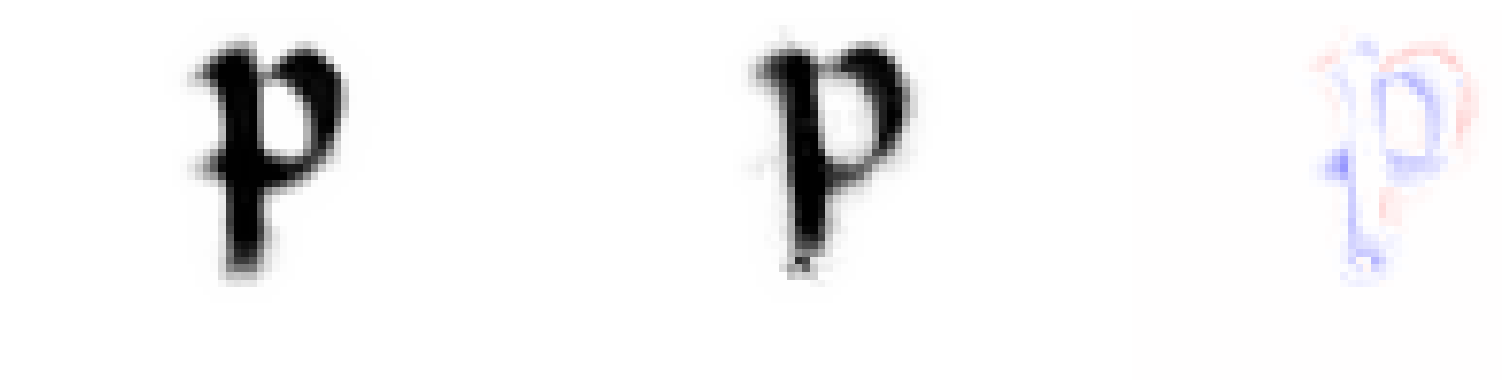

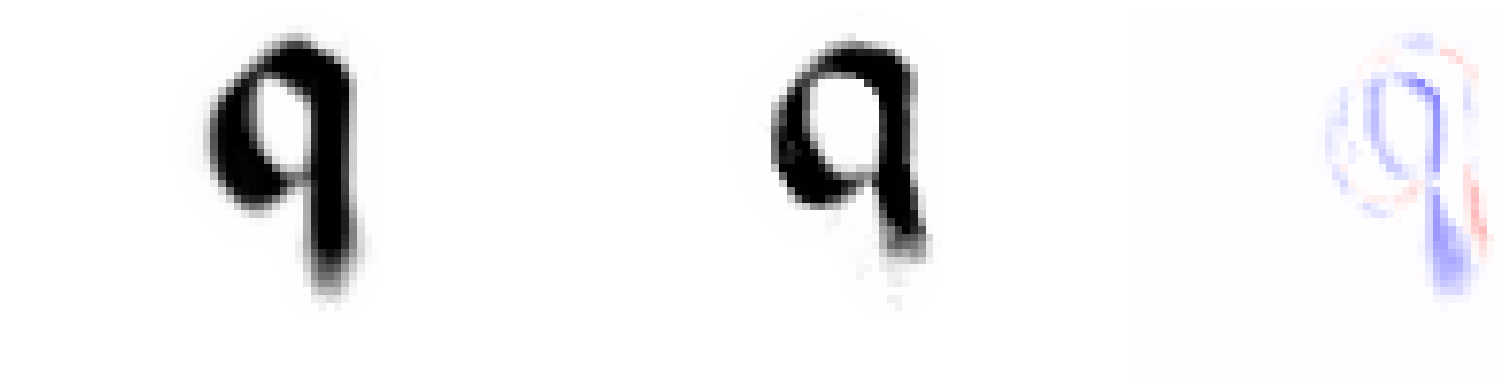

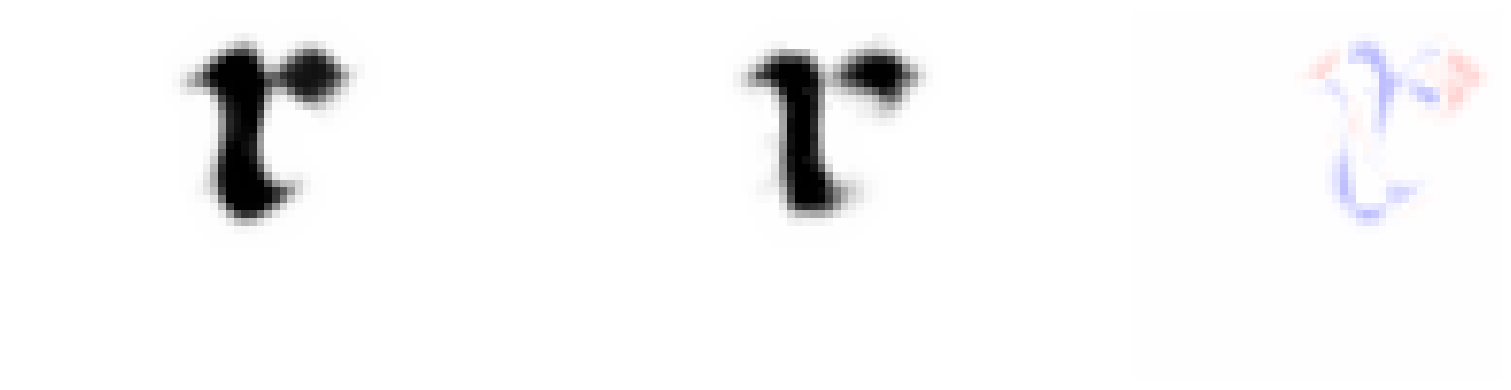

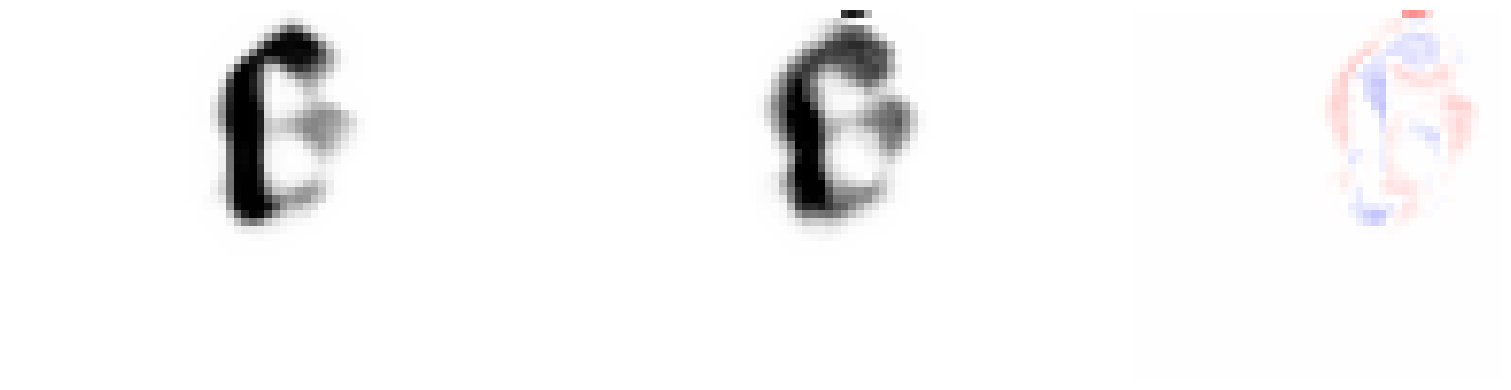

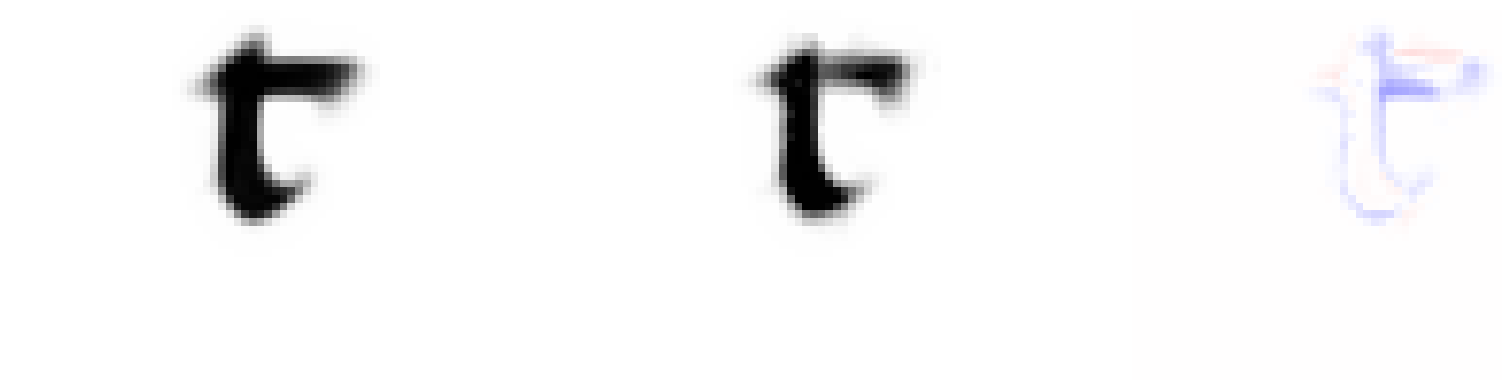

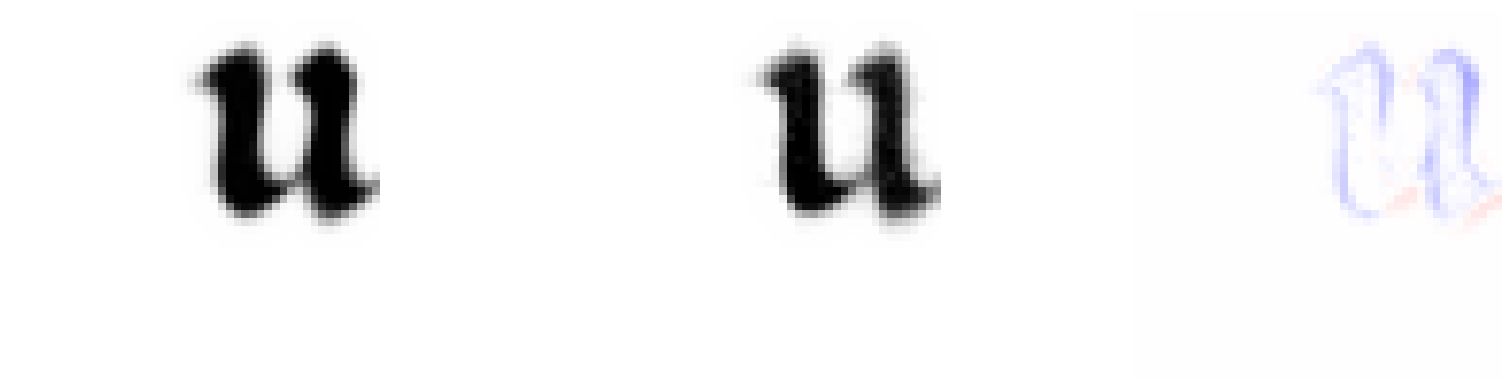

Processing folder: prototypes/filtered/btv1b8446940n


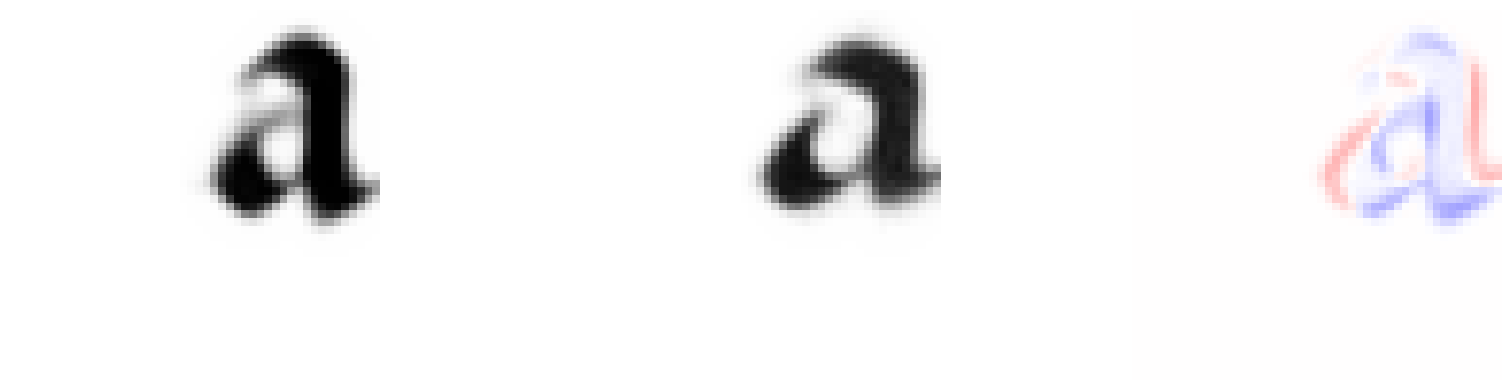

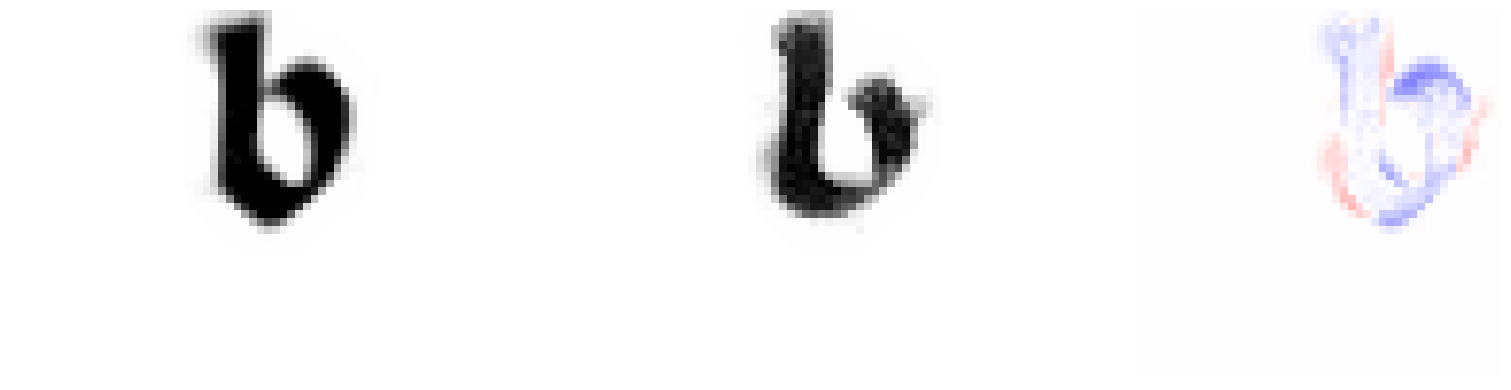

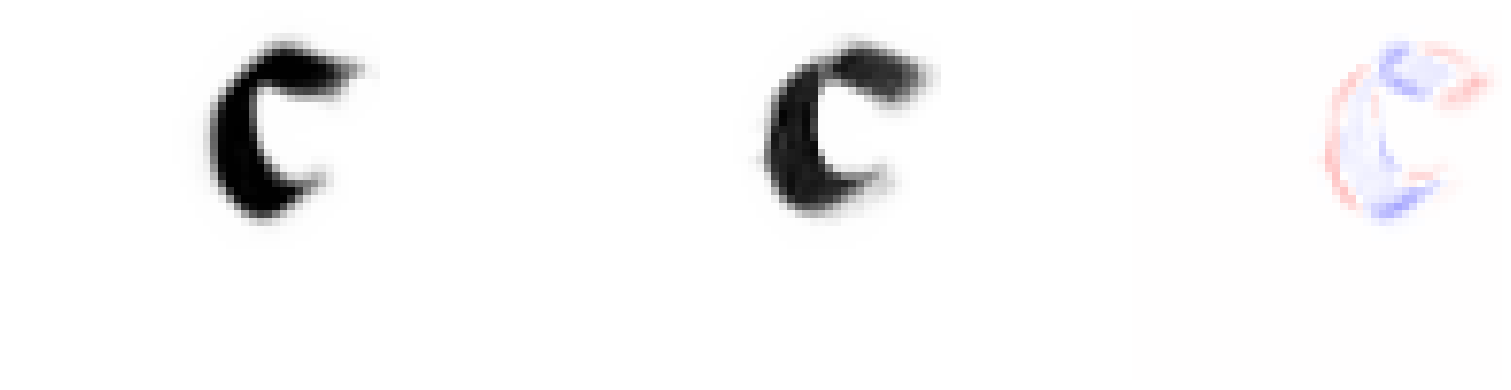

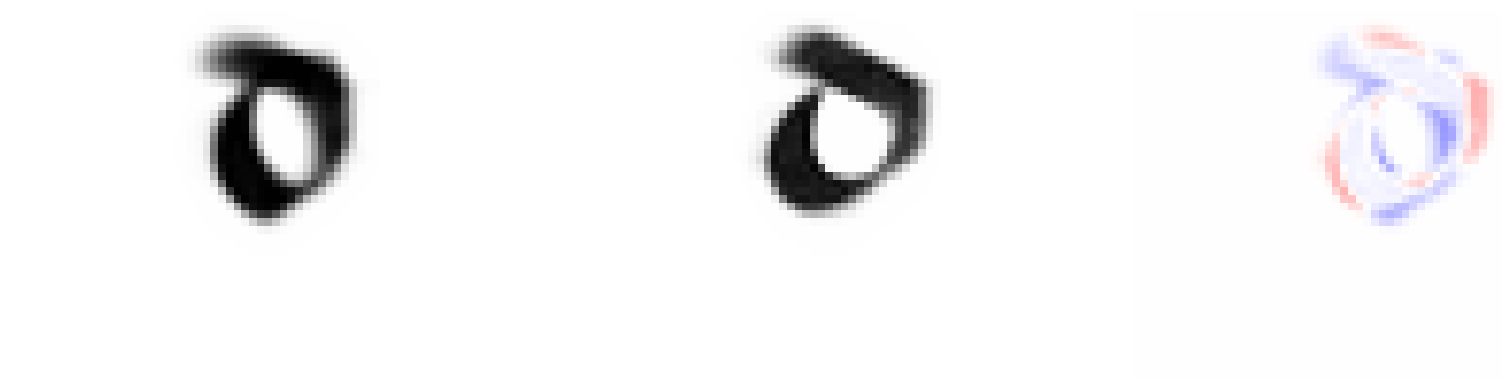

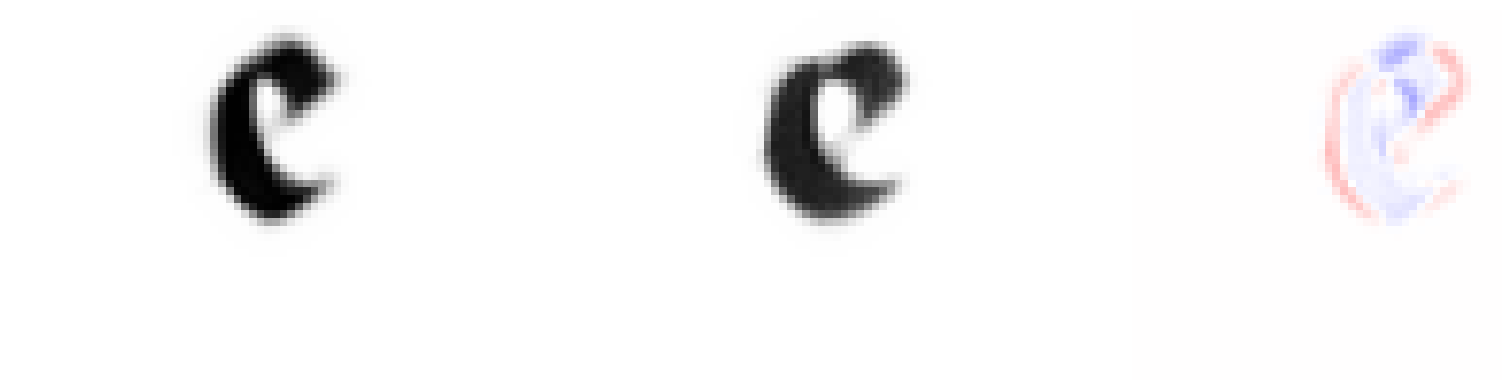

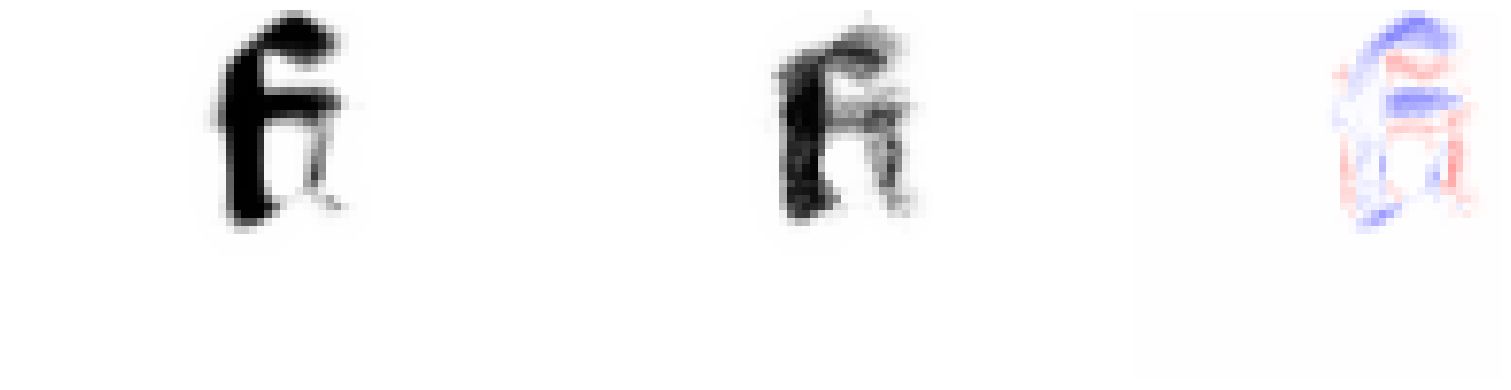

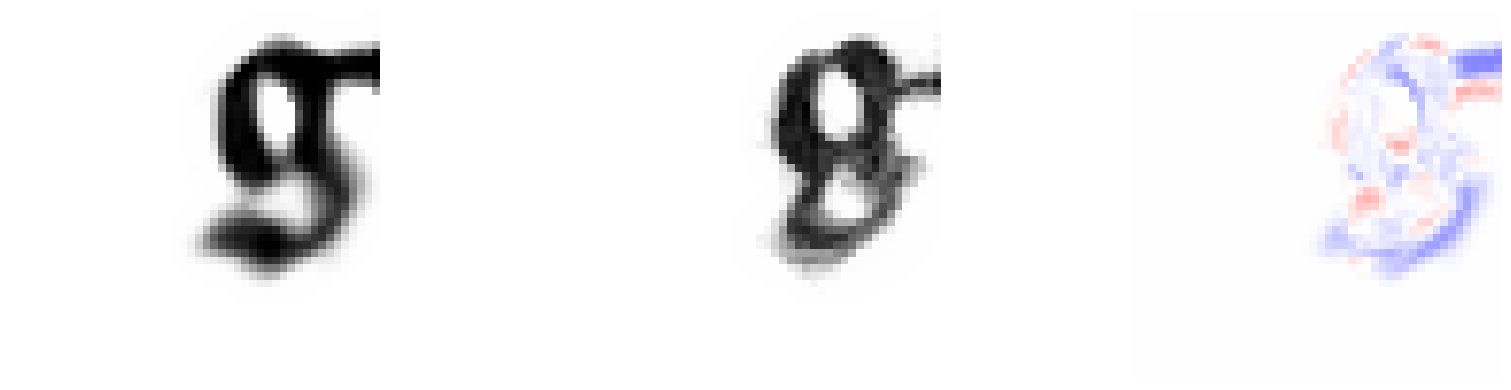

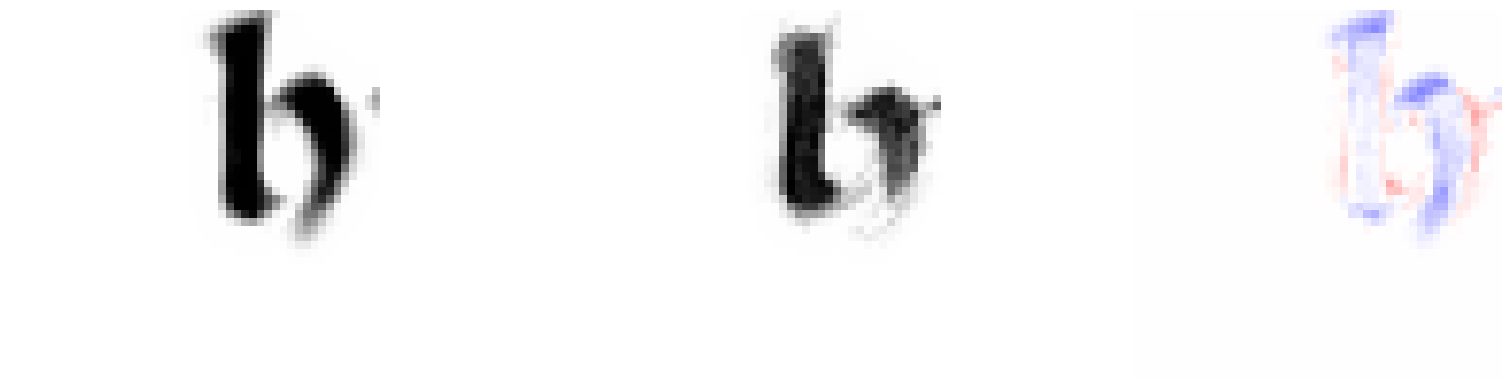

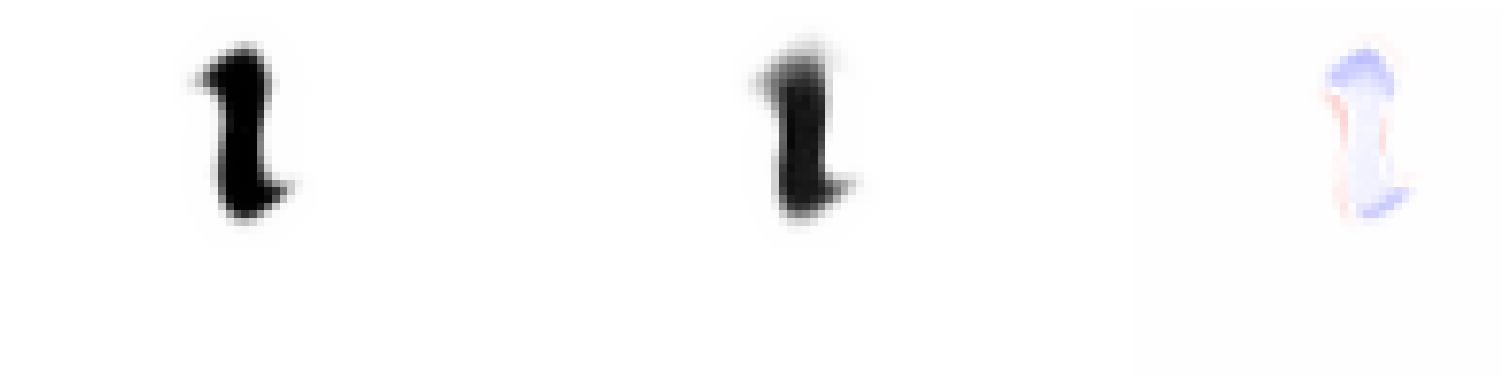

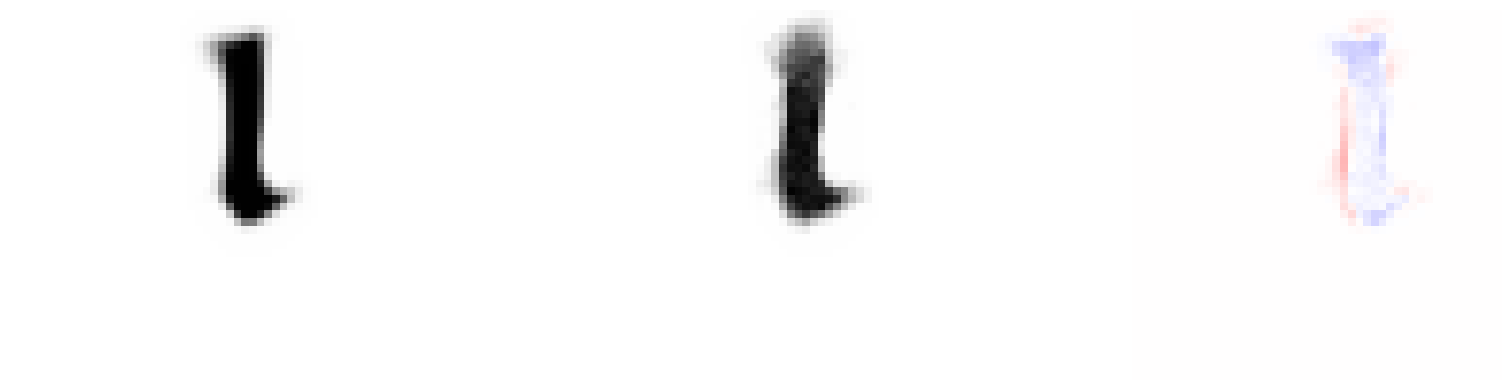

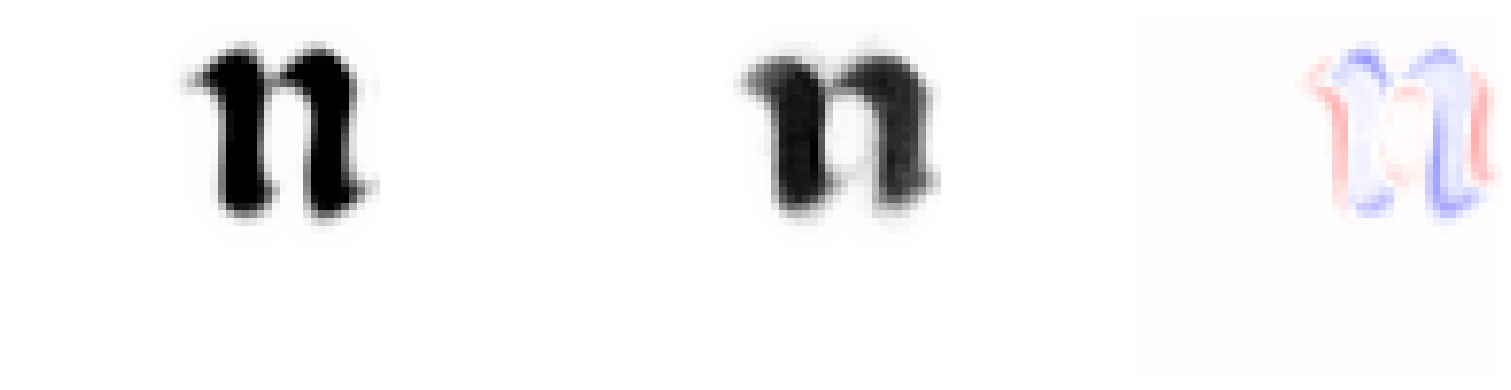

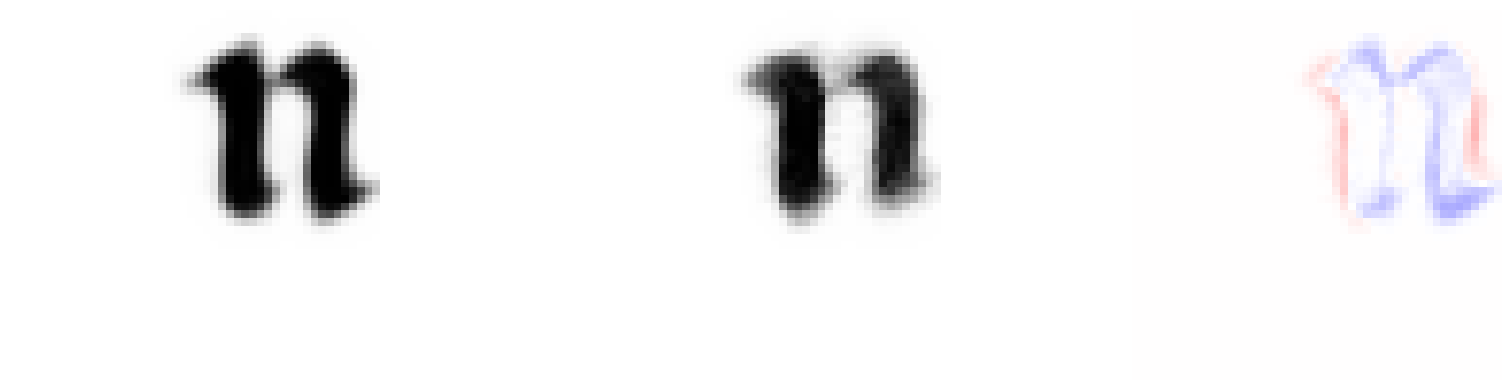

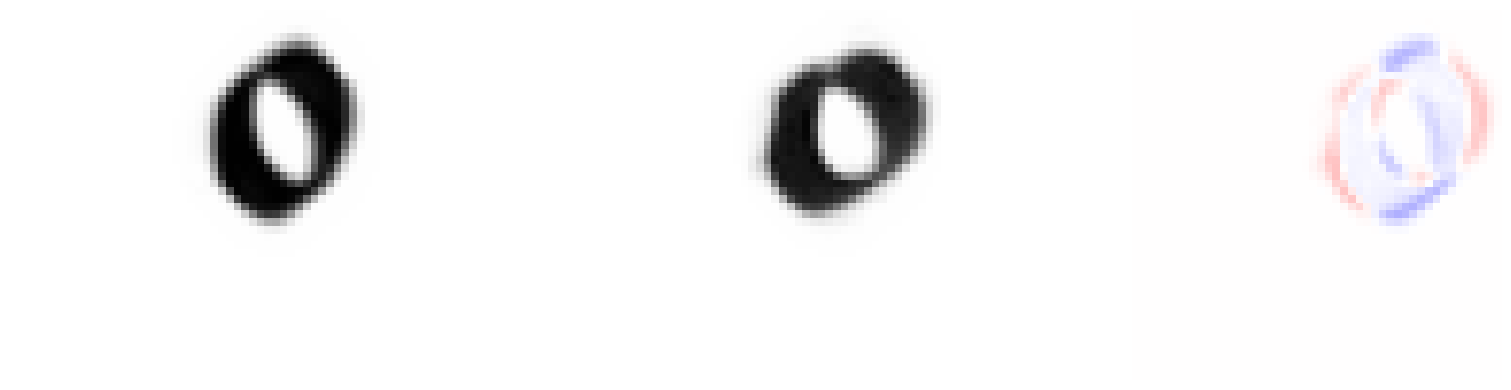

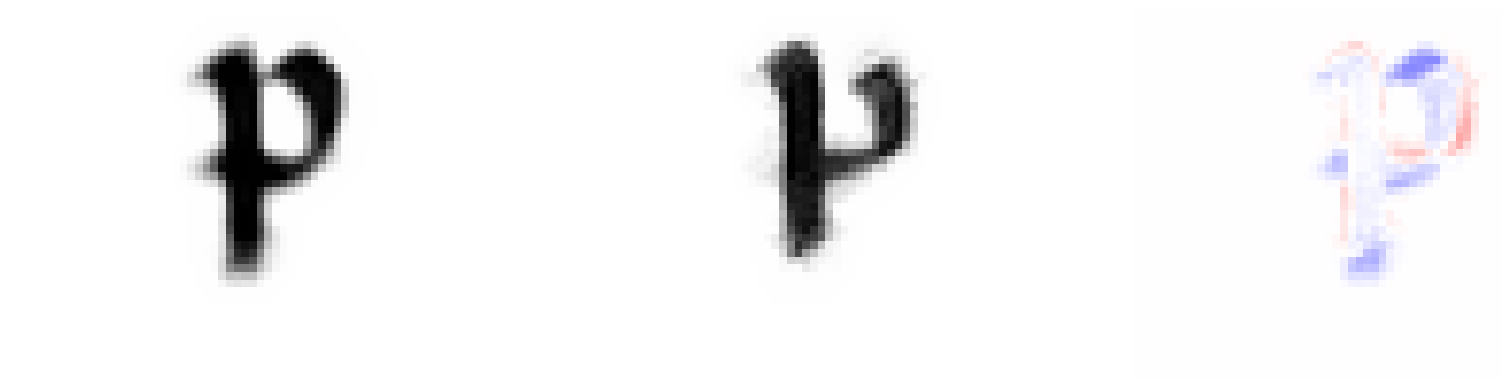

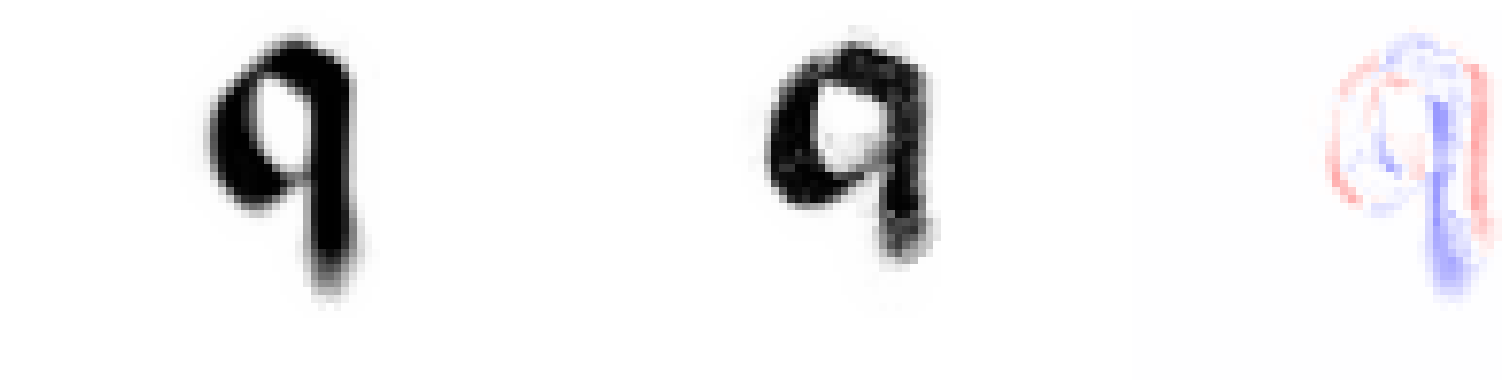

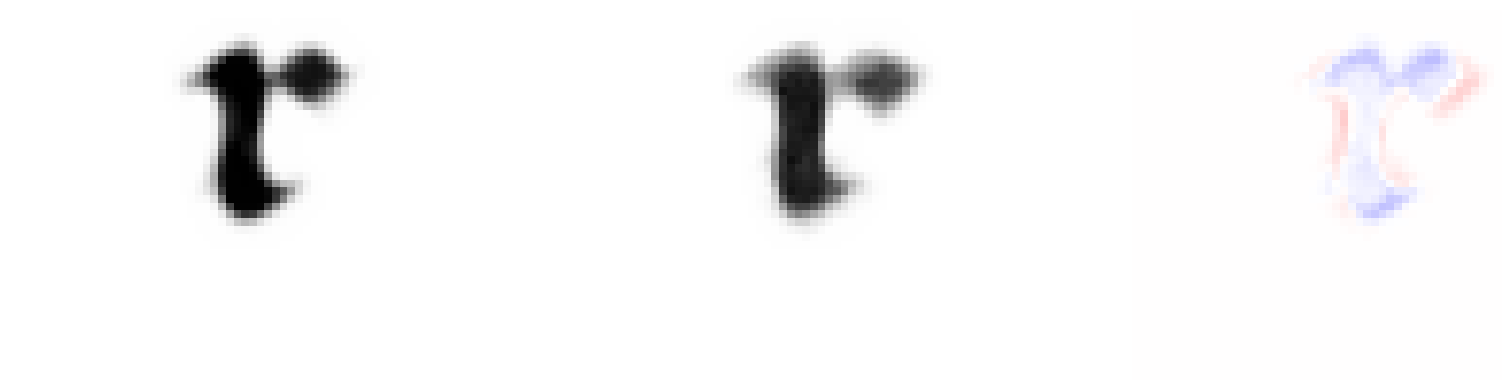

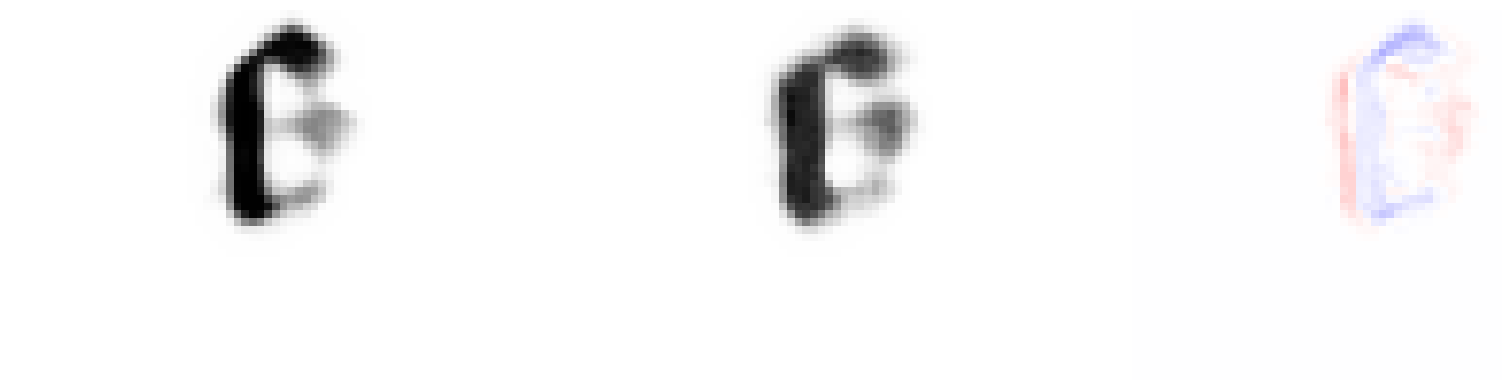

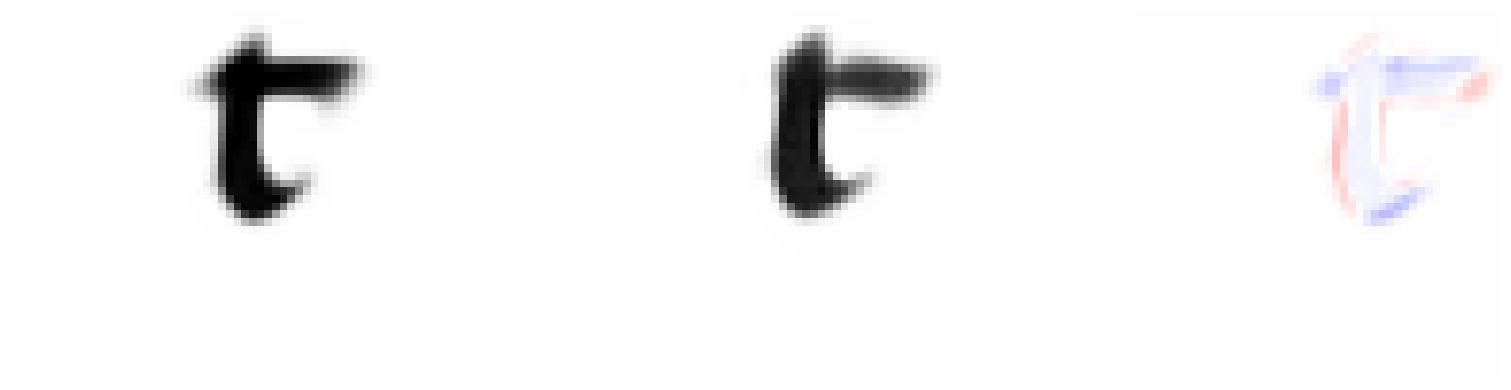

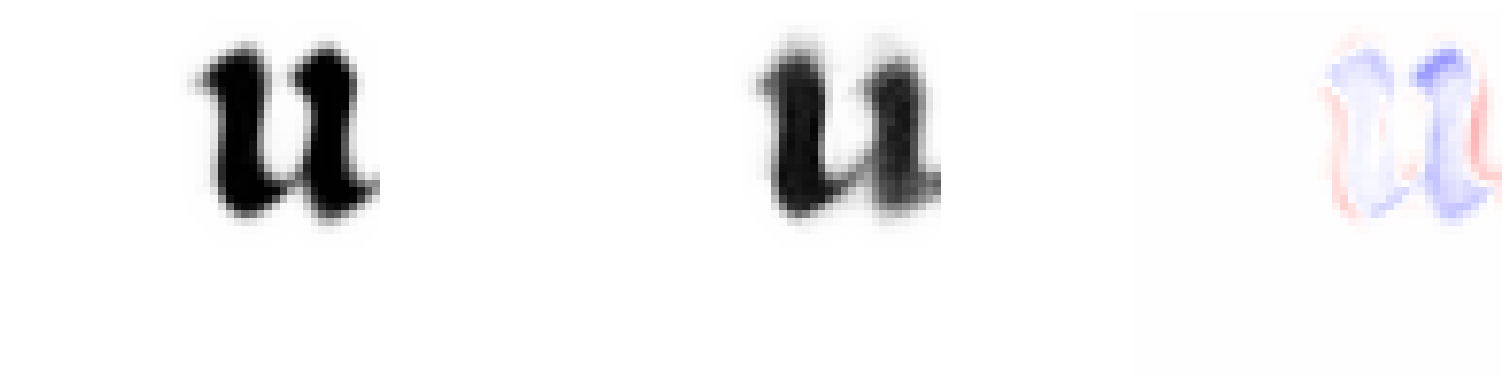

Processing folder: prototypes/filtered/IB15304274v


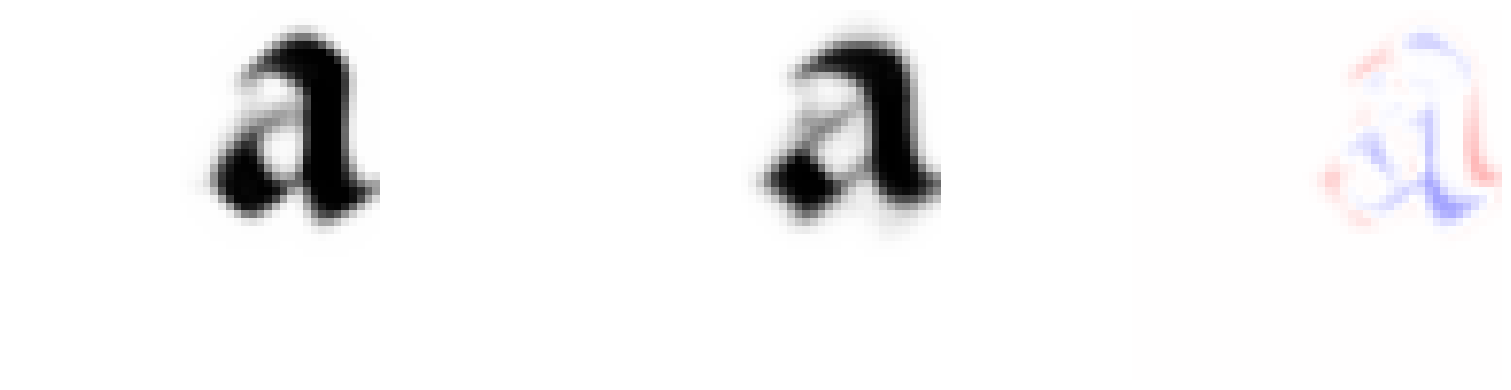

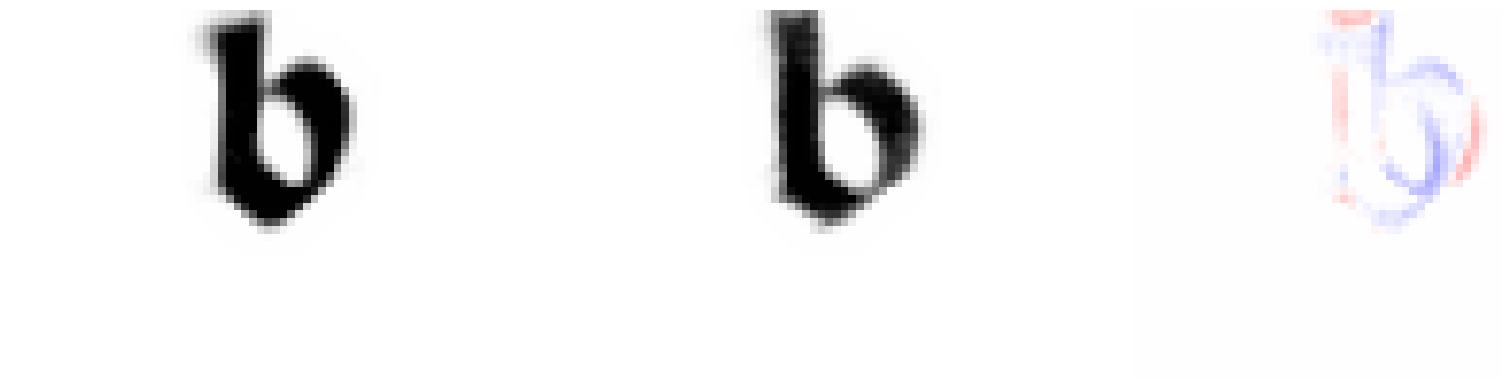

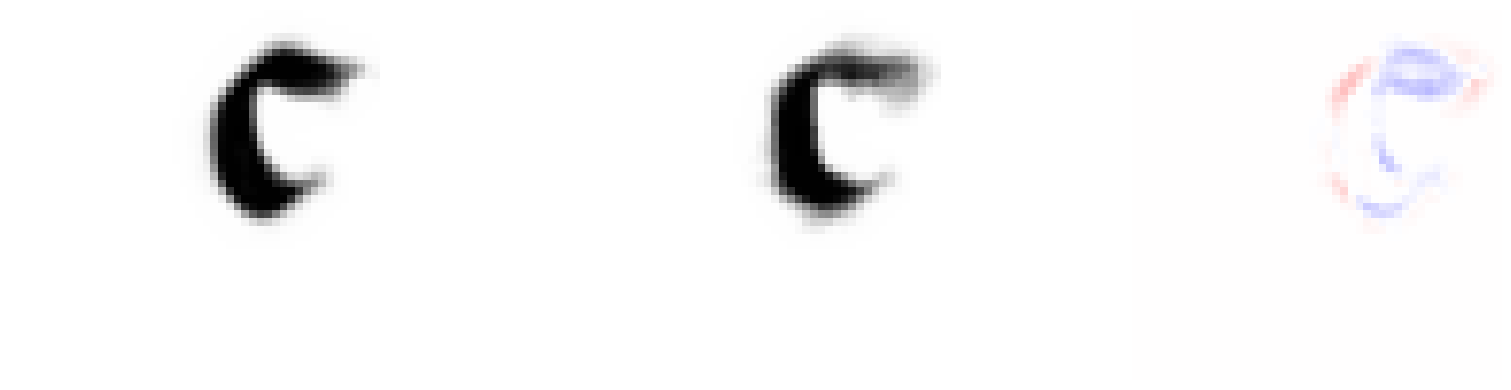

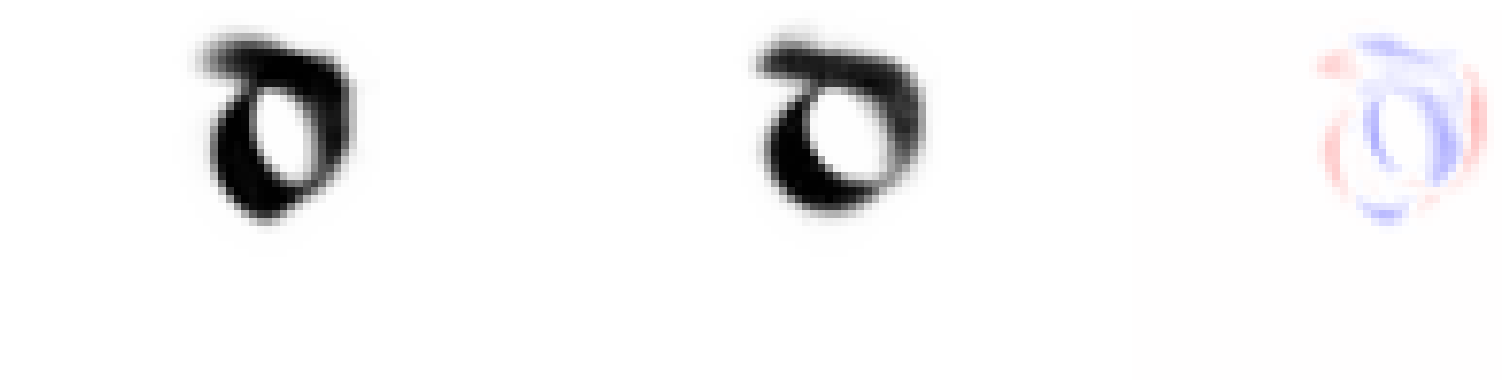

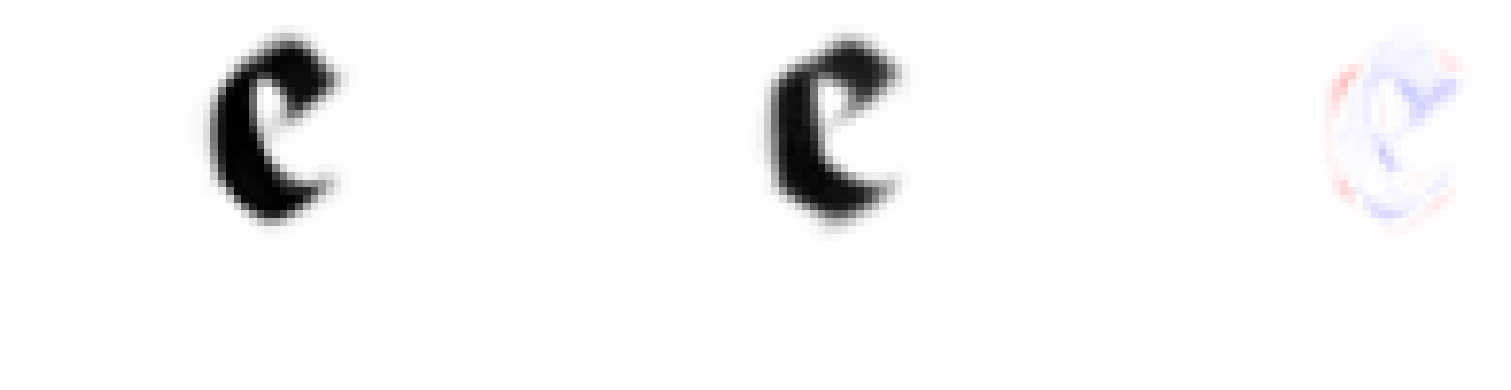

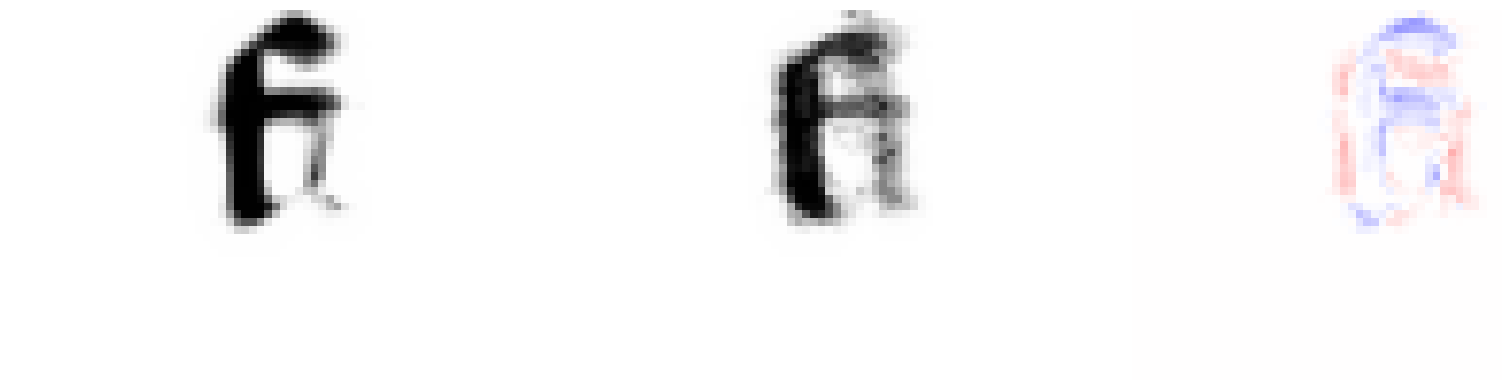

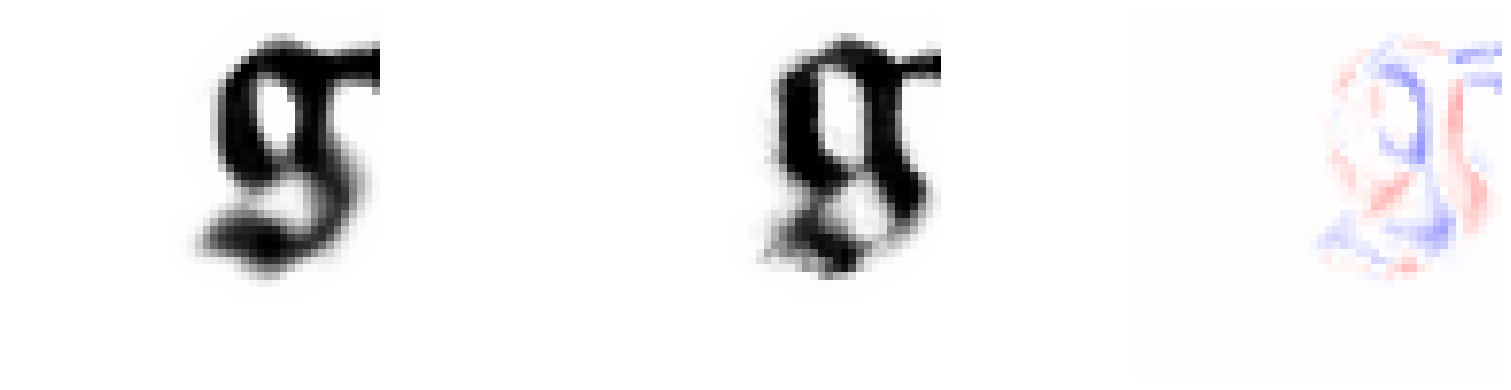

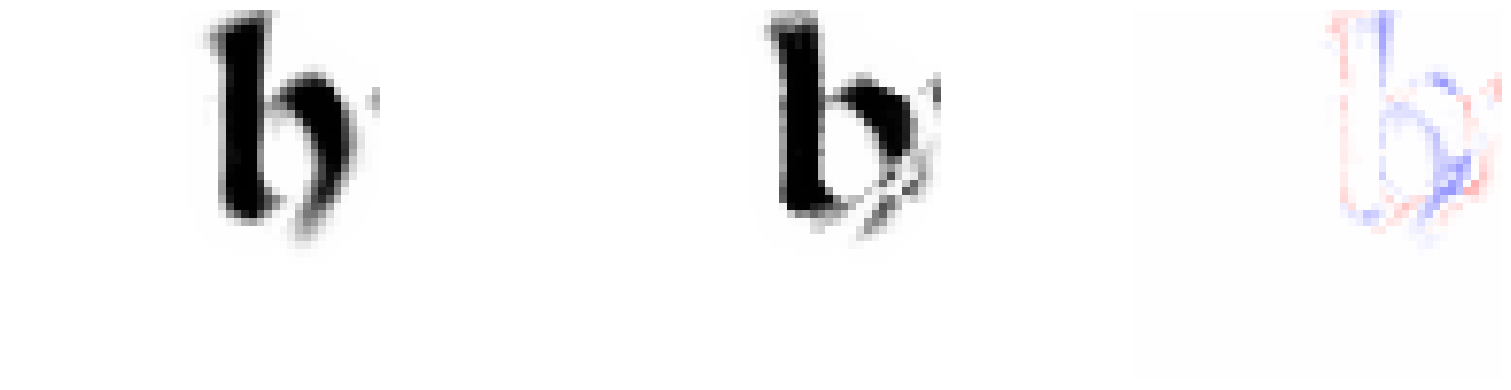

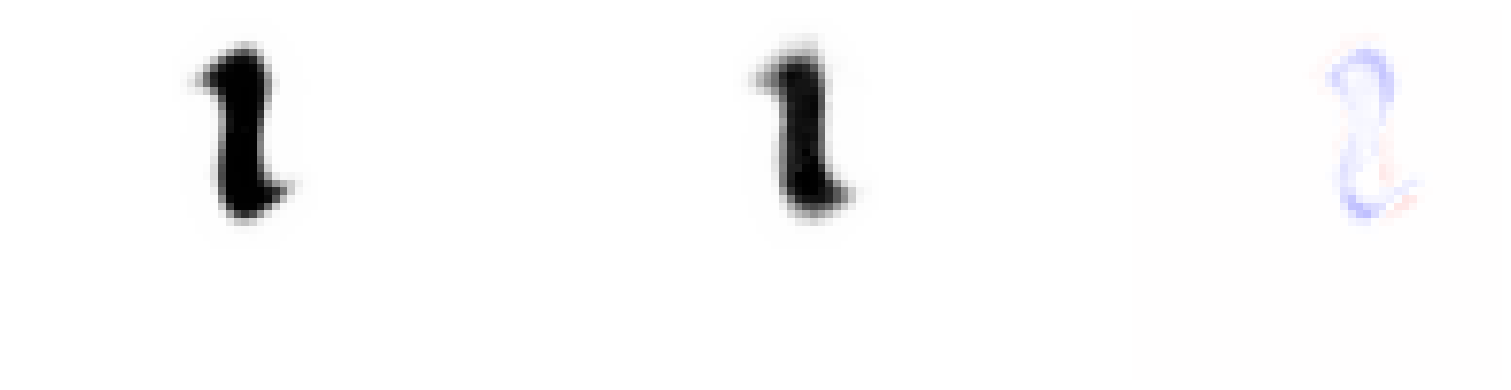

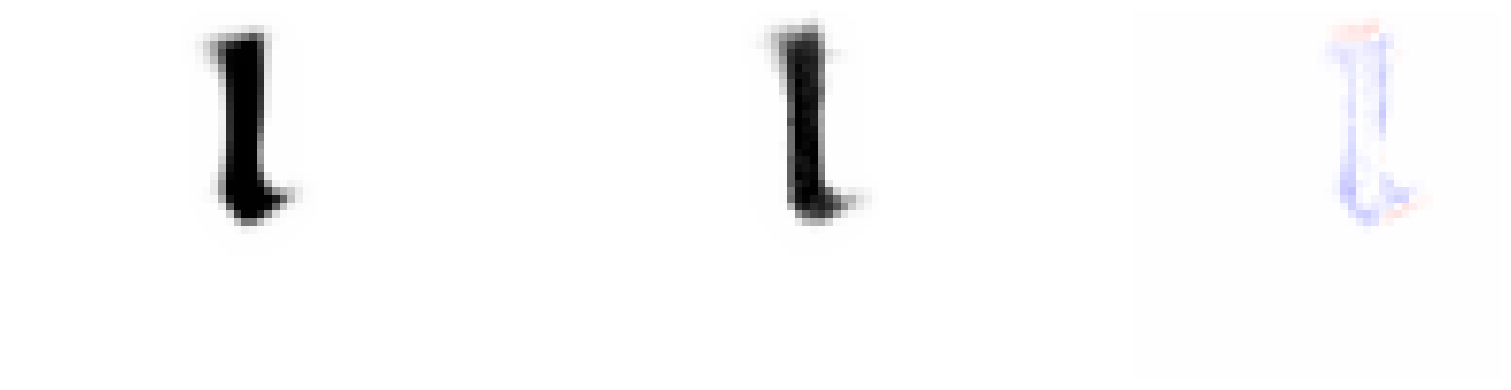

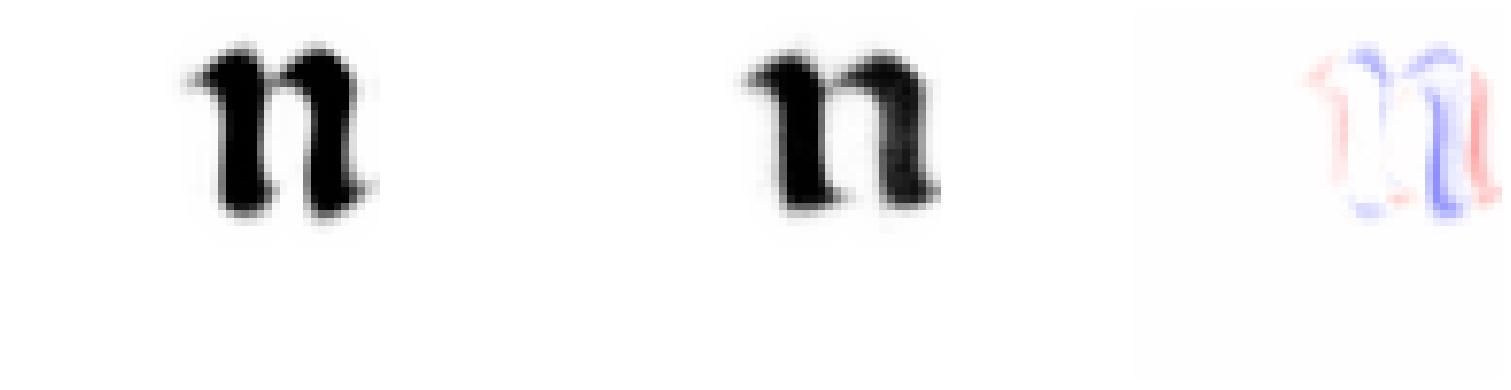

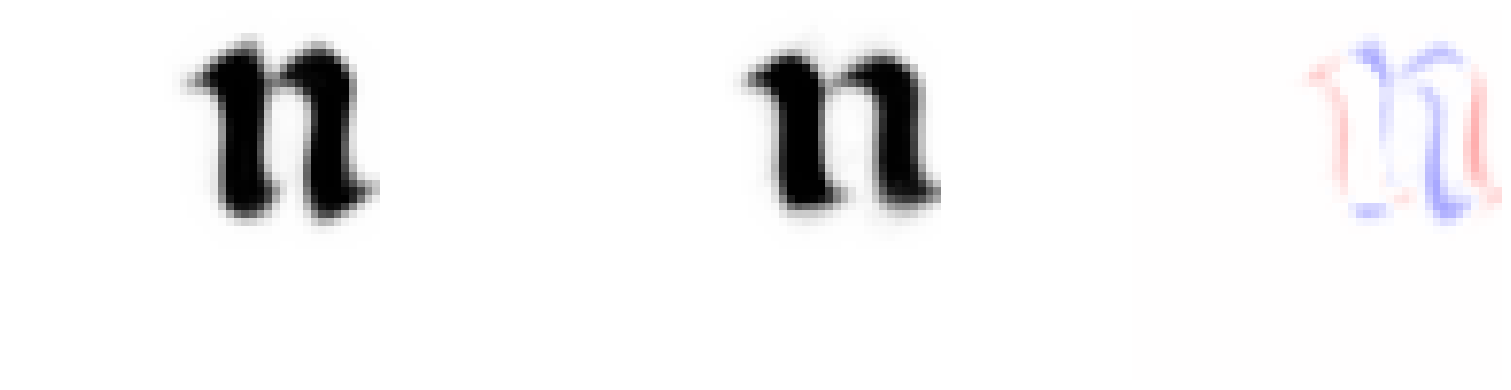

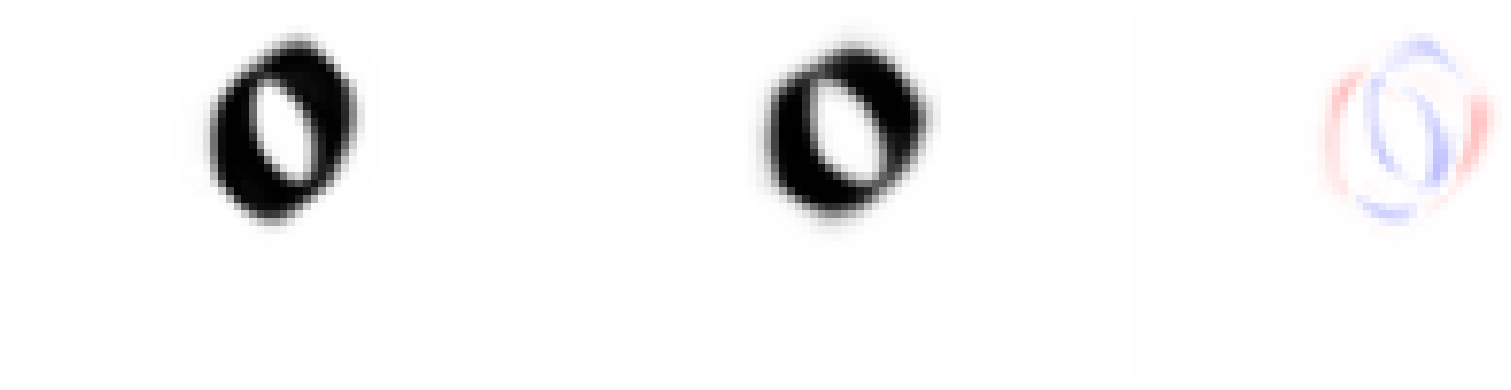

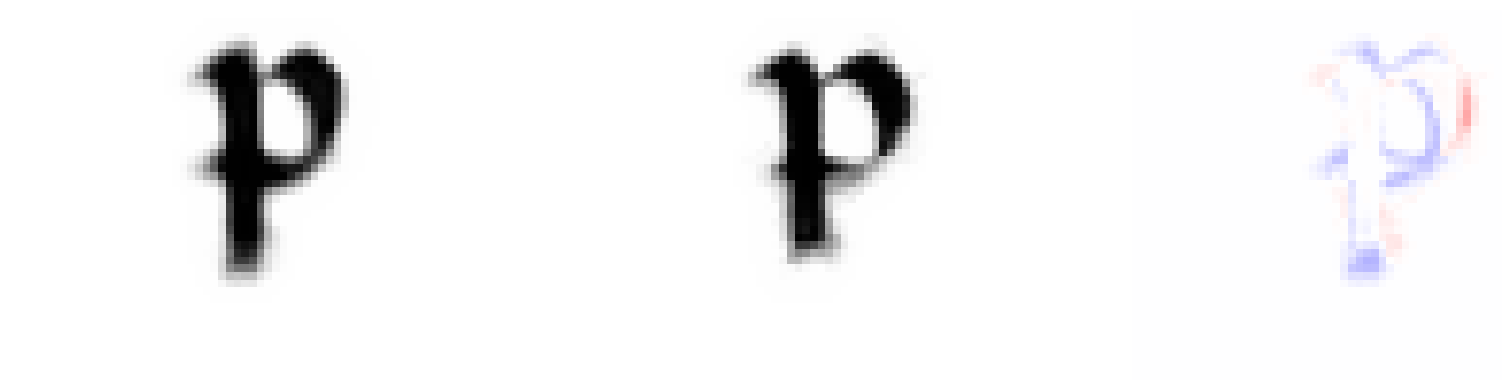

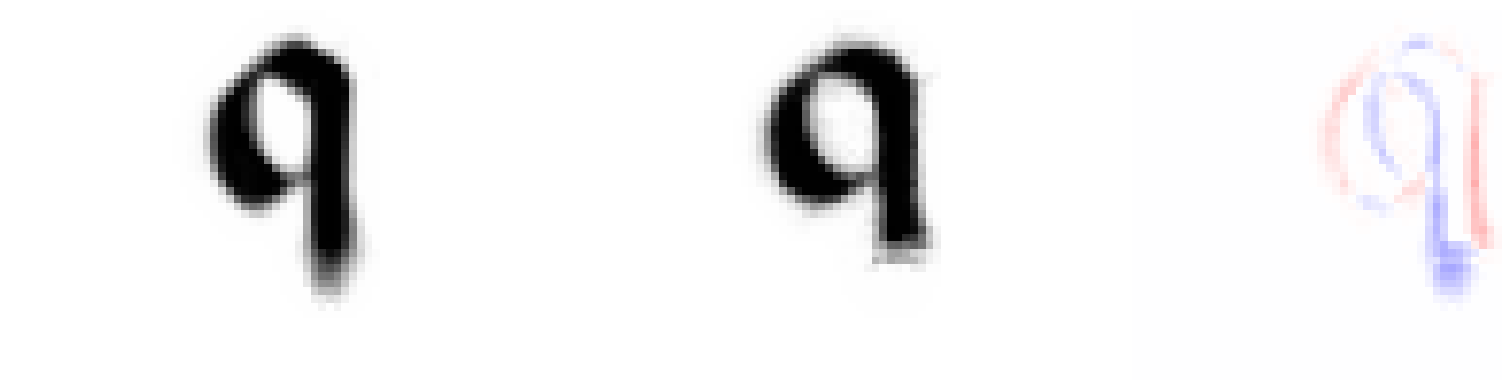

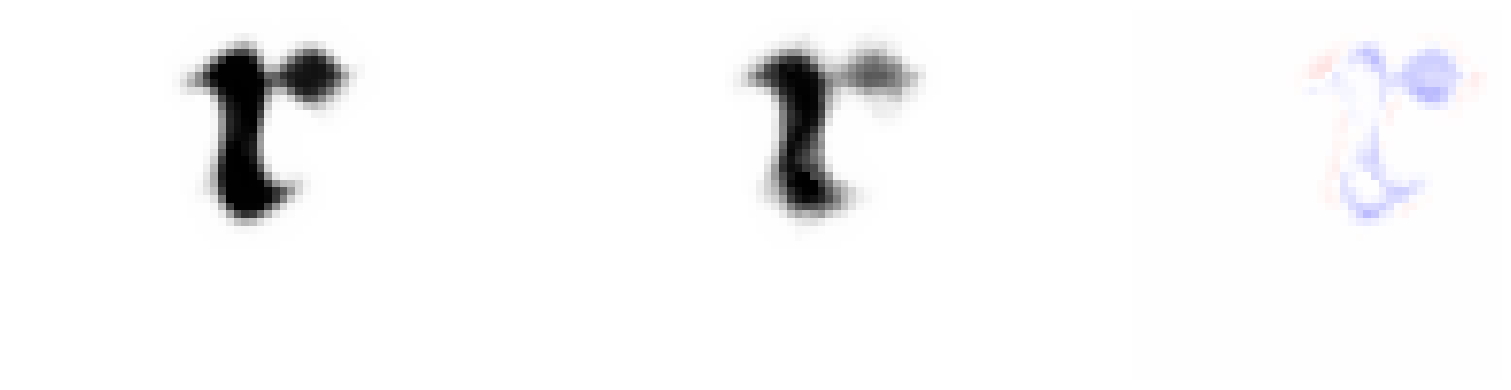

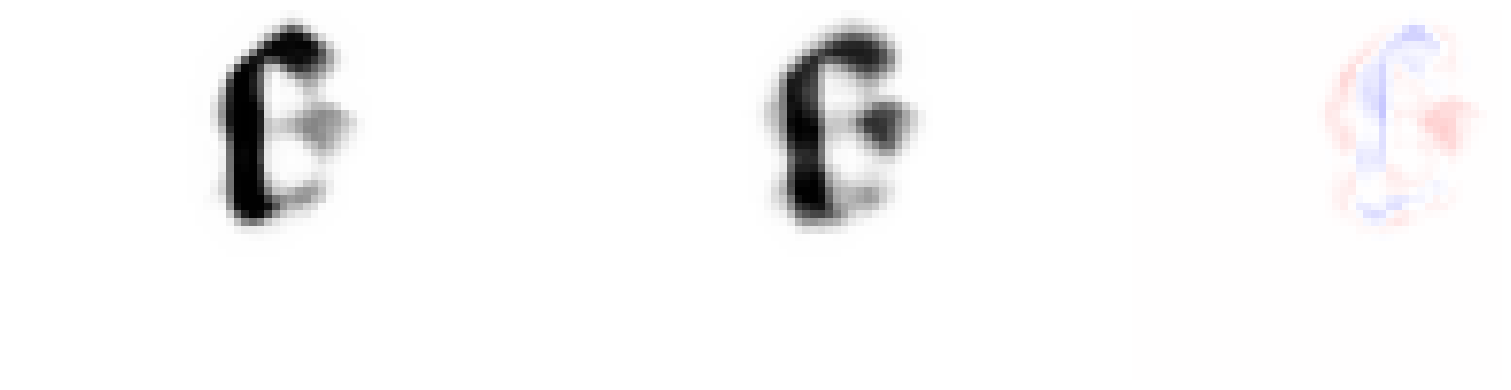

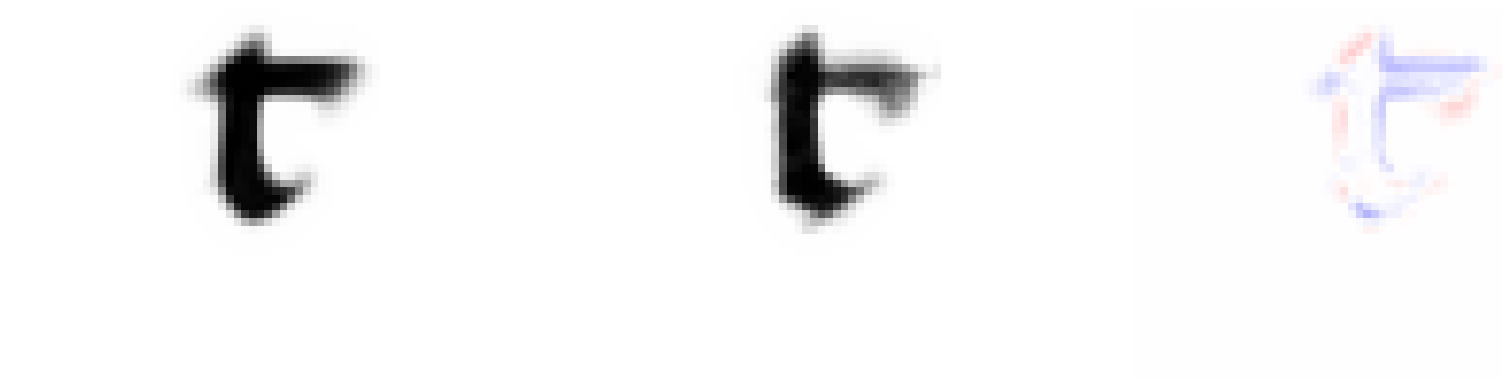

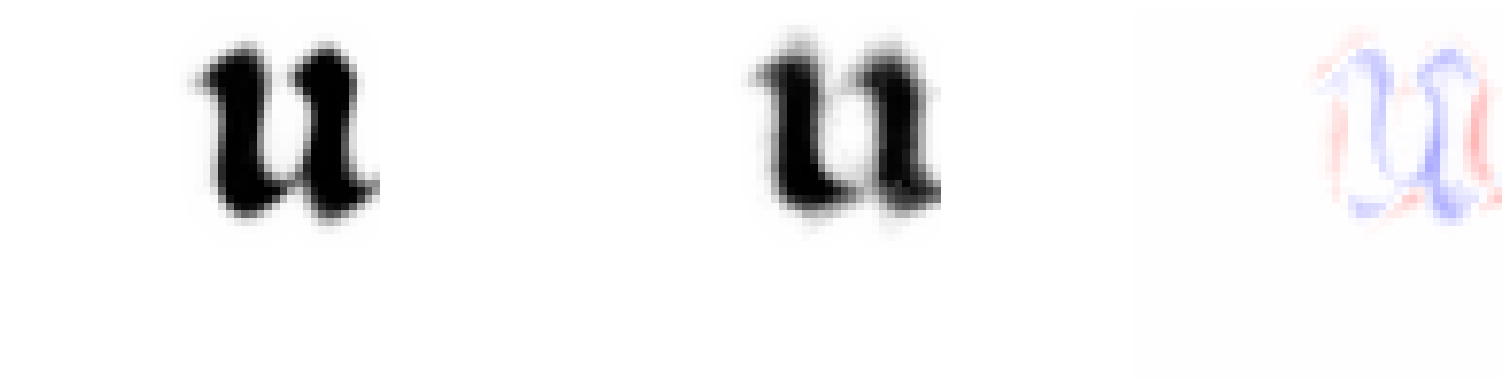

Image grid saved at: comp_prototypes/baseline_comp_all/baseline_comp_all.png


<Figure size 640x480 with 0 Axes>

In [21]:
directory_path = 'prototypes/filtered/'
directory = 'comp_prototypes/'

# Get a list of all directories within the specified directory
docs_to_compare = ["Northern_Textualis", "btv1b8447298r", "btv1b525068331", "Arras-861", "btv1b84473026",
                "btv1b8455783p", "btv1b55006072j", "SBB-PK-Hdschr25", 'Southern_Textualis', "btv1b90615126", "btv1b100361755", "btv1b8433319z",
               "IB15304245v", "btv1b90590259", "btv1b8446940n", "IB15304274v"]

# Loop through the folders and compare each against the baseline prototype
for doc_to_compare in docs_to_compare:
    doc_path = os.path.join(directory_path, doc_to_compare)
    print("Processing folder:", doc_path) 
    
    # Construct the output folder path
    output_folder = os.path.join(directory, 'baseline_comp_all', doc_to_compare)
    visualize_comparison(os.path.join(directory_path, 'baseline'), doc_path, character_index, output_folder)

# Save the visual comparison image outside the loop
visual_comparison_path = os.path.join(directory, 'baseline_comp_all', 'baseline_comp_all.png')
plt.savefig(visual_comparison_path)
print("Image grid saved at:", visual_comparison_path)

Visual comparison grid

In [37]:
#vertical axis 
folder_order = ["Northern_Textualis", "btv1b8447298r", "btv1b525068331", "Arras-861", "btv1b84473026",
                "btv1b8455783p", "btv1b55006072j", "SBB-PK-Hdschr25", 'Southern_Textualis', "btv1b90615126", "btv1b100361755", "btv1b8433319z",
               "IB15304245v", "btv1b90590259", "btv1b8446940n", "IB15304274v"]


# Specify the folders:
denoised_prototype_folders = "comp_prototypes/baseline_comp_all/"
output_folder = "grids/"
output_path = os.path.join(output_folder, "baseline_comp_all.jpeg")

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)
print(f"Created directory: {output_folder}")

# Open one of the images to calculate its dimensions to define the grid size
sample_image_path = os.path.join(denoised_prototype_folders, folder_order[0], f"{character_index[0]}.png")
sample_image = PIL.Image.open(sample_image_path)

# Calculate image width and height
image_width, image_height = sample_image.size

# Generate the grid image
denoised_prototypes_borders = folder_to_grid(denoised_prototype_folders, folder_order, character_index, image_width, image_height, margin=margin)

# Save the grid image
denoised_prototypes_borders.save(output_path)
print("Image grid saved at:", output_path)

Created directory: grids/
Pasted image: comp_prototypes/baseline_comp_all/Northern_Textualis/28.png at row: 0, col: 0
Pasted image: comp_prototypes/baseline_comp_all/Northern_Textualis/29.png at row: 0, col: 1
Pasted image: comp_prototypes/baseline_comp_all/Northern_Textualis/30.png at row: 0, col: 2
Pasted image: comp_prototypes/baseline_comp_all/Northern_Textualis/31.png at row: 0, col: 3
Pasted image: comp_prototypes/baseline_comp_all/Northern_Textualis/32.png at row: 0, col: 4
Pasted image: comp_prototypes/baseline_comp_all/Northern_Textualis/33.png at row: 0, col: 5
Pasted image: comp_prototypes/baseline_comp_all/Northern_Textualis/34.png at row: 0, col: 6
Pasted image: comp_prototypes/baseline_comp_all/Northern_Textualis/35.png at row: 0, col: 7
Pasted image: comp_prototypes/baseline_comp_all/Northern_Textualis/36.png at row: 0, col: 8
Pasted image: comp_prototypes/baseline_comp_all/Northern_Textualis/39.png at row: 0, col: 9
Pasted image: comp_prototypes/baseline_comp_all/Northe

Calculate the variance of the two subtypes: 

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

# Function to flatten image into a vector
def flatten_image(image):
    return image.flatten() / 255.0  # Normalize pixel values to [0, 1]

# Function to calculate standard deviation of pixel values for a directory
def calculate_metric_for_directory(directory_path):
    # Check if the directory exists
    if not os.path.isdir(directory_path):
        print("Error: Directory does not exist.")
        return

    # Initialize lists to store image names and corresponding stds
    image_names = []
    stds = []

    # Iterate over each image name in the specified range
    for image_name in list(range(28, 37)) + list(range(39, 49)): # adjust the range as per your selection of characters
        # Initialize list to store flattened images
        images = []

        # Iterate over each subfolder (class) in the directory
        for subfolder in os.listdir(directory_path):
            subfolder_path = os.path.join(directory_path, subfolder)

            # Check if the subfolder is a directory
            if os.path.isdir(subfolder_path):
                # Construct the path to the image in this subfolder
                image_path = os.path.join(subfolder_path, f"{image_name}.png")

                # Check if the image file exists
                if os.path.isfile(image_path):
                    # Read the image
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                    # Flatten the image into a vector
                    flattened_image = flatten_image(image)

                    # Append the flattened image vector to the list
                    images.append(flattened_image)

        # Convert the list of vectors to a numpy array
        images = np.array(images)

        # Calculate variance for each class
        variance = np.var(images, axis=0, ddof=1)

        # Calculate metric (standard deviation)
        std = np.sqrt(np.sum(variance))

        # Append image name and std to lists
        image_names.append(f"Image {image_name}.png")
        stds.append(std)

    # Create DataFrame from the lists
    df = pd.DataFrame({'Image': image_names, 'Std': stds})

    return df

# Function to merge 'ST' and 'NT' DataFrames
def merge_dataframes(st_df, nt_df):
    # Merge the DataFrames on the 'Image' column
    merged_df = pd.merge(st_df, nt_df, on='Image', suffixes=('_ST', '_NT'))
    return merged_df

# Example usage:
st_df = calculate_metric_for_directory("/content/drive/My Drive/variance/ST")
nt_df = calculate_metric_for_directory("/content/drive/My Drive/variance/NT")

# Merge the DataFrames
merged_df = merge_dataframes(st_df, nt_df)
print("Merged DataFrame:")
print(merged_df)


Time to pass at the graph making

First we need to import and calculate some basic functions that we'll need for our graphs

Let's first plot the document graphs: 

In [1]:
import os
import os
import json
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['figure.figsize'] = (15, 10)  # Adjusted figure size
matplotlib.rcParams['image.cmap'] = 'summer'
matplotlib.rcParams['font.size'] = 17
matplotlib.rcParams['legend.fontsize'] = 'large'
matplotlib.rcParams['figure.titlesize'] = 'medium'
matplotlib.rcParams['lines.linewidth'] = 2.0

plt.rcParams['text.usetex'] = False

from matplotlib.colors import LogNorm



# Define your folder paths
folder_1 = [
    'prototypes/filtered/Northern_Textualis/',  
    'prototypes/filtered/Southern_Textualis/'
]

#uncomment for the entire corpus

folder_2 = [
    #NT
    #'prototypes/filtered/btv1b8447298r/',
    #'prototypes/filtered/btv1b525068331/',
    'prototypes/filtered/Arras-861/',
    #'prototypes/filtered/btv1b84473026/',
    'prototypes/filtered/btv1b8455783p/',
    'prototypes/filtered/btv1b55006072j/',
    #'prototypes/filtered/SBB-PK-Hdschr25/',
    #ST
    #'prototypes/filtered/btv1b90615126/', 
    'prototypes/filtered/btv1b100361755/',    
    #'prototypes/filtered/btv1b8433319z/',    
    #'prototypes/filtered/IB15304245v/',
    #'prototypes/filtered/btv1b90590259/',    
    'prototypes/filtered/btv1b8446940n/', 
    'prototypes/filtered/IB15304274v/', 
    
]

output_folder = 'graphs/'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)
print(f"Created directory: {output_folder}")

# Load JSON mapping of character index to label
json_path = '/home/vlachoum/learnable-scriber/finetune_runs/iwcp_south_north_individual/transcribe.json'
with open(json_path) as json_file:
    character_mapping = json.load(json_file)
    
    
# Create a mapping dictionary for Codename to ID
codename_to_id = {
    'NT1': 'btv1b8447298r',
    'NT2': 'btv1b525068331',
    'NT3': 'Arras-861',
    'NT4': 'btv1b84473026',
    'NT5': 'btv1b8455783p',
    'NT6': 'btv1b55006072j',
    'NT7': 'SBB-PK-Hdschr25',
    'ST1': 'btv1b90615126',
    'ST2': 'btv1b100361755',
    'ST3': 'btv1b8433319z',
    'ST4': 'IB15304245v',
    'ST5': 'btv1b90590259',
    'ST6': 'btv1b8446940n',
    'ST7': 'IB15304274v'
}


csv_path = 'char_occurences.csv'


# Custom character range
character_range = list(range(28, 36)) + list(range(39, 48))

char_occurrences_df = pd.read_csv(csv_path, index_col=0, sep=";")
#print(char_occurrences_df)
char_occurrences_df = char_occurrences_df.loc[list(range(28,36)) + list(range(39, 48))]

# Convert DataFrame to numeric, coerce errors to NaN
char_occurrences_df = char_occurrences_df.apply(pd.to_numeric, errors='coerce')

# Function to calculate L2 difference between two images
def calculate_l2_norm(image1, image2):
    array1 = np.array(image1).astype(float) / 255.0 
    array2 = np.array(image2).astype(float) / 255.0 
    difference = array1 - array2
    l2_norm = np.sqrt(np.sum(difference**2))
    return l2_norm


def plot_l2_differences(folder_1_paths, folder_2_paths, output_folder, char_occurrences_df):
    num_rows = (len(folder_2_paths) + 2) // 3  # Add 2 to ensure at least one row if len(character_range) < 3
    fig, axs = plt.subplots(num_rows, 3, figsize=(22, 6 * num_rows))  # Adjusted figure size
    
    plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.2, hspace=0.3)  # Adjusted subplots layout

    max_occurrences = char_occurrences_df.max().max()
    min_occurrences = char_occurrences_df.min().min()

    all_max_l2_diff = []  # List to store maximum L2 differences from all subplots
    
    norm = LogNorm()
    for i, folder_2_path in enumerate(folder_2_paths):
        folder_comp_id = folder_2_path.split('/')[-2]
        codename = list(codename_to_id.keys())[list(codename_to_id.values()).index(folder_comp_id)]  # Get the corresponding Codename

        all_l2_diff_southern = []
        all_l2_diff_northern = []
                
        char_occurrences = char_occurrences_df[folder_comp_id]

        for character in character_range:
            northern_image_path = os.path.join(folder_1_paths[1], f'{character}.png')
            folder_2_image_path = os.path.join(folder_2_path, f'{character}.png')

            northern_image = Image.open(northern_image_path)
            folder_2_image = Image.open(folder_2_image_path)

            l2_difference_northern = calculate_l2_norm(northern_image, folder_2_image)
            all_l2_diff_northern.append(l2_difference_northern)

            southern_image_path = os.path.join(folder_1_paths[0], f'{character}.png')
            folder_2_image_path = os.path.join(folder_2_path, f'{character}.png')

            southern_image = Image.open(southern_image_path)
            folder_2_image = Image.open(folder_2_image_path)

            l2_difference_southern = calculate_l2_norm(southern_image, folder_2_image)
            all_l2_diff_southern.append(l2_difference_southern)

        # Plot the points with color intensity based on character occurrences             
        scatter = axs.flat[i].scatter(all_l2_diff_southern, all_l2_diff_northern, c=char_occurrences, cmap='viridis', norm=norm, alpha=0.6, s=60)
        axs.flat[i].set_ylabel(r'\textbf{Distance to ST prototype}', fontsize=20)
        axs.flat[i].set_xlabel(r'\textbf{Distance to NT prototype}', fontsize=20)
        axs.flat[i].grid(True)
        

        # Get the maximum L2 difference encountered in this subplot
        max_l2_difference = max(max(all_l2_diff_southern), max(all_l2_diff_northern))
        all_max_l2_diff.append(max_l2_difference)

        # Increase border size
        axs.flat[i].margins(0.3)

        # Add character text for every subplot
        for character, x, y in zip(character_range, all_l2_diff_southern, all_l2_diff_northern):
            axs.flat[i].text(x, y, character_mapping.get(str(character), str(character)), fontsize=20, ha='right', va='bottom')  # Adjust the font size of character text

        # Add mss legend
        axs.flat[i].text(0.5, 0.98, fr'\textbf{{Document: {codename}}}', color='black', fontsize=20, ha='center', va='top', transform=axs.flat[i].transAxes)
    
    plt.tight_layout()

    # Set the same starting value for axes and ticks for all subplots
    for i, ax in enumerate(axs.flat):
        ax.plot([0, 17], [0, 17], linestyle='--', color='gray') 
        ax.set_xlim(0, 17)  
        ax.set_ylim(0, 17)
        ax.set_xticks([0, 5, 10, 15])  
        ax.set_yticks([0, 5, 10, 15])
        
        # Remove ticks and labels from both axes
        ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)  # Remove ticks and labels from both axes
        ax.grid(True)  # Enable gridlines
        ax.set_xticklabels([]) 
        ax.set_yticklabels([]) 

    
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=norm), ax=axs, orientation='vertical',location='right', shrink=0.9)#, pad=0.1)
    cbar.set_label('Occurrences')
    
    #tight_layout = True

    # Save the plot
    output_plot_path = os.path.join(output_folder, 'paper_document_graphs.jpeg')
    plt.savefig(output_plot_path)
    plt.close()

# Call the function with your folder paths
plot_l2_differences(folder_1, folder_2, output_folder, char_occurrences_df)

Created directory: graphs/


Letter graphs 

In [7]:
import os
import json
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# Set matplotlib parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['figure.figsize'] = (9, 6)
matplotlib.rcParams['image.cmap'] = 'summer'
matplotlib.rcParams['font.size'] = 17
matplotlib.rcParams['legend.fontsize'] = 'large'
matplotlib.rcParams['figure.titlesize'] = 'medium'
matplotlib.rcParams['lines.linewidth'] = 2.0

# Define folder paths
folder_1 = [
    'prototypes/filtered/Northern_Textualis/',
    'prototypes/filtered/Southern_Textualis/'
]

folder_2 = [
    'prototypes/filtered/btv1b8447298r/',
    'prototypes/filtered/btv1b525068331/',
    'prototypes/filtered/Arras-861/',
    'prototypes/filtered/btv1b84473026/',
    'prototypes/filtered/btv1b8455783p/',
    'prototypes/filtered/btv1b55006072j/',
    'prototypes/filtered/SBB-PK-Hdschr25/',
    'prototypes/filtered/btv1b90615126/',
    'prototypes/filtered/btv1b100361755/',
    'prototypes/filtered/btv1b8433319z/',
    'prototypes/filtered/IB15304245v/',
    'prototypes/filtered/btv1b90590259/',
    'prototypes/filtered/btv1b8446940n/',
    'prototypes/filtered/IB15304274v/'
]

# Load JSON file with manuscript script information
script_path = '/home/vlachoum/learnable-scriber/datasets/iwcp_south_north/annotation.json'
manuscript_info_df = pd.read_json(script_path).T
manuscript_info_df['ID'] = manuscript_info_df.index.str.split('_').str[0]
manuscript_info_df = manuscript_info_df.drop_duplicates(subset=['ID'])
display(manuscript_info_df)


# Load JSON mapping of character index to label
json_path = '/home/vlachoum/learnable-scriber/finetune_runs/iwcp_south_north_individual/transcribe.json'
with open(json_path) as json_file:
    character_mapping = json.load(json_file)

# Custom character range
character_range = [28, 35, 36, 42, 43, 45]

# Mapping split categories
split_to_id = {
    'train': ['btv1b8447298r', 'btv1b525068331', 'Arras-861', 'btv1b84473026', 'btv1b90615126', 'btv1b100361755', 'btv1b8433319z', 'IB15304245v'],
    'test': ['btv1b8455783p', 'btv1b55006072j', 'SBB-PK-Hdschr25', 'btv1b90590259', 'btv1b8446940n', 'IB15304274v']
}


# Function to calculate L2 difference between two images
def calculate_l2_norm(image1, image2):
    array1 = np.array(image1).astype(float) / 255.0  
    array2 = np.array(image2).astype(float) / 255.0  
    difference = array1 - array2
    l2_norm = np.sqrt(np.sum(difference**2))
    return l2_norm

def plot_l2_differences_per_character(folder_1_paths, folder_2_paths, output_folder, manuscript_info_df):
    num_rows = (len(character_range) + 2) // 3
    fig, axs = plt.subplots(num_rows, 3, figsize=(20, 6 * num_rows))

    all_max_l2_diff = []  # To store maximum L2 difference across all subplots
    
    for i, character in enumerate(character_range):
        row = i // 3
        col = i % 3

        all_l2_diff_southern = []
        all_l2_diff_northern = []
        script_category = []  # To store whether each manuscript belongs to Southern or Northern category
        split_category = []   # To store whether each manuscript belongs to train or test split
        
        for folder_2_path in folder_2_paths:
            northern_image_path = os.path.join(folder_1_paths[1], f'{character}.png')  # Switched order
            folder_2_image_path = os.path.join(folder_2_path, f'{character}.png')

            northern_image = Image.open(northern_image_path)
            folder_2_image = Image.open(folder_2_image_path)

            l2_difference_northern = calculate_l2_norm(northern_image, folder_2_image)
            all_l2_diff_northern.append(l2_difference_northern)

            southern_image_path = os.path.join(folder_1_paths[0], f'{character}.png')  # Switched order
            folder_2_image_path = os.path.join(folder_2_path, f'{character}.png')

            southern_image = Image.open(southern_image_path)
            folder_2_image = Image.open(folder_2_image_path)

            l2_difference_southern = calculate_l2_norm(southern_image, folder_2_image)
            all_l2_diff_southern.append(l2_difference_southern)

            # Determine script category for current folder
            folder_comp_id = os.path.basename(os.path.normpath(folder_2_path))
            codename = list(codename_to_id.keys())[list(codename_to_id.values()).index(folder_comp_id)]  # Get the corresponding Codename
            script = manuscript_info_df.loc[manuscript_info_df['ID'] == folder_comp_id, 'script']
            script_category.append(script.iloc[0] if not script.empty else 'Unknown')
            
            # Determine whether manuscript belongs to train or test split
            split = 'train' if folder_comp_id in split_to_id['train'] else 'test'
            split_category.append(split)


        # Plot the points with color intensity based on script category
        colors = []
        for script, split in zip(script_category, split_category):
            if script == 'Southern_Textualis':
                colors.append('red')
            elif script == 'base':  # Change color for 'base' script to black
                colors.append('black')
            else:
                colors.append('blue')

        # Plot the points with color intensity based on script category
        for southern, northern, color, split in zip(all_l2_diff_southern, all_l2_diff_northern, colors, split_category):
            marker_split = 'o' if split == 'train' else 'x'  # Use marker based on split category
            axs[row, col].scatter(southern, northern, c=color, marker=marker_split, s=65)
            axs[row, col].set_xlabel(r'\textbf{Distance to NT prototype}', fontsize=20)
            axs[row, col].set_ylabel(r'\textbf{Distance to ST prototype}', fontsize=20)
            #axs[row, col].set_title(f'Character: {character_mapping.get(str(character), str(character))}', fontsize=15)
            axs[row, col].grid(True)  # Ensure the background is grided

        # Draw diagonal line separating the two classes
        max_l2_difference = max(max(all_l2_diff_southern), max(all_l2_diff_northern))
        
        plt.tight_layout()

        # Label points with manuscript names
        for j, (x, y) in enumerate(zip(all_l2_diff_southern, all_l2_diff_northern)):
            codename = list(codename_to_id.keys())[list(codename_to_id.values()).index(folder_2_paths[j].split('/')[-2])]  # Get the corresponding Codename
            axs[row, col].annotate(codename, (x, y), textcoords="offset points", xytext=(0, 0), ha='left', va='bottom', fontsize=15)

        # Store maximum L2 difference for this subplot
        all_max_l2_diff.append(max_l2_difference)
        
        # Store distances for each class
        all_l2_diff_southern = np.array(all_l2_diff_southern)
        all_l2_diff_northern = np.array(all_l2_diff_northern)
        
        
         # Add legend
        character = character_mapping.get(str(character), str(character))
        axs[row, col].text(0.5, 0.98, fr'\textbf{{Character : {character}}}', color='black', fontsize=25, ha='center', va='top', transform=axs[row, col].transAxes)


    # Determine the maximum L2 difference across all subplots
    max_l2_difference_all = max(all_max_l2_diff)

    # Set the same starting value for axes and ticks for all subplots
    for i, ax in enumerate(axs.flat):
        ax.plot([0, 17], [0, 17], linestyle='--', color='gray')  # Adjusted x-axis limit to 20
        ax.set_xlim(0, 17)  # Adjusted x-axis limit to 20
        ax.set_ylim(0, 17)
        ax.set_xticks([0, 5, 10, 15])  # Adjusted x-axis ticks to include 20
        ax.set_yticks([0, 5, 10, 15])
        
    
        # Remove ticks and labels from both axes
        ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)  # Remove ticks and labels from both axes
        ax.grid(True)  # Enable gridlines
        ax.set_xticklabels([])  # Hide x-axis tick labels
        ax.set_yticklabels([])
    
    plt.tight_layout()
    
    output_folder = 'graphs/'
    output_plot_path = os.path.join(output_folder, 'no_ticks_l2_differences_per_character.jpg')
    plt.savefig(output_plot_path)
    plt.close()

# Call the function with your folder paths
plot_l2_differences_per_character(folder_1, folder_2, output_folder, manuscript_info_df)

,label,page,split,script,ID
IB15304245v_eSc_line_65f6c260.png,sy enlas armas por bueno q̃ sea,IB15304245v.jpg,train,Southern_Textualis,IB15304245v
btv1b100361755_fueros_navarre_5v_6r_eSc_line_4490bf52.png,que lis iudgen los dreytos,btv1b100361755_fueros_navarre_5v_6r.jpg,train,Southern_Textualis,btv1b100361755
btv1b525068331_f189_ds_facsb_r3l22.png,blanches et sus le dos de bi,btv1b525068331_f189.jpg,train,Northern_Textualis,btv1b525068331
btv1b84473026_f9_facs_28_r2l22.png,lobediẽce est meilleur par,btv1b84473026_f9.jpg,train,Northern_Textualis,btv1b84473026
btv1b8433319z_f43_eSc_line_940b26a8.png,similm̃te danna e inuano.,btv1b8433319z_f43.jpg,train,Southern_Textualis,btv1b8433319z
btv1b55006072j_f10_eSc_line_eb244489.png,ꝑdris et pour la caille. Quintement,btv1b55006072j_f10.jpg,train,Northern_Textualis,btv1b55006072j
Arras-861_f056r_eSc_line_63121ec5.png,q̃ paulo remotiora uidentur: excutere.,Arras-861_f056r.jpg,train,Northern_Textualis,Arras-861
btv1b90615126_f175_ec221_facs_214_r6l32.png,mes au pere resembloit des eus quil a,btv1b90615126_f175.jpg,train,Southern_Textualis,btv1b90615126
btv1b8446940n_f214_line_19.png,initio ĩseqͣr cũ illuc uen̾o atq,btv1b8446940n_f214.jpg,train,Southern_Textualis,btv1b8446940n
btv1b90590259_f19_ec221_facs_200_r7l2.png,uoir.ie ne pois aler. habe me ex,btv1b90590259_f19.jpg,train,Southern_Textualis,btv1b90590259
